**INSTALACIÓN DE VERSION DE PYTORCH COMPATIBLE CON RASPBERRY Y DEPENDENCIAS NECESARIAS**

In [1]:
!pip install imgaug==0.2.5
!pip install Pillow==5.0.0
!pip install torch==1.3.0+cu100 torchvision==0.4.1+cu100 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


**CONECTA DRIVE CON CÓDIGO PARA PODER UTILIZAR LOS ARCHIVOS QUE HAY EN DRIVE**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORTAR LIBRERIAS**

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
import random
import sys

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

plt.ion()  

archivo = open("/content/drive/My Drive/Datos_Train_densenet121.txt","w")

**BASE DE DATOS ALEATORIA**

In [ ]:
#Definición clases (nombres de las carpetas en la base de datos)
clase1="2-Incendio"
clase2="1-No incendio"

#Directorio con la base de datos original
dir_origen="/content/drive/MyDrive/base de datos final color/"
size=len(os.listdir(dir_origen + str(clase1))) # Retorna una lista del directorio deseado (listdir). con (len) la cantidad de archivos que tiene el directorio
#porc_train=int(0.9*size) # Porcentaje de datos para entrenamiento normalizado a 1 (80% en este ejemplo)
porc_val=int(0.1*size)

#Ciclo para K=10 en validación cruzada, crea las 10 bases de datos 
for i in range(1,11):
    print("base",i)
    dir_base="/content/drive/MyDrive/Base" + str(i) +"/"
    count = 0 #Iniciaclización contador clase 1
    count1 = 0 #Iniciaclización contador clase 2


    if os.path.exists(dir_base):                        #Condicional pregunta si directorio 'base de datos' existe
        shutil.rmtree(dir_base, ignore_errors=False)    #Si existe elimina directorio 
    else:                                                    #Si no existe se crea uno nuevo
        print("directorio no existe, se creara uno nuevo")

    #Creación de los directorios de las bases de datos
    os.mkdir(dir_base) 
    os.mkdir(dir_base + "train") 
    os.mkdir(dir_base + "val")
    os.mkdir(dir_base + "train/2-Incendio" ) 
    os.mkdir(dir_base + "train/1-No incendio")
    os.mkdir(dir_base + "val/2-Incendio" ) 
    os.mkdir(dir_base + "val/1-No incendio")
    
    #límite para que las bases de datos sean distintas durante la validación cruzada.
    lim_sup=porc_val*i
    
    ############## Proceso de asignación de imágenes en val y train de la clase 1 ####################### 
    
    if i==1:
        fires=os.listdir(dir_origen + str(clase1))
        #print("fires")
        #print(fires)
        random.shuffle(fires) 
  
    for file in fires: 
        
        if i==1:
            if count >=lim_sup-porc_val and count < lim_sup:       
                dir_destino=dir_base + "val/" + str(clase1) + "/"
            if count >= lim_sup:       
                dir_destino=dir_base + "train/" + str(clase1) + "/"
        
        if i==10:
            if count >=lim_sup-porc_val and count < lim_sup:                 
                dir_destino=dir_base + "val/" + str(clase1) + "/"
            if count < lim_sup-porc_val: 
                dir_destino=dir_base + "train/" + str(clase1) + "/"

        if i>=2 and i<=9:
            if count >=lim_sup-porc_val and count < lim_sup:                
                dir_destino=dir_base + "val/" + str(clase1) + "/"
            if count < lim_sup-porc_val or count>=lim_sup: 
                dir_destino=dir_base + "train/" + str(clase1) + "/"

        print("fires ",count)
        shutil.copy(dir_origen + str(clase1) + "/" + str(file),dir_destino + str(file))    
        count += 1

    #####################################################################################################

    ############## Proceso de asignación de imágenes en val y train de la clase 2 ####################### 
    
    if i==1:
        no_fires=os.listdir(dir_origen + str(clase2))
        #print("no_fires")
        #print(no_fires)
        random.shuffle(no_fires) 


    for file in no_fires: 
            
        if i==1:
            if count1 >=lim_sup-porc_val and count1 < lim_sup:             
                dir_destino=dir_base + "val/" + str(clase2) + "/"
            if count1 >= lim_sup:    
                dir_destino=dir_base + "train/" + str(clase2) + "/"
        if i==10:
            if count1 >=lim_sup-porc_val and count1 < lim_sup:              
                dir_destino=dir_base + "val/" + str(clase2) + "/"
            if count1 < lim_sup-porc_val:      
                dir_destino=dir_base + "train/" + str(clase2) + "/"

        if i>=2 and i<=9:
            if count1 >=lim_sup-porc_val and count1 < lim_sup:                
                dir_destino=dir_base + "val/" + str(clase2) + "/"
            if count1 < lim_sup-porc_val or count1>=lim_sup:      
                dir_destino=dir_base + "train/" + str(clase2) + "/"
        print("no_fires ",count1)
        shutil.copy(dir_origen + str(clase2) + "/" + str(file),dir_destino + str(file))    
        count1 += 1

    #####################################################################################################


**CARGA DE DATASET Y APLICACIÓN DE TRANSFORMACIONES**

In [5]:
name_model='DENSENET121'
k_cont=1         #Número de base a seleccionar
mod_cont=14

print("Modelo = ",name_model)
archivo.write("\n###################################################################")

while(k_cont<11):

  ###############################CARGA DE DATASET Y APLICACIÓN DE TRANSFORMACIONES################################

  data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(224), #recorta la imagen en forma aleatoria (224x224 pixeles)
          transforms.RandomHorizontalFlip(), #rota imagen horizontalmente 
          transforms.ToTensor(),             #convierte la imagen a formato matricial 
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normaliza cada pixel segun la media y desviacion estandar 
      ]),
      'val': transforms.Compose([
          transforms.Resize(256), #reduce la imagen por submuestreo 
          transforms.CenterCrop(224), #recorta las imagenes,toma punto de referencia el centro
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }
  
  if(k_cont==1):
    data_dir = '/content/drive/My Drive/Base1' #dirección de la carpeta de base de datos
    save_model=name_model +' model_It1.pth'

  if(k_cont==2):
    data_dir = '/content/drive/My Drive/Base2' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It2.pth'

  if(k_cont==3):
    data_dir = '/content/drive/My Drive/Base3' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It3.pth'
  
  if(k_cont==4):
    data_dir = '/content/drive/My Drive/Base4' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It4.pth'

  if(k_cont==5):
    data_dir = '/content/drive/My Drive/Base5' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It5.pth'

  if(k_cont==6):
    data_dir = '/content/drive/My Drive/Base6' #dirección de la carpeta de base de datos
    save_model=name_model +' model_It6.pth'

  if(k_cont==7):
    data_dir = '/content/drive/My Drive/Base7' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It7.pth'

  if(k_cont==8):
    data_dir = '/content/drive/My Drive/Base8' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It8.pth'
  
  if(k_cont==9):
    data_dir = '/content/drive/My Drive/Base9' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It9.pth'

  if(k_cont==10):
    data_dir = '/content/drive/My Drive/Base10' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It10.pth'
  
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),  #carga las imagenes de train y val
                                            data_transforms[x])         #de la base de datos y les aplica las transformaciones
                    for x in ['train', 'val']}
  
  print(data_dir) 
  #batch_size = número de imagenes por lote
  #shuffle = true , reorganizacion de datos en cada epoca  

                
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, #reorganiza las imagenes para cada iteracion 
                                              shuffle=True, num_workers=4)
                for x in ['train', 'val']}

  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}  #tamaño del conjunto de datos 
  class_names = image_datasets['train'].classes  #clases de la base de datos 
  #print(class_names)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #identifica si el codigo se ba a correr en GPU  o CPU
  #print(device)

  class_to_idx = image_datasets['train'].class_to_idx
  print(class_to_idx)

  print ("Dataset Size: "+ str(dataset_sizes) + "\n")
  n_class = len(class_names)
  print ("Number of classes: "+ str(n_class) + "\n")
  print ("Classes: "+ str(class_names) + "\n")
  print (len(dataloaders))

  ###############################FUNCIÓN DE ENTRENAMIENTO###############################

  def train_model(model, criterion, optimizer, scheduler, num_epochs):
      since = time.time()

      yy_train=[]
      xx_train=[]
      yy_val=[]
      xx_val=[]
      sen_train=[]
      sen_val=[]
      esp_train=[]
      esp_val=[]
      prec_train=[]
      prec_val=[]
      fpr_train=[]
      fpr_val=[]
      acc_train=[]
      acc_val=[]
      predict=torch.cuda.FloatTensor(0)
      best_predict=torch.cuda.FloatTensor(0)
      labels_real=torch.cuda.FloatTensor(0)
      best_labels=torch.cuda.FloatTensor(0)
      prob=torch.cuda.FloatTensor(0)
      best_prob=torch.cuda.FloatTensor(0)    
      cont_epoch = 0
      epoch_min = 0
      #Inicialización en cero de variables Verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos
      VP=0
      FP=0
      VN=0
      FN=0
      #archivo = open("/content/drive/My Drive/Datos_Resnet.txt", 'w')
      #archivo.write("Resnet18\n")
      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      acc_aux = 0.0
      best_sen = 0.0
      specificity = 0.0
      precision= 0.0

      for epoch in range(num_epochs):
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)

          # Cada época tiene una fase de entrenamiento y validación
          for phase in ['train', 'val']:
              if phase == 'train':
                  #scheduler.step()
                  model.train()  # Set model to training mode  # Poner el modelo en modo de entrenamiento
              else:
                  model.eval()   # Set model to evaluate mode

              running_loss = 0.0
              running_corrects = 0

              # Iterate over data. # Iterar sobre los datos.
            
              predict=torch.cuda.FloatTensor(0)
              labels_real=torch.cuda.FloatTensor(0)
              prob=torch.cuda.FloatTensor(0)
              for inputs, labels in dataloaders[phase]:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)

                      sm = torch.nn.Softmax(dim=1)
                      probabilities = sm(outputs)
                      probabilities = probabilities[:,1]
                      valores, preds = torch.max(outputs, 1)
                      #print(type(phase))
                      loss = criterion(outputs, labels)

                      if phase == 'val':
                        prob = torch.cat((prob,probabilities),0)
                        predict=torch.cat((predict.float(),preds.float()),0)
                        labels_real=torch.cat((labels_real.float(),labels.data.float()),0)


                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)
                  
                  #Prueba Verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos

                  for i in range (len(labels.data)):
                    if (labels.data[i]== preds[i]):
                    #print(i)
                      if (labels.data[i]== 1):
                        VP+=1;
                      else:
                        VN+=1;
                    else:
                      if(labels.data[i]== 1):
                        FP+=1;
                      else:
                        FN+=1;

              #px1=1-especificidad
              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]
              
              if acc_aux<epoch_acc:
                acc_aux=epoch_acc
              
              #33333 Condicional durante entrenamiento
              if phase == 'train':
                scheduler.step()

                acc_train.append(epoch_acc)
                sen_train.append(VP/(VP+FN))
                esp_train.append(VN/(VN+FP))
                prec_train.append(VP/(VP+FP))
                fpr_train.append(1- esp_train[epoch])
                print("VP= " + str(VP) + " VN= " + str(VN) + " FP= " + str(FP) + " FN= " + str(FN))
                print('Sensibilidad: {:.4f} Especificidad: {:.4f} Precisión: {:.4f}'.format(sen_train[epoch], esp_train[epoch], prec_train[epoch]))
                yy_train.append(epoch_loss)
                xx_train.append(epoch)                  
                writer.add_scalars("Loss", {"Loss/train": epoch_loss}, epoch)  
                  #archivo.close() 

              ###### Condicional durante validación
              if phase == 'val':
                
                #Calcula sensibilidad y especificidad en validación
                acc_val.append(epoch_acc)
                sen_val.append(VP/(VP+FN))
                esp_val.append(VN/(VN+FP))
                prec_val.append(VP/(VP+FP))
                fpr_val.append(1- esp_train[epoch])
                print("VP= " + str(VP) + " VN= " + str(VN) + " FP= " + str(FP) + " FN= " + str(FN))
                print('Sensibilidad: {:.4f} Especificidad: {:.4f} Precisión: {:.4f}'.format(sen_val[epoch], esp_val[epoch], prec_val[epoch]))
                if epoch == 0:
                  stop_val=10

                yy_val.append(epoch_loss)
                xx_val.append(epoch)
                writer.add_scalars("Loss", {"Loss/val":epoch_loss}, epoch)             

                if epoch_loss>stop_val:
                  cont_epoch+=1
                  print("cont= "+str(cont_epoch))
                  
                else:
                  if cont_epoch < 30:
                    dif_val = stop_val-epoch_loss
                    porc_val_back=0.1*stop_val
                    if dif_val>porc_val_back:
                      cont_epoch=0
                      stop_val=epoch_loss 
                      epoch_min=epoch
                      print("perdida disminuyendo ",epoch_min)
                      best_sen=sen_val[epoch]
                      best_acc = epoch_acc
                      specificity = esp_val[epoch]
                      precision = prec_val[epoch] 
                      best_model_wts = copy.deepcopy(model.state_dict())
                      best_predict=predict
                      best_labels=labels_real
                      best_prob=prob                     
                    else:
                      cont_epoch+=1
                      print("cont= "+str(cont_epoch))
                    
              VP=0
              FP=0
              VN=0
              FN=0
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))


      #print((predict))    
      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f} Sen: {:.4f} Esp: {:.4f}'.format(best_acc, best_sen, specificity))

      # load best model weights
      model.load_state_dict(best_model_wts)
      #writer.flush()
      writer.close()
      return model, yy_train, xx_train, yy_val, xx_val, epoch_min, stop_val, acc_train, acc_val, best_predict, best_labels, best_prob, best_acc, best_sen, specificity, precision, time_elapsed, acc_aux #retorna el mejor modelo 

      ############################### CARGA DE PARAMETROS Y MODELO PREENTRENADO ############################### 

  model_ft = models.densenet121(pretrained=True)

  num_ftrs = model_ft.classifier.in_features
  model_ft.classifier = nn.Linear(num_ftrs, 2)
  model_ft = model_ft.to(device)
  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  #Implementa descenso de gradiente estocástico (opcionalmente con impulso).
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005)

  # Decay LR by a factor of 0.1 every 7 epochs
  #Decae la tasa de aprendizaje de cada grupo de parámetros por gamma en cada etapa de step_size. 
  #Tenga en cuenta que dicho deterioro puede ocurrir simultáneamente con otros cambios en la tasa de aprendizaje 
  #desde fuera de este programador. Cuando last_epoch = -1, establece lr inicial como lr.
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.05)
  #print(model_ft)

  ############################### ENTRENAMIENTO DEL MODELO ###############################

  model_ft, yy_train, xx_train, yy_val, xx_val, epoch_min, stop_val, acc_train, acc_val, best_predict, best_labels, best_prob, best_acc, best_sen, specificity, precision, time_train, acc_aux = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

  ############################### IMPRESIÓN DE PARAMETROS ###############################

  print("Datos perdidas")
  print("xx_train = " + str(xx_train))
  print("yy_train = "+ str(yy_train))
  print("xx_val = "+ str(xx_val))
  print("yy_val = "+ str(yy_val))
  print("epoch_min = "+ str(epoch_min))
  print("stop_val = "+ str(stop_val))
  print("\n")

  print("Datos accuracy")

  for i in range(len(acc_val)):
    acc_val[i]=acc_val[i].tolist()
    acc_train[i]=acc_train[i].tolist()
  print("acc_train = " + str(acc_train))
  #print("xx_train = " + str(xx_train))
  print("acc_val = "+ str(acc_val))
  #print("xx_val = "+ str(xx_val))
  #print(len(best_prob))

  print("\nDatos curva ROC")
  best_labels=best_labels.tolist()
  best_prob=best_prob.tolist()
  print("best_labels = "+ str(best_labels))
  print("best_prob = "+ str(best_prob))

  print("\nMetricas de validación")
  best_acc=best_acc.tolist()
  acc_aux=acc_aux.tolist()
  print("Best_acc = "+ str(best_acc))
  print("acc_aux = "+ str(acc_aux))
  print("Recall = "+ str(best_sen))
  print("Precisión = "+ str(precision))
  print("Especificidad = "+ str(specificity))
  print('Tiempo = {:.0f}s'.format(time_train))




  ############################### GUARDADO DE PARAMETROS EN TXT ###############################
  archivo.write("\n")
  archivo.write("\n######## Base" + str(k_cont) + " ########")
  archivo.write("\n#MODELO = " + name_model )
  archivo.write("\n#Datos perdidas")
  archivo.write("\nxx_train" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(xx_train))
  archivo.write("\nyy_train" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(yy_train))
  archivo.write("\nxx_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(xx_val))
  archivo.write("\nyy_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(yy_val))
  archivo.write("\nepoch_min" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(epoch_min))
  archivo.write("\nstop_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(stop_val))
  archivo.write("\n")

  archivo.write("\n#Datos accuracy")
  archivo.write("\nacc_train" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(acc_train))
  archivo.write("\nacc_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(acc_val))
  archivo.write("\n")

  archivo.write("\n#Datos curva ROC")
  archivo.write("\nbest_labels" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_labels))
  archivo.write("\nbest_prob" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_prob))
  archivo.write("\n")

  archivo.write("\n#Metricas de validación")
  archivo.write("\nBest_acc" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_acc))
  archivo.write("\nacc_aux" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(acc_aux))
  archivo.write("\nRecall" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_sen))
  archivo.write("\nPrecisión" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(precision))
  archivo.write("\nEspecificidad" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(specificity))
  archivo.write("\nTiempo" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(time_train))


  ############################### GUARDADO DE MODELO ###############################

  #print(torch.__version__)

  model_ft.class_to_idx = image_datasets['train'].class_to_idx
  model_ft.cpu()
  torch.save({'arch': name_model,
              'state_dict': model_ft.state_dict(), 
              'class_to_idx': model_ft.class_to_idx}, 
              save_model)
  k_cont+=1

Modelo =  DENSENET121
/content/drive/My Drive/Base1
{'1-No incendio': 0, '2-Incendio': 1}
Dataset Size: {'train': 3240, 'val': 360}

Number of classes: 2

Classes: ['1-No incendio', '2-Incendio']

2


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 55.6MB/s]


Epoch 0/2
----------
VP= 1397 VN= 1457 FP= 223 FN= 163
Sensibilidad: 0.8955 Especificidad: 0.8673 Precisión: 0.8623
train Loss: 0.3146 Acc: 0.8809
VP= 168 VN= 178 FP= 12 FN= 2
Sensibilidad: 0.9882 Especificidad: 0.9368 Precisión: 0.9333
perdida disminuyendo  0
val Loss: 0.1411 Acc: 0.9611
Epoch 1/2
----------
VP= 1520 VN= 1551 FP= 100 FN= 69
Sensibilidad: 0.9566 Especificidad: 0.9394 Precisión: 0.9383
train Loss: 0.1523 Acc: 0.9478
VP= 173 VN= 177 FP= 7 FN= 3
Sensibilidad: 0.9830 Especificidad: 0.9620 Precisión: 0.9611
perdida disminuyendo  1
val Loss: 0.0800 Acc: 0.9722
Epoch 2/2
----------
VP= 1533 VN= 1560 FP= 87 FN= 60
Sensibilidad: 0.9623 Especificidad: 0.9472 Precisión: 0.9463
train Loss: 0.1209 Acc: 0.9546
VP= 177 VN= 175 FP= 3 FN= 5
Sensibilidad: 0.9725 Especificidad: 0.9831 Precisión: 0.9833
cont= 1
val Loss: 0.0783 Acc: 0.9778
Training complete in 5m 51s
Best val Acc: 0.972222 Sen: 0.9830 Esp: 0.9620
Datos perdidas
xx_train = [0, 1, 2]
yy_train = [0.3145768328949257, 0.152256

In [6]:
archivo.close() 

**GUARDAR MODELO**

In [ ]:

###################################################################

######## Base1 ########
#MODELO = DENSENET121
#Datos perdidas
xx_train1_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_1 = [0.2494468120145209, 0.12389699560992512, 0.09342919657995671, 0.08385061535202426, 0.07018836713683459, 0.07570165424251261, 0.06766725375696465, 0.06313761111210894, 0.04772464609992357, 0.05166580469152074, 0.06323759392087842, 0.06121088041935438, 0.05729961056768158, 0.05662085378979459, 0.06117859195779871, 0.051900736435695934, 0.06862769496661646, 0.058938412993778416, 0.05286931645723037, 0.05527825563410182, 0.05556081136067708, 0.05785369398417296, 0.05763728655414817, 0.058373949226037954, 0.0529377434356713]
xx_val1_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_1 = [0.18246035244729783, 0.06198165135251151, 0.04465589887566036, 0.031162787477175394, 0.08437212076452043, 0.03269774284627702, 0.025644112792279985, 0.02460990332894855, 0.027395621107684242, 0.02583852923578686, 0.02532254068387879, 0.023967494815588, 0.0257460731599066, 0.023800837662484912, 0.0234859941734208, 0.025496331685119205, 0.02386419441964891, 0.02727729363573922, 0.022694204416539934, 0.02515175011422899, 0.02467883394824134, 0.021415144370661842, 0.02709472386373414, 0.025264467381768758, 0.02629152221812142]
epoch_min1_1 = 6
stop_val1_1 = 0.025644112792279985

#Datos accuracy
acc_train1_1 = [0.8935185185185185, 0.9546296296296296, 0.966358024691358, 0.9679012345679012, 0.9743827160493826, 0.9712962962962963, 0.9746913580246913, 0.9762345679012345, 0.9851851851851852, 0.9827160493827161, 0.9759259259259259, 0.975, 0.9811728395061728, 0.9783950617283951, 0.9774691358024691, 0.9827160493827161, 0.9740740740740741, 0.9790123456790123, 0.9830246913580246, 0.9820987654320987, 0.9808641975308642, 0.979320987654321, 0.9817901234567901, 0.9777777777777777, 0.9817901234567901]
acc_val1_1 = [0.9222222222222223, 0.9750000000000001, 0.9861111111111112, 0.9916666666666667, 0.9750000000000001, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9888888888888889, 0.9861111111111112, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9916666666666667, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112]

#Datos curva ROC
best_labels1_1 = [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
best_prob1_1 = [0.9996757507324219, 0.9999691247940063, 0.9988964796066284, 0.0019104350358247757, 0.000268361036432907, 0.999992847442627, 0.008361391723155975, 0.0026652454398572445, 0.0005801807274110615, 0.005503915715962648, 0.009217789396643639, 0.9941670894622803, 0.9993429780006409, 0.9984691739082336, 0.9999327659606934, 0.9999886751174927, 0.9997503161430359, 0.008224833756685257, 0.0015016882680356503, 0.5526713728904724, 0.9997511506080627, 4.4524160330183804e-05, 0.9999717473983765, 0.9997714161872864, 0.9979509711265564, 0.9999939203262329, 0.0003186505055055022, 0.0017008406575769186, 0.0007734804530628026, 0.008211817592382431, 0.9993798732757568, 7.829216337995604e-05, 0.9874135255813599, 0.9970799088478088, 0.9970545768737793, 0.5527603030204773, 0.999954104423523, 0.999794065952301, 0.9999749660491943, 0.00014742318307980895, 7.511091826017946e-05, 0.0004428164102137089, 0.999749481678009, 0.999383807182312, 0.9992828965187073, 0.0014420183142647147, 0.00019980418437626213, 0.0006352266063913703, 0.7244710922241211, 0.9995099306106567, 0.010966784320771694, 0.000840083637740463, 0.006673553492873907, 0.9997822642326355, 0.9984567165374756, 0.0005589477950707078, 0.0034638382494449615, 0.999993085861206, 0.3967222273349762, 0.9590736627578735, 0.0030192190315574408, 0.999607264995575, 0.0016327040502801538, 0.0028658064547926188, 0.9998961687088013, 7.933214510558173e-05, 0.0012871650978922844, 0.002613051561638713, 0.9998663663864136, 0.9999959468841553, 0.10164496302604675, 0.0007612042827531695, 0.0024963170289993286, 0.9967558979988098, 0.9999417066574097, 0.0019604715052992105, 0.0001493454328738153, 0.8923138976097107, 0.006537462119013071, 0.00035582203418016434, 0.0019384089391678572, 0.027123983949422836, 0.0001876254245871678, 0.0002753156004473567, 0.3232094645500183, 0.0001122474714065902, 0.0011586142936721444, 0.0007614686619490385, 0.9999878406524658, 0.0018105419585481286, 0.0025205682031810284, 0.9996939897537231, 0.9998997449874878, 0.06239652261137962, 0.9995110034942627, 0.0018905478063970804, 0.9999980926513672, 0.9992376565933228, 0.911176323890686, 0.9996480941772461, 0.0010988222202286124, 0.9999350309371948, 0.9999908208847046, 0.9996823072433472, 0.9999772310256958, 0.9999212026596069, 7.18896699254401e-05, 0.9998425245285034, 3.9481539715779945e-05, 0.9979432225227356, 0.0003963980998378247, 0.0010894684819504619, 0.9999960660934448, 0.9998071789741516, 0.006088745780289173, 0.9999531507492065, 0.0014932680642232299, 0.9317399859428406, 0.005409633740782738, 0.9890930652618408, 0.999671220779419, 0.00032480532536283135, 0.0014815883478149772, 0.00010463672515470535, 0.99998939037323, 0.9993748068809509, 0.027667690068483353, 0.03156184405088425, 0.0004487549012992531, 0.9983013868331909, 0.002508726669475436, 0.9999825954437256, 0.9998028874397278, 0.01573917828500271, 0.9999246597290039, 0.8571792244911194, 0.9999979734420776, 0.010556832887232304, 0.9986283779144287, 0.0012035340769216418, 0.0009011410875245929, 0.9076504707336426, 0.9999635219573975, 0.00036510778591036797, 0.00045661634067073464, 0.9992479681968689, 0.009868359193205833, 3.1015930289868265e-05, 0.0006232929299585521, 0.9981265664100647, 0.0006013987003825605, 0.0004504007811192423, 0.002569731092080474, 0.0017321076011285186, 0.9998564720153809, 0.9996187686920166, 0.998547375202179, 0.0016639370005577803, 0.9876454472541809, 0.0024770305026322603, 0.9997803568840027, 0.011354576796293259, 0.9996322393417358, 0.00040482403710484505, 0.9999417066574097, 0.00757972989231348, 0.0014620617730543017, 0.00017268610827159137, 0.999581515789032, 0.00012674779281951487, 0.999440610408783, 0.00010636859951773658, 0.9997571110725403, 0.00017939996905624866, 0.0011440427042543888, 0.9999969005584717, 0.003834142116829753, 3.1015930289868265e-05, 0.9999921321868896, 0.9999657869338989, 0.9995418787002563, 0.9999951124191284, 0.9997168183326721, 0.9981587529182434, 0.9999892711639404, 0.9972676038742065, 0.0006908689974807203, 0.9999872446060181, 0.9991728663444519, 0.9996569156646729, 0.00346789276227355, 2.4874423615983687e-05, 0.9997561573982239, 0.9999487400054932, 0.9988248944282532, 0.9999556541442871, 0.00037360787973739207, 0.0014131091302260756, 0.0009438084671273828, 0.9996008276939392, 0.0016627332661300898, 0.9874019026756287, 6.166595267131925e-05, 0.0002552005462348461, 0.0006505046039819717, 0.0001853144058259204, 0.9999938011169434, 0.0028471695259213448, 0.9995424747467041, 0.9979974627494812, 0.9999982118606567, 0.013699260540306568, 0.00027222855715081096, 0.9986868500709534, 0.04578458517789841, 0.2261756956577301, 0.9993014335632324, 4.0198981878347695e-05, 0.00257943756878376, 0.0005471960175782442, 0.9998438358306885, 0.004627613350749016, 0.992646336555481, 0.00036151419044472277, 0.0005349217099137604, 0.9956592321395874, 0.9999659061431885, 0.0026950312312692404, 0.00904247909784317, 0.9999579191207886, 0.06724114716053009, 0.0012649651616811752, 0.0004710598732344806, 0.009668069891631603, 0.0004004514776170254, 0.9999599456787109, 0.9997276663780212, 0.00045645792852155864, 0.07164693623781204, 0.9998581409454346, 0.03453745320439339, 0.00184165989048779, 0.00044662371510639787, 0.9996803998947144, 0.999805748462677, 0.9985929131507874, 0.9999958276748657, 0.9993137121200562, 0.9995176792144775, 0.9998449087142944, 0.0004784167103935033, 0.9687267541885376, 0.9998277425765991, 0.9998258948326111, 0.9999996423721313, 0.9999549388885498, 0.004856730345636606, 1.966441050171852e-05, 0.9999579191207886, 0.9985820055007935, 0.010072973556816578, 0.9923039078712463, 0.9995532631874084, 0.0037191102746874094, 0.9999955892562866, 0.9998712539672852, 0.9985480904579163, 0.002154455054551363, 0.999970555305481, 0.0024235856253653765, 0.9999805688858032, 0.0005288721877150238, 0.001196585246361792, 0.00039307947736233473, 0.9990481734275818, 0.4282057285308838, 0.999947190284729, 0.15000015497207642, 0.007774905767291784, 0.999992847442627, 0.9997991919517517, 0.9991433620452881, 0.9831825494766235, 0.001640300964936614, 0.9999996423721313, 0.9989940524101257, 0.0017363954102620482, 0.9997710585594177, 0.1464417576789856, 0.006698241923004389, 0.012279821559786797, 0.02212221920490265, 6.58228964312002e-05, 0.9995635151863098, 0.9998939037322998, 0.3739334046840668, 0.0007784093613736331, 0.9999998807907104, 0.9993438124656677, 0.9998966455459595, 0.9998400211334229, 0.9988640546798706, 0.00027312757447361946, 0.9998477697372437, 0.999955415725708, 0.9996418952941895, 0.005031506530940533, 0.018355056643486023, 0.9997699856758118, 0.9995470643043518, 0.0016616033390164375, 0.0009682175586931407, 0.00495633902028203, 0.0007202941342256963, 0.003576376475393772, 9.325212886324152e-05, 0.004346795845776796, 0.002936015138402581, 0.9999163150787354, 0.0069381119683384895, 0.000723189499694854, 0.18833068013191223, 0.9999493360519409, 0.9662144184112549, 0.9999619722366333, 0.00022807133791502565, 0.04730609059333801, 0.9999791383743286, 0.9998558759689331, 0.9996305704116821, 0.9997408986091614, 0.9998588562011719, 0.005349732004106045, 0.0005003478145226836, 0.002735690213739872, 0.9986554384231567, 0.9993589520454407, 0.9994250535964966, 0.025872759521007538, 0.00044789054663851857, 0.9934781789779663, 0.0002105971216224134, 0.0021820799447596073, 0.9998708963394165, 0.0030533934477716684, 0.9997527003288269, 0.14596639573574066, 0.9999775886535645, 0.0009162194328382611, 0.9995567202568054, 0.9991181492805481, 0.007014345843344927, 0.999966025352478, 0.9997817873954773, 0.99991774559021, 0.003910926636308432, 0.00044253809028305113, 0.9998794794082642, 0.00025441363686695695, 0.0032040164805948734]

#Metricas de validación
Best_acc1_1 = 0.9833333333333334
acc_aux1_1 = 0.9916666666666667
Recall1_1 = 0.9833333333333333
Especificidad1_1 = 0.9833333333333333
Tiempo1_1 = 1145.6251277923584

######## Base2 ########
#MODELO = DENSENET121
#Datos perdidas
xx_train2_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_1 = [0.10889421022600598, 0.0623880457179046, 0.0661158221187415, 0.04837218522105688, 0.04580018268323239, 0.04223888143897057, 0.03717673143118988, 0.03668892325626479, 0.03950842066127577, 0.041284371075438864, 0.040259835961056346, 0.041909805326550094, 0.043087227329795745, 0.03698364275473136, 0.03303028835374632, 0.03480567413347739, 0.037593922552503184, 0.040809085919165315, 0.0411763917700744, 0.04553340296318502, 0.041942484456079974, 0.03447204188064293, 0.035320487250516445, 0.03747943484304864, 0.036838062245536735]
xx_val2_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_1 = [0.04833043408062723, 0.05619971545206176, 0.03858801002303759, 0.041858690149254266, 0.05773216982682546, 0.04817838569482168, 0.0505935733517011, 0.05247298818495538, 0.048175367381837635, 0.05318527238236533, 0.048320244749387106, 0.0459176950984531, 0.04540416763888465, 0.04788149313794242, 0.04912128862407472, 0.04575611750284831, 0.05215050006906192, 0.05160141835610072, 0.047939995179573695, 0.043560787869824306, 0.04817080249389013, 0.04505876766310798, 0.040104013598627516, 0.05334799422158135, 0.05280048441555765]
epoch_min2_1 = 2
stop_val2_1 = 0.03858801002303759

#Datos accuracy
acc_train2_1 = [0.9660493827160493, 0.9790123456790123, 0.9759259259259259, 0.9811728395061728, 0.9839506172839506, 0.9851851851851852, 0.9882716049382716, 0.986111111111111, 0.9842592592592593, 0.9854938271604938, 0.9867283950617284, 0.9858024691358025, 0.9833333333333333, 0.9848765432098765, 0.9879629629629629, 0.9882716049382716, 0.987037037037037, 0.9858024691358025, 0.9845679012345678, 0.9833333333333333, 0.987037037037037, 0.9885802469135803, 0.9858024691358025, 0.9891975308641975, 0.9858024691358025]
acc_val2_1 = [0.9805555555555556, 0.9750000000000001, 0.9833333333333334, 0.9861111111111112, 0.9777777777777779, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9861111111111112, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9805555555555556, 0.9833333333333334, 0.9861111111111112, 0.9833333333333334, 0.9805555555555556, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334]

#Datos curva ROC
best_labels2_1 = [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
best_prob2_1 = [0.004455440677702427, 0.00012225779937580228, 0.9945387244224548, 7.730221841484308e-05, 4.263688970240764e-05, 0.9943966865539551, 0.9664648175239563, 0.6271039247512817, 0.9998258948326111, 0.014734483323991299, 0.0030416299123317003, 0.7181459069252014, 0.0003788804169744253, 0.7458469867706299, 0.0008526527672074735, 0.9993706345558167, 6.277146167121828e-05, 0.002445690333843231, 0.04273352026939392, 0.9909288287162781, 0.010911401361227036, 0.9999257326126099, 0.9981291890144348, 0.9802697896957397, 0.9993036985397339, 0.9989125728607178, 0.00011574172822292894, 0.005907970946282148, 0.9999345541000366, 0.000599360151682049, 0.99959796667099, 0.00031135138124227524, 0.00013876456068828702, 0.00014224917686078697, 0.999157190322876, 0.9998084902763367, 0.9897564053535461, 0.9997028708457947, 0.8450558185577393, 0.9988400340080261, 0.0005507629830390215, 0.9982284903526306, 0.9999758005142212, 0.0018350300379097462, 0.9998226761817932, 0.9937276840209961, 0.009706312790513039, 0.9991387128829956, 0.9997751116752625, 0.9989381432533264, 0.20792923867702484, 0.0010132346069440246, 0.000947760243434459, 0.002402552170678973, 0.0008371976437047124, 0.9993300437927246, 0.0002929686743300408, 0.007202565670013428, 0.0021341091487556696, 0.9999955892562866, 0.010102004744112492, 0.38205981254577637, 0.0005747174145653844, 8.007028372958302e-05, 0.0032829546835273504, 0.0014568375190719962, 0.0009079514420591295, 0.9973863959312439, 0.004436755087226629, 0.9994194507598877, 0.9999932050704956, 0.9988023042678833, 0.998027503490448, 0.991641640663147, 0.9997139573097229, 0.0012907093623653054, 0.03951813653111458, 0.9912209510803223, 0.9997929930686951, 0.995513379573822, 0.006793212611228228, 0.0004925094544887543, 0.001615778193809092, 8.336087194038555e-05, 0.8742890954017639, 0.0007770401425659657, 0.9999921321868896, 0.0003360138216521591, 0.995391845703125, 0.0016907831886783242, 7.044446101645008e-05, 0.00021366210421547294, 0.9986973404884338, 0.0028170456644147635, 0.9995030164718628, 0.9985257983207703, 0.0016450006514787674, 0.9974896907806396, 0.9998540878295898, 0.014441253617405891, 9.440354187972844e-05, 0.9981898665428162, 0.9997789263725281, 0.005867235362529755, 0.9992594122886658, 0.0008896085782907903, 0.0004095452022738755, 0.0023811371065676212, 0.9943702816963196, 0.9997608065605164, 0.0002538786211516708, 0.02281844988465309, 0.9999951124191284, 0.0005761809879913926, 0.015667743980884552, 0.00035775863216258585, 0.9996854066848755, 0.9994069337844849, 0.9959390163421631, 0.00016532314475625753, 0.999777615070343, 0.9998588562011719, 0.00018538474978413433, 0.999858021736145, 0.0022927862592041492, 0.0013269532937556505, 0.9999710321426392, 0.009401360526680946, 0.00010119794023921713, 0.9977217316627502, 0.995074450969696, 0.9995692372322083, 0.0006431971560232341, 0.0008533282089047134, 0.9999918937683105, 0.00010620015382301062, 0.9996127486228943, 0.9999240636825562, 0.9966161847114563, 3.598730472731404e-05, 0.003277856856584549, 0.00726791238412261, 0.002083619125187397, 0.0007729870849289, 1.3203216440160759e-05, 0.00700014503672719, 0.00017070780450012535, 0.001421306747943163, 0.9992741942405701, 0.00027058052364736795, 0.001921705435961485, 0.996325671672821, 0.9723361134529114, 0.9982636570930481, 0.005046680569648743, 0.9997027516365051, 0.9997183680534363, 0.9995929598808289, 0.0009009299101307988, 0.9994039535522461, 0.9993995428085327, 0.9992127418518066, 0.9999908208847046, 0.9173243045806885, 3.363064388395287e-05, 0.9998842477798462, 0.9998970031738281, 0.9996283054351807, 0.0004194731009192765, 0.9975621700286865, 0.001869125640951097, 0.9995467066764832, 5.655771747115068e-05, 0.9973179697990417, 0.9998704195022583, 0.9997672438621521, 0.9997339844703674, 0.9993430972099304, 0.9999792575836182, 1.2694826182269026e-05, 0.9998160004615784, 0.00040946793160401285, 0.9999656677246094, 0.9995575547218323, 0.9852200746536255, 6.796116940677166e-05, 0.999143123626709, 0.7988916039466858, 0.0005290484405122697, 0.9993496537208557, 0.9336180686950684, 0.0004930541617795825, 0.9999532699584961, 0.9996094107627869, 0.9989475607872009, 0.998908281326294, 0.0012442026054486632, 0.9999704360961914, 0.9997041821479797, 0.9999510049819946, 0.0017861928790807724, 0.006956126075237989, 0.9994379878044128, 0.009184571914374828, 0.003910170402377844, 0.9985184073448181, 0.9998522996902466, 0.000492034072522074, 0.0007555841584689915, 0.9999630451202393, 0.9866055846214294, 0.9999840259552002, 9.592909191269428e-05, 0.999993085861206, 0.03446727991104126, 0.006015282589942217, 0.9996708631515503, 0.9997647404670715, 0.9988956451416016, 0.9994981288909912, 0.9994595646858215, 0.0001911334547912702, 0.003387853968888521, 0.8435666561126709, 0.9997400641441345, 0.03946003317832947, 0.0023527133744210005, 0.0008678139420226216, 0.9983002543449402, 0.0001252544898306951, 0.9997543692588806, 3.335417204652913e-05, 0.8027961254119873, 0.9869944453239441, 0.00011433936015237123, 0.9993903636932373, 0.015744563192129135, 0.9995695948600769, 0.9998841285705566, 0.0033745509572327137, 0.00014639818982686847, 0.0031795911490917206, 0.001364413881674409, 0.0015938780270516872, 0.9996743202209473, 3.752033808268607e-05, 0.9996343851089478, 0.998012900352478, 0.9999986886978149, 0.9995755553245544, 0.9999806880950928, 0.004970176611095667, 0.00047319530858658254, 0.001033390173688531, 0.9999767541885376, 0.9996541738510132, 0.0003281365497969091, 0.999880313873291, 0.9995014667510986, 0.9994091987609863, 0.00018800435645971447, 0.004473129753023386, 0.00012317899381741881, 0.9996891021728516, 0.00024906196631491184, 0.00024538516299799085, 0.00013298967678565532, 0.007957307621836662, 0.0019225997384637594, 0.0007293566013686359, 9.023924940265715e-05, 0.9997822642326355, 0.9997414946556091, 0.9988160133361816, 0.9999912977218628, 0.014379795640707016, 0.9983351826667786, 0.00579433748498559, 5.956680251983926e-05, 0.0001336068962700665, 0.9994303584098816, 0.9976709485054016, 0.9998162388801575, 0.00018416540115140378, 0.004301092587411404, 0.0006227864068932831, 0.4647376835346222, 0.003743145614862442, 0.07847673445940018, 0.9992600083351135, 0.009002394042909145, 0.9991706609725952, 0.005652908235788345, 0.9998424053192139, 0.9966692328453064, 0.9999358654022217, 0.0002036369260167703, 0.002544245682656765, 0.9995032548904419, 0.9995310306549072, 0.9990936517715454, 0.00335331610403955, 0.00254807248711586, 6.0895737988175824e-05, 0.9697304964065552, 0.3321031928062439, 1.5364361388492398e-05, 0.011605573818087578, 0.0004621311090886593, 1.612290543562267e-05, 0.9975183010101318, 0.9999183416366577, 0.9830127358436584, 0.0006333081983029842, 0.9998621940612793, 0.9998413324356079, 0.01791992038488388, 0.9915776252746582, 0.9996185302734375, 0.000657710072118789, 0.9999712705612183, 0.9999232292175293, 0.9999921321868896, 0.0023695840500295162, 0.0005348766571842134, 0.9967051148414612, 0.0006700572557747364, 0.9990647435188293, 0.006995492614805698, 0.00023398718622047454, 0.9998842477798462, 0.0008146774489432573, 7.49089231248945e-05, 0.9991781115531921, 0.9989803433418274, 0.0008690982358530164, 0.06102040782570839, 0.9998549222946167, 0.015025823377072811, 0.9991681575775146, 0.0008458109805360436, 0.030921058729290962, 0.9994580149650574, 0.9999040365219116, 0.9999161958694458, 0.9999345541000366, 0.9939000606536865, 0.00039659865433350205, 0.00015599216567352414, 0.9902368187904358, 0.9935144186019897, 0.0010399776510894299, 0.999983549118042, 0.9996304512023926, 0.02355121076107025, 0.0026918037328869104, 0.9994714856147766, 0.004278502892702818, 0.002578838961198926, 0.001777184777893126]

#Metricas de validación
Best_acc2_1 = 0.9833333333333334
acc_aux2_1 = 0.9891975308641975
Recall2_1 = 0.9728260869565217
Especificidad2_1 = 0.9943181818181818
Tiempo2_1 = 1125.7914173603058

######## Base3 ########
#MODELO = DENSENET121
#Datos perdidas
xx_train3_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_1 = [0.25073133563553845, 0.12521257360040405, 0.09734389239255294, 0.0782747968479439, 0.07956767263419834, 0.05497999045032042, 0.05502045055230458, 0.05872207237062631, 0.057244003610110575, 0.05337950504488415, 0.05237013345331321, 0.04830883731260712, 0.05354738694466191, 0.04723753707460415, 0.05255351931224635, 0.05144604720451214, 0.05584766896050653, 0.04525381080162378, 0.04869930662306739, 0.04987160190939903, 0.051519973815223316, 0.04483192073710171, 0.05348075459952708, 0.04768498674219037, 0.04551308575419732]
xx_val3_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_1 = [0.12576066719161139, 0.057633125947581396, 0.04366077731053034, 0.12543176511923473, 0.033384376681513256, 0.034295461492406, 0.03690295351876153, 0.03371719577246242, 0.03652244640721215, 0.03716489399472873, 0.03644432061248355, 0.0358857500884268, 0.036534974227348964, 0.03549654483795166, 0.03700279262330797, 0.036016172998481324, 0.033195210993289946, 0.03688523918390274, 0.03486389832364188, 0.036977126780483455, 0.03601053174999025, 0.035865040785736504, 0.03642354326115714, 0.03908207946353488, 0.03465300194091267]
epoch_min3_1 = 4
stop_val3_1 = 0.033384376681513256

#Datos accuracy
acc_train3_1 = [0.8978395061728395, 0.9503086419753086, 0.9641975308641975, 0.9734567901234568, 0.9716049382716049, 0.9796296296296296, 0.9824074074074074, 0.9765432098765432, 0.9783950617283951, 0.9802469135802468, 0.9814814814814815, 0.9845679012345678, 0.9820987654320987, 0.9851851851851852, 0.9830246913580246, 0.9811728395061728, 0.9799382716049383, 0.9845679012345678, 0.9858024691358025, 0.9820987654320987, 0.9851851851851852, 0.9830246913580246, 0.9808641975308642, 0.9845679012345678, 0.986111111111111]
acc_val3_1 = [0.9583333333333334, 0.9833333333333334, 0.9805555555555556, 0.9527777777777778, 0.9861111111111112, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9805555555555556, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9861111111111112, 0.9805555555555556, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9805555555555556]

#Datos curva ROC
best_labels3_1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
best_prob3_1 = [0.00011237063154112548, 0.00019300806161481887, 0.0030037302058190107, 0.0008269936661235988, 0.00028460504836402833, 0.00023760581098031253, 0.004504609387367964, 0.9998741149902344, 0.001093057100661099, 0.9999686479568481, 0.4467189311981201, 4.3574924347922206e-05, 0.002756608882918954, 0.0003703657421283424, 8.490215259371325e-05, 0.010950184427201748, 0.0016849554376676679, 0.9999707937240601, 0.013708270154893398, 0.00032191898208111525, 0.004081165883690119, 0.9929535984992981, 0.9997970461845398, 0.9999998807907104, 0.9998608827590942, 0.9998292922973633, 0.9999648332595825, 0.9982553124427795, 0.9998311996459961, 0.9981117248535156, 0.9947510361671448, 0.9999966621398926, 0.0007491865544579923, 0.06175454333424568, 0.9999982118606567, 0.9996193647384644, 0.00580820394679904, 0.004599011968821287, 0.999570906162262, 0.01062644924968481, 0.00030964723555371165, 0.0028662015683948994, 0.9979792237281799, 4.696931500802748e-05, 0.000566562230233103, 6.909467629157007e-05, 0.0004710540233645588, 0.00011803552479250357, 0.00022220078972168267, 0.4068030118942261, 4.077615449205041e-05, 0.999792754650116, 0.007471222896128893, 0.0045180898159742355, 0.9999865293502808, 0.0013120676157996058, 0.008387379348278046, 0.015445232391357422, 0.9997188448905945, 0.991992712020874, 0.9988466501235962, 0.9999042749404907, 0.9849684834480286, 0.05535566806793213, 7.032793655525893e-05, 0.9994686245918274, 0.036358751356601715, 0.9995924830436707, 0.027956120669841766, 0.004735548514872789, 0.7152794599533081, 0.9998431205749512, 8.339012856595218e-05, 0.00021517538698390126, 0.9984579086303711, 0.0017563626170158386, 0.9999778270721436, 0.996788501739502, 0.9472171068191528, 0.8736349940299988, 0.000365610932931304, 0.0003817290998995304, 0.9998242259025574, 0.0003019134746864438, 0.9999879598617554, 0.0843334048986435, 9.557516023050994e-06, 0.9995570778846741, 0.9997979998588562, 0.004827579483389854, 0.9992357492446899, 0.9987280964851379, 0.9999997615814209, 0.999560534954071, 0.9998993873596191, 0.9962207674980164, 0.00015497424465138465, 4.199968680040911e-05, 0.007009454537183046, 0.7437017560005188, 0.999472439289093, 0.0010091541334986687, 8.968284964794293e-05, 0.005114078056067228, 0.00032101699616760015, 0.012692269869148731, 0.002901886822655797, 0.4702613651752472, 0.0020841900259256363, 0.005829185247421265, 0.9996427297592163, 0.9999245405197144, 0.9957276582717896, 0.005649017635732889, 0.9998294115066528, 0.007581624202430248, 0.9989338517189026, 0.9994661211967468, 0.999701201915741, 0.12981048226356506, 0.9985415935516357, 0.00023412556038238108, 0.999963641166687, 0.9044721126556396, 0.0003025000623892993, 0.9994402527809143, 0.999901294708252, 0.9340202808380127, 0.00592623557895422, 0.9999077320098877, 0.9999744892120361, 0.0007130875601433218, 0.011852987110614777, 0.00030697943293489516, 0.0002122266305377707, 0.9995645880699158, 0.9469795227050781, 0.004691736306995153, 0.9984807372093201, 0.0008456812356598675, 0.9999537467956543, 0.9999359846115112, 0.998967170715332, 0.023419981822371483, 0.999996542930603, 0.00020709076488856226, 0.048982296139001846, 0.9992222785949707, 0.9994444251060486, 0.9999829530715942, 0.0003182121436111629, 0.9999673366546631, 0.00047209238982759416, 0.9993119239807129, 0.0011489901226013899, 0.9996753931045532, 6.356764788506553e-05, 0.0034359395503997803, 0.02374029904603958, 0.0033739078789949417, 0.9998886585235596, 0.9997201561927795, 0.0002247529773740098, 1.0, 0.025118600577116013, 0.9995884299278259, 0.00043966330122202635, 0.0003886866325046867, 0.9998842477798462, 0.0004168640880379826, 0.9937635064125061, 0.0003294138878118247, 0.05598720535635948, 0.0001354169362457469, 0.9991674423217773, 0.0017427786951884627, 0.9996956586837769, 0.11895711719989777, 0.0006263944669626653, 0.00041927481652237475, 0.9963576197624207, 0.014001874253153801, 0.999991774559021, 0.005265388172119856, 0.002218190347775817, 0.9967881441116333, 0.9999980926513672, 0.0001319572766078636, 0.9990041851997375, 0.0142110176384449, 0.009620199911296368, 0.9801965355873108, 0.999886155128479, 0.9979391694068909, 0.9973592162132263, 0.00022626669669989496, 0.008694370277225971, 0.03842318058013916, 0.9622712135314941, 0.00018381593690719455, 0.001490977592766285, 0.00034773859078995883, 0.9998311996459961, 0.9999597072601318, 4.5662767661269754e-05, 0.9932891726493835, 0.9917842149734497, 0.9968236684799194, 0.006187593098729849, 0.9997813105583191, 0.007509426213800907, 0.9999357461929321, 0.999966025352478, 0.9999467134475708, 0.9986497759819031, 0.002564717549830675, 0.005253496114164591, 0.9981346130371094, 0.9992368221282959, 0.9999973773956299, 0.000629180867690593, 0.003943388815969229, 0.00038693021633662283, 0.012424955144524574, 0.005526459775865078, 1.6769217836554162e-05, 0.07142934203147888, 0.0001367726654279977, 0.1393708735704422, 0.9998575448989868, 0.999982476234436, 0.8364754915237427, 0.21242663264274597, 0.9986768364906311, 0.001422237022779882, 0.999961256980896, 0.0003880513249896467, 0.9996215105056763, 0.9820809960365295, 0.9950557947158813, 0.013064081780612469, 0.9672433137893677, 0.9999114274978638, 0.19219878315925598, 0.9997186064720154, 0.9994006156921387, 0.301648885011673, 0.0006293614278547466, 0.9809285998344421, 0.02725687250494957, 0.9995629191398621, 0.9863634705543518, 0.007502914406359196, 0.0001488583511672914, 0.9975348711013794, 0.00029102718690410256, 0.9997455477714539, 0.9995368719100952, 0.9998190999031067, 0.0019236871739849448, 0.9995408058166504, 0.00414509791880846, 0.9999459981918335, 0.9995017051696777, 0.9996885061264038, 0.0024060062132775784, 0.00013612510520033538, 0.9997329115867615, 0.9997745156288147, 0.00023799850896466523, 0.007963554933667183, 0.999923586845398, 0.0005591994849964976, 1.4883023141010199e-05, 0.9999608993530273, 0.0015456288820132613, 0.9999638795852661, 4.304494723328389e-05, 0.9919821619987488, 8.239275484811515e-05, 0.0001655089290579781, 0.9996330738067627, 0.0004550271260086447, 0.16137099266052246, 0.000748935213778168, 0.00017779885092750192, 0.0008946096641011536, 0.9999850988388062, 0.006186871323734522, 0.006016899365931749, 0.9998924732208252, 0.9999997615814209, 0.9989027976989746, 0.0016016000881791115, 0.0015654966700822115, 0.000323676154948771, 0.9998680353164673, 0.9999175071716309, 0.9999886751174927, 0.0007824475760571659, 0.0063948254100978374, 0.9997501969337463, 0.0001542834797874093, 0.31065642833709717, 0.9998327493667603, 0.027769064530730247, 0.0002686787338461727, 0.0016249236650764942, 0.9998660087585449, 0.0003188121772836894, 0.9971640706062317, 0.9999672174453735, 0.9954339861869812, 0.00015917091513983905, 0.9998387098312378, 0.9999796152114868, 0.999538779258728, 0.997876763343811, 0.010541691444814205, 0.9999761581420898, 7.103884126991034e-05, 0.9999381303787231, 0.9985768795013428, 0.9994142055511475, 0.9993793964385986, 0.0018905786564573646, 0.0016197512159124017, 0.001247140928171575, 0.9995213747024536, 0.9999903440475464, 0.9997190833091736, 0.9997844099998474, 0.8243962526321411, 0.9999767541885376, 0.00012756283103954047, 0.00011322358477627859, 0.9999113082885742, 0.00028886989457532763, 0.9998956918716431, 0.9999334812164307, 0.9017486572265625, 0.999728262424469, 0.001357931992970407, 2.5587878553778864e-05, 0.9996151924133301, 0.0021045783068984747, 0.9363858699798584, 1.738746686896775e-05, 0.9839274287223816, 0.2866041660308838, 0.005545476917177439, 0.9999438524246216, 0.9940335154533386, 0.9824911952018738, 0.02210099995136261, 0.9994707703590393, 0.028189031407237053, 0.9999747276306152, 0.00023611757205799222, 0.9999252557754517]

#Metricas de validación
Best_acc3_1 = 0.9861111111111112
acc_aux3_1 = 0.9861111111111112
Recall3_1 = 0.9943502824858758
Especificidad3_1 = 0.9781420765027322
Tiempo3_1 = 991.0133075714111

######## Base4 ########
#MODELO = DENSENET121
#Datos perdidas
xx_train4_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_1 = [0.11621751969243273, 0.07306509442903378, 0.05412844139852641, 0.05432049987124808, 0.0527159955582501, 0.036906011899312335, 0.035243967157087205, 0.04259077877174189, 0.04317613629463278, 0.03568022479245692, 0.04475480441325976, 0.03921552508333583, 0.037135050013477416, 0.03320099538491096, 0.032237073245607775, 0.04085799679160118, 0.041456489136189593, 0.0419683879080378, 0.039125968120348305, 0.03692552260594603, 0.0348672765272635, 0.037878018176114116, 0.03998136710789468, 0.03176319909132557, 0.03862825116993469]
xx_val4_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_1 = [0.02968381643295288, 0.044416655434502496, 0.029159064922067855, 0.021558362907833525, 0.01959922131564882, 0.016028670966625212, 0.01648987250195609, 0.014999958210521275, 0.017094209127955968, 0.01816614203982883, 0.015303793715106116, 0.014822855426205529, 0.015936685767438678, 0.012752300004164378, 0.013785125811894734, 0.014899819427066379, 0.014167908165189955, 0.013671875331136915, 0.015243149465984769, 0.015040065513716804, 0.014568677710162268, 0.015284892088837094, 0.014166259765625, 0.01702373209926817, 0.015110174814860025]
epoch_min4_1 = 5
stop_val4_1 = 0.016028670966625212

#Datos accuracy
acc_train4_1 = [0.9608024691358025, 0.9740740740740741, 0.9808641975308642, 0.979320987654321, 0.9802469135802468, 0.986111111111111, 0.9882716049382716, 0.9842592592592593, 0.983641975308642, 0.9895061728395061, 0.9848765432098765, 0.9858024691358025, 0.987037037037037, 0.9888888888888888, 0.9879629629629629, 0.9848765432098765, 0.9851851851851852, 0.9839506172839506, 0.9867283950617284, 0.9854938271604938, 0.9888888888888888, 0.9842592592592593, 0.9864197530864197, 0.9901234567901235, 0.9879629629629629]
acc_val4_1 = [0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9916666666666667, 0.9916666666666667, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445]

#Datos curva ROC
best_labels4_1 = [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
best_prob4_1 = [0.999995231628418, 0.9999998807907104, 0.0016532131703570485, 0.0005262463237158954, 0.00018142935005016625, 0.0032614311203360558, 0.9993956089019775, 0.0015493347309529781, 0.9999459981918335, 0.9997132420539856, 0.9997556805610657, 0.9993003606796265, 0.0028142379596829414, 0.0008981922292150557, 0.0008614585385657847, 2.0438516003196128e-05, 0.007347193080931902, 0.9999388456344604, 3.059927257709205e-05, 0.9999995231628418, 0.9999990463256836, 0.0014940303517505527, 0.0033112862147390842, 5.743495057686232e-05, 0.00035394655424170196, 0.9893637895584106, 0.0010216028895229101, 0.9999986886978149, 0.9036129713058472, 0.005867034196853638, 0.9451143145561218, 1.4066336916584987e-05, 0.05100815370678902, 0.008786863647401333, 0.9998708963394165, 0.00654366472736001, 0.0067282067611813545, 0.9998655319213867, 0.9999953508377075, 0.9999607801437378, 0.0011165672913193703, 0.0005412387545220554, 0.9999988079071045, 0.9998968839645386, 0.9999922513961792, 0.9998999834060669, 0.0003553832066245377, 0.0014194226823747158, 1.0, 0.9999985694885254, 0.9999986886978149, 0.9999864101409912, 0.999840259552002, 0.3073893189430237, 0.0010230311891064048, 0.00011187688505742699, 0.0003676876367535442, 0.9998432397842407, 0.0011979218106716871, 0.16013434529304504, 0.9999949932098389, 4.662283754441887e-05, 0.0008324890513904393, 0.0008292465936392546, 0.0024919251445680857, 0.00785303208976984, 0.0005393173778429627, 1.6855381545610726e-05, 0.9844368696212769, 5.4292318964144215e-05, 0.014496397227048874, 0.9999462366104126, 0.9999984502792358, 0.9997696280479431, 0.9711563587188721, 0.007998147048056126, 9.913354006130248e-06, 0.9995577931404114, 0.9989571571350098, 0.9999998807907104, 2.6035524570033886e-05, 0.9995715022087097, 0.999995231628418, 0.0032635615207254887, 0.9999707937240601, 0.982651948928833, 0.001829771907068789, 0.9999949932098389, 9.185091766994447e-05, 0.9999994039535522, 0.000536700536031276, 0.039753809571266174, 0.9998869895935059, 0.04504085332155228, 6.572680285898969e-05, 0.09476585686206818, 0.9997497200965881, 0.9999964237213135, 0.9999996423721313, 0.07446186244487762, 0.9998468160629272, 0.9998470544815063, 0.9999923706054688, 0.002937150187790394, 9.291669266531244e-05, 0.9993591904640198, 0.0004007837560493499, 0.0034494625870138407, 0.9999972581863403, 0.9985517859458923, 0.9999997615814209, 0.04491196200251579, 0.9999220371246338, 0.9999834299087524, 4.961560534866294e-06, 0.004021259490400553, 0.9986528158187866, 0.9999891519546509, 0.9999878406524658, 0.9999303817749023, 0.000577400962356478, 0.9999899864196777, 0.0015819021500647068, 0.9999496936798096, 0.9999988079071045, 0.9999643564224243, 0.9999982118606567, 2.2944675947655924e-05, 0.9965471625328064, 0.9979994893074036, 1.3235047617854434e-06, 0.00019354985852260143, 0.00010211096378043294, 0.9963616728782654, 0.9999974966049194, 0.8075422644615173, 0.8620093464851379, 0.009236606769263744, 0.9999953508377075, 0.0016224340070039034, 0.000515640014782548, 0.9988400340080261, 0.005657171364873648, 0.9999750852584839, 0.9990693926811218, 0.9999911785125732, 0.0006021118606440723, 0.9999978542327881, 0.01782655157148838, 0.0012288474244996905, 0.9998255372047424, 0.00016751515795476735, 0.999097466468811, 0.9995427131652832, 0.9912208914756775, 0.9997803568840027, 0.04121521860361099, 0.006281065754592419, 0.0018205954693257809, 9.141137525148224e-06, 0.9988381266593933, 0.9999845027923584, 0.0002882544358726591, 4.139703378314152e-06, 8.910657197702676e-05, 0.9999980926513672, 6.779740215279162e-05, 1.0838635716936551e-05, 0.0003592929570004344, 0.0027557502035051584, 0.9998726844787598, 0.9992916584014893, 0.9993002414703369, 4.1181399865308776e-05, 0.9979358911514282, 0.00020538215176202357, 0.9999996423721313, 0.1521262526512146, 0.004428573418408632, 0.9999644756317139, 0.9999942779541016, 0.9999451637268066, 0.9999986886978149, 0.9999175071716309, 3.5562054108595476e-05, 0.0002900557592511177, 0.9999977350234985, 0.011863155290484428, 0.00041112591861747205, 0.9998561143875122, 0.9999938011169434, 0.9997193217277527, 0.999991774559021, 0.006069384515285492, 1.8142047338187695e-05, 0.2513774633407593, 0.9997103810310364, 2.7866215532412753e-05, 0.0010968399001285434, 0.999987006187439, 0.0006057647406123579, 6.23063460807316e-05, 3.443681180215208e-06, 0.9983083009719849, 0.999994158744812, 7.31219233784941e-06, 0.9950929880142212, 0.9999985694885254, 0.9999914169311523, 0.0009281181264668703, 0.029032383114099503, 0.0010699296835809946, 0.9999852180480957, 0.9999755620956421, 2.629653135954868e-05, 0.999583899974823, 0.99986732006073, 6.431561632780358e-05, 7.831921720935497e-06, 0.11271852999925613, 0.0019811494275927544, 0.9987339377403259, 0.0028866943903267384, 0.0008479126845486462, 0.012154513038694859, 2.793454405036755e-05, 0.011889450252056122, 0.9990137815475464, 0.0021708824206143618, 0.005073351785540581, 0.9999973773956299, 0.0008088497561402619, 8.699846512172371e-05, 0.9999549388885498, 0.99964439868927, 7.105815166141838e-05, 0.9999994039535522, 0.0003328148741275072, 0.011065823026001453, 0.9999891519546509, 0.9999994039535522, 0.9998571872711182, 0.8824107050895691, 0.0006351146148517728, 0.00013486898387782276, 5.3565247071674094e-05, 0.0007405909127555788, 0.9998182654380798, 0.00026709953090175986, 0.00232534296810627, 0.9988829493522644, 2.9067161904094974e-06, 0.11567985266447067, 0.9263724088668823, 0.8292865753173828, 0.9975966811180115, 0.0057326918467879295, 0.000621316721662879, 0.99762362241745, 1.3542810393118998e-06, 1.5915061339910608e-06, 0.9991689920425415, 0.9999872446060181, 0.9825910925865173, 1.5968789739417844e-06, 0.0005014163325540721, 0.0008910414180718362, 0.9999005794525146, 0.9999364614486694, 0.9997861981391907, 0.9991459846496582, 0.9992572665214539, 0.018192501738667488, 0.0003637680783867836, 0.9986141920089722, 1.9870115011144662e-06, 7.356937567237765e-05, 0.00023252515529748052, 0.9999632835388184, 0.9526183009147644, 0.9999901056289673, 0.9999853372573853, 4.41408010374289e-05, 0.0011595047544687986, 0.9999278783798218, 0.999439537525177, 0.9928702712059021, 0.9999608993530273, 0.999313473701477, 0.006587337236851454, 0.00018273056775797158, 0.999913215637207, 3.890631705871783e-05, 0.9999945163726807, 0.9997954964637756, 1.5133520719246008e-05, 0.0006505336496047676, 0.999894380569458, 0.033949125558137894, 0.0031966206151992083, 0.9998899698257446, 0.00034051144029945135, 0.0010162526741623878, 0.9999992847442627, 8.61653097672388e-06, 4.78941947221756e-05, 0.9995343685150146, 0.9997207522392273, 0.9996763467788696, 0.9990811347961426, 0.0008754017180763185, 0.00042791178566403687, 2.0206181943649426e-05, 0.9985759258270264, 0.9969996809959412, 0.9990065693855286, 0.9999877214431763, 0.9999955892562866, 0.999998927116394, 0.00032120588002726436, 0.00035680222208611667, 0.9998043179512024, 0.003767965128645301, 0.0016885879449546337, 6.112537812441587e-05, 0.004381117876619101, 0.0017070750473067164, 0.9999995231628418, 8.366886504518334e-06, 0.9999580383300781, 0.9999762773513794, 7.055418245727196e-05, 0.988980770111084, 0.002329362090677023, 0.00015033557428978384, 0.9701818823814392, 0.9993768334388733, 0.0005382020608521998, 5.6053799198707566e-05, 0.9998027682304382, 0.9997552037239075, 1.0, 0.010985875502228737, 0.00168838060926646, 8.693825657246634e-05, 0.9040600061416626, 0.9998884201049805, 0.9999998807907104, 0.9999991655349731, 0.0017907796427607536, 3.9487172216468025e-06, 0.00034057864104397595, 0.9998341798782349, 0.999213695526123, 0.002023544395342469, 0.007414613850414753, 0.00019380358571652323, 0.00036729229032061994, 0.0013761556474491954, 0.9999892711639404]

#Metricas de validación
Best_acc4_1 = 0.9944444444444445
acc_aux4_1 = 0.9972222222222222
Recall4_1 = 1.0
Especificidad4_1 = 0.989010989010989
Tiempo4_1 = 1138.969752073288

######## Base5 ########
#MODELO = DENSENET121
#Datos perdidas
xx_train5_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_1 = [0.08117103869164431, 0.04948145756383001, 0.03934459505993643, 0.046891780970273196, 0.045240105743761416, 0.03041312485749339, 0.03135212969816761, 0.031703132390975955, 0.03234449062082503, 0.031273146783128196, 0.034333447688891565, 0.032677509782858834, 0.030951402253574796, 0.03257710994393737, 0.03261032474261743, 0.03246660552642964, 0.03246344375757523, 0.03172573520813459, 0.02552241736356123, 0.028139913302880747, 0.025321032732357213, 0.032197021039915674, 0.026202958583095928, 0.02496371160686752, 0.030368081001955784]
xx_val5_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_1 = [0.02915137377050188, 0.015268099473582373, 0.007705455190605588, 0.02025662942065133, 0.010082863767941793, 0.008340463704533048, 0.007686475581592984, 0.010078361299302842, 0.00979471355676651, 0.007620247039530012, 0.005862297283278571, 0.01212702708111869, 0.0070142409867710535, 0.011178767681121827, 0.007492922412024604, 0.008094941245185004, 0.008922584354877472, 0.005193741122881571, 0.0061681560344166225, 0.00653829210334354, 0.005294942690266503, 0.010896771649519603, 0.00883999615907669, 0.009200978113545312, 0.00936553759707345]
epoch_min5_1 = 2
stop_val5_1 = 0.007705455190605588

#Datos accuracy
acc_train5_1 = [0.9756172839506173, 0.9808641975308642, 0.9842592592592593, 0.9811728395061728, 0.9808641975308642, 0.9891975308641975, 0.990432098765432, 0.9891975308641975, 0.9891975308641975, 0.9885802469135803, 0.9873456790123457, 0.9898148148148148, 0.9876543209876543, 0.9898148148148148, 0.9895061728395061, 0.990432098765432, 0.9888888888888888, 0.9922839506172839, 0.9916666666666667, 0.9916666666666667, 0.9910493827160494, 0.9885802469135803, 0.991358024691358, 0.9925925925925926, 0.9895061728395061]
acc_val5_1 = [0.9944444444444445, 1.0, 1.0, 0.9916666666666667, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels5_1 = [0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
best_prob5_1 = [0.0004146533028688282, 0.9999039173126221, 0.9951391220092773, 0.9907325506210327, 0.0013270530616864562, 0.9999996423721313, 0.9998345375061035, 0.9993413090705872, 0.9999996423721313, 0.9999333620071411, 0.999994158744812, 0.7877837419509888, 0.9999144077301025, 0.14663328230381012, 0.9997828602790833, 0.999518632888794, 5.7680132158566266e-05, 0.0004989224253222346, 0.00018127006478607655, 0.994086742401123, 6.843644223408774e-05, 0.9996083378791809, 0.9986149072647095, 0.0005230181268416345, 0.0006973259733058512, 9.993412822950631e-05, 6.053386823623441e-05, 0.0005395030602812767, 0.0015820218250155449, 0.00225100782699883, 0.999472439289093, 0.9999994039535522, 0.00019219101523049176, 0.0011806361144408584, 0.004316833335906267, 1.0, 0.9999904632568359, 0.9997629523277283, 0.9999860525131226, 2.5819395887083374e-05, 0.7652128338813782, 0.0005370950675569475, 0.00022894916764926165, 0.0009736513020470738, 0.9999998807907104, 0.019524728879332542, 0.9992882609367371, 0.00019106586114503443, 0.00019952830916736275, 0.00021245621610432863, 0.00010055104939965531, 0.0006160623161122203, 0.01162148080766201, 0.9970821738243103, 0.0005769262206740677, 0.004531489685177803, 0.8759307265281677, 0.9989239573478699, 0.00016143554239533842, 0.00245333812199533, 0.9999996423721313, 0.9999997615814209, 1.307667753280839e-05, 0.9998408555984497, 0.9996893405914307, 0.00011680635361699387, 0.9997814297676086, 9.674252396507654e-06, 2.573711572040338e-05, 1.0, 0.9296950697898865, 0.9998378753662109, 1.2759194305544952e-06, 0.9999322891235352, 0.9999998807907104, 0.9996278285980225, 3.78328186343424e-05, 0.0009033207315951586, 0.9999819993972778, 0.0004864069924224168, 1.0, 0.9999053478240967, 0.9455873370170593, 0.0018645641393959522, 0.9999974966049194, 8.074065408436581e-05, 4.897345206700265e-06, 0.9999998807907104, 0.0011977480025961995, 0.00017265202768612653, 0.9480515122413635, 0.9994902610778809, 0.9914094805717468, 0.001711190794594586, 0.994245707988739, 0.9999743700027466, 0.9995593428611755, 0.0016923025250434875, 0.9999991655349731, 2.4104358089971356e-05, 0.0016767012421041727, 0.0004063931410200894, 0.9991801381111145, 0.9999481439590454, 6.946312623767881e-06, 0.999903678894043, 0.0005188863142393529, 0.0401889942586422, 0.9929006099700928, 0.9975478053092957, 0.9994518160820007, 0.9990653395652771, 0.9986358284950256, 0.00011011885362677276, 0.9994994401931763, 0.001926919911056757, 0.0004365484055597335, 0.0076257591135799885, 0.0006069269147701561, 7.731004006927833e-05, 0.9987545013427734, 1.4584702512365766e-05, 0.9985660910606384, 0.9880901575088501, 0.9998075366020203, 0.9999675750732422, 0.9999899864196777, 0.9996359348297119, 0.9991580247879028, 0.0005825806292705238, 5.860807050339645e-06, 0.001839109929278493, 0.024851039052009583, 0.0004697384429164231, 0.9999889135360718, 0.0011659162119030952, 5.6401200708933175e-05, 0.042585838586091995, 0.9999740123748779, 1.0, 0.9995660185813904, 1.0, 0.00032656837720423937, 0.9998958110809326, 0.9990792274475098, 0.001122983987443149, 0.9995412826538086, 0.00013558025239035487, 0.9984872341156006, 0.9990345239639282, 1.925285323522985e-05, 0.0043436991982162, 0.0010827409569174051, 1.0, 0.9999713897705078, 0.9999388456344604, 0.9999997615814209, 0.9984096884727478, 0.9995577931404114, 0.8327555656433105, 0.9998897314071655, 0.000925769389141351, 0.9429811239242554, 0.999980092048645, 8.071601769188419e-05, 0.10621905326843262, 0.9999998807907104, 0.9943187832832336, 0.016873350366950035, 0.9977501034736633, 8.733776485314593e-05, 0.9808230996131897, 0.0003232940216548741, 0.9999996423721313, 0.9987707734107971, 0.02426931820809841, 7.098176138242707e-05, 0.005006247665733099, 0.9968959093093872, 0.005343549884855747, 2.6426680051372387e-05, 0.9993634819984436, 0.003131324192509055, 0.0006549215759150684, 0.027592187747359276, 0.0002582530432846397, 0.04061881825327873, 0.9993802309036255, 0.03398009017109871, 0.004501438234001398, 0.022919612005352974, 0.00029158793040551245, 0.9954406023025513, 0.9999998807907104, 0.9998644590377808, 0.9999994039535522, 0.00041816537850536406, 8.482995326630771e-05, 0.9999997615814209, 0.00019086267275270075, 0.00019764788157772273, 0.9999040365219116, 5.254037387203425e-05, 1.0, 0.9833610653877258, 0.9969167709350586, 0.9997139573097229, 0.0021135048009455204, 0.013352515175938606, 0.9996895790100098, 0.0006799232214689255, 0.0005980579298920929, 0.0037500872276723385, 0.9997686743736267, 1.0, 0.9999998807907104, 0.9967401623725891, 0.0035321228206157684, 0.0005588678759522736, 7.521649240516126e-05, 0.9956877827644348, 0.00047419319162145257, 0.008620995096862316, 0.9853862524032593, 0.9999998807907104, 0.9999281167984009, 0.9999998807907104, 2.80970343737863e-05, 0.9992690682411194, 9.869678251561709e-06, 5.621497257379815e-05, 0.04119785502552986, 0.9996496438980103, 0.9999948740005493, 7.2179382186732255e-06, 0.9996669292449951, 0.0012146031949669123, 0.0008639263105578721, 1.4169077076076064e-05, 0.9967241883277893, 6.061391559342155e-06, 0.9999997615814209, 0.9999997615814209, 0.9834961891174316, 0.9997901320457458, 5.561389116337523e-05, 0.0053958590142428875, 0.999954104423523, 0.9998230338096619, 0.005476349499076605, 0.000662246544379741, 0.9999998807907104, 0.9987279772758484, 0.0011984935263171792, 0.0007652033236809075, 0.9899225831031799, 0.9995967745780945, 4.948404966853559e-05, 0.0001267009211005643, 0.9999626874923706, 0.992434024810791, 0.9995655417442322, 0.9999921321868896, 0.005044033285230398, 0.9998055100440979, 0.9999518394470215, 7.099691720213741e-05, 0.9995571970939636, 0.9996509552001953, 0.00024720223154872656, 0.0012869015336036682, 0.03557201847434044, 0.99795001745224, 0.9917123317718506, 9.74397044046782e-05, 0.0009617744362913072, 0.9991010427474976, 0.9998809099197388, 0.9999662637710571, 0.9999450445175171, 0.009674418717622757, 0.9999016523361206, 1.3822658502249396e-06, 0.9994785189628601, 0.0006577511667273939, 0.9983094930648804, 0.00015513316611759365, 0.0014447529101744294, 0.00020176591351628304, 0.000509009521920234, 7.185302365542157e-06, 0.000675904389936477, 7.491991709684953e-05, 0.9999486207962036, 0.9808650612831116, 0.0013618024531751871, 0.9997765421867371, 2.7199541364097968e-05, 0.9999860525131226, 0.9974297881126404, 0.9999700784683228, 1.0, 0.9845830202102661, 0.001346389763057232, 0.004667937755584717, 0.03747089207172394, 0.014517387375235558, 5.5279619118664414e-05, 0.0003831323410850018, 0.00010900557390414178, 0.000984699698165059, 0.0008352908189408481, 0.04592443257570267, 0.9999969005584717, 0.0006220117211341858, 0.9976332187652588, 1.193210937344702e-05, 0.9995682835578918, 0.9859366416931152, 0.9968079924583435, 0.001729475916363299, 0.00848759338259697, 0.9986397624015808, 0.9913585186004639, 0.0005009393207728863, 0.6788353323936462, 0.0008668858790770173, 0.002178510185331106, 1.0, 0.9999995231628418, 0.0010618941159918904, 2.2946383978705853e-05, 0.003415051382035017, 0.9999992847442627, 0.002202638192102313, 0.0002421035460429266, 0.9999442100524902, 0.9999765157699585, 0.9999748468399048, 0.01847473345696926, 0.9999997615814209, 0.9995480179786682, 0.0003967534576077014, 0.9828891754150391, 0.000501176924444735, 0.00295635056681931, 0.9999135732650757, 9.043495811056346e-05, 9.191313438350335e-05, 4.640935003408231e-06, 0.00334856566041708, 0.999996542930603, 6.735148053849116e-05, 0.9999933242797852, 0.9965046644210815, 0.04231441020965576, 4.804913987754844e-05, 0.0018381051486358047, 0.0029687618371099234, 0.999980092048645]

#Metricas de validación
Best_acc5_1 = 1.0
acc_aux5_1 = 1.0
Recall5_1 = 1.0
Especificidad5_1 = 1.0
Tiempo5_1 = 1119.3779447078705

######## Base6 ########
#MODELO = DENSENET121
#Datos perdidas
xx_train6_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_1 = [0.07110625757479373, 0.04061224373218454, 0.03808816546275292, 0.030600104057862437, 0.03191924998421728, 0.03227112766953162, 0.036104216205853, 0.030396624820099936, 0.029727612334636996, 0.02321326161424319, 0.026806493517425325, 0.03140613943522359, 0.032479832073052724, 0.03447129167156455, 0.03238503702076865, 0.027164917218464393, 0.030026636677391735, 0.024707228911143762, 0.026712076503921437, 0.02879405790640984, 0.030211688964455218, 0.03274532153650567, 0.0292764667927483, 0.02352968778139279, 0.026841946286551746]
xx_val6_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_1 = [0.024197990198930104, 0.01514024684826533, 0.021266871359613207, 0.008500261935922834, 0.010417352782355414, 0.007521577924489975, 0.00794814858171675, 0.007861072735653982, 0.007356911897659302, 0.006385689394341575, 0.007816615866290198, 0.007015925314691331, 0.0076466061174869536, 0.009671302967601353, 0.006436069971985287, 0.009303097758028242, 0.007586956024169922, 0.006664134893152449, 0.006659231252140469, 0.008138200557894177, 0.0073086381786399415, 0.008324630558490753, 0.006682654552989536, 0.0067356188264158035, 0.006923123035165998]
epoch_min6_1 = 9
stop_val6_1 = 0.006385689394341575

#Datos accuracy
acc_train6_1 = [0.979320987654321, 0.9848765432098765, 0.986111111111111, 0.9891975308641975, 0.9876543209876543, 0.9879629629629629, 0.9873456790123457, 0.9885802469135803, 0.9901234567901235, 0.9919753086419753, 0.9919753086419753, 0.9898148148148148, 0.9879629629629629, 0.9876543209876543, 0.9895061728395061, 0.9895061728395061, 0.9898148148148148, 0.9907407407407407, 0.9910493827160494, 0.9895061728395061, 0.9882716049382716, 0.9867283950617284, 0.9901234567901235, 0.9922839506172839, 0.990432098765432]
acc_val6_1 = [0.9916666666666667, 0.9916666666666667, 0.9944444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels6_1 = [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
best_prob6_1 = [0.9971508383750916, 6.61859348838334e-06, 0.9998509883880615, 9.274168405681849e-06, 0.0009520947351120412, 0.00017441574891563505, 0.9987493753433228, 0.9995494484901428, 0.013313229195773602, 9.081565622182097e-06, 0.00043157325126230717, 0.0001240449637407437, 0.9997891783714294, 8.192472159862518e-05, 1.8455716599419247e-06, 0.999894380569458, 0.9998137354850769, 0.9994582533836365, 0.00011668388469843194, 0.00044847308890894055, 2.9040149456704967e-05, 0.9991645812988281, 0.999987006187439, 0.9996212720870972, 0.9971729516983032, 0.999916672706604, 0.0003328043967485428, 0.0015005484456196427, 0.9991771578788757, 0.9999353885650635, 0.0010959286009892821, 0.9999910593032837, 0.9979534149169922, 0.9999508857727051, 6.222032243385911e-05, 0.00016424275236204267, 0.9972512125968933, 0.9992663264274597, 0.9997114539146423, 0.025702795013785362, 0.9998400211334229, 8.109761438390706e-06, 0.999907374382019, 0.9999703168869019, 0.9991884827613831, 0.0005081960116513073, 8.084881847025827e-05, 3.0979303119238466e-05, 0.9978025555610657, 0.0012791971676051617, 0.9998513460159302, 0.9999334812164307, 0.0034318435937166214, 0.9997628331184387, 6.885854236315936e-05, 0.0008395494660362601, 0.9986836314201355, 0.000421928649302572, 2.2492522475658916e-06, 0.9998557567596436, 0.9998317956924438, 0.9999915361404419, 0.9996670484542847, 0.9994099140167236, 5.6374581618001685e-05, 0.9999974966049194, 0.9985164999961853, 0.9982908368110657, 7.46175965105067e-06, 0.9972521662712097, 0.9998947381973267, 0.9999935626983643, 0.0004630586481653154, 0.9997313618659973, 0.9864106774330139, 0.0021605200599879026, 1.8760298189590685e-05, 0.8994939923286438, 0.9998441934585571, 0.006511643994599581, 0.9783245921134949, 0.999908447265625, 0.11459962278604507, 0.9996229410171509, 9.278184734284878e-06, 0.097047820687294, 0.9999029636383057, 0.0003284495905973017, 7.956591616675723e-06, 0.00011500572873046622, 9.038961434271187e-05, 5.836193395225564e-06, 0.38430026173591614, 0.999797523021698, 0.9999520778656006, 0.999542236328125, 0.0004823572817258537, 0.9999550580978394, 2.3670561859034933e-05, 0.9997978806495667, 0.9997510313987732, 0.9980351328849792, 0.9985483288764954, 2.472176902301726e-06, 0.000139992029289715, 0.9853388071060181, 0.9999558925628662, 0.9998749494552612, 0.00047898758202791214, 0.9986242055892944, 0.9995949864387512, 0.0024538831785321236, 7.428659046126995e-06, 0.9997768998146057, 1.3011272130825091e-05, 0.9998294115066528, 0.0005374458851292729, 6.050199317542138e-06, 0.0006306084687821567, 0.9999102354049683, 0.010091915726661682, 0.9978153705596924, 0.0005129600176587701, 0.0009277499048039317, 0.9998376369476318, 3.9446419464184146e-07, 0.0008023125119507313, 0.9981671571731567, 0.9998546838760376, 0.9999830722808838, 0.9999898672103882, 0.000224875591811724, 2.6232667096337536e-06, 0.06403947621583939, 1.883968616311904e-05, 0.00013574866170529276, 0.9998542070388794, 0.9997876286506653, 0.0015698368661105633, 0.9889591932296753, 0.0007567385328002274, 1.4775826457480434e-05, 9.527511792839505e-06, 0.00016502955986652523, 0.9997187256813049, 0.9999819993972778, 0.9990392923355103, 0.003154649632051587, 0.0032160484697669744, 0.9997144341468811, 0.0038171622436493635, 0.804113507270813, 0.9985290765762329, 0.001495059346780181, 0.999967098236084, 0.9995741248130798, 7.225017270684475e-06, 0.00023658991267438978, 7.683215130782628e-07, 1.3430561921268236e-05, 2.851426870620344e-05, 3.641325463377143e-07, 0.9987061023712158, 4.692014954343904e-06, 0.9999617338180542, 0.9998940229415894, 0.0013463565846905112, 0.9999614953994751, 2.1994874259689823e-05, 3.5509892768459395e-06, 0.9995180368423462, 0.00036632228875532746, 0.9982156753540039, 0.998514711856842, 0.9994146823883057, 2.157260951207718e-06, 0.99998939037323, 1.5713212633272633e-06, 7.383547199424356e-05, 6.158043834147975e-05, 0.9986365437507629, 6.590655539184809e-05, 0.9980455636978149, 0.9998502731323242, 0.0017462573014199734, 0.9999958276748657, 0.0005575738614425063, 9.662361117079854e-05, 4.174345303908922e-05, 3.816354728769511e-05, 0.00021443315199576318, 4.631809133570641e-06, 0.0002680508769117296, 0.0023957437369972467, 0.00019653238996397704, 1.2521753887995146e-05, 0.00045001969556324184, 0.9986422657966614, 0.9997909665107727, 0.9999120235443115, 3.250250665587373e-05, 0.0003137698513455689, 1.1939007890759967e-05, 6.060971645638347e-05, 5.148876311977801e-07, 0.9999929666519165, 0.001307584112510085, 2.3667898858548142e-05, 0.0011163657763972878, 1.814915958675556e-05, 0.9936360120773315, 0.9999960660934448, 0.9997445940971375, 0.9999926090240479, 0.9986935257911682, 5.008861990063451e-05, 3.4283486911590444e-06, 0.0008357366314157844, 2.788312303891871e-05, 0.2697841227054596, 2.939212890851195e-06, 0.9993993043899536, 0.9999998807907104, 0.00014736894809175283, 0.999961256980896, 0.9998383522033691, 0.9998598098754883, 3.745777576114051e-05, 0.00040753622306510806, 1.9053042024097522e-06, 6.58252520224778e-06, 0.9999964237213135, 0.9984049201011658, 4.595807240548311e-06, 0.00010945137910312042, 0.0009947654325515032, 3.1973821023711935e-05, 0.9999388456344604, 0.9999902248382568, 0.001050204737111926, 0.9998677968978882, 5.567395874095382e-06, 0.997434675693512, 0.0002464085118845105, 0.9997655749320984, 1.296878053835826e-05, 0.00017829594435170293, 0.9999247789382935, 0.9979792237281799, 0.9997321963310242, 0.9998695850372314, 0.001527551794424653, 9.630203567212448e-05, 0.9999865293502808, 0.9999910593032837, 0.00011149446072522551, 1.29419204313308e-05, 0.9997814297676086, 0.00010174376075156033, 0.9999034404754639, 3.2814637961564586e-05, 0.9995881915092468, 5.9898834479099605e-06, 0.9997581839561462, 0.9999438524246216, 0.005108908284455538, 0.9993879795074463, 6.640310402872274e-06, 0.9997103810310364, 0.9999918937683105, 0.9989182949066162, 0.9967827796936035, 0.9990869760513306, 0.9999696016311646, 0.9996659755706787, 0.999864935874939, 3.3903406801982783e-06, 7.75985317886807e-05, 0.9999018907546997, 0.00022688104945700616, 0.004989210516214371, 0.9997662901878357, 0.9999765157699585, 0.000267470080871135, 0.9999624490737915, 0.9986336827278137, 0.9993001222610474, 0.9998238682746887, 0.9998574256896973, 7.534450787716196e-07, 0.9998685121536255, 0.030241524800658226, 2.498445155652007e-06, 3.709044540300965e-05, 0.0006707913707941771, 0.9998568296432495, 0.9999958276748657, 9.25522454053862e-06, 0.998788058757782, 0.000963601574767381, 0.9999295473098755, 0.8416756987571716, 0.0010207424638792872, 2.389051951467991e-05, 3.698099317261949e-05, 2.9656192054972053e-05, 0.00010007707896875218, 2.2431480829254724e-05, 6.249576108530164e-05, 0.002129371976479888, 0.9999873638153076, 1.0771657798613887e-05, 0.9999948740005493, 0.9980455636978149, 0.999940037727356, 0.9999819993972778, 0.9999979734420776, 0.9995903372764587, 7.655470835743472e-05, 0.9817919135093689, 0.9999845027923584, 0.002839401364326477, 0.9999796152114868, 0.999976396560669, 2.5220078896381892e-05, 0.9988271594047546, 0.0027071142103523016, 0.9998676776885986, 0.9998070597648621, 0.9999943971633911, 0.9968100190162659, 0.998728334903717, 1.191023602586938e-05, 0.9999914169311523, 0.9999666213989258, 0.9990853071212769, 0.017995990812778473, 2.8795702746720053e-05, 0.9998824596405029, 4.976638228981756e-05, 0.0002674519782885909, 0.999991774559021, 2.0719780877698213e-05, 0.00049167824909091, 0.0008400479564443231, 8.028828233364038e-06, 0.999996542930603, 0.9999997615814209, 0.9999622106552124, 0.0009085485944524407, 0.0028533574659377337, 0.9997405409812927, 1.1410794513722067e-06, 0.9997850060462952, 2.880407237171312e-06, 0.9990835189819336, 8.494520443491638e-06, 0.9998883008956909, 0.2962338924407959, 0.9996398687362671]

#Metricas de validación
Best_acc6_1 = 1.0
acc_aux6_1 = 1.0
Recall6_1 = 1.0
Especificidad6_1 = 1.0
Tiempo6_1 = 1116.2915887832642

######## Base7 ########
#MODELO = DENSENET121
#Datos perdidas
xx_train7_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_1 = [0.06956881006926666, 0.03102451064336447, 0.04332606826483468, 0.025348795306535415, 0.026845917179260725, 0.03967621277695821, 0.029805905215534164, 0.02970086415240794, 0.02867881938999082, 0.02568939416496842, 0.02833629630414056, 0.02660827233835503, 0.03217211991180608, 0.03121833891412358, 0.025692007350332943, 0.021953950472819953, 0.02075081651593432, 0.025614093676393414, 0.023436766734093794, 0.02586111330691679, 0.02180730270014869, 0.03084112525354197, 0.02560137907663981, 0.023030774424105515, 0.01988696171729653]
xx_val7_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_1 = [0.03057822369866901, 0.008264649907747905, 0.01105384478966395, 0.012432295746273464, 0.026855949064095816, 0.026501830750041536, 0.024337433775266013, 0.023481974171267614, 0.01529208521048228, 0.015245457655853695, 0.015854612158404457, 0.020219237274593776, 0.016744851072629293, 0.01572203040122986, 0.011909807059499953, 0.011452302998966641, 0.016200695600774553, 0.010083624886141883, 0.011021511091126337, 0.019426025284661187, 0.015465607245763143, 0.013622081445323096, 0.011477045549286736, 0.01931310858991411, 0.01536709467569987]
epoch_min7_1 = 1
stop_val7_1 = 0.008264649907747905

#Datos accuracy
acc_train7_1 = [0.9753086419753086, 0.9901234567901235, 0.9845679012345678, 0.9919753086419753, 0.9922839506172839, 0.9864197530864197, 0.9888888888888888, 0.9898148148148148, 0.9895061728395061, 0.9916666666666667, 0.9910493827160494, 0.990432098765432, 0.9891975308641975, 0.9895061728395061, 0.9916666666666667, 0.9929012345679012, 0.9925925925925926, 0.9929012345679012, 0.9916666666666667, 0.9891975308641975, 0.9907407407407407, 0.9891975308641975, 0.991358024691358, 0.9922839506172839, 0.9925925925925926]
acc_val7_1 = [0.9861111111111112, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9944444444444445, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels7_1 = [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
best_prob7_1 = [0.9993201494216919, 0.9999072551727295, 0.9995686411857605, 1.1410857041482814e-05, 0.9783036112785339, 0.9998869895935059, 8.089979382930323e-05, 0.9999691247940063, 0.9947511553764343, 8.660810635774396e-06, 0.00020732823759317398, 9.210106509272009e-05, 0.0009040547301992774, 0.9998444318771362, 0.9991983771324158, 0.001995301339775324, 8.814936882117763e-05, 0.19383332133293152, 4.6648099669255316e-05, 0.0012391872005537152, 3.6726439702761127e-06, 0.9998455047607422, 0.9995367527008057, 0.9998654127120972, 0.9999439716339111, 0.0007983932155184448, 6.474860856542364e-05, 2.12490267585963e-05, 0.9995393753051758, 0.0006286482675932348, 0.999932050704956, 0.9977040886878967, 0.003977364860475063, 0.00012510109809227288, 0.9998385906219482, 0.00010481648496352136, 0.9998579025268555, 3.8736718124710023e-05, 0.9999403953552246, 0.0001246915344381705, 0.9989965558052063, 1.9877807062584907e-05, 2.1405798179330304e-05, 0.9999029636383057, 0.9997768998146057, 0.9993929862976074, 0.998580813407898, 0.9998794794082642, 0.0001901587820611894, 0.00015897706907708198, 0.9997513890266418, 4.8607013013679534e-05, 4.767694008478429e-06, 0.00017837925406638533, 0.9994176626205444, 0.027195267379283905, 0.9997738003730774, 0.9998395442962646, 1.932142549776472e-05, 0.9999290704727173, 0.9986839890480042, 0.9996089339256287, 0.00017998594557866454, 0.0006133999559096992, 0.9998016953468323, 0.9959543943405151, 0.0006052271346561611, 0.9998718500137329, 0.6531448364257812, 0.00011504499707370996, 8.451459507341497e-06, 0.9979828596115112, 0.9986637830734253, 9.655348549131304e-06, 0.0001745606423355639, 7.418284076265991e-05, 0.9996140599250793, 0.9914243221282959, 0.9795088768005371, 0.9966855645179749, 0.9999982118606567, 0.9996722936630249, 0.001014441018924117, 0.9996801614761353, 0.99403315782547, 0.9998633861541748, 0.9994391798973083, 0.00013533586752600968, 0.0005920236581005156, 0.0001460748171666637, 0.0005085769225843251, 9.373133070766926e-05, 1.5412277207360603e-05, 2.2184574845596217e-05, 0.9994613528251648, 0.00031522466451860964, 0.99991774559021, 1.4500295947073027e-05, 0.0012920425506308675, 1.481900744693121e-05, 1.668426011747215e-05, 0.9993027448654175, 0.999826967716217, 0.9999157190322876, 0.9999500513076782, 2.8986860343138687e-05, 0.9999561309814453, 0.999966025352478, 0.9998308420181274, 0.0003284865524619818, 0.9999257326126099, 0.9997923970222473, 0.9998365640640259, 0.9993059635162354, 0.9915345311164856, 0.0008067979943007231, 5.541796053876169e-05, 0.00015073920076247305, 2.3599248379468918e-05, 0.0012615456944331527, 0.9999508857727051, 0.9998922348022461, 0.11532199382781982, 0.9999103546142578, 0.00045647250954061747, 0.9985571503639221, 9.473495447309688e-05, 0.9994230270385742, 0.9999444484710693, 0.9997736811637878, 0.00016324677562806755, 0.000489956175442785, 0.0082029327750206, 0.9999717473983765, 0.9998118281364441, 0.9996771812438965, 0.9996216297149658, 9.551004768582061e-05, 0.9973576664924622, 0.001508141285739839, 0.9982335567474365, 0.002373591298237443, 0.26676881313323975, 4.595018708641874e-06, 0.002769923536106944, 0.00018866949540097266, 0.9993821382522583, 1.7460981325712055e-05, 1.0594227205729112e-05, 0.0013203261187300086, 0.00017037024372257292, 1.1601930054894183e-05, 0.00011786141112679616, 0.9988596439361572, 0.9995684027671814, 4.544738112599589e-05, 1.602012343937531e-05, 3.593025439840858e-06, 3.399209526833147e-05, 0.9998666048049927, 0.9997374415397644, 0.00013553294411394745, 0.000150810374179855, 0.9986687898635864, 3.665641997940838e-05, 0.9987049102783203, 0.9999140501022339, 0.9999271631240845, 0.0001653739163884893, 0.9936091899871826, 2.9962526241433807e-05, 0.013238921761512756, 0.9998478889465332, 0.0012673335149884224, 0.00010066579125123098, 0.9978050589561462, 0.9985733032226562, 0.9998414516448975, 0.00039284146623685956, 0.9949599504470825, 0.9995957016944885, 0.9996156692504883, 0.9975249171257019, 0.00010143532563233748, 0.00019275574595667422, 0.9999655485153198, 0.0020949705503880978, 0.9997774958610535, 0.0004323206376284361, 0.9908332228660583, 0.9996215105056763, 0.9867576956748962, 0.005022791679948568, 8.258799061877653e-05, 0.00026541773695498705, 1.7207927157869563e-05, 0.00021785515127703547, 0.007486704736948013, 0.9999098777770996, 0.9998290538787842, 0.9997486472129822, 0.9999507665634155, 0.9992527365684509, 0.00029202361474744976, 0.00047286771587096155, 0.9999990463256836, 0.9999885559082031, 0.007941382005810738, 0.9998641014099121, 0.9995725750923157, 8.491135304211639e-06, 0.9999434947967529, 7.308299245778471e-05, 7.876731979195029e-05, 1.6755139995439094e-06, 0.9999480247497559, 0.9999945163726807, 0.9626861214637756, 0.00015630782581865788, 0.9997190833091736, 0.9994657635688782, 0.00036079081473872066, 1.0192279660259373e-05, 0.9988275170326233, 5.4606458434136584e-05, 0.9991180300712585, 3.0174087441992015e-05, 0.9997932314872742, 0.9990980625152588, 0.9999279975891113, 0.9995564818382263, 0.9999583959579468, 8.758064723224379e-06, 0.9940272569656372, 0.9914201498031616, 7.044076482998207e-05, 8.21637295302935e-05, 0.9997777342796326, 0.9997536540031433, 2.6095327484654263e-05, 1.583076846145559e-05, 1.1505596376082394e-05, 0.0008629185031168163, 0.9998613595962524, 2.397354728600476e-05, 0.0006065458292141557, 1.6844742276589386e-05, 5.533631701837294e-05, 0.9997063279151917, 0.9995657801628113, 0.01585012674331665, 0.9998540878295898, 0.9999030828475952, 0.9999898672103882, 0.9863541722297668, 0.00206545926630497, 0.9999758005142212, 0.9999245405197144, 6.702356768073514e-05, 1.9933029761887155e-05, 0.9997707009315491, 0.0003865257604047656, 0.9992842078208923, 9.075391426449642e-05, 0.00034705139114521444, 0.0001856451272033155, 0.0018412908539175987, 3.74922929040622e-05, 0.0007082252413965762, 5.5861797591205686e-05, 0.9999258518218994, 0.0038601169362664223, 0.0006859834538772702, 0.9894695281982422, 0.7517414689064026, 6.044210385880433e-05, 5.970213805994717e-06, 0.001755996490828693, 0.9999262094497681, 0.9870141744613647, 3.4279179089935496e-05, 0.9995599389076233, 8.1882462836802e-05, 0.9999610185623169, 0.9990118741989136, 0.9971963167190552, 0.9999699592590332, 9.981107723433524e-05, 0.999896764755249, 1.1336472198308911e-05, 0.9982890486717224, 0.00019358254212420434, 1.6150421288330108e-05, 0.006904367357492447, 0.9999290704727173, 0.9997929930686951, 7.7680560934823e-05, 0.9998509883880615, 9.41882753977552e-05, 1.2480240911827423e-05, 2.5217890652129427e-05, 0.9999947547912598, 0.0002546633477322757, 0.0005558928241953254, 0.002645980566740036, 0.999993085861206, 0.9991301894187927, 1.7794158338801935e-05, 0.9983475208282471, 0.0007202585111372173, 0.00021718732023146003, 0.000240457768086344, 0.9989583492279053, 0.9976834058761597, 0.0015431444626301527, 0.05854242667555809, 0.0010423950152471662, 2.2986967451288365e-05, 0.0001036094909068197, 0.00042986724292859435, 0.9998456239700317, 0.00019717543909791857, 0.9999529123306274, 8.29276268632384e-06, 0.0021709506399929523, 0.9995019435882568, 2.8773911253665574e-05, 0.9994993209838867, 1.1045545761589892e-05, 3.9033417124301195e-05, 0.999496579170227, 0.9999794960021973, 0.9982476234436035, 0.578536331653595, 0.9996960163116455, 6.288210897764657e-06, 0.9991506338119507, 0.9994603991508484, 0.9995579123497009, 0.9985575079917908, 0.999775230884552, 0.9998961687088013, 0.9999077320098877, 0.9994982481002808, 1.0626141374814324e-05, 0.9999481439590454, 0.9999886751174927, 0.9999781847000122, 0.9996988773345947, 0.9998272061347961, 0.9985404014587402, 0.7888910174369812, 0.00011134995293105021, 0.008006204850971699, 0.987139880657196, 4.577645995595958e-06, 0.00014164847380016, 0.0003080733004026115, 0.001721125328913331, 4.503733362071216e-05]

#Metricas de validación
Best_acc7_1 = 0.9972222222222222
acc_aux7_1 = 0.9972222222222222
Recall7_1 = 0.994475138121547
Especificidad7_1 = 1.0
Tiempo7_1 = 1114.9232931137085

######## Base8 ########
#MODELO = DENSENET121
#Datos perdidas
xx_train8_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_1 = [0.0672359632305157, 0.03508006078593525, 0.027064880158430265, 0.031550688489719675, 0.036877820953542806, 0.02469656671638842, 0.024253778803495715, 0.026383527239531645, 0.024559252994295993, 0.026918689547865478, 0.01814490877735762, 0.023891526782586252, 0.024383716496788426, 0.019572957227995368, 0.02725777259947341, 0.027830538245630854, 0.024051762445841306, 0.021468579134455434, 0.02241847816808724, 0.020337003165924992, 0.019843677937248606, 0.02665365959207217, 0.024590371126010094, 0.023873549902144773, 0.020962105636243466]
xx_val8_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_1 = [0.006342865361107721, 0.003945884688032998, 0.0026374499003092447, 0.012520026829507615, 0.008625549409124586, 0.008150997592343225, 0.005790375173091888, 0.009723146922058529, 0.005831422573990292, 0.009232015907764434, 0.005281144380569458, 0.010212871101167467, 0.008296273483170403, 0.008589571714401245, 0.006803443531195322, 0.005989115436871847, 0.00690163845817248, 0.004918884899881151, 0.006299371520678203, 0.009600329895814259, 0.00724195208814409, 0.0039211615920066835, 0.008747148431009717, 0.006622658007674747, 0.0075673960977130465]
epoch_min8_1 = 2
stop_val8_1 = 0.0026374499003092447

#Datos accuracy
acc_train8_1 = [0.9783950617283951, 0.9885802469135803, 0.9922839506172839, 0.9885802469135803, 0.987037037037037, 0.9925925925925926, 0.9925925925925926, 0.990432098765432, 0.9919753086419753, 0.9907407407407407, 0.9950617283950617, 0.9929012345679012, 0.9916666666666667, 0.9935185185185185, 0.9922839506172839, 0.9916666666666667, 0.991358024691358, 0.9925925925925926, 0.9932098765432098, 0.9932098765432098, 0.9932098765432098, 0.9916666666666667, 0.9916666666666667, 0.9932098765432098, 0.9919753086419753]
acc_val8_1 = [1.0, 1.0, 1.0, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels8_1 = [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
best_prob8_1 = [0.0005546614993363619, 0.9999895095825195, 0.9999105930328369, 0.9999899864196777, 0.9944129586219788, 0.9999967813491821, 0.001069615944288671, 0.9999752044677734, 1.0096889127453323e-05, 0.00012910287478007376, 0.00010644896246958524, 2.11722835956607e-05, 0.9999604225158691, 2.9253818865981884e-05, 0.999987006187439, 0.00013192091137170792, 0.9998420476913452, 0.9999663829803467, 0.005595138296484947, 3.5911507438868284e-05, 0.0009776554070413113, 0.9971297383308411, 0.0015173170249909163, 0.0008905542199499905, 0.9999868869781494, 0.9999990463256836, 0.0015589195536449552, 0.0002545198949519545, 0.9995421171188354, 4.14505775552243e-05, 0.9999569654464722, 0.9998561143875122, 0.9999897480010986, 0.9903894066810608, 8.04651717771776e-05, 0.9999983310699463, 0.0003514137933962047, 0.0007912676082924008, 0.9990047812461853, 0.9999897480010986, 4.667434768634848e-05, 0.9996364116668701, 0.999962329864502, 0.0021658320911228657, 0.9997648596763611, 0.011008735746145248, 0.0002922506246250123, 0.9999532699584961, 0.9993370175361633, 0.9999850988388062, 0.999862790107727, 0.004244119394570589, 0.9999247789382935, 0.0008050626493059099, 0.0006127172382548451, 0.00013259677507448941, 0.00032945722341537476, 0.0031250445172190666, 0.999998927116394, 0.9995244741439819, 0.00195493851788342, 0.9999955892562866, 0.9992026686668396, 0.00011880710371769965, 0.9999880790710449, 0.9999967813491821, 0.046129096299409866, 0.9999964237213135, 0.9992389678955078, 0.0008240764145739377, 0.9999034404754639, 0.000604298897087574, 0.9999979734420776, 0.999907374382019, 0.9998021721839905, 0.9994446635246277, 0.9998451471328735, 0.0004694586677942425, 0.9999998807907104, 5.409069672168698e-06, 0.00012653693556785583, 0.9999809265136719, 0.0005328793777152896, 0.009047265164554119, 5.918895112699829e-05, 0.9999754428863525, 0.9999433755874634, 4.3197593186050653e-05, 0.0005732029094360769, 0.2654421627521515, 0.9999862909317017, 2.9913191610830836e-05, 0.9999871253967285, 0.0069207013584673405, 0.9998648166656494, 0.009197552688419819, 0.004860230255872011, 0.0011453075567260385, 0.00013608641165774316, 0.001523742568679154, 0.9999264478683472, 0.006273763254284859, 0.999998927116394, 0.00010138068319065496, 0.9995042085647583, 7.647532038390636e-05, 0.9999589920043945, 0.9999935626983643, 0.9996939897537231, 0.9999262094497681, 0.002351909875869751, 0.999855637550354, 0.00013535482867155224, 0.00042982076411135495, 0.00010366917558712885, 0.0013568783178925514, 0.9999361038208008, 0.9990187883377075, 0.00042584477341733873, 0.0001437784085283056, 0.9999560117721558, 1.045946373778861e-05, 1.0, 0.0026581971906125546, 0.9996267557144165, 6.135652074590325e-05, 0.00022743770387023687, 0.00014622895105276257, 0.9999960660934448, 3.682993337861262e-05, 0.00013389998639468104, 0.9999933242797852, 0.9999536275863647, 0.9933138489723206, 0.9999909400939941, 0.9990898370742798, 1.9601595340645872e-05, 0.0013069153064861894, 0.000275960483122617, 0.9996775388717651, 0.9999516010284424, 0.0001329126098426059, 0.9999977350234985, 4.741050724987872e-05, 0.9999932050704956, 0.9999977350234985, 7.353857654379681e-06, 0.9999423027038574, 0.9999455213546753, 0.9999898672103882, 0.0003699342196341604, 0.9999997615814209, 0.004318536724895239, 0.003141593188047409, 0.9998897314071655, 0.001188559690490365, 4.627852467820048e-05, 0.0006290555465966463, 0.0008971464703790843, 0.010177710093557835, 0.00019421684555709362, 0.001043395372107625, 6.832526560174301e-05, 0.0003139778273180127, 0.9999704360961914, 0.0003075084532611072, 0.9996070265769958, 0.0003039255097974092, 0.9999973773956299, 0.002736340742558241, 0.009985927492380142, 0.002657531062141061, 0.00021541205933317542, 0.0117855379357934, 0.9999439716339111, 0.003794123651459813, 0.0004141757090110332, 0.0006225300603546202, 7.560966332675889e-05, 0.998030960559845, 0.00032385176746174693, 0.9998540878295898, 0.9998712539672852, 6.020440923748538e-05, 0.9992823004722595, 0.9943032264709473, 3.1560798561258707e-06, 0.0018701035296544433, 0.0008214969420805573, 0.008017157204449177, 0.0022060489282011986, 2.1147081497474574e-05, 0.999994158744812, 2.135946851922199e-05, 0.004598767962306738, 0.0003513357660267502, 0.9998303651809692, 0.0022337695118039846, 0.9999444484710693, 0.9999911785125732, 7.25462450645864e-05, 0.000233708051382564, 0.9999328851699829, 0.0003897192364092916, 0.0003897684218827635, 0.004582786932587624, 0.9998154044151306, 0.9999216794967651, 0.9996052384376526, 0.1711508184671402, 0.00023974283249117434, 0.0012439223937690258, 0.9997321963310242, 0.0014060710091143847, 0.006198433227837086, 0.9999997615814209, 0.9999408721923828, 0.9999969005584717, 0.9999713897705078, 0.00019980531942564994, 0.00029479883960448205, 0.9999228715896606, 0.9996321201324463, 8.299299952341244e-05, 0.9991818070411682, 0.99930739402771, 0.9999924898147583, 0.00039938476402312517, 0.0037992659490555525, 0.0006234647007659078, 0.0004435800074134022, 0.9995299577713013, 0.9999902248382568, 0.0002482161216903478, 0.9999417066574097, 0.00027658158796839416, 0.9999973773956299, 0.001508293324150145, 0.9996190071105957, 0.009126461111009121, 0.999954342842102, 0.0006027870695106685, 0.0019552481826394796, 0.0006590167176909745, 0.9999394416809082, 0.999477207660675, 0.0038553159683942795, 0.9977263808250427, 0.9999986886978149, 5.4867294238647446e-05, 0.9999918937683105, 0.9999969005584717, 0.00014655991981271654, 0.9916933178901672, 0.005144182126969099, 0.998768150806427, 0.9994531273841858, 0.0002460645919200033, 0.0030317814089357853, 0.9995187520980835, 0.0007965094409883022, 0.9999933242797852, 0.9999945163726807, 0.9999735355377197, 0.9956953525543213, 0.9989834427833557, 0.9999910593032837, 0.9997499585151672, 0.0032265796326100826, 0.9998998641967773, 0.04208321124315262, 0.9999874830245972, 0.9995611310005188, 0.9991576671600342, 0.9999983310699463, 0.9998464584350586, 0.9998809099197388, 0.9999897480010986, 0.004201926756650209, 0.0003110965481027961, 0.9999890327453613, 0.9995928406715393, 0.9998712539672852, 0.9999942779541016, 0.999997615814209, 0.9996808767318726, 2.4648938051541336e-05, 0.0037250197492539883, 3.310623287688941e-05, 0.9998290538787842, 0.9999994039535522, 0.0022459798492491245, 0.9998262524604797, 0.0014702449552714825, 0.9999874830245972, 0.00015125350910238922, 0.9999991655349731, 0.9999260902404785, 0.0029740636236965656, 0.00015744796837680042, 0.0004289110656827688, 6.796661182306707e-05, 0.9998643398284912, 3.618369373725727e-05, 0.999988317489624, 0.0017926900181919336, 7.160013046814129e-05, 0.9825550317764282, 0.0015432656509801745, 0.9999029636383057, 0.00020978605607524514, 0.9993402361869812, 0.9999988079071045, 0.0005443296977318823, 0.9999829530715942, 0.9981812238693237, 9.651917935116217e-05, 0.9999979734420776, 0.0032956236973404884, 6.02602340222802e-05, 0.00032819449552334845, 0.9999939203262329, 0.9999970197677612, 0.99955815076828, 8.850363883539103e-06, 1.2658315426961053e-05, 0.00014020070375408977, 0.999996542930603, 0.9999818801879883, 0.9999868869781494, 0.00015294019249267876, 0.0001881870994111523, 0.010615432634949684, 0.9999829530715942, 0.0002799498033709824, 0.9999856948852539, 0.9997482895851135, 0.9998136162757874, 0.00019746630277950317, 3.815246600424871e-06, 0.9988073110580444, 0.9999619722366333, 0.9999995231628418, 8.749340486247092e-05, 0.9999847412109375, 0.9999721050262451, 6.1167197600298095e-06, 0.0021643766667693853, 0.00030208186944946647, 0.9999661445617676, 0.9999452829360962, 0.9999926090240479, 0.00035981915425509214, 0.9999253749847412, 0.0026908961590379477, 0.9996883869171143, 0.0009006165200844407, 0.9932547211647034, 0.00012301946117077023, 0.9999111890792847]

#Metricas de validación
Best_acc8_1 = 1.0
acc_aux8_1 = 1.0
Recall8_1 = 1.0
Especificidad8_1 = 1.0
Tiempo8_1 = 1134.3249170780182

######## Base9 ########
#MODELO = DENSENET121
#Datos perdidas
xx_train9_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_1 = [0.06147921848812221, 0.03587329982791418, 0.022440996204997288, 0.03726689295820248, 0.023755764262175856, 0.027368788421154023, 0.023083715665119665, 0.0285490381312959, 0.023177497006124922, 0.017288120008177227, 0.023507239678759635, 0.025787148909804262, 0.021661662503525064, 0.024801121688919302, 0.020625239297931575, 0.021812926711123667, 0.018745591003953673, 0.02753200555841128, 0.023579110232768236, 0.021284612424579668, 0.01980731452320829, 0.02832840277272978, 0.023983724194544333, 0.021422598198240186, 0.025739984122323402]
xx_val9_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_1 = [0.009384564061959585, 0.00659597482946184, 0.05594204349650277, 0.00844907628165351, 0.006012484927972158, 0.009222584300571018, 0.007256629235214657, 0.007368009785811106, 0.007862100667423672, 0.006230545375082228, 0.005681324170695411, 0.006154828270276387, 0.008366653985447354, 0.007215583986706204, 0.00520952840646108, 0.005479340420828926, 0.005958294206195407, 0.006336162156528897, 0.007776883244514465, 0.006693822807735867, 0.005374846524662442, 0.005518095526430342, 0.012410885923438602, 0.007591287626160515, 0.006495466331640879]
epoch_min9_1 = 1
stop_val9_1 = 0.00659597482946184

#Datos accuracy
acc_train9_1 = [0.9802469135802468, 0.9864197530864197, 0.9935185185185185, 0.9873456790123457, 0.9919753086419753, 0.9919753086419753, 0.9907407407407407, 0.9910493827160494, 0.9932098765432098, 0.9941358024691358, 0.991358024691358, 0.9895061728395061, 0.9938271604938271, 0.990432098765432, 0.9932098765432098, 0.9910493827160494, 0.9935185185185185, 0.990432098765432, 0.9916666666666667, 0.9916666666666667, 0.9935185185185185, 0.9910493827160494, 0.9929012345679012, 0.9919753086419753, 0.990432098765432]
acc_val9_1 = [0.9972222222222222, 1.0, 0.9861111111111112, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels9_1 = [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]
best_prob9_1 = [0.00041511922609061003, 0.9999815225601196, 0.002392325084656477, 2.3575244995299727e-05, 0.021909167990088463, 0.9989742040634155, 0.0005840283702127635, 0.13713771104812622, 6.311973265837878e-05, 4.468835686566308e-05, 0.024605555459856987, 0.00839832704514265, 0.9999500513076782, 0.0006411648937501013, 0.000184745091246441, 0.9999408721923828, 6.046257112757303e-05, 0.030923716723918915, 0.0013695198576897383, 0.00131695787422359, 0.99981290102005, 0.000339706166414544, 0.9998413324356079, 0.0018783904379233718, 0.000497597036883235, 0.9999758005142212, 0.9997753500938416, 0.0023192393127828836, 0.9774128794670105, 0.00012985117791686207, 2.795079672068823e-05, 0.00410993117839098, 0.9998148083686829, 0.9949847459793091, 0.9996293783187866, 0.9935321807861328, 0.007054991088807583, 1.4161079889163375e-05, 0.00021362729603424668, 1.6664445865899324e-05, 0.9998262524604797, 5.6917033361969516e-05, 1.5413821529364213e-05, 0.001430942676961422, 0.9999911785125732, 0.9999918937683105, 0.0010783826000988483, 0.9997739195823669, 0.0014350585406646132, 0.9985311031341553, 0.9997208714485168, 0.9077205657958984, 0.9977763295173645, 0.9995525479316711, 0.005102804861962795, 0.9999988079071045, 0.9988585710525513, 0.999613344669342, 0.0034764097072184086, 0.9986623525619507, 0.9997712969779968, 0.0017217965796589851, 0.999984860420227, 0.9983007311820984, 0.9998393058776855, 0.9997720122337341, 0.9999563694000244, 0.00647039245814085, 0.003475871402770281, 0.9999213218688965, 0.01187308132648468, 6.977962038945407e-05, 0.9998714923858643, 0.9994613528251648, 0.9995493292808533, 0.0007358830189332366, 0.00011414185428293422, 0.0020969354081898928, 0.9995692372322083, 0.0013295465614646673, 0.9982840418815613, 0.08872354030609131, 0.9999212026596069, 0.037407614290714264, 0.9994747042655945, 0.00041275049443356693, 0.003967063967138529, 0.9995155334472656, 0.9996505975723267, 0.013868987560272217, 0.005460644140839577, 0.00036325090331956744, 0.9997304081916809, 0.0006603801157325506, 0.9998681545257568, 0.999858021736145, 0.9999948740005493, 0.0017753870924934745, 0.9999884366989136, 0.00016135336773004383, 0.00029518696828745306, 0.009089497849345207, 0.9993044137954712, 0.9997608065605164, 3.7690213503083214e-05, 0.0037186865229159594, 0.0017354077426716685, 0.0013512320583686233, 0.00015425891615450382, 0.007475948426872492, 0.9994518160820007, 0.9990800619125366, 0.0015803093556314707, 0.999815046787262, 0.999482274055481, 0.0017786743119359016, 0.0005348551785573363, 0.9894372224807739, 0.9993454813957214, 0.000140925680170767, 0.9998422861099243, 7.199298852356151e-05, 0.00039898938848637044, 1.2612069440365303e-05, 0.9998356103897095, 0.00027777289506047964, 0.9998637437820435, 0.9999710321426392, 0.004787647631019354, 0.0018802592530846596, 0.9999868869781494, 0.0024433473590761423, 0.9976527094841003, 0.0007004510844126344, 0.0003367952594999224, 0.9995575547218323, 0.9932275414466858, 0.011729749850928783, 0.999860405921936, 0.0001459517516195774, 6.0384918469935656e-06, 0.0010021213674917817, 0.9965214729309082, 0.9998372793197632, 0.002207334153354168, 0.999919056892395, 0.9995939135551453, 0.9989991784095764, 0.9447870254516602, 0.02499651536345482, 0.0038741540629416704, 0.0005798805505037308, 0.7838745713233948, 0.9995474219322205, 0.9896697402000427, 0.003083854913711548, 0.9995614886283875, 0.9996005892753601, 0.9979512095451355, 0.9999090433120728, 0.9998501539230347, 5.790603972855024e-05, 0.9996998310089111, 0.9993849992752075, 0.9986515641212463, 0.003380118403583765, 0.002517479471862316, 0.0003055795677937567, 0.0005100317648611963, 0.00012502598110586405, 5.532001523533836e-05, 0.9900766015052795, 0.06347912549972534, 0.00026295313728041947, 0.9998487234115601, 5.583091115113348e-05, 0.9999874830245972, 0.9992528557777405, 0.9994695782661438, 0.00025315469247289, 0.9983844757080078, 0.0003363132127560675, 3.500084858387709e-05, 0.0007001340272836387, 0.0029556548688560724, 0.999954342842102, 0.9990923404693604, 0.001555727794766426, 0.003408077172935009, 0.998862624168396, 0.9944697618484497, 0.999876856803894, 0.9999045133590698, 0.999988317489624, 0.10344361513853073, 0.9991446733474731, 0.9977486729621887, 0.010662857443094254, 0.9999507665634155, 0.0035460833460092545, 0.0002771575527731329, 0.9998631477355957, 0.9997856020927429, 0.0002827324497047812, 0.0005524309817701578, 0.000976170354988426, 0.0006602463545277715, 0.999427318572998, 0.9999775886535645, 0.001024243887513876, 0.00011240728053962812, 0.00022357104171533138, 0.9976315498352051, 0.00013393317931331694, 0.9998255372047424, 0.0007863501086831093, 0.00884263589978218, 0.9999562501907349, 0.9999493360519409, 0.9900398850440979, 0.9998272061347961, 0.0004527914570644498, 0.9993435740470886, 0.999733030796051, 0.0005524849402718246, 0.9985442161560059, 0.9995437264442444, 0.0015569422394037247, 0.9992296695709229, 0.9999616146087646, 0.9967687129974365, 0.9978305697441101, 0.9999732971191406, 0.0025216161739081144, 0.0013444017386063933, 0.9999290704727173, 0.9935599565505981, 0.03074822574853897, 0.003746917238458991, 0.9956834316253662, 0.9992536902427673, 0.9994227886199951, 5.9576461353572085e-05, 0.004527097102254629, 0.002992434659972787, 0.9987713694572449, 8.547877223463729e-05, 0.9999953508377075, 0.006007765885442495, 0.9998101592063904, 0.0001258383272215724, 0.998139500617981, 0.0030033120419830084, 0.9997935891151428, 0.014463634230196476, 0.043878816068172455, 0.9993034601211548, 0.9983226656913757, 6.558217137353495e-05, 0.00023395841708406806, 0.9999212026596069, 0.00350433262065053, 0.0017043208936229348, 0.0027240498457103968, 0.9995835423469543, 0.010860945098102093, 0.0007649670587852597, 0.9999516010284424, 0.0017709038220345974, 1.5677418559789658e-05, 0.0003396436804905534, 0.0001055082175298594, 0.9948930740356445, 0.9983664155006409, 0.9999034404754639, 0.014279630966484547, 0.9997742772102356, 0.9996200799942017, 0.020544547587633133, 0.9995343685150146, 0.00040433500544168055, 0.0003216517507098615, 0.008530881255865097, 0.9977434873580933, 0.9998577833175659, 0.9993168115615845, 0.9985199570655823, 0.0002793222083710134, 0.9993732571601868, 0.9999880790710449, 0.9997547268867493, 0.9999489784240723, 0.9996005892753601, 0.0007024886435829103, 4.0376358811045066e-05, 3.460813604760915e-05, 0.0002181950258091092, 0.0003269655571784824, 0.9988842606544495, 0.0010667437454685569, 0.9960351586341858, 0.002973957685753703, 2.826600211847108e-05, 0.9999659061431885, 0.9996610879898071, 0.013015900738537312, 0.999861478805542, 0.0023975027725100517, 0.9999517202377319, 0.9328609108924866, 0.0007979756919667125, 0.0013445279328152537, 0.9894073605537415, 0.9999014139175415, 2.7692616640706547e-05, 0.9995900988578796, 0.9995682835578918, 0.9999560117721558, 0.9998997449874878, 0.9999450445175171, 0.015015735290944576, 0.0001876225578598678, 0.0015523488400503993, 0.6292805671691895, 0.12325792759656906, 0.9955682158470154, 0.05386288836598396, 0.9995935559272766, 0.9999798536300659, 0.0014720100443810225, 0.9956876635551453, 0.9997188448905945, 0.0028426595963537693, 0.9996241331100464, 0.9996322393417358, 0.9994768500328064, 0.9992214441299438, 0.9998937845230103, 0.00025138011551462114, 0.00040085712680593133, 0.9999861717224121, 0.9997795224189758, 0.9998453855514526, 0.008567171171307564, 0.0053766341879963875, 0.9999715089797974, 0.9939529299736023, 0.0006724559934809804, 0.001792205381207168, 0.0003765761211980134, 0.0019995595794171095, 0.9995483756065369, 0.0016672743950039148, 0.007730543147772551, 0.02093944326043129, 0.00027644343208521605, 0.9993365406990051, 0.9998818635940552, 0.0011578098637983203, 0.9996919631958008]

#Metricas de validación
Best_acc9_1 = 1.0
acc_aux9_1 = 1.0
Recall9_1 = 1.0
Especificidad9_1 = 1.0
Tiempo9_1 = 1127.0484385490417

######## Base10 ########
#MODELO = DENSENET121
#Datos perdidas
xx_train10_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_1 = [0.05784858006202145, 0.035888732390271294, 0.033764698181623296, 0.02197641689836243, 0.0269088960448165, 0.029837367508882356, 0.027155633684661652, 0.02276613050956785, 0.028048683160249097, 0.023305346835174677, 0.018514182133439146, 0.027529526428308016, 0.024016084255259713, 0.0243145094241625, 0.023633999791410235, 0.02051087518533071, 0.022452073719030546, 0.028775731851289302, 0.030156165370602665, 0.024166957638513894, 0.02067649355273188, 0.02121194002253038, 0.019105018472965852, 0.021140812227019558, 0.022365502700393582]
xx_val10_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_1 = [0.0025287310282389322, 0.0028670999738905165, 0.0042794480919837955, 0.0013863434394200643, 0.002145184659295612, 0.003931818074650235, 0.001841411160098182, 0.0012498074107699924, 0.0011409584018919202, 0.0015486755304866366, 0.0010790824890136719, 0.0014085767997635734, 0.0017228396402464972, 0.0018003440565533108, 0.001408511069085863, 0.0010928706990347968, 0.002140449153052436, 0.0008967638015747071, 0.0011745653218693203, 0.001647048360771603, 0.0015401353438695272, 0.0014097127649519178, 0.001145360204908583, 0.0011828664276334975, 0.001090612014134725]
epoch_min10_1 = 8
stop_val10_1 = 0.0011409584018919202

#Datos accuracy
acc_train10_1 = [0.9805555555555555, 0.9888888888888888, 0.9898148148148148, 0.9929012345679012, 0.990432098765432, 0.9876543209876543, 0.9910493827160494, 0.9922839506172839, 0.9891975308641975, 0.9935185185185185, 0.9944444444444445, 0.9895061728395061, 0.990432098765432, 0.9929012345679012, 0.9925925925925926, 0.9938271604938271, 0.9929012345679012, 0.990432098765432, 0.9873456790123457, 0.9929012345679012, 0.9941358024691358, 0.9935185185185185, 0.9929012345679012, 0.9925925925925926, 0.9929012345679012]
acc_val10_1 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_1 = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
best_prob10_1 = [0.9999998807907104, 9.009582572616637e-05, 1.7057537888831575e-06, 0.09185223281383514, 0.9999738931655884, 7.761408051010221e-05, 3.834758445009356e-06, 0.9999994039535522, 3.8069585571065545e-05, 0.9996019005775452, 3.306347025500145e-06, 0.00012882186274509877, 0.9998302459716797, 0.9998767375946045, 0.9999959468841553, 0.9999927282333374, 2.4115508495015092e-05, 8.463830454275012e-05, 0.0008322193170897663, 0.9999184608459473, 1.5810142940608785e-05, 1.2891240430690232e-06, 0.9998561143875122, 0.0004062466905452311, 0.9999880790710449, 0.9999887943267822, 0.9999871253967285, 0.9999091625213623, 0.9999997615814209, 3.269403532613069e-05, 0.9998908042907715, 0.9999828338623047, 8.901030923880171e-06, 0.9999998807907104, 0.9974414110183716, 2.268325442855712e-05, 0.00021404054132290184, 0.9999998807907104, 0.9999927282333374, 0.10740222781896591, 0.9999940395355225, 0.9999991655349731, 0.9999892711639404, 0.0006888519274070859, 0.9999953508377075, 0.9997333884239197, 3.008708154084161e-05, 0.9999990463256836, 7.835955670998374e-07, 0.9999971389770508, 0.9999827146530151, 0.9995478987693787, 0.00010200236283708364, 0.0009044065955094993, 0.9999904632568359, 0.00030265061650425196, 0.9999860525131226, 0.9999411106109619, 0.9999916553497314, 3.269247827120125e-05, 0.9999438524246216, 0.0002593792451079935, 0.9999775886535645, 0.00637693190947175, 0.9999920129776001, 0.9998983144760132, 0.00013304143794812262, 0.9999920129776001, 0.9999998807907104, 0.0001775254640961066, 0.9995213747024536, 0.9996738433837891, 1.541626079415437e-05, 1.5636433090548962e-05, 0.9995755553245544, 0.9999998807907104, 0.0011560230050235987, 0.00011636344424914569, 0.9993826150894165, 9.16664648684673e-05, 0.9999734163284302, 0.9999996423721313, 0.0001442087086616084, 0.0018384202849119902, 0.00029892328893765807, 0.9999293088912964, 0.0024870820343494415, 0.0008514836081303656, 0.999987006187439, 0.9999991655349731, 0.0002082099817926064, 0.0002710545959416777, 0.9999157190322876, 0.0001284369791392237, 3.104638017248362e-05, 5.392215462052263e-05, 2.7773935471486766e-06, 7.423760689562187e-05, 3.1839222174312454e-06, 5.6216600796688e-07, 0.9999805688858032, 2.5125859792751726e-06, 0.9999145269393921, 0.9999557733535767, 6.234433385543525e-05, 0.00015930102381389588, 4.371317572804401e-06, 0.0005280685145407915, 0.9999020099639893, 1.39620524350903e-05, 6.139820470707491e-05, 0.001079148263670504, 0.9997932314872742, 0.9998819828033447, 0.00034200589288957417, 0.9999979734420776, 0.9999290704727173, 4.4713151510222815e-06, 0.00045622390462085605, 0.9997771382331848, 0.0003745784633792937, 0.9998953342437744, 0.999971866607666, 0.9988491535186768, 0.9999780654907227, 7.835491123842075e-05, 0.9999507665634155, 0.9992498755455017, 0.9999995231628418, 0.0010576084023341537, 0.999981164932251, 2.5793777240323834e-05, 0.9999762773513794, 1.0, 1.8055177861242555e-05, 0.9999809265136719, 7.223243301268667e-05, 0.9997450709342957, 0.00013801264867652208, 2.8457473035814473e-06, 1.0, 0.0001424006186425686, 0.9999407529830933, 0.9999934434890747, 0.9999538660049438, 9.68319636740489e-06, 0.9999088048934937, 0.0002124781021848321, 4.135928975301795e-05, 0.004291132558137178, 0.9999876022338867, 0.9999918937683105, 4.972108217771165e-05, 0.00014270565588958561, 0.9993284940719604, 1.0, 2.9898248612880707e-05, 0.005784196313470602, 6.207843398442492e-06, 0.9997324347496033, 0.9999667406082153, 0.9999065399169922, 1.0, 0.0027653698343783617, 0.00017157758702524006, 0.999944806098938, 0.9999997615814209, 0.001175855053588748, 0.0009464013273827732, 0.9999958276748657, 0.9991901516914368, 2.463542296027299e-05, 0.9993330836296082, 0.9999837875366211, 0.004282328300178051, 4.597417137119919e-05, 0.9999126195907593, 5.358297585189575e-06, 0.9996434450149536, 0.004005683120340109, 0.9999980926513672, 0.9999963045120239, 0.9958884119987488, 0.0024037915281951427, 0.00016940363275352865, 1.0, 9.11868701223284e-05, 0.9998483657836914, 0.999968409538269, 3.151335840811953e-05, 0.00022232731862459332, 1.6784038052719552e-06, 0.00010923034278675914, 1.2370797776384279e-05, 0.017592839896678925, 3.645325341494754e-05, 0.9999872446060181, 0.0002301566710229963, 0.9958128333091736, 0.9999035596847534, 0.013492473401129246, 0.0024941281881183386, 0.9999406337738037, 7.068605100357672e-06, 6.353397111524828e-06, 0.00038614438381046057, 8.019009692361578e-05, 1.7789796402212232e-05, 0.9999997615814209, 9.479504660703242e-05, 0.9999881982803345, 0.9998823404312134, 0.0011913140770047903, 0.9985595345497131, 0.9999998807907104, 0.003247228916734457, 2.1510757505893707e-05, 0.00039806278073228896, 3.2339172321371734e-05, 1.2223924841237022e-06, 0.9999897480010986, 0.9999961853027344, 0.9999997615814209, 0.002747350139543414, 0.999992847442627, 0.0003565670922398567, 4.629913382814266e-05, 5.019060154154431e-06, 0.999995231628418, 0.9999027252197266, 1.0, 1.4071973055251874e-05, 0.9999996423721313, 0.9999996423721313, 0.999854564666748, 0.9991948008537292, 1.0682654647098389e-05, 7.867145905038342e-05, 0.9999845027923584, 5.1318827900104225e-05, 2.833752887454466e-06, 0.0001611837651580572, 0.9999481439590454, 7.051839020277839e-06, 0.9999998807907104, 0.9999984502792358, 0.9996558427810669, 0.00024220303748734295, 0.9999996423721313, 0.0005559310084208846, 1.4139272025204264e-05, 0.0007521674851886928, 0.9999661445617676, 0.9999980926513672, 0.00030455924570560455, 0.9999997615814209, 0.9999955892562866, 9.543101623421535e-05, 0.0007700531277805567, 5.9915280871791765e-05, 0.9999986886978149, 0.9999828338623047, 0.9971886277198792, 0.00023171756765805185, 0.9999884366989136, 1.3253324141260237e-05, 0.9998233914375305, 5.0203863793285564e-05, 0.9999957084655762, 0.9989362359046936, 5.598991720034974e-06, 0.9998928308486938, 0.9999997615814209, 8.508742757840082e-05, 3.689264849526808e-05, 0.9999656677246094, 0.9998873472213745, 0.999944806098938, 0.9999774694442749, 3.2203450246015564e-05, 4.511148654273711e-05, 0.9999938011169434, 0.9999995231628418, 0.9993181228637695, 0.9998569488525391, 0.025727273896336555, 0.9999778270721436, 0.00016750252689234912, 0.0003700548259075731, 0.00014546533930115402, 0.9999966621398926, 0.999943733215332, 0.9999843835830688, 0.0004216640954837203, 3.773966818698682e-05, 2.113087430188898e-05, 2.3004690774541814e-06, 0.9999957084655762, 0.0007630336913280189, 0.9999849796295166, 6.936311547178775e-05, 0.9999481439590454, 8.45896352075215e-07, 0.00018576411821413785, 0.00016719278937671334, 0.9999474287033081, 0.9999998807907104, 0.9999804496765137, 0.9930069446563721, 0.001248964574187994, 1.0, 2.4583863705629483e-05, 0.9999998807907104, 4.77172652608715e-05, 4.5744702219963074e-05, 7.962854397192132e-06, 0.005582018755376339, 5.89863266213797e-05, 0.9988592863082886, 0.9999998807907104, 0.9998738765716553, 0.0014787144027650356, 0.00673192972317338, 3.370872946106829e-05, 0.999953031539917, 0.9999996423721313, 0.9999996423721313, 1.3854352800990455e-05, 0.9998288154602051, 4.908062328468077e-05, 0.9999998807907104, 0.0031058071181178093, 0.0028339403215795755, 0.9998120665550232, 0.9998575448989868, 0.9999738931655884, 0.9997302889823914, 0.00012219462951179594, 0.00031609649886377156, 0.0002687351079657674, 3.9580977500008885e-06, 0.9998304843902588, 0.9999871253967285, 0.9999408721923828, 0.00012628261174540967, 0.999935507774353, 3.332152118673548e-06, 0.999974250793457, 0.0004264201852492988, 0.0001047657206072472, 0.0013360679149627686, 0.9999641180038452, 0.0004826003569178283, 0.009854265488684177, 0.9994184970855713, 0.00010661587293725461, 3.141907654935494e-05, 0.9999672174453735, 8.5682790086139e-05, 0.9999755620956421]

#Metricas de validación
Best_acc10_1 = 1.0
acc_aux10_1 = 1.0
Recall10_1 = 1.0
Especificidad10_1 = 1.0
Tiempo10_1 = 1119.512638092041
###################################################################

######## Base1 ########
#MODELO = DENSENET161
#Datos perdidas
xx_train1_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_2 = [0.2275189146215533, 0.09968530351732983, 0.07037140367391669, 0.06207922553574598, 0.05091772752779501, 0.04543510347972682, 0.034222977525658074, 0.044950237851819876, 0.04145893386484664, 0.044519051523120315, 0.04099149461145754, 0.03991498295907621, 0.04102065863064778, 0.03771874411606494, 0.04038247031930052, 0.03745350926010697, 0.04168777232184822, 0.04995171497633428, 0.033316105880119185, 0.039547264787517945, 0.03844897483050087, 0.034964695664835566, 0.03485745885121969, 0.04352126169351884, 0.0348023377266931]
xx_val1_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_2 = [0.059561153584056434, 0.048573702077070874, 0.03360478430986404, 0.035558786822689904, 0.028257805936866335, 0.021081453727351294, 0.019014179872141945, 0.022354928818013934, 0.02141347560617659, 0.020471642249160343, 0.01969178087181515, 0.02123834490776062, 0.01915166775385539, 0.01954012546274397, 0.020261818667252858, 0.023778977162308163, 0.021142470008797116, 0.01917034751839108, 0.019535782270961338, 0.019450861381159888, 0.02003452463282479, 0.021679559846719106, 0.020415465864870284, 0.02055513494544559, 0.02259722434812122]
epoch_min1_2 = 5
stop_val1_2 = 0.021081453727351294

#Datos accuracy
acc_train1_2 = [0.8916666666666666, 0.9651234567901235, 0.9765432098765432, 0.9787037037037036, 0.9827160493827161, 0.9808641975308642, 0.9891975308641975, 0.983641975308642, 0.9864197530864197, 0.9820987654320987, 0.987037037037037, 0.986111111111111, 0.9851851851851852, 0.9885802469135803, 0.9851851851851852, 0.986111111111111, 0.9864197530864197, 0.9814814814814815, 0.9882716049382716, 0.9842592592592593, 0.9879629629629629, 0.9876543209876543, 0.9867283950617284, 0.9851851851851852, 0.9891975308641975]
acc_val1_2 = [0.9833333333333334, 0.9805555555555556, 0.9861111111111112, 0.9833333333333334, 0.9916666666666667, 0.9888888888888889, 0.9944444444444445, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9861111111111112, 0.9944444444444445, 0.9916666666666667, 0.9944444444444445, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667]

#Datos curva ROC
best_labels1_2 = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
best_prob1_2 = [0.00034613325260579586, 7.411141996271908e-05, 0.0010763135505840182, 2.3665528715355322e-05, 0.999997615814209, 0.9995493292808533, 0.9999854564666748, 0.0010578632354736328, 0.9556652903556824, 0.9999802112579346, 0.00010548367572482675, 0.9998551607131958, 3.94762319047004e-05, 0.00016841475735418499, 0.9995840191841125, 0.9957497119903564, 0.9999940395355225, 0.00026597781106829643, 4.747004641103558e-05, 0.0021336376667022705, 0.9993771910667419, 0.9997528195381165, 0.0011224679183214903, 4.177654773229733e-05, 0.9999001026153564, 0.0033373066689819098, 0.9999786615371704, 9.353647328680381e-06, 0.9999805688858032, 0.9999922513961792, 0.9999959468841553, 0.9991236329078674, 0.0014530308544635773, 0.9999698400497437, 0.02040361985564232, 0.6733770370483398, 0.00013694347580894828, 0.9999963045120239, 0.9984762072563171, 5.7481967814965174e-05, 0.0022214625496417284, 2.4476443286403082e-05, 0.9998792409896851, 8.068946044659242e-05, 0.9999725818634033, 0.9987366795539856, 0.00041941532981581986, 0.9999948740005493, 0.0006355905788950622, 0.0004330271331127733, 0.34145158529281616, 0.0033027860336005688, 0.9984935522079468, 0.00038175980444066226, 0.999202311038971, 3.516150172799826e-05, 0.9997994303703308, 3.029824983968865e-05, 0.9930614829063416, 0.9999961853027344, 0.999327540397644, 0.00019035070727113634, 0.0001990141608985141, 0.9981353282928467, 0.999988317489624, 0.9997730851173401, 0.9994195699691772, 0.0013071694411337376, 0.999982476234436, 0.0006220199866220355, 0.9997590184211731, 0.9991629123687744, 0.9972660541534424, 0.002143436810001731, 0.007097980473190546, 0.9999099969863892, 0.00012080988381057978, 0.9999985694885254, 0.9999861717224121, 0.0008195196860469878, 5.676358341588639e-05, 0.0004112686438020319, 0.004913081414997578, 0.934546172618866, 0.9995470643043518, 0.9999418258666992, 0.00037946432712487876, 0.026043308898806572, 0.9981750249862671, 0.9999560117721558, 0.9975863695144653, 0.0013079565251246095, 9.998273890232667e-05, 0.9999994039535522, 0.9999945163726807, 0.0012367989402264357, 0.9999234676361084, 0.9990917444229126, 0.9996163845062256, 0.9999494552612305, 0.0006795228691771626, 0.003935635089874268, 0.9991432428359985, 0.9997968077659607, 0.9573807120323181, 9.739706001710147e-05, 0.9992519021034241, 0.998446524143219, 0.9999923706054688, 0.9988273978233337, 0.9999547004699707, 3.45208500220906e-05, 0.9988586902618408, 0.0984385684132576, 0.999953031539917, 0.9999982118606567, 0.9994490742683411, 0.999489426612854, 0.0007274233503267169, 0.001338173053227365, 0.0008098593098111451, 0.9998502731323242, 0.9999977350234985, 0.997307538986206, 0.0004197578819002956, 8.888069714885205e-06, 3.301326069049537e-05, 0.9999867677688599, 0.0042741987854242325, 0.9999806880950928, 0.006471673492342234, 0.003067743731662631, 0.00011855168122565374, 0.9943923354148865, 6.070226663723588e-05, 0.0013708175392821431, 0.9999918937683105, 0.0007220387924462557, 0.9999790191650391, 0.9999692440032959, 0.00014771363930776715, 0.98150634765625, 0.9999734163284302, 0.10464603453874588, 0.0009752984624356031, 0.9961878657341003, 0.0011314799776300788, 0.9997106194496155, 0.9999738931655884, 0.44567278027534485, 0.0023397416807711124, 0.000216620450373739, 0.9993983507156372, 0.9999982118606567, 0.00012164054351160303, 0.0006125539657659829, 0.9996343851089478, 0.0012337086955085397, 0.9998910427093506, 0.0007038613548502326, 0.9999969005584717, 0.0002631025854498148, 0.0004104251565877348, 3.9410362660419196e-05, 0.00027711849543266, 0.19570112228393555, 0.001163059496320784, 0.0008024689159356058, 1.794662352949672e-06, 0.999972939491272, 0.00014021474635228515, 0.9991771578788757, 0.9998918771743774, 0.9975818395614624, 0.00548911839723587, 7.298325363080949e-05, 0.0038133689668029547, 0.9999970197677612, 0.999599039554596, 0.0013631358742713928, 8.140683348756284e-05, 0.1319011002779007, 0.9999110698699951, 0.9960320591926575, 0.9939544796943665, 0.9998434782028198, 0.0010330072836950421, 0.0010094575118273497, 0.0004598712839651853, 0.0022666482254862785, 5.5669184803264216e-05, 0.9946966171264648, 0.9999983310699463, 0.04101129248738289, 0.9999901056289673, 8.512476779287681e-05, 0.997676432132721, 0.0007013969006948173, 0.9999673366546631, 0.0003466396883595735, 0.23475977778434753, 0.999988317489624, 5.117037744639674e-07, 0.9999160766601562, 0.9999761581420898, 0.9999425411224365, 0.9999771118164062, 0.9992762207984924, 6.0374186432454735e-05, 5.466726179292891e-06, 0.0003138323954772204, 0.0010507931001484394, 0.9999921321868896, 0.00020274885173421353, 3.548805398168042e-05, 0.9999876022338867, 0.04695969820022583, 0.0034174281172454357, 0.000187311161425896, 0.9985324144363403, 0.9991490840911865, 0.9995806813240051, 0.05416698381304741, 0.9999134540557861, 5.3521484915108886e-06, 0.0003949903475586325, 0.00013544742250815034, 0.00016370211960747838, 0.00016736332327127457, 0.9994367957115173, 0.9996727705001831, 0.9975624084472656, 0.022642461583018303, 0.9999876022338867, 0.011374350637197495, 0.0014837839407846332, 0.9997448325157166, 0.0096921781077981, 0.9997407793998718, 1.2193873999422067e-06, 0.00046423517051152885, 0.0006242215167731047, 0.9999985694885254, 0.9887759685516357, 0.0061957635916769505, 0.9998863935470581, 0.00015374993381556123, 0.002071486320346594, 0.0017738263122737408, 0.9999963045120239, 0.9990357160568237, 8.05423260317184e-05, 0.9988996982574463, 5.168326424609404e-06, 0.006143654230982065, 0.9999681711196899, 0.22195936739444733, 0.9999984502792358, 0.0010861115297302604, 0.006002156063914299, 0.0002976750547531992, 0.000210518017411232, 0.9999911785125732, 9.99977874016622e-06, 3.218539495719597e-05, 0.000848509487695992, 0.00011795923637691885, 0.0011770069831982255, 0.0005054119392298162, 0.9999949932098389, 8.674794662510976e-05, 3.466977796051651e-05, 0.00014213338727131486, 0.9732217788696289, 9.207471885019913e-05, 0.13244172930717468, 0.1579495668411255, 0.9978749752044678, 0.9943932294845581, 0.9999877214431763, 0.999038577079773, 0.9997922778129578, 0.9992995262145996, 0.9999649524688721, 0.9997009038925171, 0.999489426612854, 0.3207922577857971, 7.648063910892233e-05, 0.9977078437805176, 1.2463898201531265e-05, 0.9971832633018494, 0.9989987015724182, 0.9999638795852661, 0.0034764197189360857, 0.9998482465744019, 9.643417433835566e-05, 6.432156806113198e-05, 0.0005681233014911413, 2.722240060393233e-05, 0.0005256319418549538, 0.9824376702308655, 1.704227543086745e-05, 0.9985503554344177, 5.2251773013267666e-05, 7.076116162352264e-05, 0.9996159076690674, 0.0006013055681250989, 0.8294902443885803, 0.9998201727867126, 0.9999401569366455, 0.0006543961935676634, 0.9994805455207825, 0.0005595325492322445, 0.9999934434890747, 0.0007969911675900221, 0.0006750201573595405, 0.9893931150436401, 0.0026578253600746393, 2.3665528715355322e-05, 0.9995513558387756, 0.998865008354187, 2.1250587451504543e-05, 0.9992960691452026, 0.00034631366725079715, 0.9991483688354492, 0.9992597699165344, 0.0006240032380446792, 0.0009603012003935874, 0.99998939037323, 0.9997170567512512, 0.9782260060310364, 0.00022907253878656775, 5.1853225158993155e-05, 0.9999297857284546, 0.00018002525030169636, 1.0805484635056928e-05, 0.99967360496521, 0.9998069405555725, 1.780369711923413e-05, 0.9999994039535522, 0.950372576713562, 0.9999533891677856, 0.9985161423683167, 4.483903467189521e-06, 0.001492563751526177, 0.9999951124191284, 0.46652451157569885, 0.999665379524231, 0.00013389629020821303, 0.9981344938278198, 0.9997804760932922, 0.9993574023246765, 0.00032470381120219827, 0.018050456419587135, 0.9987114667892456, 0.999957799911499, 0.999932050704956, 0.00011500507389428094, 0.9997629523277283, 0.9999679327011108]

#Metricas de validación
Best_acc1_2 = 0.9888888888888889
acc_aux1_2 = 0.9944444444444445
Recall1_2 = 0.9943820224719101
Especificidad1_2 = 0.9835164835164835
Tiempo1_2 = 2143.8870782852173

######## Base2 ########
#MODELO = DENSENET161
#Datos perdidas
xx_train2_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_2 = [0.20676963778189672, 0.09435777791120388, 0.06714758034105654, 0.05336232719781958, 0.0450687217215697, 0.053114412366240114, 0.04064725697224523, 0.038764142585389405, 0.04148760557542613, 0.038354281841972725, 0.030583947400252023, 0.04273203679440934, 0.037246191023308554, 0.03755464477487552, 0.036654543076400405, 0.03670683961223673, 0.03925562392414352, 0.03475018086624734, 0.037283488261846846, 0.039033867299188806, 0.03468928407923675, 0.03760150108072493, 0.04178977436673494, 0.03529770032123283, 0.033788034669411035]
xx_val2_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_2 = [0.0854826968577173, 0.07533554120196237, 0.05299332191546758, 0.07070383768942622, 0.04155749206741651, 0.05697528173526128, 0.05290201637479994, 0.054473757909403904, 0.05375371509128147, 0.05505080769459406, 0.05761216895447837, 0.05513068487246831, 0.05284736106793086, 0.05326259583234787, 0.05992820229795244, 0.05472005870607164, 0.055231300989786784, 0.049179114401340485, 0.05476200448142158, 0.051699129740397136, 0.051849617560704546, 0.05822359654638502, 0.05150283061795764, 0.05448720951875051, 0.05694071716732449]
epoch_min2_2 = 4
stop_val2_2 = 0.04155749206741651

#Datos accuracy
acc_train2_2 = [0.9302469135802469, 0.9669753086419753, 0.9768518518518519, 0.9796296296296296, 0.9848765432098765, 0.9814814814814815, 0.986111111111111, 0.9867283950617284, 0.9845679012345678, 0.9885802469135803, 0.9891975308641975, 0.9839506172839506, 0.9882716049382716, 0.9867283950617284, 0.9864197530864197, 0.9895061728395061, 0.9854938271604938, 0.9901234567901235, 0.9867283950617284, 0.9879629629629629, 0.9873456790123457, 0.987037037037037, 0.986111111111111, 0.9885802469135803, 0.9888888888888888]
acc_val2_2 = [0.9750000000000001, 0.9805555555555556, 0.9805555555555556, 0.9750000000000001, 0.9861111111111112, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9833333333333334, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9777777777777779, 0.9805555555555556, 0.9833333333333334, 0.9805555555555556, 0.9833333333333334, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9833333333333334, 0.9805555555555556, 0.9833333333333334]

#Datos curva ROC
best_labels2_2 = [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
best_prob2_2 = [0.9318302273750305, 0.9931158423423767, 6.22830557404086e-05, 0.9995414018630981, 0.9990733861923218, 0.0011534326476976275, 0.9998841285705566, 7.577349151688395e-06, 0.00031131014111451805, 0.015717467293143272, 0.9998204112052917, 0.001009254134260118, 0.9976925849914551, 0.9996309280395508, 0.9684783816337585, 6.083537664380856e-05, 0.9512466788291931, 0.0002809463767334819, 0.9283121228218079, 0.9995750784873962, 0.00032409667619504035, 4.932644878863357e-05, 7.075751636875793e-05, 2.1118201402714476e-05, 0.003652080660685897, 0.999936580657959, 0.9995878338813782, 0.9996893405914307, 0.9962843060493469, 1.6274820154649206e-05, 6.019990337335912e-07, 0.00029146255110390484, 0.999683141708374, 0.0002192822576034814, 0.9996433258056641, 0.999677300453186, 0.999951958656311, 0.0004843414353672415, 5.4620309128949884e-06, 0.00076378631638363, 1.7890231447381666e-06, 0.9991441965103149, 0.00012576683366205543, 0.0003435281687416136, 9.178848995361477e-05, 0.9999361038208008, 0.9990208148956299, 1.2641306057048496e-05, 0.9998289346694946, 0.0001643762516323477, 0.9991036057472229, 0.9999287128448486, 0.9998074173927307, 0.9994630217552185, 0.9993742108345032, 0.9996600151062012, 0.0012016664259135723, 0.9997134804725647, 0.9997327923774719, 0.9979335069656372, 0.999806821346283, 5.088024863653118e-06, 0.9999864101409912, 0.00502720708027482, 3.086712604272179e-05, 0.9997233748435974, 0.0004793842963408679, 0.0001746067573549226, 5.666481683874736e-06, 0.8959898352622986, 5.927342044742545e-06, 8.246626748587005e-06, 8.72811440899568e-08, 0.9978724718093872, 0.9997294545173645, 3.4333149301346566e-07, 1.2014848834951408e-05, 4.6483134497066203e-07, 0.998492956161499, 0.0007986282580532134, 0.9993946552276611, 1.787020664778538e-05, 1.526337473478634e-05, 0.0023981051053851843, 0.0020694644190371037, 9.93675257632276e-06, 6.28722773399204e-06, 0.9999531507492065, 3.615879177232273e-05, 0.9983406066894531, 0.0018912317464128137, 4.248509503668174e-05, 0.9954591989517212, 0.9993149042129517, 0.9996381998062134, 0.9998233914375305, 0.001053227111697197, 4.11177497880999e-05, 0.9999501705169678, 0.0002471512998454273, 0.0006979915779083967, 0.9996494054794312, 0.9997555613517761, 8.706249900569674e-06, 5.713271207241633e-07, 0.9502397179603577, 0.9990841150283813, 0.0004968747962266207, 0.9998019337654114, 0.9982746839523315, 2.0310781110310927e-05, 0.9984340071678162, 0.9994033575057983, 0.05482727289199829, 8.922277743295126e-07, 0.9999911785125732, 0.9998407363891602, 0.003940463997423649, 0.0002460890100337565, 0.0007641626871190965, 6.863591261208057e-05, 0.10550979524850845, 0.28989729285240173, 0.999992847442627, 0.9971856474876404, 0.9992485642433167, 0.9999699592590332, 0.9987127780914307, 0.9996234178543091, 0.9996737241744995, 0.9967857599258423, 7.051099237287417e-05, 0.9994669556617737, 0.9915075302124023, 0.0001347265933873132, 0.9996609687805176, 0.035762399435043335, 0.0004032364231534302, 0.0006952278199605644, 0.00304883043281734, 0.9989128112792969, 0.9997814297676086, 0.9999784231185913, 0.9995500445365906, 1.0450111403770279e-05, 8.123338375298772e-06, 0.001247440348379314, 3.0142880859784782e-05, 0.0005383524112403393, 0.9987668991088867, 0.9995396137237549, 0.9987012147903442, 3.5602124626166187e-06, 0.0043459623120725155, 0.5560024380683899, 8.165252074832097e-05, 0.9946118593215942, 0.9999918937683105, 0.0003161522326990962, 3.091603139182553e-05, 0.9964786171913147, 0.0002025888388743624, 0.9994000196456909, 0.9973357319831848, 0.9997759461402893, 1.5420333511428908e-05, 0.9996535778045654, 0.0015442697331309319, 0.0010409768437966704, 0.9996545314788818, 1.969876029761508e-05, 8.464362326776609e-05, 0.9996751546859741, 0.9999042749404907, 0.998503565788269, 7.660801202291623e-05, 0.9061084389686584, 0.999915361404419, 9.146669617621228e-05, 0.0005128671764396131, 0.07918748259544373, 0.9996833801269531, 0.4121206998825073, 1.1000144013451063e-06, 0.9996896982192993, 0.0004454574373085052, 4.986866406397894e-05, 3.6490084767137887e-06, 0.0019487409153953195, 8.757446266827174e-06, 6.682559615001082e-05, 0.9984850287437439, 0.9994668364524841, 2.5878978703985922e-05, 0.9083618521690369, 0.23561348021030426, 0.9996272325515747, 0.999679684638977, 1.2987246009288356e-05, 0.00802071113139391, 0.9966051578521729, 0.9992857575416565, 0.9999862909317017, 0.9999736547470093, 9.928007784765214e-05, 0.0007871381239965558, 0.9981979727745056, 1.1124790034955367e-05, 0.9993795156478882, 0.9390154480934143, 0.9999558925628662, 0.9998025298118591, 0.9961701035499573, 0.9992111921310425, 6.827354081906378e-05, 4.7875786549411714e-05, 0.9938287138938904, 0.0005645315977744758, 0.000288918090518564, 3.455257319728844e-05, 1.1952061868214514e-05, 9.095311725104693e-06, 0.9937164187431335, 0.9752357006072998, 0.0002406132553005591, 0.9990111589431763, 0.0049387323670089245, 0.9999004602432251, 0.00022531663125846535, 2.995440809172578e-06, 6.32309195225389e-07, 4.021884160465561e-05, 0.9995096921920776, 0.9812160134315491, 2.4789245799183846e-05, 0.9995556473731995, 0.9996730089187622, 0.9998655319213867, 0.999754011631012, 0.0004176392685621977, 0.9894577264785767, 0.9994921684265137, 0.9870650768280029, 5.3181120165390894e-05, 0.1557576209306717, 0.0032736235298216343, 0.9989853501319885, 0.9982956051826477, 0.01317476388067007, 2.7820651666843332e-05, 1.197515484818723e-05, 0.9986827969551086, 0.00014186365297064185, 2.356307959416881e-06, 9.118396519625094e-06, 0.0007495806785300374, 0.9997076392173767, 0.9999926090240479, 8.557017849852855e-07, 0.9997302889823914, 1.9645236534415744e-05, 0.9994182586669922, 0.9993568062782288, 8.163207894540392e-06, 0.9996449947357178, 0.0033979767467826605, 0.9983689188957214, 0.0001864410878624767, 3.6248075048206374e-05, 0.0006233766325749457, 0.9994009733200073, 0.03134448826313019, 0.00021767598809674382, 0.9999040365219116, 0.0005022713448852301, 0.9995402097702026, 0.999270498752594, 0.0001742807507980615, 0.9965785145759583, 1.7894940356200095e-06, 9.285638043365907e-06, 0.999614953994751, 0.9969057440757751, 1.1457703294581734e-05, 0.0007497514598071575, 0.9996905326843262, 0.9989045858383179, 0.9991514682769775, 0.00023701073951087892, 0.0009900041623041034, 0.8535187840461731, 0.00031611425220035017, 0.9999954700469971, 0.006364388391375542, 1.056825385603588e-05, 0.9990492463111877, 0.9996575117111206, 0.0001444520166842267, 6.757555092917755e-05, 1.562275065225549e-05, 0.9992095232009888, 0.9999960660934448, 0.000701058772392571, 4.2026204027934e-05, 3.2579067919868976e-05, 0.9998873472213745, 0.9992596507072449, 1.3173785191611387e-05, 0.9986003041267395, 0.9988247752189636, 0.9978203773498535, 0.9983665347099304, 0.999663233757019, 0.0002899285755120218, 0.9997153878211975, 0.005182799883186817, 0.9996531009674072, 0.9990787506103516, 0.00145594438072294, 0.9999475479125977, 7.651367013750132e-06, 5.361451258067973e-06, 5.679130117641762e-05, 3.0623010388808325e-05, 0.9991303086280823, 0.00010756535630207509, 0.00013811665121465921, 0.005724981427192688, 0.9999208450317383, 0.9999855756759644, 7.819816119081224e-07, 2.8721298804157414e-05, 0.9971526861190796, 0.7041715383529663, 0.998407781124115, 0.9989638328552246, 1.2247764061612543e-05, 0.9966742992401123, 0.9997890591621399, 0.9984820485115051, 0.9958726763725281, 0.9992863535881042, 0.9998248219490051, 0.9997623562812805, 6.783400749554858e-05, 6.07078663961147e-06, 3.0941628210712224e-05, 0.9999300241470337, 0.987457811832428, 0.00025439835735596716, 7.15005153324455e-05, 8.637747669126838e-05, 0.9996672868728638, 0.002281063934788108, 0.9984074234962463, 0.999997615814209, 2.655317985045258e-06, 2.8607011699932627e-05, 0.9989855885505676, 3.536353324307129e-05]

#Metricas de validación
Best_acc2_2 = 0.9861111111111112
acc_aux2_2 = 0.9901234567901235
Recall2_2 = 0.9888268156424581
Especificidad2_2 = 0.9834254143646409
Tiempo2_2 = 1962.0150074958801

######## Base3 ########
#MODELO = DENSENET161
#Datos perdidas
xx_train3_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_2 = [0.08945921985087571, 0.05445939940802845, 0.04047637981029204, 0.03775714212729607, 0.040482101019149945, 0.034559696084923215, 0.033777611288759446, 0.02884084176686075, 0.024313094374942192, 0.026882796872545172, 0.02781090474239102, 0.02734348968959149, 0.025417749133007025, 0.030511256804068885, 0.025721224535394598, 0.028520646029048496, 0.030525336635333522, 0.027769551941274125, 0.03480423302562149, 0.024642539042749524, 0.031565719658945814, 0.026209555023614273, 0.026190164068966737, 0.028331471887635597, 0.02892414869533645]
xx_val3_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_2 = [0.013686098406712215, 0.017366837047868306, 0.012985722720623016, 0.01395131614473131, 0.012261155082119836, 0.012549252973662483, 0.009904404977957408, 0.013528304547071457, 0.009362534847524431, 0.012922899259461298, 0.008017568124665154, 0.007196039292547438, 0.010439254426293903, 0.013456984692149692, 0.01035146862268448, 0.010106375647915734, 0.009889759454462263, 0.013591067989667256, 0.011287114024162293, 0.009357856462399165, 0.010105904026163948, 0.01097447300950686, 0.012456206066740885, 0.012836646205849117, 0.013560346182849672]
epoch_min3_2 = 11
stop_val3_2 = 0.007196039292547438

#Datos accuracy
acc_train3_2 = [0.9743827160493826, 0.979320987654321, 0.9848765432098765, 0.987037037037037, 0.9845679012345678, 0.9885802469135803, 0.9895061728395061, 0.9898148148148148, 0.991358024691358, 0.9895061728395061, 0.9907407407407407, 0.990432098765432, 0.9910493827160494, 0.9891975308641975, 0.9910493827160494, 0.990432098765432, 0.9907407407407407, 0.990432098765432, 0.9882716049382716, 0.9935185185185185, 0.990432098765432, 0.9901234567901235, 0.9919753086419753, 0.990432098765432, 0.9910493827160494]
acc_val3_2 = [0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels3_2 = [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
best_prob3_2 = [0.9954978227615356, 0.19440798461437225, 0.9987636804580688, 0.9999964237213135, 0.9999504089355469, 0.00014918659871909767, 5.9931968280579895e-05, 6.441050936700776e-05, 0.99991774559021, 4.114637022212264e-07, 0.9999630451202393, 0.9999570846557617, 0.9506304264068604, 0.00027203577337786555, 6.400596612365916e-05, 0.9997723698616028, 0.9999896287918091, 8.558168360650598e-07, 0.0001185824439744465, 2.3007341951597482e-05, 0.9846653342247009, 1.2015765605610795e-05, 0.0001375815481878817, 0.9996974468231201, 7.669060869375244e-05, 0.9999769926071167, 0.014736823737621307, 0.9991475343704224, 2.3838265406084247e-05, 0.011084917932748795, 0.9999798536300659, 0.00020968685566913337, 7.623081910423934e-05, 2.657728509802837e-05, 0.9959927201271057, 0.00011562534928089008, 2.311447360625607e-06, 0.9992905855178833, 4.923898814013228e-05, 0.999985933303833, 0.9981465339660645, 0.0010550146689638495, 0.9998012185096741, 0.9999607801437378, 0.00012927839998155832, 6.635764293605462e-05, 4.872487693319272e-07, 0.999981164932251, 0.9999990463256836, 0.0009219130733981729, 4.1193572542397305e-05, 0.9994564652442932, 8.798985618341248e-06, 0.9999569654464722, 0.9999082088470459, 0.999879002571106, 2.958053528345772e-06, 0.9996646642684937, 0.00013879976177122444, 0.9999818801879883, 2.128832647940726e-06, 0.00013114955800119787, 0.0076294695027172565, 0.9997636675834656, 2.327359879927826e-06, 0.00014226352504920214, 0.9983479976654053, 2.2510205326398136e-06, 4.039947089040652e-05, 0.9966961145401001, 0.0032167641911655664, 0.9999932050704956, 0.0009620062774047256, 0.9998238682746887, 2.0875475456705317e-05, 1.7879974620882422e-05, 0.9964067339897156, 0.9998761415481567, 0.0001398490130668506, 0.0007105412660166621, 2.7520358344190754e-05, 0.9989842772483826, 0.9998015761375427, 0.9999912977218628, 0.00025354503304697573, 5.3077004849910736e-05, 8.474353307974525e-07, 0.9999622106552124, 0.00030294829048216343, 0.9992683529853821, 2.2588687897950877e-07, 0.9999748468399048, 0.9858681559562683, 0.0001866753736976534, 2.6457038984517567e-05, 8.424265729445324e-07, 2.0632911912343843e-07, 0.9999580383300781, 1.960840199899394e-05, 0.999728262424469, 0.03401371091604233, 4.625456494977698e-05, 1.7811580619309098e-06, 0.4887717068195343, 8.477037044940516e-05, 6.381524144671857e-06, 6.874603968753945e-06, 1.4404880630536354e-06, 0.9986361861228943, 0.9998062252998352, 0.9975799322128296, 0.9999651908874512, 1.0960437975882087e-05, 5.4570744396187365e-05, 0.00012465087638702244, 9.361553566122893e-06, 0.999743640422821, 7.456852472387254e-05, 0.9996770620346069, 0.003059955546632409, 0.00011778546468121931, 0.0001652241771807894, 0.9999914169311523, 0.9998517036437988, 0.0003361233975738287, 0.9998667240142822, 0.9999961853027344, 8.36373510537669e-06, 0.9999611377716064, 0.9999237060546875, 0.0005304109654389322, 0.999849796295166, 0.00010216912050964311, 0.9993040561676025, 9.344021964352578e-05, 0.9998548030853271, 1.5731200619484298e-05, 0.014231954701244831, 4.5402384785120375e-06, 0.9999792575836182, 0.978367805480957, 2.845210019586375e-06, 0.9999738931655884, 0.003010894637554884, 0.9993877410888672, 0.9999443292617798, 0.032740384340286255, 0.9996722936630249, 0.9999970197677612, 0.9999915361404419, 0.9999980926513672, 0.9610226154327393, 1.1790803000621963e-05, 0.9993777275085449, 2.7069067073171027e-05, 0.9990866184234619, 9.458672138862312e-06, 0.9988897442817688, 0.9997619986534119, 1.7516549633000977e-06, 0.9996210336685181, 1.1936662303924095e-05, 8.100848208414391e-05, 3.1694985409558285e-06, 2.534046188884531e-06, 0.999983549118042, 9.882599442789797e-06, 0.9999253749847412, 0.0022304081358015537, 0.9884663820266724, 0.00041033400339074433, 6.28541693004081e-06, 0.0007477606413885951, 0.9999946355819702, 0.0040071443654596806, 0.9992043375968933, 0.00011204386100871488, 0.9964532852172852, 0.9997867941856384, 0.9998583793640137, 0.9995735287666321, 0.9999421834945679, 0.0020697705913335085, 0.0004075622418895364, 0.0006945232162252069, 3.724512498592958e-05, 0.9996570348739624, 0.0005007284926250577, 7.194384670583531e-05, 0.9996761083602905, 2.3853524453443242e-06, 0.9997959733009338, 0.9999984502792358, 0.9999338388442993, 0.0018598124152049422, 6.570512050529942e-05, 0.9997208714485168, 0.9999206066131592, 8.07542437541997e-06, 3.1983152439352125e-05, 0.9999954700469971, 0.0004834569990634918, 0.9998190999031067, 0.9999934434890747, 0.9999889135360718, 2.0587855033227243e-05, 0.99986732006073, 0.9997730851173401, 1.6323721752087295e-07, 0.9997453093528748, 0.9999542236328125, 0.0043030716478824615, 0.0006473831017501652, 0.00033423234708607197, 0.0004428305837791413, 1.4721999832545407e-05, 0.9997566342353821, 0.9999289512634277, 0.9999282360076904, 0.9833453893661499, 0.9999387264251709, 0.9999706745147705, 4.424891358212335e-06, 1.0238398999717901e-06, 0.9938428401947021, 0.9999581575393677, 0.9989137649536133, 1.123536640079692e-05, 0.9992883801460266, 0.9986534118652344, 9.275026968680322e-05, 0.3555241525173187, 1.2127261861394345e-08, 0.999897837638855, 0.999804675579071, 0.9977070093154907, 0.999987006187439, 0.9997640252113342, 0.001847578096203506, 0.9998923540115356, 0.9999704360961914, 0.00012987283116672188, 0.9900325536727905, 0.0002035222132690251, 4.94075684400741e-05, 0.9982940554618835, 6.8843532972096e-06, 0.9999258518218994, 0.9998816251754761, 0.995383083820343, 1.298590905207675e-05, 0.9999428987503052, 0.9965959191322327, 0.993886411190033, 0.0013331198133528233, 0.08529254794120789, 2.514810603315709e-06, 0.9993158578872681, 0.9998900890350342, 0.00029621314024552703, 0.0028662888798862696, 0.9995757937431335, 0.9979301691055298, 0.008699475787580013, 0.00017932728223968297, 9.719323134049773e-05, 3.3203043130924925e-05, 0.9622942805290222, 0.9996534585952759, 0.0003111724799964577, 1.7046073708115728e-06, 0.9997835755348206, 0.9998006224632263, 0.9999603033065796, 0.0003737131191883236, 1.5072086512191163e-07, 1.7210631142461352e-07, 1.2492256246332545e-05, 0.999387264251709, 6.64364677049889e-07, 1.996244100155309e-05, 0.999339759349823, 8.306748895847704e-06, 0.0001975446502910927, 0.00021514460968319327, 8.238363807322457e-05, 7.644050015187531e-08, 0.9999889135360718, 0.0001918040361488238, 0.9999740123748779, 0.999934196472168, 0.9988747239112854, 0.9999040365219116, 0.0034714392386376858, 0.9999840259552002, 2.111614594468847e-05, 0.9999638795852661, 0.9998956918716431, 0.6735645532608032, 0.9999833106994629, 0.12403959780931473, 0.995133101940155, 0.99628084897995, 0.9999988079071045, 0.999968409538269, 0.9999818801879883, 0.9999817609786987, 1.3893815093979356e-06, 5.734309524996206e-06, 0.9996607303619385, 0.9980555772781372, 0.9991106390953064, 0.9999717473983765, 0.9999620914459229, 0.9998020529747009, 0.9995861649513245, 0.9999972581863403, 0.9999573230743408, 0.999725878238678, 0.9999312162399292, 9.711336315376684e-05, 4.491160723318899e-07, 0.999955415725708, 1.6662921552779153e-05, 0.0030637485906481743, 0.027820371091365814, 6.877546547912061e-05, 0.0005069385515525937, 0.9999464750289917, 0.9997285008430481, 0.9949886202812195, 0.0003949148522224277, 0.9990234375, 0.9999586343765259, 0.9997584223747253, 0.00028710198239423335, 3.8860346762703557e-07, 0.9999966621398926, 9.602949285181239e-05, 5.720560238842154e-07, 0.9396700263023376, 4.126624844502658e-06, 8.032832556637004e-05, 8.538727342966013e-06, 0.9969651103019714, 0.0018401325214654207, 0.9991391897201538, 0.9994741082191467, 1.3463804862112738e-06, 0.03724956884980202, 6.889535143272951e-06, 0.9999659061431885, 0.9998692274093628, 6.481458854068478e-07, 7.161959274526453e-06, 8.522564712620806e-06, 0.9997757077217102, 0.0005556232063099742, 0.987076461315155, 0.0009359278483316302]

#Metricas de validación
Best_acc3_2 = 1.0
acc_aux3_2 = 1.0
Recall3_2 = 1.0
Especificidad3_2 = 1.0
Tiempo3_2 = 2131.059949159622

######## Base4 ########
#MODELO = DENSENET161
#Datos perdidas
xx_train4_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_2 = [0.061981186013162874, 0.04598123245401147, 0.03211489911248654, 0.03212677161266774, 0.031766829336131064, 0.045887184373022596, 0.02895720562449208, 0.02463123213361811, 0.024262965185406767, 0.021544684920413993, 0.02617484091056718, 0.022242478989524604, 0.024286215430424536, 0.0256572762021312, 0.025333974832369956, 0.029902291583058276, 0.029248842468232283, 0.024148619726852134, 0.02653836833290112, 0.029276418409965657, 0.024854324040589508, 0.02247454230616122, 0.028328290011411832, 0.02183292707727279, 0.02839767094931485]
xx_val4_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_2 = [0.0077791709866788655, 0.009235695666737027, 0.007259668409824371, 0.017970110476016998, 0.013758239481184218, 0.0055663160151905484, 0.006907434927092658, 0.005989439951048957, 0.006024337642722659, 0.005563312189446556, 0.005170690185493893, 0.005638745923837026, 0.00555072244670656, 0.006169764366414812, 0.005995573765701718, 0.006951598491933611, 0.005320182277096642, 0.005647442324293984, 0.0052301883697509766, 0.004181246625052558, 0.007347240712907579, 0.005854515234629313, 0.005494334134790633, 0.006537951363457574, 0.005129881203174591]
epoch_min4_2 = 5
stop_val4_2 = 0.0055663160151905484

#Datos accuracy
acc_train4_2 = [0.9854938271604938, 0.9854938271604938, 0.9885802469135803, 0.9888888888888888, 0.9898148148148148, 0.9839506172839506, 0.9901234567901235, 0.9925925925925926, 0.9929012345679012, 0.991358024691358, 0.9925925925925926, 0.9922839506172839, 0.9932098765432098, 0.9922839506172839, 0.9922839506172839, 0.9907407407407407, 0.9907407407407407, 0.9922839506172839, 0.9901234567901235, 0.9891975308641975, 0.9910493827160494, 0.9910493827160494, 0.990432098765432, 0.9932098765432098, 0.9898148148148148]
acc_val4_2 = [1.0, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels4_2 = [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
best_prob4_2 = [0.001308212522417307, 0.003956279251724482, 0.9852058291435242, 0.00042547695920802653, 0.9999985694885254, 3.796072576278675e-07, 0.9999884366989136, 2.1085514845253783e-07, 0.9994243383407593, 0.001966492971405387, 0.9999499320983887, 0.9999960660934448, 5.123492155689746e-05, 2.1669275156455114e-06, 0.999535083770752, 1.1127624020446092e-05, 0.9999765157699585, 5.122446509631118e-06, 0.9999969005584717, 0.9999972581863403, 0.9999926090240479, 0.9990525841712952, 5.875470014871098e-05, 0.9790948033332825, 7.376235316769453e-06, 0.9992542862892151, 0.9999418258666992, 0.00021706520055886358, 0.000743029813747853, 0.9999620914459229, 0.00035436078906059265, 0.9852617383003235, 0.9999897480010986, 0.9987768530845642, 2.3218808564706706e-05, 3.6875801015412435e-05, 0.00628568883985281, 0.9999970197677612, 0.9997192025184631, 0.9997391104698181, 0.99997878074646, 0.0005479729734361172, 0.9999959468841553, 0.9999949932098389, 3.661023413314979e-07, 0.9999529123306274, 1.6954845705186017e-07, 2.680744910321664e-05, 4.219898528390331e-06, 0.9999723434448242, 2.067655441351235e-05, 6.282200774876401e-05, 0.9980606436729431, 2.2602491299039684e-05, 0.9999988079071045, 0.0033906628377735615, 0.0005744691006839275, 0.002569965785369277, 0.999983549118042, 0.9999992847442627, 0.9621989130973816, 0.9999639987945557, 0.0005088838515803218, 0.9999852180480957, 0.00028002297040075064, 0.9999485015869141, 0.00016034387226682156, 0.9999549388885498, 0.9999816417694092, 0.9822267293930054, 2.8929496238561114e-06, 2.7329466320225038e-05, 5.476802107295953e-05, 2.241856236651074e-05, 0.9984534978866577, 0.0002105758321704343, 0.00035781849874183536, 0.002642708132043481, 0.9999974966049194, 2.484855940565467e-05, 0.006855873856693506, 0.0007508908165618777, 0.9991965889930725, 0.9997207522392273, 0.007916790433228016, 7.091031147865579e-05, 0.00014229134831111878, 0.9914066791534424, 0.9999954700469971, 1.0216346026936662e-06, 0.9999078512191772, 0.0019069596892222762, 0.9999127388000488, 0.9999982118606567, 7.80086156737525e-06, 5.662933108396828e-05, 4.522350707247824e-07, 9.63092825259082e-05, 0.9999891519546509, 0.9991990923881531, 0.9999986886978149, 4.282613190298434e-06, 0.00011153677041875198, 0.9999178647994995, 0.9999879598617554, 0.9999711513519287, 1.8618567992234603e-05, 0.0002950727066490799, 0.0003957307490054518, 0.9999978542327881, 2.8133606974733993e-05, 4.299653937778203e-06, 0.9999618530273438, 0.9999731779098511, 4.370892384031322e-06, 0.008280102163553238, 0.9999555349349976, 0.000664125953335315, 7.24017854736303e-06, 0.994128942489624, 0.0002093570219585672, 0.9999954700469971, 2.450156898703426e-05, 0.9995228052139282, 0.9999805688858032, 0.9959250688552856, 3.574167067199596e-06, 0.05264076590538025, 1.625085587875219e-06, 3.3024143704096787e-06, 0.9999651908874512, 0.001873709261417389, 0.9999921321868896, 0.9427149891853333, 0.9991803765296936, 0.9999673366546631, 0.9996446371078491, 0.9999932050704956, 0.9942846894264221, 0.0006758038070984185, 0.9999322891235352, 0.9999926090240479, 0.9998571872711182, 0.999998927116394, 0.9999988079071045, 0.3968776762485504, 0.999980092048645, 1.1705861879818258e-06, 0.9999204874038696, 0.9764912724494934, 0.999998927116394, 0.9999954700469971, 8.47948613227345e-05, 0.9916849136352539, 0.9999868869781494, 1.9659384633996524e-05, 5.342801523511298e-05, 0.9974685907363892, 8.345663809450343e-05, 0.004782046191394329, 2.730221785895992e-05, 0.9998338222503662, 4.605960839398904e-06, 6.74268534339717e-08, 9.236154255631845e-06, 0.0006951433606445789, 0.026773769408464432, 0.0005179321160539985, 0.9999973773956299, 0.004704234190285206, 0.009161442518234253, 0.9999563694000244, 0.0005137806874699891, 0.9683095812797546, 0.9894641637802124, 0.9999818801879883, 4.12581039199722e-06, 0.9999599456787109, 0.9948350191116333, 0.0007265692693181336, 0.9999904632568359, 0.999994158744812, 0.9999297857284546, 0.9889962673187256, 0.9999885559082031, 0.9999427795410156, 0.9999871253967285, 0.0009730717283673584, 0.9999945163726807, 0.9999586343765259, 1.511990194558166e-05, 0.9999872446060181, 0.004634106066077948, 9.98357281787321e-05, 0.9999524354934692, 0.9999973773956299, 0.0016934217419475317, 0.00012945555499754846, 0.0004695320676546544, 2.1531917809625156e-05, 0.999861478805542, 0.0024735936895012856, 3.7645131669705734e-05, 2.5411466140212724e-06, 0.9998617172241211, 0.9999450445175171, 9.812411917664576e-06, 0.9999945163726807, 0.9970008730888367, 0.999997615814209, 0.9999885559082031, 9.645142199588008e-06, 0.9918782711029053, 0.99993896484375, 4.4708565837936476e-05, 0.9994458556175232, 0.013241786509752274, 0.9999954700469971, 0.5150399804115295, 0.9990146160125732, 0.0002042771375272423, 0.9994370341300964, 0.0021495374385267496, 8.049096504691988e-05, 0.000106686660728883, 5.5840446293586865e-06, 9.270507871406153e-05, 0.00025384954642504454, 0.9994269609451294, 0.9981181621551514, 0.005142620764672756, 0.9967384934425354, 0.9996706247329712, 5.779058119514957e-05, 0.0005867796717211604, 0.999958872795105, 0.9984288811683655, 0.999880313873291, 0.0002882470434997231, 9.051364759216085e-05, 0.0002954369701910764, 0.0005775365862064064, 0.999907374382019, 0.9999887943267822, 0.9999812841415405, 0.9996827840805054, 0.9748449325561523, 0.9959242343902588, 7.565631676698104e-05, 0.9999382495880127, 6.911924629093846e-06, 0.9999978542327881, 0.0002948786714114249, 0.9989405274391174, 0.99989914894104, 0.001106743118725717, 0.9999706745147705, 0.0005103207076899707, 0.9999825954437256, 0.9999998807907104, 0.9996745586395264, 0.9998546838760376, 0.9997506737709045, 0.9999719858169556, 0.00028513354482129216, 0.9999909400939941, 0.999537467956543, 0.0002929415786638856, 0.840427041053772, 0.9998551607131958, 3.1813453915674472e-06, 5.3504238167079166e-05, 0.000106480234535411, 0.9999572038650513, 5.072907697467599e-06, 0.9999972581863403, 3.336562804179266e-05, 2.8124412665420095e-07, 0.9999934434890747, 0.9999656677246094, 0.9999576807022095, 0.9998830556869507, 1.4176335753290914e-05, 0.9999881982803345, 0.9999997615814209, 4.300202817830723e-06, 0.9679131507873535, 0.9996944665908813, 0.999996542930603, 0.9999018907546997, 0.9999889135360718, 1.0991848284902517e-06, 0.999914288520813, 0.9999752044677734, 0.000355707568814978, 0.001522802165709436, 1.769085974956397e-05, 0.00018412800272926688, 0.0017798395128920674, 0.0002257770684082061, 0.9997288584709167, 0.9993643164634705, 0.9999957084655762, 0.00010451675916556269, 1.5540741514996625e-05, 0.002118554664775729, 2.805890835588798e-05, 2.261361623823177e-05, 0.0034563536755740643, 0.9996583461761475, 0.9999289512634277, 4.245411400916055e-05, 0.9997764229774475, 0.0014739815378561616, 1.4211500456440262e-06, 0.9999970197677612, 0.0015439682174474, 1.8848633771995082e-05, 0.0009271844173781574, 7.893033034633845e-05, 1.8171094779972918e-06, 3.425697968850727e-06, 2.851734279829543e-05, 0.0002213230764027685, 0.9999978542327881, 0.9995847344398499, 0.0012396464589983225, 0.9989136457443237, 0.999943733215332, 4.809883103007451e-05, 0.9999819993972778, 0.0013482015347108245, 3.1158236879491596e-07, 0.9999874830245972, 0.9999927282333374, 3.898829618265154e-06, 1.8743934560916387e-05, 9.862316801445559e-05, 0.00012284055992495269, 1.8997769075213e-05, 3.497533214158466e-07, 0.0026008228305727243, 1.0452523383719381e-05, 0.9998455047607422, 1.3271133866510354e-05, 0.008069316856563091, 7.762182576698251e-06, 1.6831574612297118e-05, 0.9998705387115479, 0.001837646821513772, 6.969204946472018e-08, 0.00021302381355781108, 0.9999715089797974, 0.00027334195328876376, 0.9998249411582947, 7.773887773510069e-06, 0.9561484456062317, 1.551303739688592e-06, 0.9999922513961792, 4.434400580066722e-06]

#Metricas de validación
Best_acc4_2 = 1.0
acc_aux4_2 = 1.0
Recall4_2 = 1.0
Especificidad4_2 = 1.0
Tiempo4_2 = 2131.6312971115112

######## Base5 ########
#MODELO = DENSENET161
#Datos perdidas
xx_train5_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_2 = [0.05085508483059612, 0.030122586937598242, 0.02347487163396529, 0.024030499243073992, 0.02077109240639357, 0.023171053228922833, 0.016408953374182737, 0.01651170571093206, 0.023013282272918725, 0.01596140855072457, 0.018521220752118546, 0.016724004099766415, 0.016446717948089412, 0.02443688377554034, 0.022282382284785494, 0.0175105233711225, 0.020987267488682713, 0.02096881432297789, 0.020782323043655467, 0.018103570629049232, 0.023589696404006745, 0.01713147179947959, 0.01937727126074426, 0.017667032971426293, 0.020245456511591688]
xx_val5_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_2 = [0.005594453050030602, 0.0030295174982812667, 0.0027337153752644856, 0.002763874994383918, 0.002330659164322747, 0.0016370415687561035, 0.0017077469163470798, 0.0013477649953630236, 0.0013124048709869385, 0.001367218958006965, 0.001421594950887892, 0.0012432707680596245, 0.001707843608326382, 0.0013858864704767862, 0.0013953253626823425, 0.0011305785841412015, 0.0016356776158014932, 0.001244925790362888, 0.0013805339733759562, 0.001515344778696696, 0.0013158771726820204, 0.0011768655644522773, 0.0011873814794752333, 0.0012498676776885986, 0.0012858062982559204]
epoch_min5_2 = 7
stop_val5_2 = 0.0013477649953630236

#Datos accuracy
acc_train5_2 = [0.9891975308641975, 0.9885802469135803, 0.9925925925925926, 0.9929012345679012, 0.9935185185185185, 0.9925925925925926, 0.9950617283950617, 0.9941358024691358, 0.9925925925925926, 0.9941358024691358, 0.995679012345679, 0.9944444444444445, 0.9950617283950617, 0.9925925925925926, 0.9932098765432098, 0.9944444444444445, 0.9932098765432098, 0.9938271604938271, 0.9925925925925926, 0.9932098765432098, 0.9929012345679012, 0.9941358024691358, 0.9922839506172839, 0.9941358024691358, 0.9919753086419753]
acc_val5_2 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels5_2 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
best_prob5_2 = [0.999941349029541, 0.9999911785125732, 0.9994290471076965, 0.9994693398475647, 0.9999305009841919, 0.0005687764496542513, 1.2736387589029619e-06, 0.997245192527771, 2.432356632198207e-05, 0.0657668262720108, 0.9998527765274048, 9.616849183657905e-07, 0.0008447655709460378, 9.748560842126608e-05, 3.551659517597727e-07, 0.00011709530372172594, 0.00012527323269750923, 0.0007070302381180227, 0.9992440938949585, 0.9908323884010315, 0.9999475479125977, 0.0009944149060174823, 0.9999736547470093, 0.9995896220207214, 6.32824139756849e-06, 0.9999488592147827, 0.999984860420227, 7.047927647363394e-05, 0.9999699592590332, 0.9983018636703491, 0.9999943971633911, 3.4830238291760907e-05, 2.6170693672611378e-05, 0.00010005895455833524, 0.9999638795852661, 0.9995201826095581, 3.112068952759728e-06, 5.876578939023602e-07, 0.9731854200363159, 1.2641224884646363e-06, 0.0002574410173110664, 0.9999536275863647, 0.00043484309571795166, 0.9998346567153931, 4.422022357175592e-06, 0.0007862654747441411, 4.591820186305995e-07, 0.9999961853027344, 0.9999213218688965, 9.395290362590458e-06, 0.9999200105667114, 1.3654665735884919e-06, 0.9982612729072571, 1.6344252799171954e-05, 0.999919056892395, 0.9977850914001465, 3.572364164483588e-07, 2.1845205537829315e-06, 2.774833319563186e-06, 0.00031746822060085833, 0.00011376015027053654, 0.9985253214836121, 0.9999980926513672, 0.9991359114646912, 0.9997220635414124, 1.4112278222455643e-05, 1.7063239283743314e-05, 0.9999884366989136, 1.1687773621815722e-05, 0.0004332234675530344, 0.9999274015426636, 0.9998997449874878, 0.00013406990910880268, 0.050381164997816086, 0.00010363478941144422, 9.469629731029272e-05, 3.672976617963286e-06, 3.164623876728001e-06, 0.9999817609786987, 0.9997697472572327, 0.0017894665943458676, 0.9999293088912964, 0.9999455213546753, 2.060897259070771e-06, 2.2235406504478306e-05, 1.7564107110956684e-06, 0.9791520237922668, 0.9992964267730713, 1.7631538867135532e-05, 3.47773966495879e-05, 0.999940037727356, 0.9991700649261475, 0.9999831914901733, 0.00016015316941775382, 0.9992581009864807, 0.9999736547470093, 1.3335861694940832e-05, 0.9999682903289795, 0.9999384880065918, 0.9999911785125732, 0.0012072644894942641, 0.0003546699299477041, 0.9982752799987793, 0.0005698359454981983, 0.9999910593032837, 0.9998651742935181, 0.9998430013656616, 0.9990959167480469, 0.9997197985649109, 0.9999867677688599, 0.9993494153022766, 0.9873430728912354, 0.011815575882792473, 0.999894380569458, 0.9999933242797852, 0.00018438203551340848, 0.9977449178695679, 2.3631610019947402e-05, 5.130894351168536e-06, 0.9991711378097534, 4.8099886043928564e-05, 0.9995461106300354, 0.9895983934402466, 0.0006931586540304124, 0.0015725190751254559, 0.0006151215056888759, 0.9998918771743774, 0.9994121789932251, 0.004366918001323938, 0.997647225856781, 2.5731715140864253e-05, 0.00013526050315704197, 0.9947903156280518, 0.9999969005584717, 0.00023686392523813993, 0.0010990849696099758, 0.9935279488563538, 0.9999942779541016, 0.9999790191650391, 0.00026434316532686353, 0.9973375201225281, 0.9906561970710754, 0.9999613761901855, 0.9998615980148315, 0.0007801737519912422, 5.49856158613693e-05, 0.9999668598175049, 0.0021497532725334167, 7.650491170352325e-06, 0.9995860457420349, 0.038580141961574554, 0.9998188614845276, 0.9999233484268188, 2.404496626695618e-06, 0.9998216032981873, 0.9996439218521118, 5.031534965382889e-05, 0.9999200105667114, 0.9996449947357178, 5.039855643929059e-09, 0.9999200105667114, 0.9997721314430237, 0.9999767541885376, 3.8480942748719826e-05, 3.877467406709911e-06, 0.00016062328359112144, 0.9970513582229614, 0.9992684721946716, 0.9999221563339233, 1.1461454505479196e-06, 0.9996217489242554, 0.9996341466903687, 2.106923784594983e-05, 0.0001436439633835107, 7.1190414018929e-05, 0.0011814271565526724, 0.9999115467071533, 0.9999830722808838, 1.680148997706965e-08, 3.0353079637279734e-05, 0.9999257326126099, 0.9996652603149414, 0.9999885559082031, 0.9997596144676208, 0.0001453354343539104, 0.9984549283981323, 0.9993641972541809, 0.9999775886535645, 0.9998887777328491, 0.9999960660934448, 6.231957740965299e-07, 0.9997262358665466, 1.4676369573862758e-05, 0.0011679137824103236, 6.6550628616823815e-06, 0.9998315572738647, 0.9999785423278809, 0.9999008178710938, 0.0011789752170443535, 6.387716439348878e-06, 0.9993313550949097, 0.9902505874633789, 0.9999101161956787, 0.9773401021957397, 0.0002648767258506268, 4.286887633497827e-05, 0.9999387264251709, 5.395146945375018e-05, 3.5690780464392446e-07, 0.9999428987503052, 5.69799194636289e-05, 2.2124781025922857e-05, 0.9997201561927795, 0.00028419343288987875, 0.0002605014306027442, 3.157830724376254e-05, 0.9999332427978516, 9.650978608988225e-05, 0.002803259762004018, 2.608826252981089e-05, 0.9999661445617676, 1.730871736072004e-05, 4.349521259428002e-05, 0.9999693632125854, 9.170494763566239e-07, 2.061767918348778e-05, 0.9999300241470337, 8.96962774277199e-06, 0.9996005892753601, 0.9998645782470703, 2.3073728243616642e-06, 0.9999920129776001, 1.9459817849565297e-05, 0.9994480013847351, 0.9934280514717102, 1.342714222118957e-05, 0.9999818801879883, 1.2336914551269729e-05, 0.998563826084137, 2.208165460615419e-05, 0.9999638795852661, 0.9999680519104004, 0.0006860338035039604, 0.9999470710754395, 4.903613807982765e-05, 1.867306878011732e-06, 0.00016854811110533774, 0.0001681001449469477, 0.999953031539917, 1.6649788676659227e-06, 0.9999949932098389, 0.9999654293060303, 4.7085690312087536e-05, 8.7760818132665e-06, 5.712654092349112e-05, 0.00024618825409561396, 0.9997090697288513, 6.425658648367971e-05, 0.00011334759619785473, 0.0006491037202067673, 0.00018495958647690713, 1.1446378266555257e-05, 1.7260716049349867e-05, 3.121426672691996e-08, 0.010416933335363865, 0.9997722506523132, 1.4964601177780423e-05, 0.9983751773834229, 0.00013419448805507272, 0.9998923540115356, 0.9997794032096863, 0.9998794794082642, 0.9999788999557495, 0.9999552965164185, 3.933830885216594e-05, 0.9999198913574219, 5.302539648255333e-05, 0.9999690055847168, 0.0003569753607735038, 8.683932537678629e-05, 0.9999958276748657, 0.9999053478240967, 0.007529378868639469, 0.9999209642410278, 0.9955095052719116, 0.0023152651265263557, 0.9999731779098511, 0.9991051554679871, 2.5671666662674397e-05, 3.028562423423864e-05, 0.00040632105083204806, 3.671158992801793e-06, 0.000783066323492676, 0.9998915195465088, 0.000769560516346246, 0.00509010162204504, 0.0007553735631518066, 0.999995231628418, 2.9030677978880703e-05, 0.9997785687446594, 0.00031477632001042366, 0.9996949434280396, 2.2133906441013096e-06, 7.045952088446938e-08, 1.7654792827670462e-05, 0.00010093492892337963, 0.9999288320541382, 0.9997898936271667, 2.850549662980484e-06, 0.005118627566844225, 0.9997660517692566, 0.9993981122970581, 4.813646228285506e-06, 0.9991376399993896, 2.5050775320778484e-07, 0.9998661279678345, 0.999981164932251, 0.9996001124382019, 1.5765629086672561e-06, 8.508644896210171e-06, 0.9998668432235718, 0.9993564486503601, 0.9999610185623169, 3.292855694780883e-07, 2.848695294233039e-05, 3.1639079679735005e-05, 0.00213539507240057, 0.0027530756779015064, 0.9999619722366333, 0.00024566982756368816, 1.610566323506646e-05, 0.9999932050704956, 0.9999624490737915, 0.999907374382019, 0.9999743700027466, 0.9998980760574341, 0.000725938007235527, 0.000536476552952081, 0.00023092598712537438, 0.9999005794525146, 4.970728332409635e-05, 4.4719949073623866e-05, 0.9999957084655762, 1.720444743114058e-05, 2.9575166990980506e-05, 0.0005207452340982854, 0.9999758005142212, 0.014754349365830421, 0.9976211190223694, 0.9995284080505371, 0.9851357340812683, 0.999932050704956, 5.6790709095366765e-06, 0.9990450739860535, 0.9985643029212952, 0.003806153777986765, 4.0073780837701634e-05, 0.9998652935028076, 0.9999879598617554, 0.9999310970306396]

#Metricas de validación
Best_acc5_2 = 1.0
acc_aux5_2 = 1.0
Recall5_2 = 1.0
Especificidad5_2 = 1.0
Tiempo5_2 = 2125.382877588272

######## Base6 ########
#MODELO = DENSENET161
#Datos perdidas
xx_train6_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_2 = [0.04467466899458273, 0.019185081391054907, 0.022106530563330944, 0.022783422184947097, 0.024966860636148922, 0.02499120189451877, 0.018987278345926308, 0.021783860009393575, 0.021710393375452653, 0.020272685274665737, 0.01741200084855527, 0.022108455738167703, 0.0222804768309917, 0.018060435345511376, 0.018628843248258403, 0.0174183078294183, 0.02110229143757879, 0.015755486405558055, 0.0163848569639671, 0.01519083536149543, 0.014991574743647634, 0.02074494206427056, 0.022194682834325012, 0.021524237694195758, 0.02014705259122966]
xx_val6_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_2 = [0.0054441374209192065, 0.003169474502404531, 0.0033713431821929085, 0.009562909354766209, 0.0014143079519271851, 0.0019751823610729643, 0.0016605516274770101, 0.0020321110056506263, 0.0031593041287528143, 0.0030168303185039097, 0.0030706572863790724, 0.002975418832567003, 0.0030447211530473498, 0.002702674600813124, 0.002630611757437388, 0.0032948384682337443, 0.0032035979959699843, 0.0029273167252540588, 0.003086136447058784, 0.002778743373023139, 0.0034014019701215955, 0.003600481152534485, 0.002570333414607578, 0.0034674101405673557, 0.0033029192023807104]
epoch_min6_2 = 4
stop_val6_2 = 0.0014143079519271851

#Datos accuracy
acc_train6_2 = [0.9882716049382716, 0.9950617283950617, 0.9941358024691358, 0.9907407407407407, 0.9929012345679012, 0.9929012345679012, 0.9950617283950617, 0.9932098765432098, 0.9929012345679012, 0.9925925925925926, 0.995679012345679, 0.9950617283950617, 0.9925925925925926, 0.9938271604938271, 0.9944444444444445, 0.9950617283950617, 0.9929012345679012, 0.9935185185185185, 0.9950617283950617, 0.9959876543209877, 0.9950617283950617, 0.9935185185185185, 0.991358024691358, 0.9932098765432098, 0.9919753086419753]
acc_val6_2 = [0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels6_2 = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0]
best_prob6_2 = [0.9999752044677734, 0.005486336071044207, 0.00014985741290729493, 1.7115875152740045e-06, 0.9994718432426453, 1.013425645624011e-07, 5.664147465722635e-06, 8.533103027730249e-06, 0.0029319562017917633, 0.9999974966049194, 0.9996572732925415, 8.622843779448885e-06, 0.000341692881193012, 0.1895943284034729, 1.3349274468055228e-06, 8.63591083088977e-08, 0.0035255805123597383, 0.9999942779541016, 1.2704360869975062e-06, 0.9993209838867188, 0.9999923706054688, 0.9999998807907104, 9.222961239174765e-07, 0.9980719089508057, 0.9999486207962036, 0.999861478805542, 0.9999978542327881, 0.9999730587005615, 1.186445615530829e-06, 0.00013321114238351583, 0.9999990463256836, 0.9999998807907104, 1.5186667042144109e-05, 0.999769389629364, 1.6421996406279504e-05, 2.7986245186184533e-05, 0.003150166245177388, 0.999993085861206, 0.0037254837807267904, 0.0024343053810298443, 0.999951958656311, 0.0004387478402350098, 0.00017987510364037007, 2.7153611881658435e-05, 0.9999276399612427, 2.1275935068842955e-05, 3.5843757359543815e-05, 0.9999254941940308, 0.9999982118606567, 5.583086476690369e-06, 2.2588005776924547e-06, 8.044422429520637e-05, 0.999900221824646, 6.519525413750671e-06, 8.643754881632049e-06, 5.014879320697219e-07, 0.00012182047066744417, 0.003215748816728592, 0.0001744209002936259, 3.197540718247183e-05, 8.064730354817584e-05, 6.175709131639451e-06, 0.006015895865857601, 0.9999517202377319, 0.010720775462687016, 0.9999665021896362, 8.954542863648385e-06, 0.9999700784683228, 0.9994533658027649, 6.44439278403297e-05, 0.9999982118606567, 1.5669368167436915e-06, 3.558348544174805e-05, 5.131540547154145e-06, 0.026985520496964455, 0.9999713897705078, 0.9999735355377197, 0.9999668598175049, 0.999920129776001, 0.9999886751174927, 4.0328337490791455e-05, 1.0, 0.9969099164009094, 4.380143764137756e-06, 0.9999473094940186, 0.9984531402587891, 0.02667686901986599, 0.9999945163726807, 0.9999873638153076, 0.9999592304229736, 3.7381826700766396e-07, 0.999679684638977, 0.9999978542327881, 0.00012134918506490067, 2.3887398128863424e-05, 0.9999995231628418, 5.2648165365098976e-06, 3.959370133088669e-06, 0.9999994039535522, 5.4998203268041834e-05, 8.961453090705618e-07, 4.4112563045928255e-05, 1.0, 1.4235156413633376e-06, 8.863142284099013e-05, 2.7822288757306524e-06, 0.9998654127120972, 4.234859261487145e-06, 0.9997113347053528, 0.000960299395956099, 0.9998339414596558, 0.9999761581420898, 0.9998708963394165, 0.00018655293388292193, 0.0034318536054342985, 1.829289976740256e-05, 0.9999996423721313, 0.9999488592147827, 0.9976490139961243, 0.0008208013605326414, 0.9999669790267944, 4.775094930664636e-05, 0.0003779546532314271, 0.999995231628418, 1.0, 0.9991979002952576, 6.676051498288871e-07, 0.00020899961236864328, 1.3082665645924862e-05, 2.190079612773843e-06, 1.0, 0.0002528683398850262, 0.9999526739120483, 0.0007614527712576091, 0.9999985694885254, 0.0008774414891377091, 0.9999439716339111, 0.999993085861206, 0.9999995231628418, 0.9999974966049194, 0.9988069534301758, 0.0009908032370731235, 1.1434073030613945e-06, 0.0003013061359524727, 0.999997615814209, 0.9998672008514404, 0.9999998807907104, 0.0004295797261875123, 1.639673973841127e-05, 0.00035644895979203284, 0.9999455213546753, 0.00010491287684999406, 0.9999977350234985, 0.9999924898147583, 0.9999113082885742, 0.999992847442627, 1.9996091396023985e-06, 2.095104491672828e-06, 0.9999204874038696, 0.9999715089797974, 1.0447939530422445e-05, 1.164323930424871e-05, 0.9999991655349731, 0.9999986886978149, 3.750888481590664e-06, 0.9999961853027344, 1.654734091971477e-07, 0.9999985694885254, 0.0010210025357082486, 0.00012680389045272022, 0.00012515932030510157, 1.2924907650813111e-06, 0.0006862063892185688, 0.0007626727456226945, 0.9999997615814209, 7.215904770419002e-05, 1.6068797776824795e-05, 7.699609341216274e-07, 0.9999998807907104, 0.9999927282333374, 0.999998927116394, 0.9999099969863892, 0.9999915361404419, 0.9999619722366333, 3.4699321531661553e-06, 0.0011645244667306542, 0.9999817609786987, 0.9999945163726807, 0.9990158081054688, 0.9999929666519165, 0.0011009511072188616, 3.708993062900845e-06, 0.9999958276748657, 0.9995859265327454, 5.343972588889301e-06, 3.220851795049384e-05, 0.00019247694581281394, 0.9999974966049194, 1.3125818441039883e-05, 0.00045313447481021285, 2.566778789514501e-07, 2.2291044388111914e-06, 0.9999980926513672, 0.9999865293502808, 5.979970296721149e-07, 9.599955956218764e-05, 0.9998595714569092, 2.1853060388821177e-05, 2.7822987249237485e-05, 0.9999912977218628, 4.878317668044474e-06, 0.9994655251502991, 0.0009959556628018618, 3.954819476348348e-05, 0.00019812375830952078, 2.39557666645851e-05, 1.0, 0.00017537346866447479, 0.9999887943267822, 0.00015695765614509583, 2.804285759339109e-05, 0.9997039437294006, 0.9999505281448364, 1.3910578672948759e-05, 0.9999980926513672, 6.0391572333173826e-05, 0.9999991655349731, 0.9999867677688599, 0.0038508465513587, 0.0001531406887806952, 2.6896839244727744e-06, 0.9477724432945251, 0.9997536540031433, 2.247057454951573e-05, 1.717585837468505e-05, 0.9999845027923584, 0.0003573083959054202, 0.9995517134666443, 0.9999960660934448, 0.0022048000246286392, 0.9999997615814209, 7.192939847300295e-06, 0.9999998807907104, 0.00010370912787038833, 6.554771658784375e-08, 3.457993216215982e-06, 0.999832034111023, 0.007466648239642382, 0.9999990463256836, 0.9999995231628418, 0.9999964237213135, 0.9999966621398926, 0.007360973861068487, 7.175036444095895e-05, 0.999983549118042, 8.363062079297379e-05, 0.9988522529602051, 0.0002476265945006162, 0.9999624490737915, 0.9989308714866638, 0.004158049821853638, 1.3086307717458112e-06, 0.000197163040866144, 0.9999991655349731, 0.9999983310699463, 0.0015479251742362976, 0.0023462397512048483, 0.9997887015342712, 4.323472239775583e-05, 3.392585313122254e-06, 0.9999994039535522, 0.028873126953840256, 6.1153900787758175e-06, 0.9991783499717712, 0.9998006224632263, 0.9999631643295288, 0.0001694543461780995, 1.0, 0.9997890591621399, 0.9999653100967407, 0.999976396560669, 0.9999998807907104, 4.135402377869468e-06, 0.9959534406661987, 0.9998842477798462, 0.999996542930603, 0.9999949932098389, 0.00038241385482251644, 0.0021046013571321964, 1.732933014864102e-05, 1.9993454770883545e-05, 0.0010185586288571358, 0.9999978542327881, 0.9988522529602051, 0.9998953342437744, 0.9995920062065125, 1.0, 0.002940054750069976, 1.8492732124286704e-05, 0.9983404874801636, 6.617344479309395e-05, 0.9997856020927429, 0.9997578263282776, 0.0005659043090417981, 0.9999701976776123, 0.999955415725708, 8.480816177325323e-06, 0.9981880784034729, 0.9999998807907104, 0.00010106919944519177, 0.9993435740470886, 0.9953349232673645, 0.9998936653137207, 0.9999991655349731, 0.9999979734420776, 0.9999924898147583, 0.000225151059566997, 0.9999743700027466, 5.08885204908438e-05, 2.6818033802555874e-05, 0.9999098777770996, 0.9999890327453613, 5.744047030020738e-06, 1.0466897947480902e-05, 8.055594662437215e-06, 0.9999986886978149, 0.9999864101409912, 0.9999983310699463, 0.9999831914901733, 0.9999995231628418, 2.235789452242898e-06, 0.9995729327201843, 0.9993724226951599, 0.9997934699058533, 0.9999399185180664, 0.9998886585235596, 0.9999868869781494, 7.68794336636347e-07, 0.0051938798278570175, 0.9998155236244202, 0.9999934434890747, 0.9999926090240479, 0.9999511241912842, 0.9999215602874756, 0.0013083054218441248, 0.0002979644341394305, 0.9999852180480957, 0.9999672174453735, 3.886441481881775e-05, 3.910559371433919e-06, 2.2675280320072488e-07, 1.0979289982060436e-05, 0.9999349117279053, 0.007326346356421709, 0.9996480941772461, 0.9999991655349731, 0.9961674809455872, 0.0028258708771318197, 8.369368515559472e-06, 0.9999358654022217]

#Metricas de validación
Best_acc6_2 = 1.0
acc_aux6_2 = 1.0
Recall6_2 = 1.0
Especificidad6_2 = 1.0
Tiempo6_2 = 2124.2828900814056

######## Base7 ########
#MODELO = DENSENET161
#Datos perdidas
xx_train7_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_2 = [0.04669738243575449, 0.02335045920845903, 0.01585490263906526, 0.021637870849650583, 0.023566403341146163, 0.01957690288071279, 0.01670920251880163, 0.017087032213623142, 0.014746866200441196, 0.014127726117034018, 0.021534149670674477, 0.019551042816889137, 0.018157585811467817, 0.014300291736920675, 0.01998531570037206, 0.016359964583391024, 0.01709342396553652, 0.0201979747157038, 0.012565824738991113, 0.01502648878980566, 0.014868331682166936, 0.016542172569919515, 0.01769260091730106, 0.015483808489861311, 0.01696902490508409]
xx_val7_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_2 = [0.006114067633946737, 0.008740186774068409, 0.011545767221185896, 0.019542426533169215, 0.011603378504514695, 0.012566658688916101, 0.01683407069908248, 0.006751833938890033, 0.009036500255266826, 0.016009027593665653, 0.01012052802575959, 0.009959626363383399, 0.008791755802101559, 0.009753401908609603, 0.012678236431545682, 0.010920595791604783, 0.011478785590993034, 0.012423656384150187, 0.012772110435697768, 0.013517189357015822, 0.014359414411915673, 0.01276413599650065, 0.007857356634404924, 0.007698787914382087, 0.009095602565341525]
epoch_min7_2 = 0
stop_val7_2 = 0.006114067633946737

#Datos accuracy
acc_train7_2 = [0.986111111111111, 0.9916666666666667, 0.994753086419753, 0.9919753086419753, 0.9922839506172839, 0.9941358024691358, 0.9941358024691358, 0.9950617283950617, 0.9962962962962962, 0.995679012345679, 0.9922839506172839, 0.9941358024691358, 0.9941358024691358, 0.9959876543209877, 0.9935185185185185, 0.9935185185185185, 0.994753086419753, 0.9922839506172839, 0.9969135802469136, 0.9950617283950617, 0.9953703703703703, 0.9941358024691358, 0.9941358024691358, 0.9950617283950617, 0.9959876543209877]
acc_val7_2 = [1.0, 0.9944444444444445, 0.9972222222222222, 0.9888888888888889, 0.9944444444444445, 0.9916666666666667, 0.9888888888888889, 0.9972222222222222, 0.9972222222222222, 0.9888888888888889, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9888888888888889, 0.9944444444444445, 0.9916666666666667, 0.9944444444444445, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 1.0, 1.0, 0.9972222222222222]

#Datos curva ROC
best_labels7_2 = [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]
best_prob7_2 = [0.9981613755226135, 0.0007381836767308414, 0.9990455508232117, 0.0005691511905752122, 0.0005243576597422361, 0.9968661665916443, 0.001737673650495708, 0.00521579384803772, 0.9999185800552368, 0.9931451082229614, 9.316653449786827e-05, 0.0018606422236189246, 0.0025467020459473133, 0.9938556551933289, 0.006575278006494045, 0.9947911500930786, 1.783139305189252e-05, 0.9996242523193359, 0.9974616765975952, 0.998678982257843, 0.0013101164950057864, 0.0003515106509439647, 0.9989674091339111, 1.6124904504977167e-05, 0.0022226169239729643, 0.9943850040435791, 0.000721372605767101, 0.9970019459724426, 0.9999674558639526, 0.0020183606538921595, 0.9998348951339722, 0.004441412165760994, 0.00031459087040275335, 0.9987840056419373, 0.9990866184234619, 0.9983634352684021, 0.003552140900865197, 1.573906592966523e-05, 0.9868918061256409, 0.9982574582099915, 0.014498986303806305, 0.9967617988586426, 0.00024707993725314736, 0.000457283400464803, 0.0007706059841439128, 0.0008839456713758409, 0.9991693496704102, 0.9971222281455994, 0.996845006942749, 0.9998188614845276, 0.010194002650678158, 0.9978525638580322, 9.741288522491232e-06, 0.9916511178016663, 0.9999294281005859, 0.9998797178268433, 0.0016280310228466988, 0.08495501428842545, 0.0007335207192227244, 0.9991069436073303, 0.005094909109175205, 0.00013086560647934675, 0.9997172951698303, 0.00016908942779991776, 0.9990535378456116, 0.0003924263874068856, 0.9986679553985596, 0.005024924408644438, 0.008762368001043797, 0.005824453197419643, 0.9961341619491577, 0.00020528231107164174, 0.9984101057052612, 0.9976775050163269, 0.9930925369262695, 0.0008044147398322821, 0.9928714632987976, 0.9843063354492188, 0.003886277787387371, 0.0004055679601151496, 0.999948263168335, 0.997499406337738, 0.9997145533561707, 0.0013036309974268079, 0.00043346782331354916, 0.9933738708496094, 0.0002271555276820436, 0.9999181032180786, 0.0004768282815348357, 0.9961872696876526, 0.0018786560976877809, 0.9960928559303284, 0.0013415584107860923, 0.0004589052405208349, 0.00010012222628574818, 0.004402764607220888, 0.9997623562812805, 0.00101340445689857, 0.0010963279055431485, 0.0006284754490479827, 0.997564435005188, 0.0017532368656247854, 0.023733440786600113, 0.9989299178123474, 0.9935205578804016, 6.236062472453341e-05, 0.0067697931081056595, 0.0012014289386570454, 0.9941856861114502, 0.001424470916390419, 0.9997090697288513, 0.00044154550414532423, 0.03974907100200653, 0.0009420817950740457, 0.9999716281890869, 0.9975801706314087, 0.0030781254172325134, 0.9996553659439087, 0.004536161664873362, 0.9999102354049683, 0.00024705141549929976, 0.9994981288909912, 0.00033767326385714114, 0.000628370966296643, 0.0012046551564708352, 0.9983949065208435, 0.9988571405410767, 0.9994966983795166, 0.9981728792190552, 0.2569744288921356, 0.0737157016992569, 0.0038046115078032017, 0.9959999322891235, 0.0015911561204120517, 0.997282862663269, 9.005888568935916e-05, 0.9990693926811218, 0.997610330581665, 0.9999339580535889, 0.9998331069946289, 0.0014720541657879949, 0.00018815783550962806, 0.9990584254264832, 0.9993977546691895, 0.00016075107851065695, 0.9997581839561462, 7.009506953181699e-05, 0.00014746340457350016, 0.003665614640340209, 0.9993841648101807, 0.0004501689982134849, 0.994773805141449, 0.9992396831512451, 0.0005459636449813843, 0.9998630285263062, 0.00045243551721796393, 0.9999644756317139, 3.7300644180504605e-05, 0.9999701976776123, 0.00035954941995441914, 8.05900344857946e-05, 0.9992098808288574, 9.063076140591875e-05, 0.00019150668231304735, 0.9980993866920471, 0.005233648233115673, 0.0001782068720785901, 0.0002684759092517197, 1.3409575331024826e-05, 0.9972875118255615, 0.9985721111297607, 0.00012226619583088905, 0.00015387548774015158, 0.23419500887393951, 0.0011608076747506857, 0.999660849571228, 0.0058965557254850864, 0.001690334640443325, 0.00031524061341769993, 0.9975541234016418, 0.0008316402672789991, 0.0008370029390789568, 0.9959269165992737, 0.9987800717353821, 0.9994056224822998, 0.9975764155387878, 0.9992067217826843, 0.9829277396202087, 0.0037256497889757156, 0.9996671676635742, 0.0646568164229393, 0.9980719089508057, 1.8733355318545364e-05, 0.9999418258666992, 0.0004633531498257071, 0.999510645866394, 0.0003682540263980627, 0.0026554488576948643, 0.9996157884597778, 0.00038231469807215035, 0.9987977743148804, 0.9966243505477905, 0.9988024234771729, 0.0030255529563874006, 0.9999865293502808, 0.004364049527794123, 0.9991596937179565, 0.0009148037061095238, 0.9975444674491882, 0.9983914494514465, 9.554100688546896e-05, 0.9998337030410767, 0.9998219609260559, 0.004746783059090376, 0.9999446868896484, 0.00015106701175682247, 0.9934828877449036, 0.9881712198257446, 0.00014700907922815531, 0.998988687992096, 8.797059854259714e-05, 0.9992396831512451, 0.9989006519317627, 0.000645104912109673, 0.9875828623771667, 0.9998047947883606, 0.9998953342437744, 0.9997901320457458, 0.9990377426147461, 0.9999362230300903, 9.92550776572898e-05, 0.9968812465667725, 0.0003372757928445935, 0.9998313188552856, 0.00024299802316818386, 0.9984827637672424, 0.0014625603798776865, 0.00011298177560092881, 0.9985924363136292, 0.0010626387083902955, 0.996595561504364, 0.0006374268559738994, 0.00014996706158854067, 0.9956004619598389, 0.9987602233886719, 0.9962723255157471, 0.9991349577903748, 0.00020602408039849252, 0.9999452829360962, 0.9976232647895813, 0.998664140701294, 0.9996217489242554, 0.00020865137048531324, 0.0005555145908147097, 0.002468303544446826, 0.9994747042655945, 0.0001950395235326141, 0.9993796348571777, 0.9983842372894287, 0.0002787903940770775, 0.9990335702896118, 0.9969174861907959, 0.0005783769302070141, 0.002169139450415969, 0.9965288043022156, 0.0001530659501440823, 0.0004758726281579584, 0.9994915723800659, 0.000488943187519908, 0.9978506565093994, 0.0023288235533982515, 0.9999710321426392, 0.9943628311157227, 0.003781192936003208, 0.9965041875839233, 0.000501226051710546, 0.9997661709785461, 0.9989271759986877, 0.9995173215866089, 0.0011070056352764368, 0.9993990659713745, 0.9942436814308167, 0.9996947050094604, 0.9958087205886841, 0.9913745522499084, 0.9991863369941711, 0.9084795117378235, 0.002432960318401456, 0.9984306693077087, 0.0003240315127186477, 0.0011962354183197021, 0.0004660424019675702, 0.9997050166130066, 0.9894681572914124, 0.0022407060023397207, 0.9938900470733643, 0.003988065756857395, 0.0006875090766698122, 0.0014004249824211001, 0.005629869643598795, 0.9998935461044312, 0.9996503591537476, 0.0005464225541800261, 0.000507673597894609, 0.3585893511772156, 0.9997990727424622, 0.00013195261999499053, 0.9992942810058594, 0.9997566342353821, 8.198160503525287e-05, 0.0011752117425203323, 0.00010866661614272743, 0.0015038119163364172, 0.9974184036254883, 0.9960609078407288, 0.002382226986810565, 0.00403990363702178, 0.0004943936946801841, 0.999058187007904, 0.00017272729019168764, 0.0006412399816326797, 0.00023606601462233812, 0.0012395255034789443, 0.00035222547012381256, 0.00029535277280956507, 0.001660150126554072, 0.9950651526451111, 0.9959410429000854, 0.9994696974754333, 0.9994651675224304, 0.9979454874992371, 0.00023510106257162988, 0.9990517497062683, 0.00013897630560677499, 0.00010529654537094757, 0.000585577916353941, 0.0006371978670358658, 0.9986699819564819, 0.0008051646873354912, 0.999885082244873, 0.9998047947883606, 0.12322249263525009, 0.0006622308283112943, 0.9977836012840271, 0.9928115010261536, 0.9954657554626465, 0.997962474822998, 0.00079365010606125, 0.9973800778388977, 0.0013909769477322698, 0.0002910846087615937, 0.9995436072349548, 0.000360508740413934, 0.9957055449485779, 0.9868200421333313, 0.010310320183634758, 0.9989126920700073, 0.9999169111251831, 0.0002451749169267714, 0.9991029500961304]

#Metricas de validación
Best_acc7_2 = 1.0
acc_aux7_2 = 1.0
Recall7_2 = 1.0
Especificidad7_2 = 1.0
Tiempo7_2 = 2105.214900970459

######## Base8 ########
#MODELO = DENSENET161
#Datos perdidas
xx_train8_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_2 = [0.0412107346786393, 0.026355923730650065, 0.030308070245348376, 0.02316487470158824, 0.02023853385522042, 0.022482369049095813, 0.02185556103049973, 0.018961321792484803, 0.018172179383260233, 0.01912207065357102, 0.02122027751656226, 0.017619750014057866, 0.020775435129065573, 0.014748011970961535, 0.019884084514629693, 0.01623259672412166, 0.01929576207458237, 0.011634048580387493, 0.01936310781740848, 0.015352028359969457, 0.012119840306264383, 0.021709768888023166, 0.022693315304723786, 0.011472321853593544, 0.016952107009696373]
xx_val8_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_2 = [0.0031802801622284782, 0.002238933410909441, 0.0012185302045610216, 0.00144439074728224, 0.0021440891755951774, 0.0011345598432752821, 0.0008247954977883233, 0.0009573853678173489, 0.0010272552569707235, 0.0010212911499871149, 0.0013486468129687839, 0.000994946559270223, 0.0014192948738733927, 0.0007168345981174045, 0.0009518729315863715, 0.0009948190715577867, 0.0009697086281246609, 0.001285926169819302, 0.0012128906117545234, 0.0010508669747246635, 0.001024139920870463, 0.0010260075330734252, 0.0008840769529342652, 0.00115203857421875, 0.0009189612335628933]
epoch_min8_2 = 6
stop_val8_2 = 0.0008247954977883233

#Datos accuracy
acc_train8_2 = [0.9919753086419753, 0.9916666666666667, 0.9898148148148148, 0.9925925925925926, 0.9941358024691358, 0.9932098765432098, 0.991358024691358, 0.9941358024691358, 0.9950617283950617, 0.9944444444444445, 0.9938271604938271, 0.9941358024691358, 0.9935185185185185, 0.995679012345679, 0.9944444444444445, 0.9938271604938271, 0.9941358024691358, 0.995679012345679, 0.9944444444444445, 0.9953703703703703, 0.9969135802469136, 0.9910493827160494, 0.9941358024691358, 0.9962962962962962, 0.994753086419753]
acc_val8_2 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels8_2 = [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
best_prob8_2 = [1.3398210285231471e-05, 1.178098727905308e-06, 0.9999663829803467, 0.04284004122018814, 0.9999918937683105, 4.385384727356723e-06, 1.7201341506734025e-06, 0.9999784231185913, 0.0008122164290398359, 2.6150137273361906e-05, 0.999981164932251, 0.9999735355377197, 0.0016230983892455697, 1.422210289092618e-06, 0.001177497091703117, 0.9999827146530151, 2.463537157382234e-06, 0.9997679591178894, 0.9989261031150818, 0.000616961857303977, 0.999731719493866, 0.9977164268493652, 0.0011119106784462929, 0.997404158115387, 0.9998794794082642, 0.9994710087776184, 0.999904990196228, 0.999849796295166, 5.146232797414996e-05, 0.9981812238693237, 0.9992637038230896, 3.80693063561921e-06, 4.3564206862356514e-05, 0.00030878110555931926, 0.9999771118164062, 0.001214263727888465, 0.9998965263366699, 1.0046837815025356e-06, 0.9999723434448242, 0.01581539958715439, 0.9999555349349976, 0.9999886751174927, 0.9998424053192139, 5.144672468304634e-05, 0.00015336659271270037, 0.9998869895935059, 0.999975323677063, 0.9997653365135193, 0.998823344707489, 6.198225310072303e-05, 1.1373117558832746e-06, 2.358473648200743e-05, 0.9997398257255554, 0.9999889135360718, 0.9997310042381287, 0.9999923706054688, 0.00042655333527363837, 0.9999505281448364, 0.0007215225487016141, 1.2869355487055145e-05, 0.999823272228241, 0.9998526573181152, 0.9999191761016846, 1.5196152389762574e-06, 0.9999557733535767, 0.9997991919517517, 0.9994866847991943, 0.9998617172241211, 5.2311758480527715e-08, 1.5316816643462516e-05, 0.9997642636299133, 0.9957459568977356, 0.99931800365448, 7.193411147454754e-05, 0.9999315738677979, 5.640082235913724e-05, 6.09861672273837e-06, 0.004914888180792332, 0.9999806880950928, 0.999716579914093, 2.7492264052852988e-05, 0.9999698400497437, 0.9999936819076538, 0.9991015195846558, 0.999736487865448, 1.9424292986514047e-05, 3.192315125488676e-05, 0.9999501705169678, 0.9995325803756714, 2.0409565877343994e-06, 0.9996265172958374, 0.0004890551208518445, 1.2314629202592187e-05, 8.551799510314595e-06, 0.012027556076645851, 0.9996862411499023, 3.403607843210921e-05, 1.5824158253963105e-05, 0.00011792223085649312, 4.081322913407348e-06, 0.9996142387390137, 0.9999663829803467, 0.9999866485595703, 2.2935970264370553e-05, 0.9988775849342346, 0.9999783039093018, 0.9952720999717712, 0.9999512434005737, 1.7698301235213876e-05, 0.9996738433837891, 8.069566320045851e-06, 0.9999880790710449, 0.00031734653748571873, 0.9995248317718506, 3.2427924452349544e-05, 0.9995785355567932, 2.7035865059588104e-05, 5.2252664318075404e-05, 8.102371680251963e-07, 0.9982953667640686, 4.87572265228664e-07, 0.005554168950766325, 3.0353310648933984e-05, 0.0003606454120017588, 0.0050865341909229755, 4.029704359709285e-05, 2.4310184016940184e-05, 0.0002742336655501276, 5.360775685403496e-05, 0.9992017149925232, 0.00010314883547835052, 0.0018991512479260564, 0.9999651908874512, 2.039318860624917e-05, 0.9999918937683105, 0.999990701675415, 0.99959796667099, 0.9999881982803345, 7.616803486598656e-05, 0.9999772310256958, 0.0009881580481305718, 0.9999634027481079, 0.999969482421875, 0.0012490442022681236, 1.9661016267491505e-05, 0.0009215038153342903, 0.9999614953994751, 1.3253311408334412e-06, 0.9997305274009705, 1.2829582374251913e-07, 0.9999760389328003, 2.9170798825362e-06, 0.9995935559272766, 2.5377271413162816e-06, 0.99985671043396, 0.9999204874038696, 1.0304597708454821e-05, 0.999987006187439, 0.00018896764959208667, 0.0004957221099175513, 8.69288487592712e-06, 0.9999542236328125, 4.838853783439845e-05, 0.999818742275238, 0.9998024106025696, 1.1447109500295483e-05, 0.00013579697406385094, 1.2211202374601271e-05, 0.003463677130639553, 2.0193351701891515e-07, 1.1109682418464217e-05, 0.9999971389770508, 6.96728311595507e-05, 0.9996065497398376, 0.9998844861984253, 0.9998993873596191, 0.00016911588318180293, 0.00016074770246632397, 9.166436939267442e-05, 0.9996188879013062, 0.0001125101262005046, 0.9946527481079102, 0.999992847442627, 0.9999902248382568, 0.0009239576174877584, 6.178937383083394e-06, 1.896637877507601e-05, 2.025543153649778e-06, 0.9991719722747803, 0.9997666478157043, 0.999894380569458, 0.999794065952301, 0.9997026324272156, 3.616634421632625e-05, 7.910868589533493e-05, 0.998845100402832, 1.7845035472419113e-05, 0.9998960494995117, 0.9999986886978149, 1.2913294085592497e-05, 8.383583917748183e-05, 3.305207428638823e-05, 9.742961083247792e-06, 0.9999619722366333, 2.3923965272842906e-05, 7.112367711670231e-06, 8.075433584053826e-07, 8.312267141263874e-07, 0.9990599751472473, 1.0925351489277091e-05, 0.9999648332595825, 1.1839476883324096e-06, 3.4019635108961666e-07, 1.099858081943239e-06, 0.000903816195204854, 0.9999876022338867, 0.0002629503724165261, 0.9999266862869263, 0.9999445676803589, 0.999736487865448, 0.9997658133506775, 2.5997314878623e-05, 7.985599950188771e-06, 0.9999992847442627, 6.761024451407138e-06, 0.9997431635856628, 0.0009772591292858124, 0.9998180270195007, 0.013395658694207668, 0.9999909400939941, 1.0782387107610703e-05, 2.9048262604192132e-06, 0.00040496341534890234, 0.9997327923774719, 0.99997878074646, 0.9996678829193115, 0.9999979734420776, 0.9996987581253052, 0.010388392955064774, 0.9999945163726807, 0.00018151861149817705, 8.242466719821095e-05, 0.9991422891616821, 0.9999644756317139, 0.9998724460601807, 0.9929706454277039, 0.00028895746800117195, 0.9993114471435547, 0.9971343278884888, 2.258234417240601e-06, 0.9998217225074768, 7.089816790539771e-06, 0.00041953346226364374, 0.0005184448091313243, 0.99985671043396, 0.9993765950202942, 8.555232489015907e-05, 1.6207957742153667e-05, 0.9909851551055908, 3.229103094781749e-05, 1.0000503607443534e-05, 0.99998939037323, 0.9650893807411194, 0.0024044218007475138, 0.0001865420927060768, 0.9979077577590942, 0.9998908042907715, 0.9999586343765259, 0.9999568462371826, 3.638711518760829e-07, 1.3865171695215395e-06, 3.388501454537618e-06, 7.721292786300182e-05, 2.8133285923104268e-06, 0.9999603033065796, 0.9998251795768738, 0.9991710186004639, 0.9999384880065918, 0.9998279809951782, 4.790277671418153e-05, 0.9999089241027832, 0.9999697208404541, 0.9998632669448853, 6.711201422149315e-05, 0.9995037317276001, 0.00010171815665671602, 0.9995653033256531, 7.653672582819127e-06, 1.8606247977004386e-05, 0.9999282360076904, 0.00013261889398563653, 0.9999567270278931, 0.9996289014816284, 2.2468402676167898e-06, 0.9994485974311829, 0.0006531873950734735, 0.9998002648353577, 2.3141630833833915e-08, 0.9999356269836426, 0.00015325550339184701, 0.00010032310819951817, 0.9997124075889587, 1.1386377082089894e-05, 0.007247068919241428, 0.0002613136311993003, 5.723473077523522e-05, 0.0020767557434737682, 0.9999207258224487, 8.987410546978936e-05, 0.9999849796295166, 0.9998672008514404, 0.9999912977218628, 0.9998689889907837, 8.093667020148132e-06, 0.002592771779745817, 5.178429273655638e-05, 0.9998247027397156, 0.9999749660491943, 4.839698704017792e-06, 0.00015065600746311247, 5.328056067810394e-05, 0.9999749660491943, 0.9999823570251465, 0.9998481273651123, 0.9968088269233704, 1.847366183937993e-05, 0.9999719858169556, 0.0015283419052138925, 0.9999954700469971, 1.2838463590014726e-05, 5.805716682516504e-06, 0.00017770292470231652, 0.9924401044845581, 6.201369615155272e-06, 0.9998642206192017, 0.9986324906349182, 0.9972453117370605, 6.676087650703266e-05, 0.9958685636520386, 0.00021501764422282577, 1.0360753549321089e-05, 1.3932444744568784e-05, 0.9999922513961792, 9.047395724337548e-05, 0.9941463470458984, 8.269244972325396e-06, 0.9999451637268066, 1.574043017171789e-05, 0.9999635219573975, 0.9999514818191528, 1.81481555046048e-05, 0.9996613264083862, 0.9999747276306152, 9.172837599180639e-05, 0.0028311023488640785, 0.9998713731765747, 9.207053153659217e-06, 0.9995762705802917, 0.9995622038841248, 0.9996757507324219]

#Metricas de validación
Best_acc8_2 = 1.0
acc_aux8_2 = 1.0
Recall8_2 = 1.0
Especificidad8_2 = 1.0
Tiempo8_2 = 2112.8342974185944

######## Base9 ########
#MODELO = DENSENET161
#Datos perdidas
xx_train9_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_2 = [0.042897464288973515, 0.01634491609386456, 0.016774016324384713, 0.02325483578958629, 0.030161693305880935, 0.031569947605883636, 0.027489908435094502, 0.0217417012118263, 0.01704350981263467, 0.018300267934431264, 0.02194142297462181, 0.022095992508125894, 0.022872382282842826, 0.016739888029333985, 0.01854742999981951, 0.020482879040049917, 0.019110842104311344, 0.01951902962209266, 0.02110920144635954, 0.01915569668750704, 0.025367364158600938, 0.018111300247686882, 0.015022609603625756, 0.02186873170696659, 0.02051673847952007]
xx_val9_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_2 = [0.0029514074325561524, 0.006738537549972534, 0.0010813741220368279, 0.09225529664092594, 0.01307226684358385, 0.007529519498348236, 0.003870627201265759, 0.004394673473305173, 0.0029473003413942123, 0.0032606386476092867, 0.002634222639931573, 0.003450216684076521, 0.0027743167347378203, 0.0028381360901726617, 0.0030616203943888347, 0.002572419742743174, 0.0031071740720007156, 0.002412461241086324, 0.003966240419281853, 0.0030262731843524507, 0.003662174940109253, 0.0029248616761631437, 0.0031595721840858458, 0.004329915675852034, 0.0034514859318733214]
epoch_min9_2 = 2
stop_val9_2 = 0.0010813741220368279

#Datos accuracy
acc_train9_2 = [0.9885802469135803, 0.9932098765432098, 0.9938271604938271, 0.9925925925925926, 0.9891975308641975, 0.990432098765432, 0.990432098765432, 0.9932098765432098, 0.9953703703703703, 0.9938271604938271, 0.9922839506172839, 0.9925925925925926, 0.9935185185185185, 0.9929012345679012, 0.9941358024691358, 0.994753086419753, 0.9953703703703703, 0.9935185185185185, 0.9929012345679012, 0.9935185185185185, 0.9925925925925926, 0.9950617283950617, 0.9950617283950617, 0.9925925925925926, 0.9935185185185185]
acc_val9_2 = [1.0, 0.9972222222222222, 1.0, 0.9750000000000001, 0.9944444444444445, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels9_2 = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]
best_prob9_2 = [5.5837840591266286e-06, 1.4264375067796209e-06, 1.2755964235111605e-05, 0.00012831603817176074, 0.9999954700469971, 0.9999157190322876, 0.00023059090017341077, 3.9559097785968333e-05, 0.9996283054351807, 0.0006046768394298851, 0.9999500513076782, 0.00020006095292046666, 0.998325526714325, 0.9997052550315857, 0.0007019726908765733, 0.00023612072982359678, 0.9987069368362427, 0.9997350573539734, 0.00043946405639871955, 1.0549423677730374e-05, 0.9985687732696533, 0.9984277486801147, 0.9975308775901794, 3.419529821258038e-05, 6.811264938733075e-06, 0.9997345805168152, 2.493734245945234e-05, 0.9995487332344055, 6.302442443484324e-07, 0.0008830133592709899, 0.999517560005188, 0.9998142123222351, 0.999497652053833, 1.6784179024398327e-05, 0.9997826218605042, 0.9996840953826904, 5.937551031820476e-05, 0.000867581635247916, 1.6342461094609462e-05, 3.151523060296313e-06, 0.9994497895240784, 0.9995980858802795, 0.9998747110366821, 0.9989696741104126, 0.9987599849700928, 0.003496940713375807, 0.9996862411499023, 0.9996887445449829, 0.9993993043899536, 0.9999452829360962, 0.9996367692947388, 0.998630702495575, 2.1261108486214653e-05, 3.2869429560378194e-06, 3.2933503462118097e-06, 0.006401434075087309, 1.0124959999302519e-06, 4.470266503631137e-06, 0.9996293783187866, 0.999995231628418, 0.9998401403427124, 0.9999563694000244, 0.9992089867591858, 0.9998544454574585, 9.041305747814476e-05, 0.9995081424713135, 0.9999595880508423, 6.850852969364496e-07, 3.042942080355715e-05, 8.926468581194058e-05, 0.0007220267434604466, 0.9999136924743652, 0.9823776483535767, 0.9993994235992432, 0.999943733215332, 0.9977765679359436, 0.9999854564666748, 1.5222217371047009e-06, 0.9999818801879883, 5.042025077273138e-05, 0.0005160975852049887, 0.00028142353403382003, 6.83628604747355e-05, 0.00023949563910719007, 0.9971097111701965, 6.265458068810403e-06, 0.9999125003814697, 0.9991443157196045, 0.0002745805832091719, 3.088953599217348e-05, 6.208139438967919e-06, 0.0007587199215777218, 0.9996248483657837, 0.00021309286239556968, 3.600680997806194e-07, 0.15250051021575928, 2.3893093384685926e-05, 0.9992948770523071, 0.9986580610275269, 6.1034399550408125e-05, 0.00015565429930575192, 0.9993544220924377, 0.9999517202377319, 0.00010001592454500496, 6.734788621542975e-05, 0.9992542862892151, 0.0001650408812565729, 0.9999547004699707, 0.9997053742408752, 4.679222547565587e-05, 1.7771566490409896e-05, 0.999932050704956, 0.9995558857917786, 2.0895433408441022e-05, 1.0715254575188737e-05, 0.9999810457229614, 0.9978145360946655, 0.0005464659770950675, 6.845739699201658e-05, 0.999906063079834, 0.9998358488082886, 0.9991938471794128, 0.9989156723022461, 0.9999548196792603, 0.9998766183853149, 4.668403562391177e-06, 0.9999603033065796, 0.9994716048240662, 0.00021440739510580897, 0.999339759349823, 0.9994890689849854, 0.9999154806137085, 0.9998353719711304, 0.9961192607879639, 0.999818742275238, 0.9998722076416016, 0.0001856780581874773, 0.00011138935224153101, 0.9999346733093262, 0.0011054775677621365, 0.9998908042907715, 0.9998282194137573, 1.53498319832579e-06, 0.9997056126594543, 0.9999891519546509, 0.9996448755264282, 0.9992934465408325, 0.9997870326042175, 1.2519891242845915e-05, 0.9937770366668701, 0.9997555613517761, 0.9995734095573425, 5.447632429422811e-05, 0.9998928308486938, 0.9999816417694092, 0.9998750686645508, 1.7647672621023958e-06, 0.9993361830711365, 0.9999310970306396, 2.887214759539347e-05, 0.999823272228241, 0.0001702903100522235, 3.312745684524998e-05, 0.9998151659965515, 0.00013200937246438116, 0.9998831748962402, 1.2009166312054731e-05, 0.00024743733229115605, 0.005013912916183472, 1.6897563909878954e-05, 0.9746038317680359, 0.997858464717865, 8.928380339057185e-06, 0.9991191029548645, 0.9996126294136047, 2.0257833966752514e-05, 7.725619070697576e-06, 0.9998703002929688, 0.9994568228721619, 7.616152288392186e-06, 4.200817420496605e-05, 0.999715268611908, 0.9997861981391907, 0.0002283328794874251, 0.001630235929042101, 0.002560646738857031, 0.9996434450149536, 3.489053779048845e-05, 0.9999587535858154, 0.9999728202819824, 0.9999096393585205, 0.9997518658638, 0.9993935823440552, 3.201409344910644e-05, 0.00011347401596140116, 0.999470055103302, 0.9997273087501526, 2.6866158805205487e-05, 7.436862506438047e-05, 0.9997734427452087, 0.00022718064428772777, 2.449392013659235e-06, 0.9998766183853149, 0.998578667640686, 3.3156777590193087e-06, 1.534286525384232e-06, 6.341862899716944e-05, 0.9997550845146179, 0.9998608827590942, 0.0003757536760531366, 0.9997130036354065, 0.9999336004257202, 0.9991088509559631, 0.9997949004173279, 4.616638761945069e-05, 0.00036853813799098134, 1.9722835986613063e-06, 1.578063347551506e-05, 0.00027303019305691123, 0.999887228012085, 0.0070153349079191685, 2.1539515728363767e-05, 0.9996730089187622, 0.00010674627992557362, 1.6381705790990964e-05, 0.0010699944104999304, 0.0004530317382887006, 8.189659297386243e-07, 7.116387132555246e-05, 0.9996984004974365, 4.152369365328923e-05, 0.0006486602942459285, 0.0003123199858237058, 2.041883817582857e-05, 0.9998182654380798, 7.058701885398477e-05, 2.1703213860746473e-05, 0.9999136924743652, 0.9995508790016174, 0.9998137354850769, 0.00024360115639865398, 0.0031345332972705364, 0.9984531402587891, 0.9999544620513916, 5.836137916048756e-06, 5.182281893212348e-05, 0.0002668640809133649, 0.9999769926071167, 0.9992769360542297, 0.0001630963379284367, 0.9999353885650635, 0.9997952580451965, 0.000458102353150025, 0.00016173752374015749, 0.9998819828033447, 0.00206081778742373, 6.991738700889982e-06, 0.9998852014541626, 1.5995090507203713e-05, 0.0002694619179237634, 3.27409288729541e-05, 0.9996691942214966, 0.9999350309371948, 0.00029612082289531827, 0.9983800649642944, 0.9999663829803467, 0.0001802390906959772, 0.00039141401066444814, 6.520613533211872e-05, 5.674431304214522e-05, 5.476290243677795e-05, 5.841672646056395e-06, 0.9997112154960632, 0.000137222814373672, 2.3374182092084084e-06, 0.999937891960144, 2.9264867407619022e-05, 1.8317807189305313e-05, 3.188931805198081e-05, 0.00010283503797836602, 0.9998366832733154, 0.0004493868036661297, 0.999962329864502, 1.9945618987549096e-05, 1.3241499800642487e-05, 2.2618793082074262e-05, 0.9999392032623291, 0.9998557567596436, 1.3573799151345156e-05, 0.000673205591738224, 0.004917907062917948, 0.9988687634468079, 0.0026150988414883614, 0.9996048808097839, 1.3635011782753281e-05, 0.999923586845398, 1.2963191693415865e-05, 1.2375093319860753e-05, 8.808050893094332e-07, 0.9999750852584839, 0.9999563694000244, 0.9996781349182129, 0.9989281296730042, 0.9982219338417053, 3.5612614738056436e-05, 0.9961866736412048, 0.9999309778213501, 0.9995813965797424, 0.006863544229418039, 0.9994614720344543, 2.0102394046261907e-05, 2.0122111891396344e-05, 0.9999092817306519, 0.00021535887208301574, 0.9997542500495911, 1.6587138816248626e-05, 2.6674355467548594e-05, 0.9998821020126343, 0.0003740536922123283, 9.173939906759188e-05, 0.9999525547027588, 6.9365298259072e-05, 8.79822164279176e-06, 0.9995423555374146, 0.9998036026954651, 1.0975164514093194e-05, 0.0026098049711436033, 6.651191506534815e-05, 0.9976370334625244, 0.0006636916659772396, 0.999893069267273, 0.9998561143875122, 0.9945623278617859, 3.3608997910050675e-05, 0.999675989151001, 0.9999667406082153, 0.9988721013069153, 0.9980055689811707, 0.9997877478599548, 8.421699021710083e-06, 0.999945878982544, 0.9999616146087646, 0.9998654127120972, 0.9982342720031738, 4.222321877023205e-06, 0.0071319760754704475, 0.9995244741439819, 0.998237133026123, 9.333919479104225e-06, 0.9997439980506897, 0.0008502727141603827, 0.0005147232441231608, 0.00010104837565449998, 0.0025901254266500473, 0.9997518658638, 0.9999302625656128, 9.141695954895113e-06, 3.862473022309132e-05, 2.9348320822464302e-05, 0.9997398257255554]

#Metricas de validación
Best_acc9_2 = 1.0
acc_aux9_2 = 1.0
Recall9_2 = 1.0
Especificidad9_2 = 1.0
Tiempo9_2 = 2124.1609630584717

######## Base10 ########
#MODELO = DENSENET161
#Datos perdidas
xx_train10_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_2 = [0.22276456168404332, 0.0944479109880365, 0.06972543060043712, 0.06698350019660997, 0.04709221422672272, 0.042798521967581764, 0.040141663543971966, 0.04115429675137555, 0.03785449358416192, 0.03863223710177857, 0.03576173502721904, 0.037233846597833395, 0.04240652274938277, 0.04365562529843531, 0.04284160037835439, 0.030613008399068574, 0.039706881123560446, 0.039470653070343864, 0.0387276557860551, 0.04041680900586976, 0.03393814874651991, 0.034593154581976523, 0.041064256604438944, 0.04344917819087888, 0.04077412590936378]
xx_val10_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_2 = [0.04890147050221761, 0.029491942127545676, 0.013454782631662157, 0.008247756792439356, 0.00588914304971695, 0.004626906414826711, 0.0051318614019287955, 0.0051310411757893035, 0.005903429041306178, 0.004658517075909509, 0.004685253236028883, 0.004780594011147817, 0.005091077089309693, 0.005743996798992157, 0.005050245589680142, 0.00484056638346778, 0.005506786786847644, 0.005767905049853855, 0.005586676299571991, 0.004813611176278856, 0.005553999543190002, 0.005404513246483273, 0.004969876011212667, 0.004791668554147085, 0.005365180472532908]
epoch_min10_2 = 5
stop_val10_2 = 0.004626906414826711

#Datos accuracy
acc_train10_2 = [0.9114197530864198, 0.9679012345679012, 0.975, 0.9762345679012345, 0.9845679012345678, 0.9854938271604938, 0.986111111111111, 0.9858024691358025, 0.9873456790123457, 0.9858024691358025, 0.9888888888888888, 0.9879629629629629, 0.986111111111111, 0.9854938271604938, 0.9842592592592593, 0.9895061728395061, 0.9864197530864197, 0.9873456790123457, 0.9858024691358025, 0.9867283950617284, 0.9882716049382716, 0.9848765432098765, 0.987037037037037, 0.983641975308642, 0.9864197530864197]
acc_val10_2 = [0.9888888888888889, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_2 = [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]
best_prob10_2 = [0.0006501609459519386, 0.999312162399292, 0.9998784065246582, 0.0005770243587903678, 0.0021964076440781355, 5.324851008481346e-05, 6.683731771772727e-05, 0.9999760389328003, 0.9999607801437378, 4.274607817933429e-06, 0.03200539946556091, 4.0336144593311474e-05, 0.005279124714434147, 0.9999929666519165, 2.091513124469202e-05, 0.9965686798095703, 0.000508293102029711, 0.9999841451644897, 0.02406247891485691, 1.7202808521687984e-05, 0.00020346150267869234, 0.9999227523803711, 0.0011044522980228066, 0.9979565143585205, 0.000817737600300461, 0.0010614177444949746, 0.0002574520476628095, 0.00033716793404892087, 0.9995896220207214, 0.00029068029834888875, 0.00013117057096678764, 0.9996777772903442, 0.00021233633742667735, 0.9989078044891357, 0.00017891959578264505, 0.040481746196746826, 0.0001534473558422178, 5.317579416441731e-05, 0.9996716976165771, 0.00011962959979427978, 0.9999994039535522, 0.9999027252197266, 0.9997735619544983, 0.9992004036903381, 0.9999040365219116, 8.268491365015507e-05, 0.9999029636383057, 0.008718527853488922, 2.691672671062406e-05, 0.9974361062049866, 0.01696160063147545, 1.39592311825254e-05, 0.00012006065662717447, 0.9994255304336548, 0.9998379945755005, 0.9990474581718445, 0.9996148347854614, 0.9999332427978516, 0.9999616146087646, 0.0010271314531564713, 0.999983549118042, 0.011747916229069233, 0.9999977350234985, 0.9944291114807129, 0.9998797178268433, 0.9972596168518066, 0.00013526824477594346, 0.9998124241828918, 0.9998937845230103, 7.085042307153344e-05, 0.995355486869812, 0.0006877973792143166, 0.9995138645172119, 0.9999599456787109, 0.00037297423114068806, 0.001799210556782782, 0.9991201758384705, 0.9998691082000732, 0.999869704246521, 0.00015130473184399307, 0.9997114539146423, 0.9999892711639404, 0.0003422914887778461, 0.00014204396575223655, 0.9994519352912903, 0.9998282194137573, 0.00010322409798391163, 0.0014260176103562117, 0.005611927714198828, 0.00026007063570432365, 0.9999837875366211, 5.581798177445307e-06, 0.982267439365387, 0.9996699094772339, 0.9978163242340088, 0.9998632669448853, 0.0013071284629404545, 0.0003357730165589601, 5.3395197028294206e-06, 0.9998456239700317, 0.9991482496261597, 0.012387668713927269, 0.9916723370552063, 3.272666072007269e-05, 0.00028485830989666283, 0.9996939897537231, 0.9998031258583069, 0.9999722242355347, 0.9998881816864014, 0.9994565844535828, 2.8008807930746116e-05, 0.999356210231781, 0.9818533062934875, 0.004194905050098896, 0.9999681711196899, 0.000583701184950769, 0.9987238049507141, 0.000746998586691916, 4.860457920585759e-06, 0.00020569453772623092, 0.9999809265136719, 6.258605571929365e-05, 0.995470404624939, 0.0006894219550304115, 0.9998525381088257, 1.8211105270893313e-05, 0.9999432563781738, 0.0009867328917607665, 3.333922359161079e-05, 0.0004001733032055199, 0.9998301267623901, 0.0006835094536654651, 0.005415908060967922, 0.00017606392793823034, 0.9999957084655762, 0.010748883709311485, 0.9998979568481445, 0.9999961853027344, 0.9999092817306519, 0.9981708526611328, 0.9997696280479431, 0.0002904132707044482, 0.9999109506607056, 4.172223634668626e-05, 0.9936195015907288, 0.9999233484268188, 0.0004552184836938977, 0.9980074763298035, 0.9999223947525024, 5.048308594268747e-05, 2.4844863219186664e-05, 0.0030734422616660595, 0.9998977184295654, 4.241482020006515e-05, 0.00038367288652807474, 0.0004918343620374799, 0.00023805278760846704, 0.0014622024027630687, 0.9996328353881836, 0.00012063813483109698, 3.183769149472937e-05, 0.9999376535415649, 0.0006958764861337841, 0.9978001713752747, 0.0014003143878653646, 0.000731339561752975, 0.00021202034258749336, 0.9999088048934937, 0.00011175959662068635, 0.9997226595878601, 0.00010343614121666178, 0.0002001416723942384, 0.0006154404836706817, 0.000768803060054779, 0.9998425245285034, 0.9999692440032959, 0.00021674460731446743, 0.9997425675392151, 0.0014196868287399411, 0.9994090795516968, 0.9997876286506653, 0.9996803998947144, 0.9981719255447388, 0.9996539354324341, 0.9985677003860474, 0.995963454246521, 0.0015298284124583006, 0.9991979002952576, 0.9988977909088135, 9.879663411993533e-05, 0.0006836088723503053, 0.0003125356452073902, 0.0009896547999233007, 5.8509390328254085e-06, 0.9407451748847961, 0.0009722191607579589, 0.9999994039535522, 0.9999853372573853, 0.9955588579177856, 0.001324971904978156, 0.00034014874836429954, 0.9999008178710938, 0.9978461265563965, 1.1059955795644782e-05, 3.1315525461650395e-07, 0.9998387098312378, 0.9999518394470215, 0.9989433884620667, 0.00025964895030483603, 0.00013978261267766356, 0.0001151045726146549, 0.9999899864196777, 0.0011424996191635728, 0.9995644688606262, 0.9825890064239502, 0.9996782541275024, 0.9988559484481812, 0.9995101690292358, 0.9999890327453613, 0.9999204874038696, 0.9956874251365662, 5.750076070398791e-06, 0.0016347472555935383, 0.9933079481124878, 0.9984139204025269, 0.9889364838600159, 0.00011976907262578607, 0.011563500389456749, 1.661221540416591e-05, 0.9999274015426636, 4.744049147120677e-05, 0.9999139308929443, 0.002494975458830595, 0.9999305009841919, 0.9999029636383057, 0.9999974966049194, 0.9999186992645264, 0.07379833608865738, 0.007536547724157572, 4.545541287370725e-06, 0.00021092669339850545, 0.9993402361869812, 0.0006673405296169221, 0.9999985694885254, 0.9997809529304504, 0.9981439113616943, 3.816063326667063e-05, 0.9999290704727173, 0.9996764659881592, 0.0037961972411721945, 0.9999896287918091, 0.9997338652610779, 0.9998846054077148, 0.00011761621863115579, 0.0067442129366099834, 7.324038597289473e-05, 5.639559276460204e-06, 0.9998699426651001, 2.1565456336247735e-05, 0.001707505783997476, 0.9464246034622192, 0.9999765157699585, 0.03169203922152519, 0.9993821382522583, 0.13343924283981323, 0.9990159273147583, 0.026681629940867424, 0.8845615983009338, 0.9998056292533875, 0.011947063729166985, 0.9979543685913086, 0.9484788775444031, 0.21963247656822205, 7.371025276370347e-05, 0.9998881816864014, 0.0008996885153464973, 0.9995193481445312, 0.0019594065379351377, 0.0004040866333525628, 0.00034458827576600015, 0.9998200535774231, 0.0007726968615315855, 0.9998418092727661, 0.0002061895647784695, 0.0004331798991188407, 0.9996986389160156, 0.9996685981750488, 0.00024150966783054173, 0.00014532878412865102, 0.00030981109011918306, 0.9999171495437622, 0.0050313519313931465, 0.9989007711410522, 0.9999277591705322, 7.048826955724508e-05, 1.2338138731138315e-05, 0.9999366998672485, 0.995427131652832, 0.0005044909776188433, 0.9999407529830933, 0.00018501498561818153, 0.00021488280617631972, 0.011224432848393917, 0.0002966497850138694, 0.9999949932098389, 0.9998332262039185, 0.9997844099998474, 0.9992920160293579, 0.9999921321868896, 0.9999364614486694, 1.4928113159839995e-05, 7.60202165110968e-05, 0.0001438000617781654, 0.00012003685696981847, 0.9998531341552734, 8.213709406845737e-06, 0.9990857839584351, 0.00041810498805716634, 0.9030774831771851, 0.00044277674169279635, 0.9995874762535095, 0.0023802132345736027, 0.0009258280042558908, 0.988189697265625, 0.9999613761901855, 0.00030104542383924127, 0.9999445676803589, 0.9999475479125977, 0.9186776280403137, 0.020269589498639107, 0.9998741149902344, 0.0003028284409083426, 0.0041092559695243835, 0.023071663454174995, 0.9995354413986206, 0.999422550201416, 0.0453096479177475, 0.9999767541885376, 0.9999295473098755, 0.9999138116836548, 0.01862594299018383, 0.00036813574843108654, 0.9999833106994629, 0.0001980357337743044, 0.00032585402368567884, 0.035942304879426956, 0.9971233010292053, 0.99826979637146, 0.00022121275833342224, 0.9957365989685059, 0.9999065399169922, 0.9999774694442749, 0.00021648417168762535, 0.0008416232303716242, 7.246118457260309e-06, 0.00010921034117927775, 0.0003463273751549423, 0.9990418553352356, 0.0014575106324627995, 0.9999377727508545]

#Metricas de validación
Best_acc10_2 = 1.0
acc_aux10_2 = 1.0
Recall10_2 = 1.0
Especificidad10_2 = 1.0
Tiempo10_2 = 1991.4540548324585

###################################################################

######## Base1 ########
#MODELO = DENSENET169
#Datos perdidas
xx_train1_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_3 = [0.23518859725675464, 0.1060076203611162, 0.07842198220300085, 0.06626250938868818, 0.052010519664596626, 0.04273946703768071, 0.049031918790237404, 0.04391028540737835, 0.04096156492093463, 0.04576318731278549, 0.04073731685862129, 0.04553078367018405, 0.038711026504083916, 0.05422221514177911, 0.03913037668407699, 0.044370889176189164, 0.043242827517750826, 0.047630529556377435, 0.03764021220950433, 0.0493051214074647, 0.043002231897395334, 0.04768625165761253, 0.04322847495844335, 0.03711973381815133, 0.044131160463079994]
xx_val1_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_3 = [0.09322491453753577, 0.05004195554388894, 0.04819865549604098, 0.05841814817653762, 0.046972946988211736, 0.052105075783199735, 0.04589125994178984, 0.04284588073690732, 0.039126085407204095, 0.04257983573608928, 0.0464056220319536, 0.03970717340707779, 0.043449032306671145, 0.044179586238331264, 0.037861761450767514, 0.043549802112910485, 0.0481396496295929, 0.03879011654191547, 0.03853253134422832, 0.04208844585551156, 0.03937987585862478, 0.04177433831824197, 0.03879916841785113, 0.04262727093365457, 0.0406851448946529]
epoch_min1_3 = 1
stop_val1_3 = 0.05004195554388894

#Datos accuracy
acc_train1_3 = [0.9052469135802469, 0.9648148148148148, 0.9688271604938271, 0.9771604938271605, 0.9830246913580246, 0.9873456790123457, 0.986111111111111, 0.9854938271604938, 0.9867283950617284, 0.9833333333333333, 0.987037037037037, 0.983641975308642, 0.9867283950617284, 0.9811728395061728, 0.9882716049382716, 0.9845679012345678, 0.9833333333333333, 0.9833333333333333, 0.9873456790123457, 0.9824074074074074, 0.9858024691358025, 0.9845679012345678, 0.983641975308642, 0.9873456790123457, 0.9842592592592593]
acc_val1_3 = [0.9666666666666667, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels1_3 = [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
best_prob1_3 = [0.0006442398298531771, 0.00045731221325695515, 0.971398651599884, 0.9978759288787842, 0.9977943897247314, 0.1364629566669464, 0.004541440401226282, 0.0017133565852418542, 0.006362002808600664, 0.01860632188618183, 0.9977438449859619, 0.9989156723022461, 0.9989534616470337, 0.9896480441093445, 0.9990013241767883, 0.0011202769819647074, 0.0060521760024130344, 0.0006442398298531771, 0.9921600222587585, 0.0017879076767712831, 0.11310317367315292, 0.002183823846280575, 0.9912712574005127, 0.0024948972277343273, 0.0015613529831171036, 0.005131907295435667, 0.9984750151634216, 0.014101795852184296, 0.006352861411869526, 0.009512281976640224, 0.9948101043701172, 0.9953924417495728, 0.9992097616195679, 0.0047179171815514565, 0.0013096778420731425, 0.9985644221305847, 0.999852180480957, 0.8651170134544373, 0.06465993076562881, 0.9975178241729736, 0.9967382550239563, 0.009441077709197998, 0.0019628682639449835, 0.9784901738166809, 0.010264028795063496, 0.9978383183479309, 0.019898807629942894, 0.037070002406835556, 0.0022564094979315996, 0.9764942526817322, 0.002277444349601865, 0.9940343499183655, 0.05864115059375763, 0.0005917277885600924, 0.0004369148227851838, 0.9985184073448181, 0.0013798399595543742, 0.004520174581557512, 0.9941856861114502, 0.006743564736098051, 0.03316814452409744, 0.9984464049339294, 0.0003694946353789419, 0.9997984766960144, 0.9992782473564148, 0.9815674424171448, 0.9971415400505066, 0.9223724007606506, 0.998721182346344, 0.006508063990622759, 0.3426358699798584, 0.0032254063989967108, 0.9962671399116516, 0.9970631003379822, 0.0005317741888575256, 0.998706579208374, 0.034471362829208374, 0.9783942103385925, 0.006173694506287575, 0.004016956780105829, 0.0013788574142381549, 0.9994645714759827, 0.0030485072638839483, 0.9958193302154541, 0.0009151855483651161, 0.997831404209137, 0.023586297407746315, 0.9988094568252563, 0.0019061255734413862, 0.00037066085496917367, 0.03165889531373978, 0.0038688175845891237, 0.04925747215747833, 0.9999152421951294, 0.9975033402442932, 0.005414264742285013, 0.9984205961227417, 0.0023268081713467836, 0.03624526411294937, 0.0007811840623617172, 0.9985300302505493, 0.9844543933868408, 0.9993970394134521, 0.8979029655456543, 0.0023640526924282312, 0.998218834400177, 0.98502117395401, 0.7957311868667603, 0.001676044543273747, 0.0018903393065556884, 0.0058344341814517975, 0.9993395209312439, 0.9979963898658752, 0.0019057047320529819, 0.9708127975463867, 0.9986300468444824, 0.9990108013153076, 0.9834950566291809, 0.06791845709085464, 0.9412762522697449, 0.9993005990982056, 0.9152833223342896, 0.0018412488279864192, 0.006936522666364908, 0.0013098438503220677, 0.9973810315132141, 0.9988009929656982, 0.009499325416982174, 0.9978074431419373, 0.0003017459821421653, 0.0050317212007939816, 0.04219324141740799, 0.0021804701536893845, 0.997896671295166, 0.983334481716156, 0.9660448431968689, 0.9994006156921387, 0.9991567134857178, 0.0012595165753737092, 0.0841236487030983, 0.0015728836879134178, 0.9965143799781799, 0.9941330552101135, 0.9989309906959534, 0.0003688436117954552, 0.0002917795500252396, 0.0031083610374480486, 0.9995878338813782, 0.8717879056930542, 0.9892947673797607, 0.006172772962599993, 0.024994639679789543, 0.00065899349283427, 0.9670274257659912, 0.9906405210494995, 0.003075521904975176, 0.004039335995912552, 0.9977320432662964, 0.02026047743856907, 0.9996181726455688, 7.934273889986798e-05, 0.0024182931520044804, 0.9925411939620972, 0.6990417242050171, 0.9590728878974915, 0.010487656109035015, 0.0017515294020995498, 0.02097383514046669, 0.25817087292671204, 0.01612584851682186, 0.9956596493721008, 0.9997143149375916, 0.0005237856530584395, 0.98613041639328, 0.9911602139472961, 0.9997279047966003, 0.0008731021662242711, 0.9993366599082947, 0.0005371785373426974, 0.014394933357834816, 0.9984550476074219, 0.9874473214149475, 0.9542518854141235, 0.0022453556302934885, 0.0011945166625082493, 0.09725069254636765, 0.0006673554889857769, 0.9980607628822327, 0.9987146854400635, 0.009161467663943768, 0.0008517173118889332, 0.023938970640301704, 0.008570829406380653, 0.0008572171209380031, 0.9850739240646362, 0.005519385915249586, 0.9969565868377686, 0.9989941716194153, 0.9983556866645813, 0.9843806028366089, 0.11480479687452316, 0.9897435307502747, 0.015311687253415585, 0.9966340661048889, 0.0004521886585280299, 0.9998539686203003, 0.9991592168807983, 0.013018038123846054, 0.00529979495331645, 0.9993360638618469, 0.9985987544059753, 0.6301950812339783, 0.9974545836448669, 0.0007797389989718795, 0.9649448394775391, 0.002431390108540654, 0.9970636963844299, 0.9987672567367554, 0.048599760979413986, 0.9910063147544861, 0.014785192906856537, 0.9985648989677429, 0.003314085304737091, 0.7955090403556824, 0.9995787739753723, 0.0028469094540923834, 0.999940037727356, 0.08887969702482224, 0.002549541648477316, 0.007133779115974903, 0.010579189285635948, 0.9977278113365173, 0.0020823245868086815, 0.01790885627269745, 0.9952161312103271, 0.0007275429670698941, 0.0010568589204922318, 0.9451881051063538, 0.0011774000013247132, 0.9983232617378235, 0.10726532340049744, 0.9803789854049683, 0.0006280610687099397, 0.9992121458053589, 0.9982532858848572, 0.9985995888710022, 0.996351957321167, 0.1166764497756958, 0.0031359251588582993, 0.997322142124176, 0.00459720753133297, 0.006307280622422695, 0.03357863426208496, 0.0016618921654298902, 0.9970424771308899, 0.0026667844504117966, 0.9985491633415222, 0.024896830320358276, 0.9980608820915222, 0.9994091987609863, 0.005322345998138189, 0.007566684391349554, 0.007531766314059496, 0.013855274766683578, 0.9817383885383606, 0.0033394230995327234, 0.9999339580535889, 0.23988570272922516, 0.004119895398616791, 0.002926544053480029, 0.005705874878913164, 0.06580986827611923, 0.9996843338012695, 0.275029718875885, 0.9998964071273804, 0.9993151426315308, 0.001367200049571693, 0.9982606768608093, 0.005405310541391373, 0.9986376166343689, 0.00021161357290111482, 0.9996589422225952, 0.9419339895248413, 0.9943711161613464, 0.9987635612487793, 0.1044396236538887, 0.0018571438267827034, 0.9993822574615479, 0.9473606944084167, 0.001642236951738596, 0.9980997443199158, 0.9980190992355347, 0.006165873259305954, 0.9998480081558228, 0.9995748400688171, 0.0019198127556592226, 0.9950215816497803, 0.032100990414619446, 0.23133541643619537, 0.1327674835920334, 0.9990166425704956, 0.9993096590042114, 0.04473193362355232, 0.001093776896595955, 0.991361677646637, 0.999940037727356, 0.9983164072036743, 0.005343184806406498, 0.9994520545005798, 0.0007235641242004931, 0.9998937845230103, 0.006177536677569151, 0.9979398846626282, 0.923645555973053, 0.999685525894165, 0.0008226144127547741, 0.579953670501709, 0.0007596126524731517, 0.9735465049743652, 0.021090220659971237, 0.0003345658478792757, 0.9901144504547119, 0.021353259682655334, 0.9997518658638, 0.9987541437149048, 0.005643444135785103, 0.21341314911842346, 0.9832820296287537, 0.012459442019462585, 0.999071478843689, 0.5861479043960571, 0.9905664324760437, 0.002688321517780423, 0.9968565702438354, 0.999907374382019, 0.9968198537826538, 0.006834349595010281, 0.9340749979019165, 0.0006564041250385344, 0.2284947633743286, 0.00886376854032278, 0.99934321641922, 0.0062753865495324135, 0.04411950334906578, 0.9995854496955872, 0.9989142417907715, 0.9989922642707825, 0.9992038607597351, 0.998803973197937, 0.0005731842829845846, 0.008299087174236774, 0.9877560138702393, 0.9990553259849548, 0.012142300605773926, 0.010256823152303696, 0.008636115118861198, 0.9980319142341614, 0.0026787349488586187, 0.009839109145104885, 0.9964775443077087]

#Metricas de validación
Best_acc1_3 = 0.9861111111111112
acc_aux1_3 = 0.9916666666666667
Recall1_3 = 0.9943502824858758
Especificidad1_3 = 0.9781420765027322
Tiempo1_3 = 1349.856826543808

######## Base2 ########
#MODELO = DENSENET169
#Datos perdidas
xx_train2_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_3 = [0.11601552639478518, 0.06727481894654992, 0.06594020694862178, 0.05519720174280214, 0.06056125934845136, 0.05049425025045136, 0.0408130720625689, 0.04402689615517487, 0.033936527904904916, 0.03988858822871138, 0.036223750671854724, 0.040617631118238705, 0.034835311393310996, 0.03534126734292066, 0.0387863392263283, 0.04165631687199628, 0.03217385012058564, 0.04055340716868271, 0.039150280165083616, 0.03958874469921913, 0.036779925889439055, 0.041513319497491104, 0.04113771550265359, 0.0409050711327129, 0.04045425672773962]
xx_val2_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_3 = [0.07221976584858364, 0.06184796624713474, 0.059987263050344256, 0.12365380823612213, 0.052989568975236684, 0.04913031574752596, 0.045048054887188806, 0.0416506129834387, 0.043170539206928676, 0.048247252404689786, 0.042877714998192255, 0.04504936403698391, 0.042470714449882506, 0.0444925371143553, 0.04385305626524819, 0.04420745157533222, 0.04371262143055598, 0.04596530960665809, 0.04427297297451231, 0.04435855415132311, 0.04385583367612627, 0.04373358852333493, 0.04628452393743727, 0.04213051878743702, 0.042587710916996]
epoch_min2_3 = 6
stop_val2_3 = 0.045048054887188806

#Datos accuracy
acc_train2_3 = [0.9632716049382716, 0.9756172839506173, 0.9762345679012345, 0.979320987654321, 0.9802469135802468, 0.979320987654321, 0.987037037037037, 0.9848765432098765, 0.9885802469135803, 0.9854938271604938, 0.9873456790123457, 0.9848765432098765, 0.987037037037037, 0.9885802469135803, 0.986111111111111, 0.9864197530864197, 0.9885802469135803, 0.9848765432098765, 0.9858024691358025, 0.986111111111111, 0.9873456790123457, 0.9864197530864197, 0.9864197530864197, 0.986111111111111, 0.9833333333333333]
acc_val2_3 = [0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9583333333333334, 0.9750000000000001, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9805555555555556, 0.9777777777777779, 0.9805555555555556, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9833333333333334, 0.9777777777777779, 0.9805555555555556, 0.9805555555555556, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9805555555555556, 0.9777777777777779]

#Datos curva ROC
best_labels2_3 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
best_prob2_3 = [6.107632361818105e-05, 0.0072976816445589066, 0.0004485763201955706, 8.422414248343557e-05, 0.00029814400477334857, 0.0006726409192197025, 0.9999188184738159, 0.00016620605310890824, 0.9999639987945557, 0.008032336831092834, 0.9637563824653625, 0.9998911619186401, 8.156808326020837e-05, 0.9999526739120483, 0.9999983310699463, 0.9979023933410645, 0.9999685287475586, 0.9999841451644897, 0.9999960660934448, 0.9994586110115051, 0.0016659063985571265, 0.9999135732650757, 0.0013481380883604288, 0.9978072047233582, 0.9992617964744568, 0.003538483055308461, 0.9999626874923706, 0.9998571872711182, 0.999992847442627, 0.9999984502792358, 3.162007487844676e-05, 0.9024816155433655, 0.9999966621398926, 0.0006999244797043502, 0.11747262626886368, 0.0006765781436115503, 0.9999867677688599, 0.00012313351908233017, 0.0006003904272802174, 0.9999498128890991, 0.0034474108833819628, 0.9950647950172424, 0.012241661548614502, 0.9998571872711182, 0.0016555704642087221, 0.9974316954612732, 0.9999661445617676, 0.9996371269226074, 0.9999921321868896, 0.00015402815188281238, 0.00024739460786804557, 0.0049558826722204685, 0.005795722361654043, 0.9998478889465332, 0.0007539583020843565, 0.9999364614486694, 0.9999967813491821, 0.9981920123100281, 0.001180204446427524, 0.00010991743329213932, 2.3175451133283786e-05, 0.9999985694885254, 0.025194892659783363, 0.9999871253967285, 0.9998807907104492, 0.9999691247940063, 0.00045468416647054255, 0.9998911619186401, 0.0005535140517167747, 0.0004085426917299628, 0.0011274161515757442, 7.222651038318872e-05, 0.9999593496322632, 0.00015814129437785596, 0.9998724460601807, 0.0008158308337442577, 0.0043053277768194675, 0.019856732338666916, 0.9999003410339355, 0.9987899661064148, 0.020632481202483177, 2.9206650651758537e-05, 0.01880323328077793, 0.0005707806558348238, 0.9998026490211487, 0.00014579485286958516, 0.9965171813964844, 0.999984860420227, 0.9876505732536316, 0.9999946355819702, 0.9999934434890747, 0.002076977863907814, 0.0003003688470926136, 0.014632346108555794, 0.8720073699951172, 0.9999779462814331, 0.9995031356811523, 0.9962204098701477, 0.9999290704727173, 0.9992119073867798, 0.8016122579574585, 0.00010231927444692701, 0.9999781847000122, 5.0491555157350376e-05, 0.9999990463256836, 0.00040723406709730625, 0.0002711915585678071, 0.9939555525779724, 0.9998064637184143, 0.9999946355819702, 0.011549904011189938, 0.308688759803772, 1.1374352652637754e-05, 0.003588981693610549, 0.00017025899433065206, 7.950360304675996e-05, 0.9999899864196777, 0.000906244502402842, 0.00044304545735940337, 3.778533573495224e-05, 0.00709362979978323, 0.0001249628112418577, 3.1331346690421924e-05, 0.9996774196624756, 0.9964876174926758, 0.9999992847442627, 0.9887583255767822, 0.0022977173794060946, 0.9997710585594177, 0.999945878982544, 1.9636207071016543e-05, 0.999994158744812, 0.00039748905692249537, 0.9997476935386658, 0.9998102784156799, 0.00022886558144818991, 0.08372996002435684, 0.8076820969581604, 0.0014589227503165603, 0.9998024106025696, 8.920861000660807e-05, 0.0005027489387430251, 0.9995633959770203, 0.1230088546872139, 0.0023350913543254137, 0.0008077368838712573, 0.008253026753664017, 5.7379718782613054e-05, 0.9995310306549072, 0.0033850758336484432, 0.9996302127838135, 0.0003975388826802373, 0.9999899864196777, 0.9997395873069763, 0.9996758699417114, 0.00028005579952150583, 0.9999990463256836, 2.8052540073986165e-05, 0.001102723996154964, 0.0007696966058574617, 0.9971436858177185, 0.9945407509803772, 0.999957799911499, 0.9959154725074768, 0.00026782986242324114, 0.9998273253440857, 0.002404720289632678, 0.0003347336605656892, 7.840311445761472e-05, 1.7129563275375403e-05, 0.016459710896015167, 0.9990190267562866, 1.4670183190901298e-05, 0.003860223339870572, 0.9997151494026184, 0.9977216124534607, 3.709978409460746e-05, 0.0038419964257627726, 0.9999308586120605, 0.9999940395355225, 7.103755342541263e-05, 0.8113358020782471, 0.00023327305098064244, 0.0007299755234271288, 0.007866435684263706, 0.9999370574951172, 0.9999043941497803, 0.9999080896377563, 0.002566390670835972, 0.0016439729370176792, 0.0003890588122885674, 0.9999597072601318, 4.9624355597188696e-05, 0.999405026435852, 0.0013228333555161953, 0.0003719495143741369, 0.999484658241272, 0.21320077776908875, 0.997439980506897, 0.00016538980707991868, 0.9997720122337341, 0.00041367419180460274, 0.9999836683273315, 0.9998730421066284, 0.0006894282414577901, 0.03532148152589798, 0.9999510049819946, 0.0002937929821200669, 0.0002668251399882138, 0.9992772936820984, 0.000969436950981617, 0.07309942692518234, 0.9985217452049255, 0.9999194145202637, 0.9998953342437744, 0.9998158812522888, 0.9984222650527954, 0.9999536275863647, 0.00045707685058005154, 0.9997276663780212, 0.9999213218688965, 0.9999985694885254, 0.00018363531853538007, 0.004132099915295839, 1.8951372112496756e-05, 0.9999470710754395, 0.0002584759786259383, 0.9999213218688965, 0.0027874440420418978, 0.0010830191895365715, 0.9999591112136841, 0.019143205136060715, 0.004314519930630922, 0.9999510049819946, 0.9996285438537598, 0.999890923500061, 0.0005190898082219064, 0.0016189058078452945, 0.9999964237213135, 5.331889042281546e-05, 0.0006012625526636839, 0.9999256134033203, 1.285554299101932e-05, 0.6390196084976196, 0.9996160268783569, 0.005872315261512995, 0.016082527115941048, 0.9907962083816528, 0.9999669790267944, 0.0010338117135688663, 0.002750848652794957, 0.0007265671738423407, 0.9999924898147583, 0.9999006986618042, 0.0003648643905762583, 0.999957799911499, 0.00046043493784964085, 4.267162876203656e-05, 0.0003807803150266409, 0.9999963045120239, 0.0017728343373164535, 0.9999886751174927, 0.9984209537506104, 0.9958516359329224, 0.9998679161071777, 0.0001788152294466272, 0.0009403398144058883, 0.0005012320470996201, 0.9999499320983887, 0.0013861159095540643, 0.0013932747533544898, 0.9999926090240479, 4.54750370408874e-05, 0.9998921155929565, 0.9997413754463196, 0.9999629259109497, 0.9997687935829163, 0.0006718355580233037, 0.0016635984648019075, 0.9999916553497314, 0.0002215454151155427, 0.9999946355819702, 0.019395241513848305, 0.0004309792129788548, 0.9994654059410095, 0.00013478902110364288, 0.9999856948852539, 0.9990310668945312, 0.0012505071936175227, 0.0013956358889117837, 0.9999879598617554, 0.0006002520094625652, 0.999963641166687, 0.9996203184127808, 0.9999716281890869, 0.9999951124191284, 0.00023595645325258374, 0.19865380227565765, 0.9995408058166504, 0.9999302625656128, 0.9993392825126648, 0.009527964517474174, 0.9999291896820068, 0.9999698400497437, 0.9998030066490173, 0.0003040118608623743, 0.9999922513961792, 3.9485417801188305e-05, 0.9997945427894592, 0.9999533891677856, 8.062347478698939e-05, 0.9999630451202393, 0.0006931498064659536, 0.9999682903289795, 0.967555582523346, 0.9999958276748657, 0.9996647834777832, 5.082499046693556e-05, 9.074734407477081e-05, 0.9999986886978149, 0.00012599717592820525, 0.999990701675415, 1.1401155461499002e-05, 0.0014161793515086174, 0.9999924898147583, 0.0004439429903868586, 0.00015923846513032913, 0.009612257592380047, 0.9998812675476074, 0.0014478105586022139, 0.9999954700469971, 0.9997885823249817, 0.6401998400688171, 0.9999620914459229, 0.9984508752822876, 0.9997696280479431, 0.9996763467788696, 3.288616062491201e-05, 0.001970952842384577, 0.00020413499441929162, 0.9998917579650879, 0.9999723434448242, 0.0012041383888572454, 0.9472134113311768, 6.801303243264556e-05, 0.9997501969337463, 0.9999785423278809, 0.00018024527525994927, 0.999754011631012, 0.9999861717224121, 0.999882698059082, 0.9987908005714417, 0.001700461725704372, 0.00120112847071141, 0.9993404746055603, 0.9991293549537659, 1.55204652401153e-05, 0.0002525594609323889, 0.004766279365867376, 0.013274610973894596]

#Metricas de validación
Best_acc2_3 = 0.9777777777777779
acc_aux2_3 = 0.9885802469135803
Recall2_3 = 0.9725274725274725
Especificidad2_3 = 0.9831460674157303
Tiempo2_3 = 1338.5033819675446

######## Base3 ########
#MODELO = DENSENET169
#Datos perdidas
xx_train3_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_3 = [0.07863330040816907, 0.047281267981470365, 0.042851789084113676, 0.043730569778033246, 0.03760741187466515, 0.03000935208466318, 0.03665940273139212, 0.02840638053086069, 0.02991042893241953, 0.031108849026538706, 0.029329593976338705, 0.03289367253029788, 0.03598718714934808, 0.03310043081457232, 0.030724915199809605, 0.027428651343525193, 0.029445120756640845, 0.02670142533786503, 0.03374111870372737, 0.02611954454102634, 0.024684364799364113, 0.027879531488374427, 0.02842214482801932, 0.03263172715166469, 0.03085145253090211]
xx_val3_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_3 = [0.01722367240322961, 0.016297649757729637, 0.016840655356645584, 0.009072556263870664, 0.012620362804995643, 0.01224852129817009, 0.010199986149867375, 0.012062744134002261, 0.01082664214902454, 0.01204176801774237, 0.010168132848209804, 0.013727010869317584, 0.01050665635201666, 0.011019408371713427, 0.012280063331127166, 0.011187074416213565, 0.012420921607149972, 0.013623123367627462, 0.010123155431614982, 0.009967696252796384, 0.009776213185654746, 0.010921890950865216, 0.011215127756198246, 0.010425650990671581, 0.012847705516550276]
epoch_min3_3 = 3
stop_val3_3 = 0.009072556263870664

#Datos accuracy
acc_train3_3 = [0.9787037037037036, 0.9839506172839506, 0.9848765432098765, 0.9879629629629629, 0.9882716049382716, 0.9898148148148148, 0.9873456790123457, 0.9916666666666667, 0.991358024691358, 0.9901234567901235, 0.9888888888888888, 0.9885802469135803, 0.9895061728395061, 0.9888888888888888, 0.990432098765432, 0.9919753086419753, 0.9898148148148148, 0.9916666666666667, 0.9879629629629629, 0.990432098765432, 0.9916666666666667, 0.9916666666666667, 0.9907407407407407, 0.9885802469135803, 0.990432098765432]
acc_val3_3 = [0.9916666666666667, 0.9944444444444445, 0.9944444444444445, 1.0, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445]

#Datos curva ROC
best_labels3_3 = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
best_prob3_3 = [0.0535176545381546, 0.0002935141383204609, 4.66240817331709e-05, 0.9567708373069763, 0.9999788999557495, 0.9998513460159302, 0.9960363507270813, 2.7304742616252042e-05, 4.01741053792648e-05, 3.6089546483708546e-05, 0.002340919803828001, 0.00017353818111587316, 1.2218541087349877e-05, 0.9997072815895081, 0.9999762773513794, 0.9999407529830933, 0.9999630451202393, 0.9991528987884521, 0.0023343118373304605, 0.0003159386105835438, 0.005614933557808399, 0.9999076128005981, 0.21589751541614532, 0.9996583461761475, 0.00030406928271986544, 0.0012279044603928924, 0.999688982963562, 0.9999547004699707, 0.024788198992609978, 0.9977068901062012, 0.9978882670402527, 0.9979314804077148, 0.9992735981941223, 0.9999412298202515, 0.9999703168869019, 0.0008793724118731916, 0.9999688863754272, 0.9999078512191772, 0.0002517012762837112, 0.0002504020230844617, 0.0003631618747022003, 0.9999876022338867, 3.121822373941541e-05, 0.0002453987253829837, 0.00034599757054820657, 0.9999661445617676, 0.00034076409065164626, 0.9999083280563354, 0.9985066056251526, 0.0001656611420912668, 1.0779034710139968e-05, 0.9768369793891907, 0.9999790191650391, 0.00033403487759642303, 0.0002495559165254235, 0.9999066591262817, 0.0026743588969111443, 0.9994992017745972, 0.9988177418708801, 0.0009093743865378201, 0.9999701976776123, 5.532623617909849e-05, 6.88819545757724e-06, 0.002849772572517395, 0.9998518228530884, 6.694091280223802e-05, 0.9995966553688049, 0.9998683929443359, 0.0031243404373526573, 0.9995899796485901, 0.9999656677246094, 0.9999880790710449, 4.215099033899605e-05, 0.9998854398727417, 0.9996192455291748, 0.9999513626098633, 5.002112084184773e-05, 0.9993894100189209, 0.9999208450317383, 0.6347361207008362, 0.9998443126678467, 0.9993564486503601, 0.2667604088783264, 0.011706605553627014, 0.9999607801437378, 7.292648660950363e-05, 0.9999862909317017, 0.9994933605194092, 9.32219045353122e-05, 0.00028937406023032963, 0.0009983248310163617, 0.9923704862594604, 0.9987196922302246, 2.7878257242264226e-05, 9.262900130124763e-05, 0.9999954700469971, 0.9999860525131226, 0.0056533291935920715, 0.9999004602432251, 1.0, 0.9994180202484131, 0.0002461265539750457, 0.999983549118042, 0.9999996423721313, 0.0028061633929610252, 0.9999716281890869, 0.00357433850876987, 0.003984907176345587, 0.0012520911404863, 0.000408074411097914, 0.00036074305535294116, 0.9999994039535522, 0.26716965436935425, 0.999970555305481, 0.9999703168869019, 0.9997428059577942, 0.00040959951002150774, 0.0033541894517838955, 0.9996942281723022, 0.0002554870443418622, 0.00028605826082639396, 8.724736835574731e-05, 0.9999487400054932, 0.00015155407891143113, 0.999866247177124, 0.9973961114883423, 0.99998939037323, 0.9999784231185913, 0.004916809964925051, 0.00021831969206687063, 0.015850404277443886, 3.1614286854164675e-05, 0.002187024336308241, 6.870034849271178e-05, 0.999964714050293, 0.9999885559082031, 0.9999793767929077, 3.0161025279085152e-05, 0.9934183359146118, 0.9999886751174927, 0.003765535308048129, 0.00010534936882322654, 0.9997668862342834, 0.0013184762792661786, 0.0022781670559197664, 0.9871124625205994, 0.9999874830245972, 0.0013299721758812666, 0.0010830785613507032, 3.856237981381128e-06, 0.9987917542457581, 0.9999874830245972, 9.720628440845758e-05, 0.9999712705612183, 0.9999034404754639, 0.0004427050007507205, 0.00010462076897965744, 0.000525875948369503, 0.018235376104712486, 8.88012073119171e-05, 0.9999843835830688, 0.999213457107544, 2.626395144034177e-05, 0.9999974966049194, 0.9945831894874573, 0.013805344700813293, 0.9991483688354492, 0.9993354678153992, 0.9999798536300659, 0.9999890327453613, 0.9999791383743286, 0.9999504089355469, 3.2472118618898094e-05, 3.6636254662880674e-05, 0.005681713577359915, 0.0005252032424323261, 0.00024049445346463472, 3.951433427573647e-06, 0.9999972581863403, 0.013206971809267998, 0.9999920129776001, 0.0005511747440323234, 0.9995649456977844, 0.9965213537216187, 0.00018587680824566633, 0.00015928040375001729, 0.999998927116394, 0.999983549118042, 7.885848026489839e-05, 0.9994507431983948, 0.0004924639360979199, 0.0014235663693398237, 0.00015706739213783294, 0.999982476234436, 0.9999788999557495, 0.0001192488634842448, 0.9998055100440979, 0.9999433755874634, 0.00047349894884973764, 0.9998874664306641, 0.9999979734420776, 0.00015880617138464004, 0.00020462665997911245, 0.9999862909317017, 3.5121774999424815e-06, 3.2296451536240056e-05, 0.00012205441453261301, 0.9999574422836304, 0.00012266125122550875, 7.151340105338022e-05, 0.9999902248382568, 0.8675785064697266, 0.9999935626983643, 0.99949049949646, 0.9999921321868896, 9.929371299222112e-05, 0.0002934995573014021, 0.9999997615814209, 7.174830534495413e-05, 4.3702679249690846e-05, 2.3503906049882062e-05, 0.9999442100524902, 1.922720366565045e-05, 0.976669430732727, 0.00033965648617595434, 0.000527317519299686, 0.9999566078186035, 0.9978634715080261, 0.9995707869529724, 1.500051894254284e-06, 0.00021562186884693801, 9.262246749131009e-05, 0.00013558333739638329, 0.0016349636716768146, 2.2648666345048696e-05, 0.9999954700469971, 0.9999595880508423, 0.997240424156189, 0.9998323917388916, 0.9997718930244446, 0.9999557733535767, 0.000298116123303771, 6.065088018658571e-05, 0.010490654967725277, 0.9999966621398926, 0.00030118151335045695, 0.9983772039413452, 0.00014376675244420767, 0.0025252539198845625, 0.0006931339739821851, 0.9999315738677979, 0.00014905362331774086, 0.9959801435470581, 0.9985587000846863, 0.028830038383603096, 0.0005713366554118693, 0.9999712705612183, 0.00010873442079173401, 0.9999302625656128, 0.9999785423278809, 0.9999550580978394, 3.489806113066152e-05, 0.9999527931213379, 0.00021795756765641272, 0.9999302625656128, 0.0002112406655214727, 0.9588967561721802, 0.9998464584350586, 1.8255515897180885e-05, 0.9999731779098511, 1.814382994780317e-05, 0.0002053958596661687, 0.9984228610992432, 0.9998409748077393, 0.0010532651795074344, 0.9999397993087769, 0.0009701595408841968, 0.9998005032539368, 0.001732887583784759, 0.0005424594273790717, 0.0008701530168764293, 6.029541327734478e-05, 0.35550859570503235, 0.9998925924301147, 0.9998553991317749, 0.9892982244491577, 0.00012886314652860165, 0.9996844530105591, 0.9993200302124023, 0.0003907437203451991, 0.0009521436295472085, 0.9999810457229614, 3.1625746487407014e-05, 0.9999769926071167, 0.9998946189880371, 0.9999918937683105, 0.00012238166527822614, 0.9999675750732422, 0.005985184572637081, 0.9994407296180725, 0.9972171783447266, 0.9999871253967285, 0.9996421337127686, 0.0007252313080243766, 0.9999676942825317, 0.9999501705169678, 0.00035535628558136523, 0.9999581575393677, 0.999751627445221, 8.925404108595103e-05, 0.9999407529830933, 0.9985517859458923, 0.9998397827148438, 0.0003617415495682508, 0.9999010562896729, 0.04664802551269531, 7.06624414306134e-05, 0.006540999747812748, 0.9999488592147827, 0.6523913145065308, 0.004436329938471317, 0.9999427795410156, 2.25581770791905e-05, 8.476187940686941e-05, 0.0007768479990772903, 0.9999945163726807, 0.005545405205339193, 0.0024760691449046135, 0.9999630451202393, 0.00046256784116849303, 0.00037273747147992253, 0.9996415376663208, 0.9990212917327881, 0.9999799728393555, 0.9999580383300781, 0.0002495409280527383, 0.03974254056811333, 2.2733882360626012e-05, 0.0014548342442139983, 1.4676117643830366e-05, 0.9999302625656128, 0.9999771118164062, 1.7251795725314878e-05, 0.00201434176415205, 0.0003383701841812581, 0.001070906058885157, 0.9999691247940063, 0.9999831914901733, 0.999897837638855, 0.24200066924095154, 0.9999624490737915, 0.00477797444909811, 0.0003726636350620538, 0.0008516921079717577, 0.006431024055927992, 0.00048459559911862016, 0.00047035806346684694, 0.9999973773956299, 0.9999970197677612, 0.9999885559082031]

#Metricas de validación
Best_acc3_3 = 1.0
acc_aux3_3 = 1.0
Recall3_3 = 1.0
Especificidad3_3 = 1.0
Tiempo3_3 = 1362.9855527877808

######## Base4 ########
#MODELO = DENSENET169
#Datos perdidas
xx_train4_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_3 = [0.06969744759945222, 0.036956083949333356, 0.03366951029977681, 0.03815643099355109, 0.033404990791538615, 0.06132111719545023, 0.04325129279383907, 0.03687017086295434, 0.037129043695735345, 0.039640731732418506, 0.03390642035706544, 0.03498229089158553, 0.029721215238541734, 0.029651438380465096, 0.029676280676582713, 0.024297557357284758, 0.031213860636875954, 0.028697351062739337, 0.030790355654410375, 0.03401235006289718, 0.02962620573831193, 0.040041541464534806, 0.030018843995568194, 0.03150828224089411, 0.03260434620358326]
xx_val4_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_3 = [0.011339454601208368, 0.010232973595460255, 0.01514139688677258, 0.00815291628241539, 0.02503864069779714, 0.010113267766104803, 0.013010469575723013, 0.012967931893136766, 0.010542013910081652, 0.010248989032374489, 0.01501739223798116, 0.010580982267856597, 0.009596677621205647, 0.013995499743355646, 0.01166819002893236, 0.012062664826711018, 0.012045179307460786, 0.013786300685670641, 0.011488749252425299, 0.011167522271474202, 0.011694796880086263, 0.014439477523167928, 0.009719104733732012, 0.014012195418278377, 0.009938254786862267]
epoch_min4_3 = 3
stop_val4_3 = 0.00815291628241539

#Datos accuracy
acc_train4_3 = [0.9830246913580246, 0.9888888888888888, 0.9876543209876543, 0.9867283950617284, 0.9901234567901235, 0.9774691358024691, 0.9848765432098765, 0.9873456790123457, 0.9888888888888888, 0.9879629629629629, 0.9891975308641975, 0.9891975308641975, 0.9891975308641975, 0.990432098765432, 0.9898148148148148, 0.9929012345679012, 0.9898148148148148, 0.9910493827160494, 0.990432098765432, 0.9873456790123457, 0.990432098765432, 0.9842592592592593, 0.9907407407407407, 0.9885802469135803, 0.9876543209876543]
acc_val4_3 = [0.9972222222222222, 0.9972222222222222, 0.9888888888888889, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels4_3 = [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
best_prob4_3 = [0.9999922513961792, 0.999998927116394, 0.9997382760047913, 9.416279681317974e-06, 0.674252986907959, 1.1512029232108034e-05, 0.9999637603759766, 0.9999992847442627, 0.9966854453086853, 0.0017171873478218913, 0.9999480247497559, 3.471610398264602e-06, 0.981448233127594, 0.9999758005142212, 1.443784549337579e-05, 0.999996542930603, 0.9996356964111328, 4.914192686555907e-06, 0.9999710321426392, 0.9998145699501038, 0.9999470710754395, 0.9873613119125366, 0.9998513460159302, 0.0008905164431780577, 7.300281868083403e-05, 0.9995742440223694, 0.9909889101982117, 0.00030000193510204554, 4.3894066038774326e-05, 3.843667218461633e-05, 0.9999957084655762, 6.9465577325900085e-06, 0.9992050528526306, 0.9999822378158569, 0.9999815225601196, 0.9993315935134888, 0.993720293045044, 0.018797265365719795, 0.9998998641967773, 0.9999849796295166, 0.00010151950846193358, 5.995403626002371e-05, 0.9997218251228333, 0.8301008343696594, 0.00030706077814102173, 0.9995120763778687, 1.8397287249172223e-06, 0.9999086856842041, 0.9999669790267944, 0.9999147653579712, 3.250774534535594e-05, 0.00021072426170576364, 0.00024195930745918304, 0.999996542930603, 6.051944365026429e-05, 6.493800174212083e-05, 0.9977600574493408, 0.0007134709157980978, 4.8727520152169745e-06, 7.22762561053969e-05, 0.9965795874595642, 0.999883770942688, 1.6030280676204711e-06, 3.0861961022310425e-06, 0.9987462759017944, 1.9343291569384746e-05, 0.999998927116394, 0.9999556541442871, 1.6930938727455214e-05, 0.9996103644371033, 9.734200284583494e-05, 0.9980894923210144, 0.0017214089166373014, 2.471099094236706e-07, 0.9850971698760986, 0.9998058676719666, 0.00014604127500206232, 0.9999254941940308, 4.533851097221486e-05, 0.0024321048986166716, 4.475574678508565e-05, 0.0005820534424856305, 0.9999321699142456, 0.0008427996654063463, 0.9967417120933533, 0.00030639287433587015, 0.9999988079071045, 0.9983569979667664, 0.9999997615814209, 0.9998677968978882, 0.0002553375670686364, 0.9995982050895691, 4.542144324659603e-06, 0.9998601675033569, 9.31043759919703e-05, 6.565625767507299e-07, 0.00015879026614129543, 0.9998326301574707, 0.9999227523803711, 0.7562233805656433, 0.008959650062024593, 0.9995623230934143, 3.949086476495722e-06, 4.181520489510149e-05, 4.280939538148232e-05, 0.743501603603363, 0.9999607801437378, 0.999998927116394, 0.0011663518380373716, 0.9999833106994629, 0.9973441958427429, 0.0005290121771395206, 8.274104402516969e-06, 0.9966099858283997, 0.9998476505279541, 5.8871017245110124e-05, 1.5410292689921334e-05, 0.9755352139472961, 0.9995723366737366, 0.9975000023841858, 0.008640460669994354, 0.9999966621398926, 0.9982592463493347, 1.1487069059512578e-05, 0.0002574932877905667, 0.9999758005142212, 0.0001851731212809682, 0.00014756790187675506, 2.930190021288581e-06, 0.0007842754130251706, 0.9999536275863647, 0.9999984502792358, 0.000693352019879967, 0.9997193217277527, 1.4819558600720484e-05, 0.9998651742935181, 0.00672913109883666, 5.253451035969192e-06, 4.2381016100989655e-05, 2.11274732464517e-06, 0.9999134540557861, 0.0023557955864816904, 5.340192274161382e-06, 5.5261116358451545e-05, 3.984376962762326e-05, 1.0553150104897213e-06, 2.42111855186522e-05, 0.9998452663421631, 0.0016889192629605532, 0.9994903802871704, 0.9994578957557678, 0.000539005734026432, 0.003303056349977851, 0.9999995231628418, 0.9998910427093506, 0.9999936819076538, 5.026772487326525e-05, 7.470852779078996e-06, 0.9999971389770508, 0.9999940395355225, 0.007041172590106726, 0.0018222583457827568, 1.360233909508679e-06, 0.9975736737251282, 1.1089993677160237e-05, 1.0896508683799766e-05, 0.9997164607048035, 0.000854469311889261, 0.9999945163726807, 0.00024498914717696607, 0.9999788999557495, 0.9987797141075134, 0.9999936819076538, 0.00038564609712921083, 0.9995378255844116, 0.9998822212219238, 6.471649976447225e-05, 2.061052327917423e-05, 0.9999454021453857, 2.9687094865948893e-05, 0.999907374382019, 0.0028481942135840654, 0.9629960060119629, 2.622128477014485e-06, 0.00020877935457974672, 0.893855631351471, 0.9998362064361572, 0.3794243037700653, 1.3579216329162591e-06, 0.9999245405197144, 0.9996359348297119, 0.9999980926513672, 0.9968968629837036, 2.5267004275519866e-06, 0.00263601285405457, 0.9999607801437378, 0.9995280504226685, 1.97657215039726e-07, 0.0007027732790447772, 2.098964387187152e-06, 4.00766884922632e-06, 0.9976630210876465, 3.507610017550178e-05, 0.9999991655349731, 1.665799572947435e-05, 0.003859746502712369, 0.9999934434890747, 0.9946481585502625, 1.896938010759186e-05, 0.06318478286266327, 0.9985972046852112, 0.9844958782196045, 0.9640894532203674, 0.9988180994987488, 0.9936281442642212, 0.00023301519104279578, 4.728164640255272e-06, 0.0351252555847168, 0.9996781349182129, 0.9998937845230103, 0.9999473094940186, 0.0005202953470870852, 0.9995348453521729, 1.8117772924597375e-05, 0.0008014124468900263, 0.9884635806083679, 6.370825576595962e-05, 0.9999861717224121, 7.442472906404873e-06, 0.999992847442627, 6.856657364551211e-06, 0.00028331478824838996, 0.0017517070518806577, 0.9979786276817322, 0.9987775683403015, 0.999985933303833, 1.4058184206078295e-05, 0.0027717454358935356, 0.9999939203262329, 0.9999951124191284, 0.0015124687924981117, 9.713608051242772e-06, 1.332759467231881e-07, 0.9999934434890747, 0.9999994039535522, 0.9969455599784851, 0.015364229679107666, 5.555646112043178e-07, 0.00013277515245135874, 0.9999715089797974, 0.9994668364524841, 7.410110265482217e-05, 0.9996131062507629, 0.00019927164248656482, 4.230863396514906e-06, 0.9995272159576416, 2.0099412267882144e-06, 0.9999991655349731, 0.9999665021896362, 0.002383441897109151, 0.0005372482119128108, 0.9999991655349731, 7.231472409330308e-05, 0.9997841715812683, 0.9999878406524658, 0.999976634979248, 0.9511140584945679, 6.101946041781048e-07, 0.9999159574508667, 0.9999896287918091, 7.424879731843248e-05, 1.222725859406637e-05, 0.9995627999305725, 0.9997381567955017, 2.207416036981158e-05, 8.306837116833776e-05, 0.014333768747746944, 5.8307836297899485e-05, 0.002165666315704584, 0.00010217136150458828, 0.9999792575836182, 0.0036261898931115866, 0.9999197721481323, 0.999997615814209, 4.333630567998625e-05, 0.0018391974736005068, 0.9999109506607056, 0.9999866485595703, 0.9986405968666077, 0.0012134519638493657, 7.723569979134481e-07, 3.239027864765376e-05, 6.7027258410234936e-06, 0.9998020529747009, 2.070948903565295e-05, 0.9956307411193848, 0.0001004502410069108, 0.9999480247497559, 1.0186110557697248e-05, 0.9999479055404663, 0.00011134071974083781, 0.027655597776174545, 5.8898873248836026e-05, 0.00010494450543774292, 1.0192201216341346e-06, 2.039050059465808e-06, 3.186502726748586e-05, 3.42860039381776e-06, 0.0015518907457590103, 0.9995587468147278, 3.13953569275327e-05, 0.9999673366546631, 1.3704102457268164e-05, 0.9904364943504333, 7.432388520101085e-05, 0.9999589920043945, 0.00040842313319444656, 0.016137011349201202, 0.9995759129524231, 0.9999436140060425, 0.9996552467346191, 0.9999926090240479, 0.00017285184003412724, 0.9993036985397339, 0.9994181394577026, 0.9808790683746338, 0.999980092048645, 0.0001354959822492674, 0.001969167497009039, 0.9999462366104126, 0.9992794394493103, 0.9608575105667114, 5.969093399471603e-05, 0.999724805355072, 0.9999635219573975, 0.001828707056120038, 0.9999992847442627, 3.458471110207029e-05, 0.9996682405471802, 0.9999644756317139, 0.00725024938583374, 0.9993346333503723, 0.0015416560927405953, 7.92987339082174e-06, 1.570970198372379e-05, 0.9995802044868469, 0.9999955892562866, 0.0004985673003830016, 0.0002149514330085367, 0.9999245405197144, 0.999954342842102, 0.9998952150344849, 0.9998706579208374, 5.41875078852172e-06, 2.401398160145618e-05, 1.2416717254382093e-05, 0.005296618677675724, 0.0003267891879659146, 0.9993253946304321, 0.00024069838400464505]

#Metricas de validación
Best_acc4_3 = 0.9972222222222222
acc_aux4_3 = 0.9972222222222222
Recall4_3 = 1.0
Especificidad4_3 = 0.994475138121547
Tiempo4_3 = 1355.3474674224854

######## Base5 ########
#MODELO = DENSENET169
#Datos perdidas
xx_train5_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_3 = [0.05636985781200138, 0.033269111177435626, 0.030463290794028177, 0.026707761146036194, 0.02606918175279358, 0.030662552911190338, 0.021970842263580842, 0.024316812757356667, 0.022435447702437272, 0.022074315200249352, 0.022701143234232325, 0.02333229159315427, 0.02215602614077521, 0.02851589193314682, 0.021724929724946433, 0.023942252570464288, 0.019081833829850327, 0.02124298764047799, 0.022347406629059048, 0.023110739417650083, 0.024930628425913093, 0.0335186898800326, 0.02389969984874313, 0.02253916876183616, 0.023313208880983753]
xx_val5_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_3 = [0.004924960931142171, 0.0042970538139343265, 0.0030387580394744874, 0.0022214012013541326, 0.005991295476754506, 0.0025092403093973795, 0.0018145516514778137, 0.002028185957007938, 0.0015327546331617566, 0.001821455028322008, 0.0017185962862438626, 0.0014922501312361824, 0.002200888842344284, 0.0015988472435209487, 0.001831844449043274, 0.0019381079408857557, 0.0018259816699557835, 0.0018324333760473463, 0.0016395472817950778, 0.0018474602037005954, 0.0014723453256818982, 0.002533712320857578, 0.0017824957768122355, 0.001617519888612959, 0.001669167313310835]
epoch_min5_3 = 8
stop_val5_3 = 0.0015327546331617566

#Datos accuracy
acc_train5_3 = [0.9851851851851852, 0.9879629629629629, 0.990432098765432, 0.9895061728395061, 0.9916666666666667, 0.9885802469135803, 0.9919753086419753, 0.9916666666666667, 0.9916666666666667, 0.9935185185185185, 0.9922839506172839, 0.9907407407407407, 0.9922839506172839, 0.991358024691358, 0.9916666666666667, 0.9919753086419753, 0.9929012345679012, 0.9919753086419753, 0.9922839506172839, 0.9929012345679012, 0.9907407407407407, 0.9901234567901235, 0.9910493827160494, 0.9944444444444445, 0.990432098765432]
acc_val5_3 = [1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels5_3 = [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
best_prob5_3 = [0.9997525811195374, 1.2939809494127985e-05, 0.9954596161842346, 0.9999841451644897, 0.9999496936798096, 0.9998051524162292, 0.9998477697372437, 0.9999786615371704, 0.00015780734247528017, 0.999737560749054, 0.9999229907989502, 0.9998992681503296, 0.00033949234057217836, 8.687586614541942e-07, 0.00011400948278605938, 0.9998644590377808, 1.7273790945182554e-05, 0.00013304447929840535, 0.9992672801017761, 0.002209769794717431, 4.9299687816528603e-05, 0.9999151229858398, 0.9999946355819702, 5.501419582287781e-05, 6.0027836298104376e-05, 0.9992311000823975, 9.077773029275704e-06, 0.9999831914901733, 0.9997187256813049, 0.9999985694885254, 0.991046130657196, 0.1558040827512741, 4.6690175281582924e-07, 0.0007499450584873557, 0.0002860233362298459, 0.9999902248382568, 0.9999308586120605, 0.0003378496039658785, 9.05311662791064e-06, 0.9999843835830688, 0.0010006906231865287, 0.9928621649742126, 6.555953586939722e-05, 0.9998038411140442, 0.9998282194137573, 0.9998477697372437, 0.9999985694885254, 0.0034122373908758163, 9.950336971087381e-05, 0.9999868869781494, 0.9998539686203003, 0.00016149682051036507, 0.0012253002496436238, 1.1572547919058707e-05, 0.9998601675033569, 0.9999736547470093, 0.9999809265136719, 0.9999663829803467, 1.7435853806091473e-05, 1.278834133700002e-05, 0.0008653886034153402, 0.9999620914459229, 0.9998002648353577, 0.004771371837705374, 0.0002875578065868467, 0.000366100954124704, 1.0385138921265025e-05, 0.9999847412109375, 0.9999067783355713, 0.0014190353685989976, 0.9999326467514038, 0.999893307685852, 0.9996144771575928, 0.003498599398881197, 0.9996368885040283, 2.9138520403648727e-05, 9.095908171730116e-05, 5.656898792949505e-05, 5.811954451928614e-06, 0.9999692440032959, 0.9999983310699463, 1.2786218576366082e-05, 0.0009512925171293318, 0.9999948740005493, 0.0011572029907256365, 3.475227686067228e-06, 0.003249921603128314, 0.9997817873954773, 0.00023780233459547162, 5.53396830582642e-06, 0.9998682737350464, 3.409089913475327e-06, 2.6579946279525757e-05, 5.1646202336996794e-05, 3.85485918741324e-06, 0.00012012134538963437, 0.9999991655349731, 0.9998914003372192, 6.8783351707679685e-06, 0.9999710321426392, 0.9990379810333252, 7.471521001889414e-08, 2.4823360945447348e-05, 0.9999759197235107, 6.864246643090155e-06, 0.9997411370277405, 0.9993093013763428, 0.0019611872266978025, 0.9955394864082336, 0.9987548589706421, 3.5805704101221636e-05, 0.9999372959136963, 0.00011309830006211996, 0.9998090863227844, 5.440191671368666e-06, 7.980713417055085e-05, 5.1753679144894704e-05, 0.9979827404022217, 1.0038265827461146e-06, 1.9231421902077273e-05, 0.9999969005584717, 0.9999926090240479, 0.9999719858169556, 9.664093522587791e-05, 1.7723195924190804e-05, 0.0017986533930525184, 0.0012341433903202415, 0.9996517896652222, 0.9993118047714233, 5.929456165176816e-06, 0.9998449087142944, 0.9994587302207947, 2.700162076507695e-05, 5.731466501401883e-08, 0.9964885711669922, 0.00016369664808735251, 0.00020634317479562014, 4.1300422708445694e-06, 0.9883819222450256, 0.999992847442627, 4.780188464792445e-05, 9.460504224989563e-05, 1.6799299373815302e-06, 0.999920129776001, 0.9997486472129822, 4.384138719615294e-06, 0.9999994039535522, 0.0025206950958818197, 0.9999668598175049, 0.9886646270751953, 0.9999701976776123, 6.0983373259659857e-05, 0.9999988079071045, 3.1741842576593626e-06, 0.04286464676260948, 0.9882428050041199, 0.0005671742837876081, 0.999868631362915, 7.582797820759879e-07, 0.9998706579208374, 0.9994580149650574, 0.00019251089543104172, 0.0001560257951496169, 0.9997484087944031, 0.9988943934440613, 0.0014206180348992348, 8.05860327091068e-05, 0.9996824264526367, 0.00037539046024903655, 0.9991119503974915, 0.983098566532135, 0.9996722936630249, 0.9999879598617554, 0.999638557434082, 0.9977377653121948, 8.753420843277127e-05, 5.429667453427101e-07, 0.9999995231628418, 0.9999758005142212, 0.00011619058204814792, 0.9999151229858398, 0.9999988079071045, 0.9999241828918457, 4.249800440447871e-06, 0.9999334812164307, 0.9985296726226807, 0.0001783957559382543, 0.9999781847000122, 3.666368866106495e-05, 0.0004886870156042278, 0.9999741315841675, 0.9999558925628662, 0.9996315240859985, 0.9999908208847046, 0.00017651356756687164, 0.9999065399169922, 0.0005151406512595713, 0.9827591180801392, 8.808400161797181e-05, 0.9999624490737915, 0.9999746084213257, 0.00012151118426118046, 0.0005186261842027307, 0.9999536275863647, 0.9992082715034485, 5.656348366755992e-05, 0.0010275294771417975, 5.8198394981445745e-05, 0.00036930342321284115, 0.9999988079071045, 0.9989651441574097, 0.9908239841461182, 0.0002791944134514779, 0.9999269247055054, 0.9865332841873169, 0.00961935892701149, 0.9999650716781616, 0.999984622001648, 4.100638398085721e-05, 0.00012396325473673642, 0.9999978542327881, 0.9975716471672058, 0.005843990482389927, 5.0544458645163104e-05, 0.00012364027497824281, 0.0006838124827481806, 0.9999614953994751, 0.9999291896820068, 0.0002794719475787133, 0.9999200105667114, 0.00022519547201227397, 4.384745625429787e-05, 0.9997867941856384, 0.9999765157699585, 0.9999217987060547, 0.9999551773071289, 2.5990520953200758e-05, 0.0034602354280650616, 0.9998881816864014, 0.0006425277679227293, 1.9312692529638298e-05, 1.1596698641369585e-05, 1.3321090591489337e-05, 2.72077659246861e-06, 0.0007896515890024602, 9.576083539286628e-05, 2.9959299354231916e-05, 6.448772182920948e-06, 0.003690052079036832, 5.212797077547293e-06, 0.9993902444839478, 0.9622512459754944, 0.9998038411140442, 0.9999631643295288, 0.9999325275421143, 0.9997374415397644, 0.9999995231628418, 0.0010719585698097944, 0.9998515844345093, 4.100321530131623e-05, 2.9760991310467944e-05, 0.9981326460838318, 0.9995492100715637, 0.9999489784240723, 0.9835362434387207, 0.0005548444460146129, 0.999941349029541, 0.9999897480010986, 0.005942395888268948, 0.002750088693574071, 0.9998788833618164, 0.9999943971633911, 0.9999468326568604, 1.294699359277729e-05, 0.001593155786395073, 2.55805098277051e-05, 0.004490584135055542, 0.9999390840530396, 0.000189350001164712, 0.0010779713047668338, 0.9996429681777954, 6.487856353487587e-06, 0.999082088470459, 0.9999957084655762, 0.00018522715254221112, 0.999858021736145, 0.9999858140945435, 0.999919056892395, 0.9992572665214539, 8.68274310050765e-06, 0.9970333576202393, 0.9999995231628418, 0.9999958276748657, 5.3023981308797374e-05, 6.207061687746318e-06, 2.6884303224505857e-05, 0.9998660087585449, 0.9999901056289673, 1.8866747950596618e-06, 0.9999945163726807, 0.9995032548904419, 1.1417846508265939e-05, 0.9993508458137512, 9.661151125328615e-06, 0.9999092817306519, 0.00023907974536996335, 0.9999902248382568, 1.237664832842711e-07, 0.9794488549232483, 0.0004957027267664671, 1.872808570624329e-05, 0.9999856948852539, 0.9999454021453857, 7.03516707289964e-06, 2.8434136766009033e-05, 0.9999977350234985, 0.9999014139175415, 0.9999967813491821, 2.8393144475558074e-06, 1.2349603821348865e-05, 7.372248364845291e-05, 0.9999567270278931, 0.999855637550354, 0.003717391984537244, 0.0019401354948058724, 7.09508967702277e-05, 0.999768078327179, 3.1842321277508745e-06, 5.318066541804001e-05, 5.919357863604091e-05, 2.6603251171763986e-05, 3.0092936867731623e-05, 0.00293733854778111, 3.467702526904759e-06, 3.328268576296978e-05, 0.00011643935431493446, 7.721719885012135e-05, 1.9472590793156996e-05, 5.99718805460725e-05, 5.6245164159918204e-05, 0.9998595714569092, 0.999968409538269, 0.999984860420227, 2.1570225726463832e-05, 0.9999911785125732, 0.9995194673538208, 0.9996204376220703, 0.999976396560669, 0.9993125200271606, 0.9996868371963501, 0.9981427192687988, 0.00019229459576308727, 0.0014578117989003658, 0.9999693632125854, 0.00013579605729319155, 0.9999940395355225, 2.3047265131026506e-05, 5.555020834435709e-07, 2.322762338735629e-05, 0.9998995065689087]

#Metricas de validación
Best_acc5_3 = 1.0
acc_aux5_3 = 1.0
Recall5_3 = 1.0
Especificidad5_3 = 1.0
Tiempo5_3 = 1354.1440329551697

######## Base6 ########
#MODELO = DENSENET169
#Datos perdidas
xx_train6_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_3 = [0.04637343605727325, 0.02331988775619754, 0.028471053971184625, 0.03453838293567116, 0.03421752311197328, 0.025226149100948263, 0.026931575768523747, 0.02246681300946224, 0.0242755107305668, 0.01811317385714731, 0.02079720123682493, 0.019695900371413173, 0.02387222921774711, 0.02296952056112113, 0.023413686951001485, 0.02088508673104239, 0.024024430128895206, 0.026371376234808085, 0.025590696820506343, 0.024029019428991976, 0.019877226807085084, 0.019365076545947865, 0.020387873071947216, 0.022969350743073005, 0.021841319300878195]
xx_val6_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_3 = [0.007108739349577162, 0.008749726580248939, 0.009912744578388002, 0.048970824231704076, 0.007887038588523864, 0.007958058185047573, 0.008595880783266492, 0.009876825246546003, 0.0067005392577913075, 0.009792188803354899, 0.011440886391533745, 0.009533968650632434, 0.011608039173814986, 0.008930763519472546, 0.01150318400727378, 0.012710612681176927, 0.008311834103531307, 0.01648562765783734, 0.010428148342503442, 0.008343499236636692, 0.01045455096496476, 0.009844370683034261, 0.01112400856282976, 0.009273365802235074, 0.011317884590890672]
epoch_min6_3 = 0
stop_val6_3 = 0.007108739349577162

#Datos accuracy
acc_train6_3 = [0.986111111111111, 0.9919753086419753, 0.9895061728395061, 0.9891975308641975, 0.987037037037037, 0.9922839506172839, 0.9922839506172839, 0.9922839506172839, 0.9932098765432098, 0.9944444444444445, 0.9941358024691358, 0.9929012345679012, 0.9919753086419753, 0.9925925925925926, 0.9925925925925926, 0.9935185185185185, 0.9938271604938271, 0.9919753086419753, 0.9925925925925926, 0.9932098765432098, 0.9944444444444445, 0.9950617283950617, 0.9938271604938271, 0.9925925925925926, 0.9925925925925926]
acc_val6_3 = [1.0, 0.9944444444444445, 0.9944444444444445, 0.9833333333333334, 1.0, 1.0, 1.0, 0.9944444444444445, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9861111111111112, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9944444444444445]

#Datos curva ROC
best_labels6_3 = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
best_prob6_3 = [0.9994490742683411, 0.0002765578683465719, 0.0015000548446550965, 0.0004972291644662619, 0.0027340175583958626, 0.0008325349772349, 0.0002261484769405797, 0.000615539844147861, 0.9988718628883362, 0.001449565403163433, 0.00010901846690103412, 0.9922254085540771, 0.0011458522640168667, 0.9977820515632629, 0.9999550580978394, 0.9998148083686829, 0.0016258887480944395, 0.9970867037773132, 0.9949553608894348, 0.0012400788255035877, 0.00023133082140702754, 0.005772531498223543, 0.0019431777764111757, 3.446519986027852e-05, 0.991199791431427, 0.0003982071648351848, 0.999699592590332, 0.001055898959748447, 0.00015357309894170612, 0.999563992023468, 0.012293714098632336, 0.9984194040298462, 0.0018209698610007763, 0.00042638808372430503, 0.9999182224273682, 0.0011900856625288725, 0.0002941996790468693, 0.9978433847427368, 0.9998666048049927, 0.9996507167816162, 0.9993477463722229, 0.9992918968200684, 0.0006855743122287095, 0.9994534850120544, 0.0014836298068985343, 0.9999866485595703, 0.000290903466520831, 8.14770464785397e-05, 0.9998825788497925, 0.9996562004089355, 0.9998658895492554, 0.9969954490661621, 0.9998897314071655, 6.23852465650998e-05, 0.9999222755432129, 0.9996628761291504, 0.9997225403785706, 0.9998051524162292, 0.9996843338012695, 0.9996447563171387, 0.9995172023773193, 0.9965245127677917, 0.9874611496925354, 0.9989873766899109, 0.9999674558639526, 0.0007442416972480714, 0.00013399591261986643, 0.9998325109481812, 0.9998354911804199, 0.9992283582687378, 0.9996922016143799, 0.999321699142456, 0.00033463345607742667, 0.9983116388320923, 0.0019051061244681478, 0.0008942653657868505, 0.0008195727132260799, 0.00035163163556717336, 0.0015413888031616807, 0.9995846152305603, 0.9999176263809204, 0.9989138841629028, 0.9839619398117065, 0.9998182654380798, 0.05231207609176636, 0.0002397302887402475, 0.9993182420730591, 0.0002506824675947428, 0.9953187108039856, 6.23945306870155e-05, 0.07094358652830124, 0.9989416003227234, 0.9994915723800659, 0.0019284620648249984, 0.998618483543396, 0.9997490048408508, 0.02809632383286953, 0.999916672706604, 0.9999433755874634, 0.9963726997375488, 0.999627947807312, 0.001683345646597445, 0.0002009942108998075, 0.999884843826294, 0.9991025924682617, 0.9976044297218323, 0.9992693066596985, 4.263335358700715e-05, 0.9996856451034546, 0.00012110931129427627, 0.9994425177574158, 0.0006332758930511773, 0.9946755170822144, 0.006792556494474411, 0.9998781681060791, 0.00012558109301608056, 0.0009230068535543978, 0.9993475079536438, 0.0002984369348268956, 0.9990662932395935, 0.00017800800560507923, 0.0011041357647627592, 0.03952127322554588, 0.9984793066978455, 0.9998165965080261, 0.2545012831687927, 0.9998158812522888, 0.999882698059082, 0.9995513558387756, 0.9993069171905518, 0.9996035695075989, 0.0016992567107081413, 0.999833345413208, 0.0012560704490169883, 0.05124108865857124, 0.9999042749404907, 0.0007147970609366894, 0.0022078005131334066, 0.03431789577007294, 0.9999713897705078, 0.997945249080658, 0.9910101890563965, 0.012999223545193672, 0.9897472858428955, 0.005185598507523537, 0.9963158965110779, 0.9988610744476318, 0.9994831085205078, 0.9998993873596191, 0.00012987494119443, 0.0003007935010828078, 0.006076257675886154, 0.9997918009757996, 0.9990503191947937, 0.998200535774231, 0.005462478380650282, 0.9999127388000488, 0.9991300702095032, 0.001552610658109188, 0.9988530874252319, 0.9999332427978516, 0.019128544256091118, 0.998890221118927, 0.0003598419134505093, 0.9985346794128418, 0.00041364895878359675, 0.0040817866101861, 0.009642623364925385, 0.9999421834945679, 7.406098302453756e-05, 0.026285206899046898, 0.0007001147023402154, 0.00047264486784115434, 0.0008806897676549852, 0.9969812035560608, 0.999872088432312, 0.0005229961825534701, 0.0004100566147826612, 0.012814746238291264, 0.35472598671913147, 0.9996416568756104, 0.0047770170494914055, 0.007040565833449364, 0.0009678901988081634, 0.9914956092834473, 0.9992650151252747, 0.9996471405029297, 0.00206304294988513, 0.9998917579650879, 0.000290226424112916, 0.9992382526397705, 0.00013615495117846876, 0.9937345385551453, 0.999776303768158, 0.9997031092643738, 0.9982497096061707, 0.0002562677254900336, 0.001688470714725554, 0.9992700219154358, 0.0004403255879878998, 0.005239331163465977, 0.9992638230323792, 0.9995802044868469, 0.9991601705551147, 0.9998536109924316, 0.0006109133246354759, 0.0003503109619487077, 0.12788444757461548, 0.9998260140419006, 0.9977722764015198, 0.9997277855873108, 0.9988293051719666, 0.9998433589935303, 0.9987409710884094, 6.337558443192393e-05, 0.9977096319198608, 0.0004465823876671493, 0.9989142417907715, 0.0006068077636882663, 0.0005787378759123385, 0.0004533231258392334, 0.9993802309036255, 0.0014006864512339234, 0.9998993873596191, 0.9997016787528992, 0.9998056292533875, 0.9949652552604675, 0.9988382458686829, 0.008229296654462814, 0.00045398256042972207, 0.9923648834228516, 0.0015382408164441586, 0.0005138081032782793, 0.9995253086090088, 0.0005511314375326037, 0.9998701810836792, 0.9995948672294617, 0.01607917621731758, 0.9971127510070801, 0.0009852848015725613, 0.9999858140945435, 0.9983281493186951, 0.0004393467679619789, 0.01242672186344862, 0.9996554851531982, 0.997607946395874, 0.00047368681407533586, 0.0021301666274666786, 0.00032307588844560087, 0.0009472714737057686, 0.0014665316557511687, 0.9992448091506958, 0.9994015693664551, 0.9997805953025818, 0.9993113279342651, 0.9996718168258667, 0.0004511740698944777, 0.00027514449902810156, 0.00738551514223218, 0.0004150879685766995, 0.9988821148872375, 0.00017884965927805752, 0.9990609288215637, 0.00048479242832399905, 0.9996516704559326, 0.9942781925201416, 0.9993914365768433, 8.054124191403389e-05, 0.9968030452728271, 0.00014117734099272639, 0.0006445582839660347, 0.000331601855577901, 0.0016650373581796885, 0.1890162229537964, 0.000496179040055722, 0.997376561164856, 0.001011570799164474, 0.9999680519104004, 0.00020658096764236689, 0.0008879799861460924, 0.999606192111969, 0.05067571625113487, 0.0003111929399892688, 0.9977802634239197, 0.998752236366272, 0.9985648989677429, 0.00016020327166188508, 0.000740672170650214, 0.01655050739645958, 0.9999443292617798, 0.00041856375173665583, 0.00016812417015898973, 0.0005717643070966005, 0.9973727464675903, 0.9997015595436096, 0.3860366642475128, 0.9988996982574463, 0.9984740614891052, 0.9994431138038635, 0.009516110643744469, 0.9964714050292969, 0.002181610558182001, 0.0003686335985548794, 0.9992460012435913, 0.0003850830835290253, 0.9999269247055054, 0.9995841383934021, 0.0002509753976482898, 0.0002698542957659811, 0.9988958835601807, 0.0008437008946202695, 0.9998524188995361, 0.9997989535331726, 0.003955128602683544, 0.0004945939872413874, 0.9962188601493835, 0.0021027466282248497, 0.9964146614074707, 0.0002800160145852715, 0.04184412956237793, 0.998782217502594, 0.00019903978682123125, 0.009553221054375172, 0.0006414252566173673, 0.00149675237480551, 0.9999047517776489, 0.00021125514467712492, 0.9993579983711243, 0.9992467164993286, 0.9996525049209595, 0.0008604941540397704, 0.0007802488398738205, 0.0007274927920661867, 0.00024257814220618457, 0.0030637357849627733, 0.00030086433980613947, 0.9969954490661621, 0.9997625946998596, 0.00418412359431386, 0.0035326096694916487, 0.000170541214174591, 0.9998652935028076, 0.0008759686606936157, 0.0005351055297069252, 0.008507220074534416, 0.004243249073624611, 0.006392928771674633, 0.9988237023353577, 0.00013662104902323335, 0.9975461363792419, 0.0014735310105606914, 0.9998960494995117, 0.9987322688102722, 3.073664629482664e-05, 0.9985190033912659, 0.0012874188832938671, 0.9989451766014099, 0.00012635884922929108, 0.0024132688995450735, 0.0005147242336533964]

#Metricas de validación
Best_acc6_3 = 1.0
acc_aux6_3 = 1.0
Recall6_3 = 1.0
Especificidad6_3 = 1.0
Tiempo6_3 = 1356.8894124031067

######## Base7 ########
#MODELO = DENSENET169
#Datos perdidas
xx_train7_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_3 = [0.05053996561486044, 0.03317025087681817, 0.027532741418223323, 0.032264544548075876, 0.01738895660749188, 0.026851627350221445, 0.02080904707128619, 0.01954528647992346, 0.019534247957261993, 0.021666417169718094, 0.020986070189579032, 0.017865281147353442, 0.026247027939484444, 0.016521620327307855, 0.025236449905751662, 0.01985101224279698, 0.021095973446413323, 0.022937462524867353, 0.017618223546463765, 0.017396267659870193, 0.021694138692117032, 0.019879043369013586, 0.018510640660921732, 0.019186452481849695, 0.02175820434902921]
xx_val7_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_3 = [0.01880353424284193, 0.04040968550576104, 0.017657141221894157, 0.007960920532544455, 0.014806645529137717, 0.013391992449760437, 0.013546794818507301, 0.014421485364437103, 0.011590682797961764, 0.013184770113892026, 0.010594450102912056, 0.017434111568662855, 0.010986258255110846, 0.013110151555803086, 0.015209646274646124, 0.012914933595392438, 0.014882254269387987, 0.01052659981780582, 0.013845754828717973, 0.011214900679058499, 0.013305069588952594, 0.013762152029408349, 0.014378365377585094, 0.013165041473176745, 0.01336924797958798]
epoch_min7_3 = 3
stop_val7_3 = 0.007960920532544455

#Datos accuracy
acc_train7_3 = [0.9842592592592593, 0.9888888888888888, 0.9910493827160494, 0.9891975308641975, 0.9938271604938271, 0.9919753086419753, 0.9922839506172839, 0.9932098765432098, 0.9932098765432098, 0.994753086419753, 0.9932098765432098, 0.9941358024691358, 0.9919753086419753, 0.9941358024691358, 0.9922839506172839, 0.9941358024691358, 0.9922839506172839, 0.9925925925925926, 0.9935185185185185, 0.9938271604938271, 0.9925925925925926, 0.9944444444444445, 0.9944444444444445, 0.9932098765432098, 0.9929012345679012]
acc_val7_3 = [0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9972222222222222, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9916666666666667, 0.9972222222222222, 0.9944444444444445, 0.9888888888888889, 0.9972222222222222, 0.9916666666666667, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445]

#Datos curva ROC
best_labels7_3 = [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]
best_prob7_3 = [1.845196857175324e-05, 0.0003574223374016583, 0.9999696016311646, 0.999056875705719, 0.9999524354934692, 6.219830538611859e-05, 0.9999886751174927, 0.9955044388771057, 0.9998935461044312, 0.018783168867230415, 0.00038210186176002026, 0.9985841512680054, 0.9999233484268188, 0.9997339844703674, 0.9995488524436951, 0.9999743700027466, 0.999988317489624, 0.00018668943084776402, 0.00022190944582689553, 7.847465894883499e-06, 2.269954711664468e-05, 0.0002184839831897989, 0.09644659608602524, 0.9999995231628418, 1.0140855010831729e-05, 0.9999340772628784, 0.9999819993972778, 0.9996623992919922, 0.9998769760131836, 2.9742974220425822e-05, 0.0001067035409505479, 0.9999971389770508, 0.9999806880950928, 8.80262377904728e-05, 2.645080712682102e-05, 0.998414158821106, 0.9999748468399048, 0.9999109506607056, 0.9992173910140991, 2.6453467398823705e-06, 1.8979984815814532e-05, 0.002492123981937766, 1.4760649946765625e-06, 8.783994417171925e-06, 0.9999454021453857, 0.0011541596613824368, 9.640034113544971e-05, 4.0013746911427006e-05, 2.8328420285106404e-06, 0.9999964237213135, 0.0005873478949069977, 0.9999881982803345, 0.9999997615814209, 0.9999347925186157, 0.0015901081496849656, 0.9999474287033081, 0.9995115995407104, 0.0009306645370088518, 0.9999886751174927, 1.848767169576604e-05, 0.9999973773956299, 0.9997853636741638, 0.999982476234436, 0.0004765333724208176, 0.9999886751174927, 0.00016006188525352627, 0.9999918937683105, 3.118070162599906e-05, 0.9999260902404785, 0.9998239874839783, 0.9999914169311523, 0.9998278617858887, 0.999901294708252, 0.9999454021453857, 0.999988317489624, 0.9997972846031189, 0.998773992061615, 0.0001119627122534439, 0.9994433522224426, 0.9999867677688599, 0.9985857009887695, 2.284790298290318e-06, 0.0008282007183879614, 8.666751455166377e-06, 0.9999754428863525, 0.998936116695404, 0.00012892656377516687, 0.00020767745445482433, 9.287869943364058e-06, 0.9998652935028076, 0.00014471494068857282, 1.5216763131320477e-05, 0.00020553573267534375, 0.9999901056289673, 7.494864985346794e-05, 0.9981122016906738, 2.5122597435256466e-05, 0.00017296000442001969, 7.002052007010207e-05, 0.0001448405528208241, 0.9998766183853149, 0.9999985694885254, 0.9999778270721436, 0.9999017715454102, 0.0008339444175362587, 0.9999412298202515, 6.836527609266341e-05, 0.0003201681829523295, 0.9985564351081848, 4.395052746986039e-05, 0.9996562004089355, 8.1669058999978e-06, 3.5098619264317676e-05, 0.9999867677688599, 6.367776222759858e-05, 0.999848484992981, 0.00020485975255724043, 4.0572864236310124e-05, 0.9999914169311523, 0.00011163774615852162, 4.63904143543914e-06, 0.9983813762664795, 0.9999697208404541, 0.00022613901819568127, 0.00017242351896129549, 0.0004328028589952737, 0.9984378218650818, 0.9999345541000366, 1.7840951841208152e-05, 4.3155836465302855e-05, 0.9992885589599609, 0.0001665768213570118, 0.9999959468841553, 0.9999759197235107, 5.123501978232525e-05, 3.886030026478693e-05, 0.9996368885040283, 0.0034016408026218414, 0.9999977350234985, 0.007133593317121267, 0.9998549222946167, 0.9995110034942627, 0.9969191551208496, 0.9999456405639648, 0.15820123255252838, 0.002890080912038684, 0.9997580647468567, 0.00011374918540241197, 0.999950647354126, 0.0034805219620466232, 0.0010498235933482647, 1.95137854461791e-05, 0.9998487234115601, 0.9959372282028198, 0.997099757194519, 0.9993149042129517, 6.0169564676471055e-05, 8.554041414754465e-05, 0.9998688697814941, 0.005884658079594374, 0.9994838237762451, 4.6305405703606084e-05, 2.0864887119387276e-05, 0.9989345669746399, 0.9999247789382935, 0.0033652642741799355, 0.9998958110809326, 0.9996387958526611, 0.9994632601737976, 0.9999477863311768, 7.578281838505063e-06, 0.0001033552034641616, 0.9999212026596069, 0.9995377063751221, 0.000221008260268718, 0.0006261575035750866, 2.030424639087869e-06, 0.9999604225158691, 1.0842358278750908e-05, 3.5094187751383288e-06, 2.1623763757361303e-07, 0.0003905012854374945, 0.00013557003694586456, 0.9994893074035645, 0.9993212223052979, 0.9994636178016663, 0.9996337890625, 5.45574257557746e-05, 0.00013169141311664134, 8.989510388346389e-05, 0.1587742269039154, 0.9584354758262634, 0.9999842643737793, 1.9358860754437046e-06, 0.9932591915130615, 0.9999674558639526, 7.514186290791258e-05, 2.9685634217457846e-06, 1.4367985386343207e-05, 0.0005074749933555722, 5.340279676602222e-05, 0.9994231462478638, 3.2022328468883643e-06, 1.6020408111216966e-06, 0.9785007834434509, 2.1591466065729037e-05, 1.1702642041200306e-05, 0.9983159303665161, 1.507961223978782e-05, 0.0010311754886060953, 0.9980764389038086, 0.9993581175804138, 8.265166252385825e-05, 0.9999963045120239, 0.9999971389770508, 0.9999969005584717, 0.9999854564666748, 0.9998866319656372, 8.460467142867856e-06, 1.58046113938326e-05, 0.2978755831718445, 1.7010759620461613e-05, 0.0006824397132731974, 0.9967161417007446, 1.1460020687081851e-05, 0.9997084736824036, 6.16222750977613e-05, 1.8028285921900533e-05, 0.9999887943267822, 0.9998243451118469, 0.9994791150093079, 0.0015073401154950261, 2.5632230972405523e-05, 0.0005371622391976416, 0.999332845211029, 4.029327828902751e-05, 0.9975200295448303, 0.9999964237213135, 0.0002772564475890249, 6.373905489454046e-05, 0.9978795051574707, 0.0015676962211728096, 0.9998038411140442, 0.9999079704284668, 0.9994926452636719, 5.475068974192254e-05, 0.9993878602981567, 0.9991686344146729, 0.9983602166175842, 6.203588418429717e-05, 0.9999876022338867, 2.080757803923916e-05, 1.1164060197188519e-05, 0.00016483376384712756, 8.893691187950026e-07, 0.9999984502792358, 0.9988555908203125, 0.00015246274415403605, 3.4478346151445294e-06, 5.67997540201759e-06, 2.427318577247206e-05, 0.9992116689682007, 5.244335989118554e-05, 1.1347365216352046e-06, 4.736929258797318e-05, 1.6699797924957238e-05, 0.9995747208595276, 6.989150278968737e-05, 0.9984822869300842, 2.642874460434541e-05, 0.9998838901519775, 0.9991779923439026, 7.196255751296121e-07, 0.029788166284561157, 0.9995874762535095, 2.2651604012935422e-05, 1.0428768291603774e-05, 0.9999295473098755, 0.9999864101409912, 0.0009580895421095192, 5.35402177774813e-05, 0.9999504089355469, 2.370340735069476e-05, 0.9964115023612976, 9.628002771933097e-06, 1.2324274393904489e-05, 0.9999518394470215, 0.0009693852043710649, 0.0002130489592673257, 0.9999895095825195, 3.2702294561204326e-07, 0.9985571503639221, 0.9997854828834534, 0.9997183680534363, 0.9975376129150391, 5.599600626737811e-06, 8.57995019032387e-06, 3.8925612898310646e-05, 0.9994372725486755, 0.007648236583918333, 0.9981008172035217, 0.9971258044242859, 0.001085755997337401, 0.9995843768119812, 0.9998594522476196, 0.001364583964459598, 9.188825060846284e-06, 0.9994502663612366, 0.9998760223388672, 2.245626637886744e-05, 6.36685945210047e-05, 0.9909788370132446, 0.9985758066177368, 5.4651052778353915e-05, 0.0001701718138065189, 0.00012452398368623108, 0.00011548552720341831, 4.089134563400876e-06, 2.073886804510039e-07, 0.9991509914398193, 0.9997791647911072, 4.3677214307535905e-06, 0.9984424710273743, 0.9998781681060791, 0.9999874830245972, 0.9994457364082336, 0.00036530967918224633, 0.8073716163635254, 0.0003442151646595448, 8.173313835868612e-05, 3.300079333712347e-05, 0.9256735444068909, 0.9994813799858093, 0.9999276399612427, 0.9995015859603882, 0.9992097616195679, 0.9968478083610535, 0.9996349811553955, 0.9999873638153076, 0.00240640458650887, 0.9997918009757996, 0.04284575954079628, 0.9995638728141785, 0.999923586845398, 0.9999921321868896, 0.9998255372047424, 1.0214426765742246e-05, 0.00014776263560634106, 0.9986752867698669, 1.8560469470685348e-05, 0.00014945441216696054, 0.9994694590568542, 0.0006617651670239866, 0.9999080896377563, 0.001714484067633748, 0.9978129863739014, 0.9998792409896851, 0.9995155334472656, 0.9989235997200012, 6.580325475624704e-07]

#Metricas de validación
Best_acc7_3 = 0.9972222222222222
acc_aux7_3 = 0.9972222222222222
Recall7_3 = 0.994475138121547
Especificidad7_3 = 1.0
Tiempo7_3 = 1335.0867738723755

######## Base8 ########
#MODELO = DENSENET169
#Datos perdidas
xx_train8_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_3 = [0.045639468545531046, 0.029226111721845322, 0.02826567675780367, 0.022946908812464018, 0.02488656668567363, 0.019102614097021246, 0.023559424262723803, 0.019007157102043246, 0.02424459445439739, 0.019464086566442326, 0.017239883919189007, 0.025327620296566575, 0.018393404386293742, 0.021985304217647623, 0.01977000884067865, 0.020130416566942946, 0.01640821142513075, 0.01609605973885383, 0.021058446821975118, 0.019679992701168412, 0.02147773156563441, 0.0160430724238172, 0.0190353606954033, 0.01430830948146773, 0.023225559137853576]
xx_val8_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_3 = [0.0028423577547073363, 0.0038845332132445443, 0.0030582189559936524, 0.002489956882264879, 0.000788848598798116, 0.0013358184032970005, 0.0011846411559316846, 0.000888030727704366, 0.000895709130499098, 0.0009873830609851413, 0.0007705274555418226, 0.0010001659393310547, 0.0007200466261969672, 0.0008572267161475288, 0.0010603717631763882, 0.0009393218490812514, 0.0009379926655027601, 0.0009070247411727905, 0.0010922920372751024, 0.0009599801566865709, 0.0009558982319302029, 0.0008024593194325765, 0.0010653361678123474, 0.0009737756517198351, 0.0009662257300482856]
epoch_min8_3 = 4
stop_val8_3 = 0.000788848598798116

#Datos accuracy
acc_train8_3 = [0.9891975308641975, 0.990432098765432, 0.9888888888888888, 0.9916666666666667, 0.991358024691358, 0.9932098765432098, 0.9919753086419753, 0.9932098765432098, 0.9919753086419753, 0.9932098765432098, 0.9944444444444445, 0.9885802469135803, 0.9938271604938271, 0.9916666666666667, 0.9925925925925926, 0.9925925925925926, 0.994753086419753, 0.995679012345679, 0.9932098765432098, 0.9935185185185185, 0.9922839506172839, 0.9950617283950617, 0.9925925925925926, 0.9959876543209877, 0.991358024691358]
acc_val8_3 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels8_3 = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
best_prob8_3 = [1.1289068879705155e-06, 4.519062349572778e-05, 1.685750248725526e-05, 5.116237298352644e-05, 0.9999005794525146, 0.9999973773956299, 0.00023587929899804294, 1.07901832961943e-05, 0.9950525164604187, 2.145331382052973e-05, 5.29902899870649e-06, 0.9999563694000244, 0.0013436345616355538, 0.9999697208404541, 0.00024506321642547846, 0.9999920129776001, 0.9972487092018127, 0.9999927282333374, 0.00011084949073847383, 0.9999984502792358, 0.999954104423523, 0.9995056390762329, 0.9999966621398926, 1.800694371922873e-05, 1.94913172890665e-06, 0.9999444484710693, 0.0006099289166741073, 0.9999986886978149, 0.9956598877906799, 0.9999487400054932, 0.9999779462814331, 0.0017324043437838554, 9.169269105768763e-06, 9.035703988047317e-05, 0.9999457597732544, 6.00470866629621e-06, 0.9998507499694824, 2.4189099349314347e-05, 0.9995437264442444, 7.235291377583053e-06, 0.000975768722128123, 0.9999158382415771, 5.152897756488528e-06, 3.446953633101657e-05, 0.9999719858169556, 0.005096579436212778, 3.8402408790716436e-06, 0.0002107847249135375, 0.05913812294602394, 0.9998733997344971, 0.000941379286814481, 3.261493475292809e-05, 0.997560977935791, 0.9999737739562988, 0.9999237060546875, 1.3021525774092879e-05, 6.0125134950794745e-06, 2.2483520297100767e-05, 1.502001509834372e-06, 0.9997982382774353, 0.9999985694885254, 3.5639120596897556e-06, 0.0004766582860611379, 0.0010490796994417906, 0.9999874830245972, 7.978948997333646e-05, 1.1523890862008557e-05, 0.9998444318771362, 0.0017975636292248964, 0.9999353885650635, 0.9999932050704956, 0.9999933242797852, 1.3758683962805662e-05, 0.9997454285621643, 5.76910269955988e-06, 0.9948039650917053, 0.9977418184280396, 0.9988335967063904, 0.9994856119155884, 5.172861347091384e-05, 0.999994158744812, 0.9999977350234985, 0.011887555941939354, 0.9995673298835754, 0.9999727010726929, 5.5965134379221126e-05, 0.999984860420227, 0.999548614025116, 9.061901801032946e-05, 0.9999575614929199, 0.002090068766847253, 0.999993085861206, 8.401927334489301e-05, 0.00010449115507071838, 0.9998061060905457, 4.398901728563942e-05, 0.999996542930603, 0.9996825456619263, 0.999987006187439, 0.9833418130874634, 0.9999915361404419, 0.00018122824258171022, 1.5533258192590438e-05, 0.9998918771743774, 0.000697708164807409, 0.002265363000333309, 8.116444951156154e-05, 0.9720650315284729, 4.441430064616725e-06, 2.1794410713482648e-05, 0.999845027923584, 0.9996160268783569, 0.999929666519165, 0.001316836103796959, 0.00036028921022079885, 0.9999462366104126, 0.9999637603759766, 0.99244225025177, 0.9987469911575317, 4.749369054479757e-06, 0.00011134963278891519, 0.9999743700027466, 7.5521502367337234e-06, 0.9998530149459839, 1.7555649947098573e-06, 0.0006465525948442519, 0.9999946355819702, 0.003898248076438904, 2.2687402179144556e-06, 0.9999833106994629, 6.681246304651722e-05, 7.3880069066945e-06, 0.9998217225074768, 1.4893686966388486e-05, 3.3703905501170084e-05, 1.9957797121605836e-06, 0.9994431138038635, 6.5709273258107714e-06, 0.00011634214024525136, 0.9999953508377075, 0.9999308586120605, 0.9999954700469971, 0.9999886751174927, 0.9999793767929077, 0.0003927860234398395, 7.956067747727502e-06, 4.085914497409249e-06, 0.000388128450140357, 0.9999994039535522, 0.0002489411272108555, 8.452724614471663e-06, 0.9999966621398926, 1.3050115512669436e-06, 0.9961614608764648, 2.4002672489586985e-06, 4.654962322092615e-05, 0.0032408391125500202, 0.9999313354492188, 3.529677996993996e-06, 0.9998981952667236, 9.501350723439828e-05, 0.000155174289830029, 1.4701043937748182e-06, 0.007042242214083672, 0.9999629259109497, 0.00013164746633265167, 0.9998921155929565, 0.9999964237213135, 0.9999908208847046, 0.9998840093612671, 2.565829390732688e-06, 1.5247050214384217e-05, 0.9999412298202515, 6.18492194917053e-05, 0.003059955546632409, 3.015386255356134e-06, 0.999984860420227, 0.00017111602937802672, 3.793353971559554e-05, 0.0015210667625069618, 0.9957274198532104, 0.0002818066568579525, 0.00022373441606760025, 1.999221603909973e-05, 0.00016306414909195155, 0.9999071359634399, 4.262151378497947e-06, 0.9999879598617554, 0.999995231628418, 0.9970850348472595, 0.9999911785125732, 0.9999487400054932, 0.9989215135574341, 0.9999895095825195, 0.9999127388000488, 1.5519754015258513e-05, 0.0034750059712678194, 0.0011526000453159213, 0.9999992847442627, 7.149246812332422e-05, 0.9995403289794922, 0.9999912977218628, 0.9993481040000916, 0.9971965551376343, 0.9976366758346558, 9.223082997777965e-06, 9.789055184228346e-05, 0.9999871253967285, 0.9999731779098511, 0.9999744892120361, 8.399427315453067e-05, 0.9999599456787109, 0.9997910857200623, 0.003968716599047184, 5.27506235812325e-05, 0.0004129315202590078, 0.9999507665634155, 0.9999669790267944, 0.999936580657959, 0.9954924583435059, 0.9999823570251465, 0.9999756813049316, 0.9993104934692383, 0.9996851682662964, 0.9998143315315247, 0.0028215902857482433, 3.651274892035872e-05, 3.449005453148857e-05, 0.0038039248902350664, 6.028702046023682e-05, 4.9989081162493676e-05, 0.9999895095825195, 0.9998494386672974, 0.0003135937440674752, 0.999974250793457, 1.1352744877513032e-06, 0.9999668598175049, 0.9999604225158691, 0.9999933242797852, 2.4887307517929003e-05, 0.00014930099132470787, 0.9999953508377075, 0.9999988079071045, 0.9999973773956299, 0.9996836185455322, 0.0004977889475412667, 1.4864469449094031e-05, 0.9970933198928833, 3.720472886925563e-05, 1.3239983900348307e-06, 0.0003890718217007816, 3.879105861415155e-06, 0.9999910593032837, 3.3418264138163067e-06, 0.9998770952224731, 3.845221726805903e-05, 0.9999735355377197, 0.999997615814209, 0.999534010887146, 0.9999468326568604, 0.00038184301229193807, 5.9366648201830685e-06, 0.00020260005840100348, 7.721131260041147e-05, 0.9964175224304199, 0.9996391534805298, 0.9999502897262573, 0.99997878074646, 0.9999638795852661, 0.9999992847442627, 3.1526110433333088e-06, 0.9992232322692871, 0.0007821740582585335, 0.9999624490737915, 0.000314727978548035, 3.9102455048123375e-05, 0.9999828338623047, 0.00014844602264929563, 0.9999761581420898, 1.61419520736672e-05, 0.0001406361407134682, 0.9999428987503052, 0.00012410969065967947, 0.9961041212081909, 8.305647497763857e-06, 0.00018999003805220127, 6.704479164909571e-05, 0.00013213632337283343, 0.998728334903717, 0.9999991655349731, 0.9999960660934448, 0.9999855756759644, 5.073043212178163e-06, 0.9997072815895081, 6.174285226734355e-05, 0.004315550439059734, 0.9999912977218628, 0.9999001026153564, 6.259990914259106e-05, 0.9999837875366211, 0.999977707862854, 2.8583731364051346e-06, 1.2025049045405467e-06, 3.363474752404727e-05, 0.00025890019605867565, 0.9999998807907104, 0.9999637603759766, 0.00179417768958956, 0.9999951124191284, 0.9999978542327881, 0.9999996423721313, 5.2346229495014995e-05, 0.9995071887969971, 0.9995692372322083, 0.9998525381088257, 0.9996746778488159, 4.668434939958388e-06, 0.999958872795105, 0.9999878406524658, 7.530412403866649e-05, 0.999998927116394, 1.559179145260714e-05, 0.9999551773071289, 2.66037204710301e-06, 0.9999401569366455, 0.00013581912207882851, 0.0009344794671051204, 8.333138976013288e-05, 4.104191248188727e-06, 3.8047239740990335e-06, 5.455159680423094e-06, 0.998167872428894, 5.6384888011962175e-06, 0.0022958326153457165, 0.9969156980514526, 0.9998961687088013, 0.9999059438705444, 1.8989932186741498e-06, 0.001164498389698565, 0.9996978044509888, 0.00020322398631833494, 0.9999786615371704, 0.0007320884033106267, 3.5347889934200794e-05, 0.9999734163284302, 0.999842643737793, 1.1641424180197646e-06, 4.9031415983336046e-05, 5.498972768691601e-06, 0.0007494043093174696, 0.9998562335968018, 0.00022114253079053015, 2.1699901481042616e-05, 0.9999610185623169, 8.11386780696921e-05, 0.9999487400054932, 0.00014169439964462072, 0.9997772574424744, 0.9999964237213135, 0.9993981122970581]

#Metricas de validación
Best_acc8_3 = 1.0
acc_aux8_3 = 1.0
Recall8_3 = 1.0
Especificidad8_3 = 1.0
Tiempo8_3 = 1321.258404970169

######## Base9 ########
#MODELO = DENSENET169
#Datos perdidas
xx_train9_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_3 = [0.04538656537547524, 0.018012519235964173, 0.02553867525708528, 0.029153370360533396, 0.021106253490771776, 0.025745541905915294, 0.014420067564940747, 0.019332837285818878, 0.019085701876952323, 0.01869133100097562, 0.021612107358229014, 0.020990852625281723, 0.018506618386801378, 0.01243015424704846, 0.013028011406645362, 0.018203569838294277, 0.018013016106905762, 0.011311041195819407, 0.01632141423078231, 0.01636015150098153, 0.014809919286657263, 0.013121978460270682, 0.0125169706289415, 0.014753372737287003, 0.017374263161126478]
xx_val9_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_3 = [0.005060188803407881, 0.004100401533974542, 0.006601177983813816, 0.0032956451177597046, 0.010028034862544801, 0.003334016932381524, 0.0053882833984163075, 0.0033569946057266657, 0.0030764894353018865, 0.0033068578276369306, 0.004188344296481874, 0.004041691786713071, 0.002599829932053884, 0.0035804630981551276, 0.004017742474873861, 0.002973779456482993, 0.002443563938140869, 0.004541692054933972, 0.0028377047015560996, 0.0026740137073728775, 0.0033835921850469378, 0.002812669674555461, 0.0043019773231612315, 0.002850843717654546, 0.0027630850672721863]
epoch_min9_3 = 3
stop_val9_3 = 0.0032956451177597046

#Datos accuracy
acc_train9_3 = [0.9858024691358025, 0.995679012345679, 0.9901234567901235, 0.9898148148148148, 0.9938271604938271, 0.9922839506172839, 0.9950617283950617, 0.9929012345679012, 0.9935185185185185, 0.9929012345679012, 0.9919753086419753, 0.9938271604938271, 0.9925925925925926, 0.995679012345679, 0.9969135802469136, 0.9935185185185185, 0.9950617283950617, 0.9975308641975309, 0.9969135802469136, 0.9959876543209877, 0.9959876543209877, 0.9959876543209877, 0.995679012345679, 0.995679012345679, 0.9938271604938271]
acc_val9_3 = [1.0, 1.0, 0.9944444444444445, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels9_3 = [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
best_prob9_3 = [0.9999350309371948, 0.0008838357753120363, 1.9629729649750516e-05, 0.9999933242797852, 0.00023891225282568485, 7.925547106424347e-05, 0.9999701976776123, 0.9999818801879883, 0.9999479055404663, 3.894243945978815e-06, 0.9999090433120728, 2.517190750950249e-06, 0.00022070376144256443, 0.9986225366592407, 0.9997300505638123, 0.9999958276748657, 0.9993177652359009, 0.0005614220281131566, 0.0004154892230872065, 0.9999973773956299, 0.00027854996733367443, 0.9999862909317017, 0.999985933303833, 0.9999927282333374, 0.9999397993087769, 0.005843020509928465, 6.209477578522637e-05, 0.9988355040550232, 0.0004782175237778574, 0.00016398861771449447, 0.9999533891677856, 1.3188895536586642e-05, 2.759056314971531e-06, 0.00016896855959203094, 0.9998304843902588, 0.9959288239479065, 0.9991956353187561, 0.9995740056037903, 0.9999967813491821, 0.00018010767234954983, 2.0178156319161644e-06, 0.005943463649600744, 0.00011203147005289793, 0.9998385906219482, 1.1479973181849346e-05, 0.0017617230769246817, 0.9999850988388062, 1.8158267266699113e-05, 0.9999115467071533, 0.9995719790458679, 0.9999179840087891, 0.0015438991831615567, 0.004837042652070522, 0.9999891519546509, 0.9998865127563477, 0.9998795986175537, 0.9999436140060425, 0.00010904466762440279, 4.918698778055841e-06, 0.9999903440475464, 0.9995757937431335, 0.9999523162841797, 5.546071406570263e-06, 0.9999942779541016, 0.9964722394943237, 6.743476842530072e-05, 0.0007629083120264113, 0.9996768236160278, 0.9999501705169678, 0.0002044396533165127, 0.9997053742408752, 1.4219894183042925e-05, 0.9999569654464722, 0.9999380111694336, 0.0002355500473640859, 0.9998955726623535, 0.9999805688858032, 0.0027040191926062107, 0.9999032020568848, 0.0001634665677556768, 0.9998492002487183, 0.9998551607131958, 6.300535460468382e-05, 8.331478966283612e-06, 0.9998144507408142, 0.9993663430213928, 0.0009753122576512396, 0.9999566078186035, 0.9983715415000916, 0.0020009875297546387, 0.9998007416725159, 0.997500479221344, 0.00035041887895204127, 0.000597112812101841, 0.9999947547912598, 0.9994115829467773, 0.9995757937431335, 0.9999529123306274, 0.9874309301376343, 0.9999783039093018, 0.9999845027923584, 0.999971866607666, 0.9999872446060181, 0.9999721050262451, 1.5777537555550225e-05, 5.430256715044379e-05, 0.999869704246521, 0.0001875891030067578, 0.14382100105285645, 0.9999943971633911, 1.5027328117867e-05, 6.8225049290049355e-06, 0.9998125433921814, 0.9999943971633911, 2.1071409719297662e-05, 0.0014652578392997384, 0.9999262094497681, 2.8572874725796282e-05, 0.006270425394177437, 7.3645810516609345e-06, 1.567755316500552e-05, 6.121941260062158e-05, 2.806546399369836e-05, 0.0004935809993185103, 2.728496110648848e-05, 2.08173441933468e-05, 0.9950827360153198, 0.999809205532074, 2.6922170945908874e-05, 0.0003713896730914712, 0.00751767260953784, 9.706708624435123e-06, 0.9999380111694336, 0.9995606541633606, 4.447205355972983e-05, 0.9999833106994629, 1.2484883882279973e-05, 0.9999443292617798, 0.001081991009414196, 0.9999125003814697, 0.9999969005584717, 0.9992722868919373, 0.9999421834945679, 0.9998853206634521, 8.68885254021734e-05, 0.9998012185096741, 6.780890544177964e-05, 4.0746064769336954e-05, 0.00010058020416181535, 7.449120312230662e-05, 0.000151497166370973, 0.9998059868812561, 9.111047984333709e-05, 0.00011555624951142818, 0.0001158917075372301, 0.9986968636512756, 5.741582299378933e-06, 0.0008984609157778323, 7.581266982015222e-05, 0.00027272399165667593, 0.9999762773513794, 0.9999611377716064, 0.9998739957809448, 6.108849902375368e-06, 0.00021456815011333674, 0.9999724626541138, 0.00027675332967191935, 0.9999871253967285, 3.7125904782442376e-05, 0.00012329508899711072, 0.9999247789382935, 0.9999960660934448, 0.0007848645327612758, 0.9996115565299988, 0.2003197968006134, 2.390496592852287e-05, 0.00022936037566978484, 0.9999793767929077, 0.9999089241027832, 0.0003569051332306117, 0.9999169111251831, 0.0009321642573922873, 0.9999216794967651, 0.9974328875541687, 0.0010731047950685024, 0.9997689127922058, 0.00015580204490106553, 0.010845322161912918, 0.9997331500053406, 8.226023783208802e-05, 0.9998899698257446, 6.260620011744322e-06, 0.0006792625645175576, 0.9994688630104065, 5.196990605327301e-05, 0.9999935626983643, 0.001056284294463694, 0.9981269240379333, 0.005219684913754463, 0.9998250603675842, 6.761339318472892e-05, 0.9997833371162415, 0.9994970560073853, 9.407110042047861e-07, 0.000541423971299082, 0.9998421669006348, 0.9999462366104126, 7.874786388128996e-05, 0.0006522657931782305, 0.9998863935470581, 0.00037080803303979337, 0.0018699619686231017, 4.800255919690244e-05, 0.8700714111328125, 0.00044331990648061037, 0.0003895557892974466, 0.99956876039505, 0.9994617104530334, 0.9998716115951538, 1.1235280908294953e-05, 0.00032104022102430463, 0.9966354966163635, 0.0015303355176001787, 0.99908447265625, 1.5394076399388723e-05, 0.9998251795768738, 0.9956299066543579, 0.999302864074707, 0.00044996460201218724, 0.9995005130767822, 0.996532678604126, 0.9998230338096619, 1.82095591299003e-05, 1.909279490064364e-05, 0.9999872446060181, 1.824583887355402e-05, 0.0018228291301056743, 3.0077701012487523e-05, 0.00033660471672192216, 0.9979478716850281, 5.789190618088469e-05, 0.9973034858703613, 0.9999270439147949, 7.397797162411734e-05, 0.9999022483825684, 3.5839555494021624e-05, 0.9999462366104126, 2.528640288801398e-05, 0.999887228012085, 0.9997674822807312, 0.99974125623703, 7.998649380169809e-05, 0.9988610744476318, 0.0004343248438090086, 0.0003943811752833426, 0.9998569488525391, 0.0003575223672669381, 0.9990144968032837, 0.9999113082885742, 9.398588190379087e-06, 6.155297887744382e-05, 0.9843175411224365, 0.9999957084655762, 0.9999817609786987, 0.0006548638921231031, 0.008380326442420483, 0.9999053478240967, 7.867233762226533e-06, 5.109986159368418e-05, 0.9997115731239319, 0.002367233857512474, 1.3765827588940738e-06, 0.999752938747406, 0.9571933746337891, 2.2522492145071737e-05, 3.5758472222369164e-05, 0.00033232980058528483, 0.9999501705169678, 0.9999781847000122, 0.9999638795852661, 0.9999209642410278, 0.8084576725959778, 6.161190412967699e-06, 0.0003466360503807664, 0.9999479055404663, 0.0007995878113433719, 0.9999172687530518, 0.9999744892120361, 0.9911513924598694, 0.9999806880950928, 0.9976612329483032, 0.00021350610768422484, 6.664213287876919e-05, 4.087418710696511e-05, 0.006797737441956997, 0.9998196959495544, 3.635414395830594e-05, 0.9990703463554382, 0.0026695379056036472, 1.4297742154667503e-06, 0.00021077829296700656, 0.9999620914459229, 0.8793957829475403, 0.005491192918270826, 2.064809996227268e-05, 9.337440133094788e-05, 0.9906620383262634, 4.11925939260982e-05, 0.999937891960144, 0.9980270266532898, 0.9994094371795654, 2.3770612642692868e-06, 0.999977707862854, 0.9998842477798462, 0.003110273741185665, 2.2392643586499617e-05, 4.70642298751045e-05, 0.9999030828475952, 0.0013710674829781055, 0.0001586687285453081, 0.00030580369639210403, 2.059223515971098e-05, 9.228731869370677e-06, 1.4334415027406067e-05, 0.9994274377822876, 0.9999674558639526, 0.999982476234436, 0.9999666213989258, 0.9999589920043945, 0.0009645678219385445, 0.0002785377437248826, 0.9999117851257324, 0.9999713897705078, 4.428841202752665e-05, 0.00014744343934580684, 6.702885457343655e-06, 0.00020884904370177537, 6.399538960977225e-06, 0.9999850988388062, 0.9657097458839417, 0.00039719382766634226, 8.39894637465477e-05, 0.9998912811279297, 0.9993911981582642, 0.0002554646343924105, 0.999953031539917, 1.9020844774786383e-05, 0.9960073828697205, 0.9998227953910828, 0.9994246959686279, 1.1315797564748209e-05, 0.9999955892562866, 0.9997498393058777, 0.00034304545260965824, 0.9982073307037354, 4.921921936329454e-05, 0.002048069378361106, 0.9997624754905701, 0.00013241343549452722, 0.9992635846138]

#Metricas de validación
Best_acc9_3 = 1.0
acc_aux9_3 = 1.0
Recall9_3 = 1.0
Especificidad9_3 = 1.0
Tiempo9_3 = 1330.0741596221924

######## Base10 ########
#MODELO = DENSENET169
#Datos perdidas
xx_train10_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_3 = [0.04877819503531044, 0.025600960869112132, 0.02308691687605999, 0.022641044707945836, 0.013358079264929264, 0.016806314057774014, 0.018581793392881935, 0.021666590915417967, 0.01604524920752019, 0.020606346612359272, 0.014192434869430684, 0.019872963382506076, 0.015524920775198642, 0.014452387318934924, 0.016104837792155182, 0.01089461577343352, 0.023442544162641337, 0.02095421893913069, 0.021318586676576993, 0.013314572280203855, 0.01785797021455235, 0.0156401125645196, 0.012778474629661184, 0.018536576720667473, 0.013828836004307241]
xx_val10_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_3 = [0.002493290272023943, 0.0027436604930294885, 0.0010763555765151978, 0.0014956999156210157, 0.0008593398663732741, 0.0005344129270977444, 0.0006031509902742174, 0.00042860044373406307, 0.00042502846982744007, 0.00044813983970218237, 0.00040729840596516925, 0.0004520250691307916, 0.0006546010573705037, 0.0005085915327072144, 0.0005005343092812433, 0.0005607532130347358, 0.0004687786102294922, 0.0006963201695018345, 0.00045547154214647083, 0.0006779352823893229, 0.00046954618559943306, 0.000650948617193434, 0.0004222065210342407, 0.0004180057181252374, 0.0005261596706178453]
epoch_min10_3 = 7
stop_val10_3 = 0.00042860044373406307

#Datos accuracy
acc_train10_3 = [0.9842592592592593, 0.9901234567901235, 0.9932098765432098, 0.9925925925925926, 0.9959876543209877, 0.9941358024691358, 0.9944444444444445, 0.9929012345679012, 0.9941358024691358, 0.9925925925925926, 0.994753086419753, 0.9929012345679012, 0.994753086419753, 0.995679012345679, 0.9932098765432098, 0.9959876543209877, 0.9922839506172839, 0.9932098765432098, 0.9935185185185185, 0.995679012345679, 0.9941358024691358, 0.9950617283950617, 0.9953703703703703, 0.9932098765432098, 0.9953703703703703]
acc_val10_3 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_3 = [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
best_prob10_3 = [0.9998421669006348, 7.116502820281312e-05, 0.000186906720045954, 0.9999842643737793, 0.9998477697372437, 2.3869408778409706e-06, 0.9999536275863647, 0.9999834299087524, 0.9999524354934692, 3.048149892492802e-06, 7.854691830289084e-06, 5.676439468516037e-05, 1.4936999832571018e-05, 0.9999631643295288, 0.999995231628418, 0.0002543221926316619, 0.9989572763442993, 0.9999986886978149, 0.9998335838317871, 0.9999575614929199, 0.00017482598195783794, 8.224275006796233e-06, 3.255114643252455e-05, 0.0001730221847537905, 0.9997664093971252, 2.9717275538132526e-06, 0.9999996423721313, 1.4818923773418646e-05, 3.1566978009323066e-07, 0.9998297691345215, 0.9999781847000122, 3.577406096155755e-05, 0.0026796753518283367, 0.999994158744812, 0.9998051524162292, 0.9999885559082031, 1.929878635564819e-06, 0.9998984336853027, 0.9999940395355225, 0.0017642512684687972, 0.9999749660491943, 7.332592213060707e-05, 0.9999606609344482, 0.9998915195465088, 1.0768103493319359e-05, 0.9999525547027588, 0.9999988079071045, 0.9999501705169678, 0.9999679327011108, 0.9999929666519165, 0.999911904335022, 0.9999274015426636, 0.999970555305481, 0.999972939491272, 0.9999997615814209, 0.9999713897705078, 1.4474902854999527e-05, 0.9998501539230347, 5.979285197099671e-05, 0.0025983955711126328, 0.03017047792673111, 0.00025885525974445045, 0.999994158744812, 0.002938841935247183, 2.7725143809220754e-05, 0.998278021812439, 1.9121822333545424e-05, 0.9999938011169434, 0.9996904134750366, 0.999455988407135, 4.785730561707169e-05, 2.056211269518826e-05, 2.308371904291562e-06, 0.9988439083099365, 0.00011675466521410272, 0.0003067752404604107, 4.111892485525459e-05, 9.507632967142854e-06, 0.00029756641015410423, 0.9999953508377075, 0.9998853206634521, 0.9999722242355347, 0.9999711513519287, 0.9999783039093018, 0.9999957084655762, 0.9999812841415405, 0.9999752044677734, 3.3759217785700457e-06, 0.9999960660934448, 0.00014476737123914063, 0.9999849796295166, 0.9999860525131226, 0.9991940855979919, 1.7000607840600424e-05, 0.9995906949043274, 3.7437841911014402e-06, 4.233135314279934e-06, 0.9999083280563354, 0.0036604967899620533, 0.999991774559021, 0.9999090433120728, 0.9999866485595703, 5.318715557223186e-05, 0.9999996423721313, 0.9999964237213135, 0.9999884366989136, 0.999860405921936, 0.9920607805252075, 2.2509737391374074e-05, 0.9999998807907104, 0.9997665286064148, 0.9999910593032837, 0.9998637437820435, 0.0001580189127707854, 0.99930739402771, 1.72528834809782e-05, 4.103643277630908e-06, 3.3304172575299162e-06, 4.918248123431113e-06, 0.9996776580810547, 0.9920706152915955, 2.581783974164864e-06, 1.2715882803604472e-05, 2.8624324386328226e-06, 2.3777964088367298e-05, 0.9999796152114868, 0.9999605417251587, 3.932874460588209e-05, 0.9999914169311523, 0.9999245405197144, 2.1208970792940818e-06, 0.9999858140945435, 0.9999277591705322, 0.999998927116394, 7.489675795113726e-07, 0.9999459981918335, 0.9950826168060303, 0.0061823721043765545, 4.91163973492803e-07, 0.9997819066047668, 0.999990701675415, 4.0800041460897774e-05, 0.9998530149459839, 0.9999476671218872, 3.21216725751583e-06, 3.366330929566175e-05, 2.028649760177359e-06, 0.9999974966049194, 0.9999970197677612, 0.9999904632568359, 2.8187856514705345e-05, 3.126264346065e-05, 0.000145076381159015, 1.9615247310866835e-06, 0.9999945163726807, 0.9999995231628418, 0.999991774559021, 2.210247657785658e-06, 0.00013195638894103467, 0.9998844861984253, 1.3472395039570983e-05, 0.9998477697372437, 9.355307156511117e-06, 0.0007176889921538532, 0.9999772310256958, 1.05074741441058e-05, 0.00023062719264999032, 1.8606426237965934e-05, 2.495539490610099e-07, 0.9999707937240601, 0.9935327768325806, 2.109153911078465e-06, 3.5185163937967445e-07, 8.102974220491888e-07, 0.0010908122640103102, 6.267675416893326e-06, 0.9999935626983643, 0.9984216690063477, 0.9999988079071045, 1.0672996495486586e-06, 0.9999884366989136, 0.0003231621521990746, 1.425138907507062e-05, 0.00013774773105978966, 3.264295173721621e-06, 0.0023416969925165176, 0.9998420476913452, 3.595493581087794e-06, 0.9999867677688599, 0.9999804496765137, 3.903878678102046e-06, 0.0017523099668323994, 0.9999237060546875, 1.626064295123797e-05, 0.0001455419260310009, 0.9999889135360718, 0.999992847442627, 0.9999639987945557, 0.9998466968536377, 0.9996874332427979, 0.9999971389770508, 2.3733717171126045e-05, 0.9999947547912598, 9.071110071090516e-06, 1.2150216207373887e-05, 1.7842892702901736e-05, 0.999975323677063, 9.446663170820102e-06, 7.621667919011088e-06, 3.511770410113968e-05, 4.045854075229727e-05, 0.00044666710891760886, 0.9996950626373291, 0.9997747540473938, 0.9999884366989136, 0.9999983310699463, 7.0358246375690214e-06, 1.4112071085037314e-06, 0.999961256980896, 0.9999887943267822, 1.411546782037476e-05, 0.0005120040732435882, 0.00027284101815894246, 0.9999995231628418, 8.137252734741196e-05, 0.0002891344192903489, 0.9999990463256836, 3.104525967501104e-05, 0.9999858140945435, 0.9999969005584717, 0.00047387328231707215, 0.0003012972301803529, 0.0001139492669608444, 0.00035476035554893315, 8.18632270238595e-06, 0.9993706345558167, 0.9999960660934448, 0.9997871518135071, 5.317244722391479e-05, 0.9999949932098389, 0.00048550599603913724, 0.9997736811637878, 0.9995148181915283, 0.9999983310699463, 1.5099752772584907e-06, 0.9999563694000244, 0.00012906802294310182, 7.337832244047604e-07, 0.9982084035873413, 3.4944634990097256e-06, 0.9999933242797852, 0.0001625523145776242, 0.9999403953552246, 0.9999840259552002, 1.3067528925603256e-05, 1.0750085493782535e-05, 0.9998956918716431, 0.9998847246170044, 0.9998786449432373, 8.258639354608022e-07, 0.9999996423721313, 0.9999823570251465, 0.9999836683273315, 2.2365644326782785e-05, 4.7115201596170664e-05, 0.0002187188802054152, 0.9999680519104004, 0.9999880790710449, 0.00010183860285906121, 0.03010541945695877, 0.999937891960144, 0.9999370574951172, 0.9999626874923706, 0.9999362230300903, 6.351576189445041e-07, 0.9999914169311523, 0.0003914013796020299, 0.9998328685760498, 1.508619880041806e-05, 0.999961256980896, 8.498913302901201e-06, 0.00016857412992976606, 0.9999492168426514, 0.0006169363623484969, 0.9991704225540161, 0.00013901990314479917, 0.9999440908432007, 0.0002126893086824566, 1.2833666005462874e-05, 2.5878533051582053e-05, 1.258273005078081e-05, 3.25117762258742e-05, 0.9999918937683105, 4.2633869270503055e-06, 3.193737575202249e-05, 1.128236181102693e-05, 5.778738341177814e-06, 0.0009543379419483244, 0.999934196472168, 2.475078872521408e-05, 0.9999656677246094, 0.0007124656112864614, 0.9991618394851685, 0.9999663829803467, 0.9989728927612305, 0.9999771118164062, 0.9999990463256836, 0.0002667112275958061, 0.9997588992118835, 2.662599399627652e-05, 6.78687501931563e-05, 8.62920205690898e-05, 6.214509085111786e-07, 0.9999743700027466, 0.9985260367393494, 8.528861030754342e-07, 2.92174045171123e-05, 8.913466444937512e-06, 1.3002043488086201e-05, 0.999963641166687, 0.9998997449874878, 5.768090704805218e-05, 0.9999973773956299, 0.9999908208847046, 4.048415939905681e-05, 0.00011767635442083701, 2.29936540563358e-05, 0.9997926354408264, 0.00012712251918856055, 3.4567965485621244e-05, 0.9996381998062134, 1.090489786292892e-05, 0.9999873638153076, 1.586817961651832e-05, 0.9999774694442749, 7.081740477588028e-05, 0.00016610100283287466, 5.313555675456882e-07, 5.126249379827641e-05, 0.9999915361404419, 0.9999516010284424, 3.635340135588194e-07, 7.660659093744471e-07, 3.980002293246798e-05, 0.9996953010559082, 0.9998492002487183, 0.9999843835830688, 1.2950747986906208e-05, 0.9996225833892822, 7.522288069594651e-05, 1.6130280755533022e-06, 6.297465006355196e-06, 0.9999940395355225, 1.7570408090250567e-05, 0.9987144470214844, 0.9998914003372192, 3.186478716088459e-05, 7.6007388997823e-05, 0.9999938011169434, 0.00019616243662312627]

#Metricas de validación
Best_acc10_3 = 1.0
acc_aux10_3 = 1.0
Recall10_3 = 1.0
Especificidad10_3 = 1.0
Tiempo10_3 = 1362.594689130783
###################################################################

######## Base1 ########
#MODELO = DENSENET201
#Datos perdidas
xx_train1_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_4 = [0.2387251834810516, 0.11216546081834369, 0.07287856287058489, 0.05597863662757991, 0.06249727154219592, 0.0569981226766551, 0.051245034587236095, 0.05625652402271459, 0.047445593185630845, 0.06018370643809989, 0.048532625876459075, 0.054549789299935474, 0.0456515258293093, 0.04466604160857789, 0.042384224992107464, 0.049705103168516986, 0.047401036082962415, 0.03475753329234359, 0.048983857219601856, 0.04139570523927241, 0.04253164598787272, 0.039952231382514226, 0.038154369178745484, 0.0428306925168008, 0.042551207330859736]
xx_val1_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_4 = [0.1240321632888582, 0.05560725861125522, 0.04744144868519571, 0.060760230984952715, 0.05452477683623632, 0.05048998337652948, 0.05137848663661215, 0.050092418326271905, 0.043862811889913346, 0.045432802538077036, 0.04711773759788937, 0.04512725936041938, 0.04622508320543501, 0.0416945385436217, 0.04420114722516802, 0.04785405000050862, 0.046032398607995774, 0.042111781570646496, 0.04865870475769043, 0.04561928353375859, 0.04424044638872147, 0.04712262476483981, 0.044163663354184896, 0.043881808718045555, 0.046420904745658235]
epoch_min1_4 = 2
stop_val1_4 = 0.04744144868519571

#Datos accuracy
acc_train1_4 = [0.9049382716049382, 0.9595679012345679, 0.9740740740740741, 0.9817901234567901, 0.9787037037037036, 0.9814814814814815, 0.9805555555555555, 0.9817901234567901, 0.9833333333333333, 0.9765432098765432, 0.9824074074074074, 0.9802469135802468, 0.9858024691358025, 0.9833333333333333, 0.9876543209876543, 0.983641975308642, 0.9845679012345678, 0.9895061728395061, 0.9820987654320987, 0.9848765432098765, 0.9882716049382716, 0.9885802469135803, 0.9882716049382716, 0.9848765432098765, 0.9858024691358025]
acc_val1_4 = [0.9583333333333334, 0.9777777777777779, 0.9888888888888889, 0.9833333333333334, 0.9833333333333334, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels1_4 = [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
best_prob1_4 = [0.9997404217720032, 0.006824931129813194, 0.9998371601104736, 0.0009159584296867251, 0.9998377561569214, 0.00026491793687455356, 0.009085582569241524, 0.9981100559234619, 0.48333242535591125, 0.008071201853454113, 0.999468982219696, 0.9963546991348267, 0.0013262324500828981, 0.44192633032798767, 0.9893022179603577, 0.002052157884463668, 0.001047475845552981, 0.11798207461833954, 0.0008346574613824487, 0.0006888931966386735, 0.9997578263282776, 0.006969647482037544, 0.0012979368912056088, 0.002007157076150179, 0.009714195504784584, 0.9030532836914062, 0.0005798120400868356, 0.0019837787840515375, 0.9850819110870361, 0.0006361539126373827, 0.9996106028556824, 0.023987362161278725, 0.03261929750442505, 0.9995700716972351, 0.003333847736939788, 0.9993347525596619, 0.9999350309371948, 0.0004646863089874387, 0.9995487332344055, 0.0023964284919202328, 0.999915361404419, 0.999758780002594, 0.9998346567153931, 0.007037606090307236, 0.007492021191865206, 0.06795906275510788, 0.0020041554234921932, 0.0034407528582960367, 0.9999313354492188, 0.06704774498939514, 0.9999350309371948, 0.9983804225921631, 0.9997678399085999, 0.9997137188911438, 0.9999316930770874, 0.9999613761901855, 0.999853253364563, 0.00020030030282214284, 0.0008569582714699209, 0.9195760488510132, 0.0010804448975250125, 0.9997554421424866, 0.9997981190681458, 0.9997947812080383, 0.883270800113678, 0.0001346233329968527, 0.0006371034542098641, 0.9829332828521729, 0.2849716544151306, 0.0007832726696506143, 0.9998263716697693, 0.9989412426948547, 0.0024831979535520077, 0.9994040727615356, 0.999883770942688, 0.999919056892395, 0.00031024677446112037, 0.9828190207481384, 0.017482034862041473, 0.0027275611646473408, 0.12818506360054016, 0.9992283582687378, 0.9839090704917908, 0.00021011274657212198, 0.000211911610676907, 0.005916888825595379, 0.996051013469696, 0.9986382126808167, 0.0014239078154787421, 0.0013132966123521328, 0.00015200911730062217, 0.0017804481321945786, 7.15193382347934e-05, 0.9930110573768616, 0.9998509883880615, 9.158277680398896e-05, 0.0023060464300215244, 0.9999210834503174, 0.006288579199463129, 0.9998683929443359, 0.9998062252998352, 0.9995555281639099, 0.9996672868728638, 0.9710540771484375, 0.00229071662761271, 0.9997187256813049, 0.999438464641571, 0.0011567935580387712, 0.9998414516448975, 0.9997895359992981, 0.9997237324714661, 0.00028360553551465273, 0.000923673331271857, 0.9999793767929077, 0.005401850212365389, 0.9998161196708679, 0.23889607191085815, 0.9997143149375916, 0.0024091468658298254, 0.0004243088187649846, 0.9984464049339294, 0.9998953342437744, 0.003352334490045905, 0.0008156116236932576, 0.9997604489326477, 0.9999256134033203, 0.0005409247241914272, 0.0026029821019619703, 0.026273874565958977, 0.006938898470252752, 0.9318469166755676, 0.9999098777770996, 0.987930178642273, 0.9994111061096191, 0.008265769109129906, 0.0064735314808785915, 0.0004136785282753408, 0.9999711513519287, 0.0019362098537385464, 0.9988663196563721, 0.9987932443618774, 0.009939280338585377, 0.0001929981226567179, 0.998661994934082, 0.9988709092140198, 0.15800462663173676, 0.35244300961494446, 0.0026315285358577967, 0.007963343523442745, 0.0024005211889743805, 0.0011649056104943156, 0.026029137894511223, 0.9971569776535034, 0.9925858378410339, 0.00036139911389909685, 0.99837327003479, 0.9978262782096863, 0.0008453239570371807, 0.008988511748611927, 0.9999771118164062, 0.0012110883835703135, 0.9994694590568542, 0.9997020363807678, 0.9994552731513977, 0.978056788444519, 0.0003633149608504027, 0.002528218785300851, 0.010160455480217934, 0.0012232488952577114, 0.0017829157877713442, 0.0006366801098920405, 0.05715138092637062, 0.00015168506070040166, 0.00025789058418013155, 0.006578219123184681, 0.01045265980064869, 0.9999735355377197, 0.9994840621948242, 0.9978019595146179, 0.7477933764457703, 0.9998310804367065, 0.09093928337097168, 0.9992852807044983, 0.17788384854793549, 0.012768848799169064, 0.9854649901390076, 0.9998722076416016, 0.0003077260626014322, 0.996907651424408, 0.005787287373095751, 0.000500141060911119, 0.00014660887245554477, 0.9994866847991943, 0.0014163953019306064, 0.9998663663864136, 0.9999762773513794, 0.999369204044342, 0.9985156655311584, 0.978425920009613, 0.9887634515762329, 0.9997301697731018, 0.9997202754020691, 5.267155574983917e-05, 0.0019806118216365576, 0.0003005914040841162, 0.9998262524604797, 0.9999725818634033, 0.007981151342391968, 0.0037981148343533278, 0.999363362789154, 0.002805987372994423, 0.9943619966506958, 0.15034735202789307, 0.04781142249703407, 0.9820123910903931, 0.9951016306877136, 0.9997935891151428, 0.9990959167480469, 0.0023900908417999744, 0.9998724460601807, 0.006325330585241318, 0.9998910427093506, 0.9997318387031555, 0.0002186932397307828, 0.997195839881897, 0.999593198299408, 0.842472493648529, 0.000741339463274926, 0.9995774626731873, 0.0004685422172769904, 0.0009402528521604836, 0.003225782187655568, 0.994988739490509, 0.9994957447052002, 0.022895343601703644, 0.04947023093700409, 0.9999549388885498, 0.009043633006513119, 0.005816407036036253, 0.0003233979223296046, 0.9980300068855286, 0.9989385008811951, 0.999221920967102, 0.0010690642520785332, 0.9998985528945923, 0.0004360778257250786, 0.20208632946014404, 0.004533763974905014, 0.9999897480010986, 0.11064368486404419, 0.0005007068393751979, 0.0003600340860430151, 0.004129726439714432, 0.00382043793797493, 0.9997949004173279, 0.9996839761734009, 0.998914361000061, 0.9976838827133179, 0.0010450059780851007, 0.0019322957377880812, 0.9969960451126099, 0.9999991655349731, 0.000552796816918999, 0.001124172587879002, 0.000715693982783705, 0.9985117316246033, 0.9995773434638977, 0.7592496871948242, 0.9986791014671326, 0.00367319630458951, 0.9903623461723328, 0.9990947246551514, 0.9980515241622925, 0.0015040941070765257, 0.960706889629364, 0.0006888931966386735, 0.0014148636255413294, 0.0008193447720259428, 0.007409601006656885, 0.999115526676178, 0.8358554840087891, 0.9998787641525269, 0.00012059292930644006, 8.933673234423622e-05, 0.999866247177124, 0.9995730519294739, 0.9992358684539795, 0.0001298141578445211, 0.9998288154602051, 0.9998483657836914, 0.001198116922751069, 0.9149998426437378, 0.9942728877067566, 0.00022732149227522314, 0.0024727419950067997, 0.021452240645885468, 0.9996945858001709, 0.9381491541862488, 0.022086866199970245, 0.9989921450614929, 0.9882054328918457, 0.9991499185562134, 0.005187389440834522, 0.9998431205749512, 0.000146291044075042, 0.917397677898407, 0.022047702223062515, 0.9977225661277771, 0.0015665621031075716, 0.005591690540313721, 0.9677322506904602, 0.9999246597290039, 0.9998956918716431, 0.9999903440475464, 0.050809405744075775, 0.9905393123626709, 0.9999626874923706, 0.0004739952855743468, 0.017936604097485542, 0.9978554844856262, 0.9970365762710571, 0.00032686302438378334, 0.9999942779541016, 0.01714201457798481, 0.9871426820755005, 0.000416697992477566, 0.9964454770088196, 0.9999963045120239, 0.0007475583115592599, 0.0063372100703418255, 0.002181021962314844, 0.9983476400375366, 0.004006108734756708, 0.9982714653015137, 0.9994949102401733, 0.006987323053181171, 0.001460640225559473, 0.00023601585417054594, 0.9982873797416687, 0.9995859265327454, 0.9999960660934448, 0.0005152421072125435, 0.9996721744537354, 0.9999653100967407, 0.027176491916179657, 0.0006440310971811414, 0.9855015873908997, 0.008084701374173164, 0.0037048300728201866, 0.9879635572433472, 0.9994046688079834, 0.9999057054519653, 0.02176605723798275, 0.00371865788474679, 0.06571199744939804, 0.9993053674697876, 0.0006799750262871385, 0.0015135722933337092, 0.02425513043999672, 0.0001719752763165161]

#Metricas de validación
Best_acc1_4 = 0.9888888888888889
acc_aux1_4 = 0.9916666666666667
Recall1_4 = 0.9943820224719101
Especificidad1_4 = 0.9835164835164835
Tiempo1_4 = 1213.6508224010468

######## Base2 ########
#MODELO = DENSENET201
#Datos perdidas
xx_train2_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_4 = [0.11438328428768817, 0.0706548034776876, 0.060424712539455035, 0.05580664666162597, 0.046800138028683484, 0.045600330645655406, 0.043210823282047554, 0.04731365609684108, 0.03935976954705921, 0.0332750681925703, 0.03443047657241056, 0.03584682344470495, 0.03509525776277354, 0.03309614821164696, 0.036026500202255486, 0.034140967550101105, 0.04022614239358607, 0.033168339361379175, 0.03290109110099298, 0.02862153834214917, 0.0370701558979941, 0.027456301910641752, 0.03770709885859195, 0.034644521910835196, 0.038110760774141474]
xx_val2_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_4 = [0.05481203811036216, 0.044301828410890365, 0.05095543232229021, 0.04175924062728882, 0.031672356029351555, 0.036278887424204084, 0.03670847962299983, 0.03439549588494831, 0.03619927085108227, 0.03810460004541609, 0.036859266956647235, 0.03731512592898475, 0.0352347688542472, 0.035900561842653486, 0.03564605199628406, 0.03523915062348048, 0.03680771539608638, 0.038648682170444065, 0.036485238207711115, 0.0357920582095782, 0.036000056233670974, 0.03483975778023402, 0.03827890074915356, 0.036593033538924326, 0.033423773282104066]
epoch_min2_4 = 4
stop_val2_4 = 0.031672356029351555

#Datos accuracy
acc_train2_4 = [0.9709876543209877, 0.9746913580246913, 0.9771604938271605, 0.9808641975308642, 0.9848765432098765, 0.9839506172839506, 0.9858024691358025, 0.9845679012345678, 0.9858024691358025, 0.9891975308641975, 0.9867283950617284, 0.9888888888888888, 0.9888888888888888, 0.9891975308641975, 0.9901234567901235, 0.9888888888888888, 0.9867283950617284, 0.9891975308641975, 0.9888888888888888, 0.991358024691358, 0.9876543209876543, 0.9916666666666667, 0.9879629629629629, 0.9888888888888888, 0.9867283950617284]
acc_val2_4 = [0.9805555555555556, 0.9833333333333334, 0.9750000000000001, 0.9833333333333334, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9861111111111112, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels2_4 = [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
best_prob2_4 = [0.9010714888572693, 0.001956048421561718, 5.3726798796560615e-05, 0.9936745166778564, 0.9999724626541138, 0.001790110720321536, 0.0012119890889152884, 0.001311229425482452, 2.5875522624119185e-05, 0.9822821617126465, 0.9996359348297119, 0.9995493292808533, 0.004258353728801012, 0.9805639386177063, 0.0011864489642903209, 3.7150475691305473e-05, 3.035719237232115e-05, 0.9995086193084717, 0.001480259234085679, 0.9999426603317261, 0.0002211578976130113, 0.9998617172241211, 0.00025605742121115327, 0.9577224850654602, 0.00012548761151265353, 0.9999743700027466, 0.9938648343086243, 0.00031482308986596763, 0.9996809959411621, 0.0013669083127751946, 0.0006918473518453538, 0.999993085861206, 0.994694173336029, 0.9998854398727417, 0.9954084753990173, 0.00015254518075380474, 0.9998719692230225, 0.9992330074310303, 0.9979214072227478, 0.0001700174470897764, 0.00013479622430168092, 1.812629125197418e-05, 0.9999151229858398, 0.00016367901116609573, 0.9998277425765991, 0.9997650980949402, 0.00018238973279949278, 0.9982207417488098, 0.00014383791130967438, 0.9937803149223328, 0.9996874332427979, 0.0006093092961236835, 3.188294840583694e-06, 6.185435631778091e-05, 8.697548764757812e-05, 0.999009370803833, 0.99980229139328, 0.9996931552886963, 0.9999963045120239, 0.9690913558006287, 6.641342770308256e-05, 0.999914288520813, 0.9997739195823669, 0.9997523427009583, 0.00046606443356722593, 0.0002032647025771439, 0.9418355226516724, 0.9999408721923828, 0.9999603033065796, 0.000486022763652727, 0.9980693459510803, 0.9946455955505371, 5.412960490502883e-06, 0.0003027305647265166, 0.005709782708436251, 0.9998514652252197, 0.0011944955913349986, 0.9983484745025635, 3.5481360100675374e-05, 0.9994171857833862, 0.997081458568573, 0.0030284682288765907, 9.576621960150078e-05, 0.0010814375709742308, 0.00012360441905912012, 0.9994615912437439, 0.000698254385497421, 0.0002065683511318639, 0.9998446702957153, 0.9992406368255615, 0.9995400905609131, 0.9989487528800964, 0.9997790455818176, 0.00014361424837261438, 0.4947364628314972, 0.0004923033993691206, 9.976045839721337e-05, 0.8523838520050049, 0.00046079367166385055, 0.9997867941856384, 0.9987713694572449, 0.9989689588546753, 0.9993558526039124, 8.522523785359226e-06, 0.9999970197677612, 0.9994412064552307, 0.000402632198529318, 0.08752230554819107, 0.9944532513618469, 8.633812103653327e-05, 0.0012691722949966788, 0.8879989981651306, 0.00244110613130033, 0.9999837875366211, 9.711595339467749e-05, 0.9959707856178284, 0.00012010829232167453, 0.9999850988388062, 0.9999387264251709, 0.9990459084510803, 9.80940785666462e-06, 0.999980092048645, 0.0057639614678919315, 0.0001997420913539827, 0.9985752105712891, 0.6216135621070862, 0.9999327659606934, 0.00010227644088445231, 0.00075498316437006, 0.9998620748519897, 0.0005941819399595261, 0.9730162024497986, 0.9937751293182373, 0.0015317350625991821, 0.9995819926261902, 4.161090328125283e-05, 5.918043461861089e-05, 5.082818461232819e-05, 0.0009550765389576554, 0.9998214840888977, 0.0008962627034634352, 0.9994103908538818, 0.9995183944702148, 0.9902647733688354, 0.9997462630271912, 0.00021070314687676728, 0.9999732971191406, 0.00016563080134801567, 0.9991551637649536, 0.000837035768199712, 0.0002655382268130779, 4.945592809235677e-05, 7.131182792363688e-05, 0.9996602535247803, 0.3059408664703369, 0.0004709182248916477, 0.9999266862869263, 0.9995629191398621, 0.9996287822723389, 0.9998165965080261, 0.0003468332579359412, 0.9986082911491394, 0.9999750852584839, 0.00019796096603386104, 0.9991408586502075, 0.9995369911193848, 0.9998373985290527, 0.9994454979896545, 0.9992825388908386, 6.794178625568748e-05, 0.001048773992806673, 0.9998581409454346, 0.0004222284769639373, 3.111538535449654e-05, 6.678902718704194e-05, 0.99993896484375, 0.9999096393585205, 0.002483552321791649, 0.00015119639283511788, 0.9997569918632507, 0.002137397648766637, 0.0002390881854807958, 0.6391735672950745, 0.00019050085393246263, 0.0001314999390160665, 0.9996306896209717, 0.9998431205749512, 9.754196798894554e-05, 0.9993792772293091, 0.9993410706520081, 0.0011701442999765277, 5.226134089753032e-05, 0.00023404296371154487, 0.990189254283905, 0.0009812337812036276, 0.00010459970508236438, 0.9999812841415405, 0.3745247721672058, 0.9576864242553711, 0.0005798966158181429, 2.901283005485311e-05, 0.0001665976451477036, 0.0009588118991814554, 0.0002529062039684504, 0.10155298560857773, 0.0009980405448004603, 0.9971408843994141, 0.9996998310089111, 0.0007355829584412277, 0.0011645650956779718, 1.3071628927718848e-05, 0.9998086094856262, 0.00042682854109443724, 0.9287545084953308, 1.4312695384433027e-05, 0.9999852180480957, 0.9999871253967285, 0.00013860294711776078, 0.9944593906402588, 0.9947124719619751, 0.28605520725250244, 0.9990713596343994, 0.9864686727523804, 5.7234949053963646e-05, 0.9999233484268188, 0.001211001886986196, 0.00017667993961367756, 0.9997988343238831, 0.9996607303619385, 0.0290785301476717, 0.5044431090354919, 0.9943610429763794, 0.9998564720153809, 0.00020170108473394066, 0.9998646974563599, 8.849620644468814e-05, 0.9974126219749451, 0.9998490810394287, 0.9999228715896606, 0.9998145699501038, 5.355554094421677e-05, 0.0008441346581093967, 0.00015804872964508832, 1.4674213161924854e-05, 0.9992086291313171, 0.9999003410339355, 0.9988232254981995, 0.9983863830566406, 0.00012745997810270637, 0.999915361404419, 2.6077665097545832e-05, 0.9940891265869141, 6.4098612710949965e-06, 0.9999399185180664, 0.00016324568423442543, 0.9959827661514282, 0.00035204822779633105, 0.9983715415000916, 0.00013201881665736437, 4.359350350569002e-05, 0.00024386354198213667, 0.9999550580978394, 0.00026585080195218325, 0.0003793438954744488, 0.9888896942138672, 7.17254588380456e-05, 0.00025073456345126033, 0.00013912598660681397, 0.0001528605935163796, 0.999920129776001, 0.999828577041626, 0.00366955972276628, 0.999900221824646, 0.00025108191766776145, 0.9996556043624878, 1.0456800737301819e-05, 0.00011014511255780235, 1.3227869203547016e-05, 0.9977927207946777, 0.0006770658656023443, 0.9993721842765808, 0.9679534435272217, 0.9997755885124207, 0.9999873638153076, 0.0023036806378513575, 0.00011600604193517938, 0.0018215938471257687, 0.9996486902236938, 0.999862790107727, 0.9385092854499817, 0.9999667406082153, 0.9992190599441528, 0.010327499359846115, 0.9997921586036682, 0.8947802782058716, 0.0044715735130012035, 5.885922655579634e-05, 0.9994871616363525, 0.9997815489768982, 0.9998294115066528, 0.9965984225273132, 0.9999234676361084, 0.0007204407011158764, 0.0026589150074869394, 0.9995817542076111, 0.00021324754925444722, 0.0006049431394785643, 0.997956395149231, 5.540744314203039e-05, 3.642715819296427e-05, 0.00033413965138606727, 0.9999901056289673, 0.9898425936698914, 6.655145170952892e-06, 0.9760401248931885, 0.0002688114473130554, 0.9998772144317627, 0.999821126461029, 1.1711976185324602e-05, 0.9999414682388306, 0.9999891519546509, 0.9971668124198914, 0.0002938901598099619, 0.9996471405029297, 0.014572988264262676, 0.0007768553332425654, 2.2380516384146176e-05, 0.00022998731583356857, 0.00010792578541440889, 0.0004143451515119523, 0.9994997978210449, 0.9999818801879883, 0.00034601366496644914, 0.9999881982803345, 4.541423186310567e-05, 2.142699850082863e-05, 0.0022039844188839197, 0.00019393891852814704, 0.000124427504488267, 6.308693991741166e-05, 0.00010609853052301332, 0.9976855516433716, 5.002679586141312e-07, 0.9951410293579102, 0.9999768733978271, 0.00026002945378422737, 0.0012436758261173964, 0.0002305484958924353, 0.9950867295265198, 0.9996402263641357, 0.9999979734420776, 0.4386516511440277, 0.002091072266921401, 0.9995228052139282, 0.001586523954756558, 0.999943733215332, 0.9992092847824097, 0.004046066664159298, 0.0003185548121109605, 0.0004352395480964333]

#Metricas de validación
Best_acc2_4 = 0.9861111111111112
acc_aux2_4 = 0.9916666666666667
Recall2_4 = 0.9888268156424581
Especificidad2_4 = 0.9834254143646409
Tiempo2_4 = 1168.4751513004303

######## Base3 ########
#MODELO = DENSENET201
#Datos perdidas
xx_train3_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_4 = [0.09255464211290265, 0.04681206476173283, 0.04544979251093335, 0.040476509615962886, 0.03134589351621675, 0.06130099193549451, 0.039767754703392215, 0.029833451235367927, 0.036446239882045324, 0.03912150642754119, 0.037008131994509405, 0.037830809715353415, 0.04230852566751433, 0.02981673103791696, 0.035687803283885676, 0.02771104704818608, 0.028863999909824797, 0.03397663078374333, 0.03157744393856437, 0.02782764591184663, 0.03858428493510058, 0.03717569640757125, 0.03618855443265703, 0.029153550738169824, 0.028376103827246913]
xx_val3_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_4 = [0.021776067548327976, 0.028015603290663826, 0.023112728860643174, 0.014640028443601396, 0.06006040357881122, 0.011317560407850478, 0.01036726286013921, 0.014131761093934377, 0.012181240320205688, 0.011933533847332001, 0.010689205593532987, 0.013005680673652225, 0.011247661544217004, 0.010122633311483595, 0.013305558098687066, 0.011331463853518168, 0.013237863779067993, 0.0102994571129481, 0.01110713928937912, 0.012530285120010375, 0.010265998211171893, 0.010501592026816473, 0.011185649534066517, 0.011627205709616343, 0.01155978027317259]
epoch_min3_4 = 5
stop_val3_4 = 0.011317560407850478

#Datos accuracy
acc_train3_4 = [0.9688271604938271, 0.9824074074074074, 0.9858024691358025, 0.986111111111111, 0.9888888888888888, 0.9787037037037036, 0.9827160493827161, 0.9891975308641975, 0.9873456790123457, 0.9864197530864197, 0.9876543209876543, 0.9882716049382716, 0.9864197530864197, 0.9885802469135803, 0.9898148148148148, 0.9916666666666667, 0.990432098765432, 0.9876543209876543, 0.9891975308641975, 0.9907407407407407, 0.9873456790123457, 0.987037037037037, 0.9876543209876543, 0.9891975308641975, 0.991358024691358]
acc_val3_4 = [0.9916666666666667, 0.9944444444444445, 0.9888888888888889, 0.9916666666666667, 0.9861111111111112, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9916666666666667, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9916666666666667, 0.9944444444444445, 0.9944444444444445, 0.9916666666666667, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9916666666666667, 0.9944444444444445, 0.9916666666666667]

#Datos curva ROC
best_labels3_4 = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
best_prob3_4 = [0.9996914863586426, 4.7316421841969714e-05, 0.0006713420734740794, 0.0011325690429657698, 0.02885371632874012, 0.011452649720013142, 0.0008122187573462725, 0.980170726776123, 0.9999297857284546, 0.00014278241724241525, 0.9999560117721558, 0.015925420448184013, 0.9999939203262329, 0.39911121129989624, 2.886185029638e-05, 0.9938441514968872, 5.363772652344778e-05, 1.6229532775469124e-05, 0.0032599803525954485, 0.00043552552233450115, 2.0691522877314128e-05, 0.8199565410614014, 0.00017817867046687752, 0.9998652935028076, 0.9999971389770508, 0.0014717844314873219, 0.9999402761459351, 0.9999808073043823, 0.9998834133148193, 0.9999476671218872, 0.999883770942688, 0.9984034895896912, 0.9984756112098694, 0.00014667779032606632, 2.9786760933347978e-06, 0.00013230691547505558, 0.9999586343765259, 3.789336915360764e-05, 0.058589592576026917, 1.0626632729326957e-06, 0.9959436058998108, 0.9938150644302368, 0.9985119700431824, 0.9952238202095032, 0.999998927116394, 0.00010442700295243412, 0.9994459748268127, 0.0005783331580460072, 0.0006726190913468599, 0.9999101161956787, 0.00013480111374519765, 0.9998862743377686, 0.9982965588569641, 3.2782016205601394e-05, 0.000413442961871624, 1.1091156920883805e-05, 4.645011358661577e-05, 0.007680118083953857, 0.7127729654312134, 0.00040110040572471917, 1.4856094821880106e-05, 0.9999948740005493, 4.484760211198591e-05, 0.00011407613783376291, 0.9982134103775024, 0.01976669952273369, 9.534592209092807e-06, 0.9998773336410522, 0.334464967250824, 0.0006030836375430226, 2.997338742716238e-05, 0.9999411106109619, 0.0003432377998251468, 0.00019333222007844597, 0.00010367076174588874, 0.9999186992645264, 0.00015856044774409384, 0.9995996356010437, 7.0653836701239925e-06, 0.0027720131911337376, 0.9998629093170166, 5.013840927858837e-05, 0.0020679039880633354, 0.0005651986575685441, 0.9999809265136719, 7.759157597320154e-05, 0.013694937340915203, 0.9972633123397827, 2.7195415896130726e-05, 0.00015379246906377375, 1.3414957720669918e-05, 0.9999898672103882, 7.955203727760818e-06, 0.0006494650733657181, 1.615390101505909e-05, 0.9542510509490967, 0.9996557235717773, 0.02068401873111725, 0.9999120235443115, 0.9999679327011108, 0.00587344029918313, 0.9998338222503662, 0.9999321699142456, 0.009899040684103966, 5.49152864550706e-05, 0.03375379368662834, 4.302216984797269e-05, 0.9998996257781982, 0.9997075200080872, 0.9984863996505737, 0.0030462094582617283, 0.9999709129333496, 0.9774897694587708, 0.00026460670051164925, 0.9992426633834839, 0.9999568462371826, 0.9999914169311523, 0.9999854564666748, 0.9999892711639404, 4.208267273497768e-05, 0.0005162021843716502, 0.9999439716339111, 0.003139282576739788, 0.0027660720515996218, 8.821959636406973e-05, 0.9999840259552002, 0.0001690668723313138, 0.26071715354919434, 0.9909141063690186, 3.448038478381932e-05, 0.9994827508926392, 0.00013822758046444505, 2.2005560822435655e-06, 0.9998316764831543, 0.9999713897705078, 7.979389920365065e-05, 0.9995924830436707, 0.9999805688858032, 0.999414324760437, 0.008152198977768421, 0.9999786615371704, 6.109269179432886e-06, 0.9998588562011719, 2.221302747784648e-05, 0.9998761415481567, 0.9999988079071045, 0.9999632835388184, 0.00010500245116418228, 8.905680442694575e-05, 0.9998393058776855, 0.9998202919960022, 0.9988584518432617, 0.9992697834968567, 0.9961484670639038, 0.0017676783027127385, 2.7441685233497992e-05, 0.9999701976776123, 0.0003058459551539272, 0.9999426603317261, 0.0004859438049606979, 9.34083218453452e-05, 0.05143249034881592, 0.00018765369895845652, 0.9999833106994629, 0.9999936819076538, 0.0001343290350632742, 0.0015135096618905663, 0.00446115480735898, 0.9990503191947937, 0.9999558925628662, 0.9999332427978516, 0.00028381438460201025, 0.9995934367179871, 3.1350147764896974e-05, 0.0010828926460817456, 0.00031988538103178144, 0.9990900754928589, 0.00011081123375333846, 0.9999185800552368, 5.025684004067443e-05, 0.00019671049085445702, 0.9998452663421631, 0.9999582767486572, 0.9999909400939941, 0.999964714050293, 0.001044731237925589, 0.00019316896214149892, 0.0008147229091264307, 0.9996427297592163, 0.09610938280820847, 0.9955280423164368, 0.0015562099870294333, 0.0003991824632976204, 0.9996955394744873, 0.999805748462677, 0.9979827404022217, 0.9985130429267883, 0.9992513060569763, 0.00043214610195718706, 8.257829904323444e-05, 0.013746327720582485, 0.9999414682388306, 0.9971038699150085, 0.0043206410482525826, 0.0008009043522179127, 0.00253473618067801, 0.9563514590263367, 7.261296559590846e-06, 0.0005752830184064806, 4.358830483397469e-05, 0.9871835708618164, 3.839369583147345e-06, 0.035141050815582275, 0.999810516834259, 4.420432378537953e-05, 0.9985951781272888, 0.9999443292617798, 0.0005168577190488577, 0.9998799562454224, 0.9798851013183594, 0.003146157134324312, 0.9997401833534241, 5.868760581506649e-06, 0.981096088886261, 0.999976396560669, 0.00017836397455539554, 0.8606790900230408, 0.9997993111610413, 0.9999878406524658, 0.005183326080441475, 2.6644915124052204e-05, 0.9998378753662109, 0.9999923706054688, 0.9999747276306152, 0.9998793601989746, 0.9996881484985352, 0.9994198083877563, 0.0002508617762941867, 0.9997350573539734, 0.0032496778294444084, 0.9999725818634033, 0.00032108984305523336, 0.0017373444279655814, 0.996807336807251, 0.9999433755874634, 0.9999521970748901, 0.9925089478492737, 0.0008423348190262914, 0.8163997530937195, 0.9999884366989136, 0.00014297150482889265, 0.0011856285855174065, 0.9999421834945679, 3.680686859297566e-05, 0.9983620047569275, 0.9999071359634399, 0.001714247395284474, 0.9918807148933411, 0.0004672095237765461, 0.0036779113579541445, 0.0020645002368837595, 0.01258356124162674, 0.0050857472233474255, 0.9997519850730896, 5.967237666482106e-05, 0.9992188215255737, 2.32594338740455e-05, 2.970799323520623e-05, 2.3573335056426004e-05, 0.9999313354492188, 0.00026730255922302604, 8.140357385855168e-05, 0.9989399313926697, 0.0016137933125719428, 0.00010800773452501744, 0.9997993111610413, 0.9999619722366333, 5.3932235459797084e-05, 0.9999843835830688, 1.8843278667191043e-05, 0.0005532393115572631, 0.9993601441383362, 0.9993786811828613, 0.8823119401931763, 0.0465601421892643, 0.9998610019683838, 0.99985671043396, 4.861295019509271e-05, 0.9998998641967773, 0.999966025352478, 0.999935507774353, 0.999977707862854, 0.9999141693115234, 0.999771773815155, 0.9231085777282715, 0.00014810597349423915, 3.3712437925714767e-06, 0.9999444484710693, 0.9999606609344482, 0.9999102354049683, 0.9999052286148071, 0.9998435974121094, 0.0008072801865637302, 0.9999514818191528, 0.008035839535295963, 0.00016874894208740443, 0.9999743700027466, 2.7894398954231292e-05, 0.999569833278656, 0.004545313306152821, 0.0020333915017545223, 0.9999971389770508, 0.9995160102844238, 0.019705453887581825, 0.00042791443411260843, 0.999642014503479, 0.9998794794082642, 0.9999580383300781, 2.8686425139312632e-05, 0.0006066770292818546, 4.029748197353911e-06, 0.9999891519546509, 0.9999955892562866, 2.645819949975703e-05, 0.0005408006836660206, 0.000590458803344518, 0.99931800365448, 0.00392151391133666, 0.0014487856533378363, 0.998794436454773, 0.00010803905024658889, 0.9999749660491943, 0.0021459939889609814, 4.810740938410163e-05, 0.9995055198669434, 0.9999599456787109, 0.0002168918144889176, 0.9996812343597412, 0.9968581199645996, 0.00023793273430783302, 0.999990701675415, 0.9999910593032837, 7.348461076617241e-05, 0.008977263234555721, 0.9985465407371521, 9.55121959123062e-06, 0.005388997495174408, 0.9999991655349731, 0.9021438360214233, 0.9988172054290771, 2.1693134840461425e-05, 0.9999606609344482, 0.9999041557312012, 0.9997474551200867, 0.9999868869781494, 1.2315545063756872e-05, 0.9863057136535645, 7.709654710197356e-06, 0.9993557333946228, 0.008977276273071766]

#Metricas de validación
Best_acc3_4 = 0.9972222222222222
acc_aux3_4 = 0.9972222222222222
Recall3_4 = 1.0
Especificidad3_4 = 0.994475138121547
Tiempo3_4 = 1166.3215956687927

######## Base4 ########
#MODELO = DENSENET201
#Datos perdidas
xx_train4_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_4 = [0.07431031423218457, 0.037001359195988855, 0.045096348318052884, 0.034187174882785776, 0.03199177540746736, 0.02460343364028283, 0.03020886914965547, 0.024571724465967698, 0.0286449128554927, 0.029304349450049578, 0.02049811111740124, 0.024526971330245336, 0.025763587386887752, 0.02602006851890941, 0.023981163880707305, 0.022496689718078684, 0.02516089305281639, 0.026379014018141193, 0.022271195155234985, 0.02581838250712112, 0.0355216090141991, 0.03073007741276129, 0.020334611731914826, 0.027636945330434374, 0.02480275296134713]
xx_val4_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_4 = [0.009386198802126778, 0.017527193658881716, 0.008213565581374697, 0.03305640419324239, 0.00393533060948054, 0.0034214778078926933, 0.004217724667655097, 0.0046789858076307506, 0.005670013775428136, 0.005281275262435278, 0.005118357638518016, 0.005119391034046809, 0.005571776959631178, 0.005125177403291066, 0.005545030865404341, 0.004814226594236162, 0.005295541220241123, 0.004518585238191816, 0.005789054764641656, 0.006281752718819512, 0.004773752556906806, 0.005001455959346559, 0.004631447792053223, 0.004857063045104345, 0.005230581263701121]
epoch_min4_4 = 5
stop_val4_4 = 0.0034214778078926933

#Datos accuracy
acc_train4_4 = [0.9783950617283951, 0.9873456790123457, 0.9842592592592593, 0.991358024691358, 0.9885802469135803, 0.9916666666666667, 0.987037037037037, 0.9929012345679012, 0.9910493827160494, 0.990432098765432, 0.9938271604938271, 0.9932098765432098, 0.9919753086419753, 0.9925925925925926, 0.9916666666666667, 0.9907407407407407, 0.9910493827160494, 0.991358024691358, 0.9935185185185185, 0.9910493827160494, 0.9891975308641975, 0.9873456790123457, 0.9919753086419753, 0.9907407407407407, 0.991358024691358]
acc_val4_4 = [0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9888888888888889, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels4_4 = [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
best_prob4_4 = [2.412004141660873e-05, 0.9999904632568359, 0.9989318251609802, 0.9996579885482788, 0.00017594544624444097, 0.0002623453619889915, 9.80936147243483e-06, 0.0037889943923801184, 0.9999961853027344, 0.9999821186065674, 0.9999996423721313, 0.9999840259552002, 0.0033384200651198626, 9.630206477595493e-06, 1.7444433524360647e-06, 0.00011177004489582032, 3.35203658323735e-05, 2.1238369299680926e-05, 0.9998959302902222, 0.018967023119330406, 0.9999616146087646, 0.9999821186065674, 0.0003874639223795384, 0.0005297291208989918, 0.9999996423721313, 0.9999338388442993, 0.0003934799460694194, 0.9996423721313477, 2.90649441012647e-05, 0.0004545125993900001, 0.9999958276748657, 0.0003667930141091347, 5.244146450422704e-05, 0.9999876022338867, 0.9999016523361206, 0.9954556226730347, 0.998963475227356, 0.9999959468841553, 0.00010702565487008542, 0.00015252511366270483, 0.9999619722366333, 1.1489501048345119e-05, 5.892836634302512e-05, 6.881718582008034e-05, 9.95167501969263e-05, 0.9999862909317017, 0.9999998807907104, 0.9999986886978149, 0.9999847412109375, 0.9999644756317139, 7.907037797849625e-05, 0.9999997615814209, 0.9999750852584839, 0.9999998807907104, 0.9999779462814331, 0.001694357255473733, 0.999845027923584, 0.9998043179512024, 0.0007703189039602876, 2.7998978112009354e-05, 0.999817430973053, 2.672362643352244e-05, 0.9997348189353943, 8.284742420983093e-07, 2.5622603061492555e-05, 0.0002118550328304991, 4.742800592794083e-05, 0.0017550954362377524, 0.003180854953825474, 0.999983549118042, 0.9999997615814209, 1.5166172488534357e-05, 0.005944353528320789, 0.9998679161071777, 0.01492159441113472, 0.9999995231628418, 0.9999752044677734, 0.00010938834748230875, 1.3084836609777994e-05, 0.999690055847168, 0.9999958276748657, 0.9999977350234985, 0.9999879598617554, 0.00015913693641778082, 0.9999828338623047, 7.493943940062309e-06, 0.9999983310699463, 0.9999998807907104, 0.9810687899589539, 0.0011802830267697573, 0.9999626874923706, 6.836990360170603e-05, 0.9999014139175415, 8.87697096914053e-05, 0.999977707862854, 0.9998688697814941, 6.748224404873326e-05, 0.9258295297622681, 0.00018299593648407608, 0.999993085861206, 9.229968418367207e-05, 0.9974097609519958, 5.8096602515433915e-06, 0.999996542930603, 5.408545257523656e-05, 0.99960857629776, 0.9999990463256836, 0.9888948202133179, 0.0007777812425047159, 0.9999915361404419, 6.495230627479032e-05, 0.9999998807907104, 0.9999990463256836, 5.4479933453421836e-08, 0.9998257756233215, 0.9999977350234985, 0.9999990463256836, 0.9992939233779907, 0.9998650550842285, 0.9999821186065674, 0.0004504267708398402, 0.0003658902132883668, 0.00023699695884715766, 0.9999998807907104, 1.436420643585734e-05, 2.305415137016098e-06, 6.833048246335238e-05, 1.0, 0.9999994039535522, 0.0004808309022337198, 9.447015145269688e-06, 0.9999955892562866, 1.3895007668907056e-06, 0.9972659349441528, 0.9999357461929321, 4.867740699410206e-06, 0.0013998729409649968, 0.9999940395355225, 1.2235109352332074e-06, 0.9999734163284302, 9.523156040813774e-05, 2.6266407076036558e-05, 0.0003526020736899227, 0.9999951124191284, 0.14165331423282623, 0.0004535556654445827, 7.764887413941324e-05, 0.0006653001182712615, 9.782699635252357e-05, 0.9999903440475464, 6.096267679822631e-05, 1.7855425085144816e-06, 0.9998505115509033, 1.9242410417064093e-05, 0.0041376096196472645, 0.9999880790710449, 0.994429349899292, 3.971805199398659e-05, 0.9993085861206055, 5.341507130651735e-05, 0.9998364448547363, 2.959471930807922e-05, 6.455168477259576e-05, 0.00010737044067354873, 3.0212326237233356e-05, 0.00019330161740072072, 0.0001226122403750196, 3.6303663364378735e-05, 0.9936662316322327, 0.9999954700469971, 0.9987169504165649, 0.9999904632568359, 0.00035966961877420545, 0.9999995231628418, 6.512839172501117e-05, 0.9999537467956543, 0.9994315505027771, 6.31948933005333e-05, 0.0004469477862585336, 0.00019036467710975558, 0.9999381303787231, 0.05494003742933273, 4.33658278780058e-05, 0.9999313354492188, 0.00015377999807242304, 0.9999407529830933, 4.236930180923082e-05, 0.00010919419582933187, 0.9999897480010986, 0.9999374151229858, 0.9994006156921387, 0.9999101161956787, 4.268269913154654e-05, 4.850066943618003e-07, 0.9999294281005859, 0.9996681213378906, 0.9999988079071045, 0.9999637603759766, 0.005676102824509144, 0.9999616146087646, 5.880913158762269e-05, 0.9999998807907104, 0.00027365487767383456, 0.00015078650903888047, 1.3092325389152393e-05, 3.6237564927432686e-05, 2.4492905140505172e-05, 0.9999979734420776, 0.0027921104338020086, 6.0610182117670774e-05, 6.429489440051839e-05, 0.9989936947822571, 5.757443659604178e-07, 0.999998927116394, 0.01119793951511383, 0.9999967813491821, 0.9999722242355347, 2.5102790459641255e-05, 0.00014499602548312396, 0.986977756023407, 0.9999945163726807, 0.9999748468399048, 0.9999991655349731, 0.9999988079071045, 0.00023199565475806594, 4.5318192860577255e-05, 0.00294643547385931, 0.9999606609344482, 2.3320842956309207e-05, 0.9999707937240601, 0.00040394242387264967, 0.9999979734420776, 0.00026463772519491613, 0.0035930322483181953, 0.999854564666748, 0.9999864101409912, 0.00017422507517039776, 0.0001494790631113574, 0.000567318347748369, 9.385243174619973e-05, 0.001231454429216683, 0.998977541923523, 0.9988623857498169, 0.9997949004173279, 1.203458486997988e-05, 0.9999991655349731, 0.999991774559021, 0.9909555315971375, 3.902802291122498e-06, 1.6171257811947726e-05, 0.9999791383743286, 0.9999821186065674, 0.9970555305480957, 0.999925971031189, 0.9978952407836914, 0.9992181062698364, 0.0007856154115870595, 0.0005310167325660586, 0.9989411234855652, 0.9999724626541138, 1.656571839703247e-06, 0.999971866607666, 0.9905362725257874, 3.972963895648718e-05, 0.9999995231628418, 2.351266175537603e-06, 6.208624836290255e-05, 0.9999840259552002, 7.004252324804838e-07, 0.00016556939226575196, 0.00020854038302786648, 0.9999762773513794, 0.0009202364017255604, 0.9999443292617798, 0.9999473094940186, 0.0005439467495307326, 1.5078117030498106e-05, 0.9999881982803345, 0.00032741756876930594, 0.9999969005584717, 1.0, 3.124675640719943e-05, 0.0010709470370784402, 0.00012817454989999533, 0.9999995231628418, 9.702303213998675e-05, 0.9999995231628418, 0.00036792209721170366, 1.1663249779303442e-06, 0.007045780774205923, 0.9999992847442627, 0.010724689811468124, 0.002131879096850753, 0.00038088756264187396, 0.9999911785125732, 0.9998581409454346, 0.0008545100572519004, 0.0012579531176015735, 0.0015125658828765154, 0.9999977350234985, 0.9998695850372314, 0.9999973773956299, 0.9999945163726807, 1.0829984375959611e-06, 0.9989369511604309, 4.1180850530508906e-05, 0.00015201084897853434, 0.999994158744812, 0.00630386034026742, 3.793307041632943e-05, 0.6543571352958679, 0.005954088177531958, 0.0005595682305283844, 0.00016371785022784024, 0.9991664886474609, 1.244545364897931e-05, 0.9999887943267822, 0.9999561309814453, 0.003957231529057026, 0.00023387122200801969, 0.9997867941856384, 0.0010179659584537148, 0.9998179078102112, 0.9999996423721313, 0.999976396560669, 0.9997126460075378, 0.9999936819076538, 0.9999995231628418, 0.00010807572834892198, 0.9999996423721313, 0.9999872446060181, 0.9999476671218872, 0.00010214330541202798, 0.9999996423721313, 0.015460084192454815, 1.6094700185931288e-05, 0.9998971223831177, 0.9997397065162659, 0.9998769760131836, 6.231557563296519e-06, 0.00010268199548590928, 6.160922202980146e-05, 0.9999997615814209, 0.9999998807907104, 8.307501957460772e-06, 0.9999969005584717, 0.9999693632125854, 0.9999951124191284, 0.7940074801445007, 0.009586045518517494, 6.290520559559809e-06, 0.999998927116394, 0.0004782208416145295, 0.99997878074646, 0.9999996423721313, 0.9996881484985352, 0.9996676445007324, 0.0025764252059161663, 7.42962583899498e-05, 0.0013395017012953758]

#Metricas de validación
Best_acc4_4 = 1.0
acc_aux4_4 = 1.0
Recall4_4 = 1.0
Especificidad4_4 = 1.0
Tiempo4_4 = 1165.0820000171661

######## Base5 ########
#MODELO = DENSENET201
#Datos perdidas
xx_train5_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_4 = [0.06329214541632452, 0.03376298483323168, 0.022048826101753446, 0.02506324784991182, 0.01673190081377088, 0.021459700323549318, 0.019075811442769604, 0.028353099019071203, 0.019765548637987657, 0.014706486721097686, 0.024598348481051715, 0.017631647174741014, 0.020704878241191677, 0.022380313470407767, 0.017229566741504786, 0.019820218468889778, 0.017426289553627555, 0.027534990297791398, 0.027945390187295867, 0.021184789177812177, 0.021202225817574395, 0.01750160645187637, 0.02254910868259124, 0.017874488022960263, 0.022450439751516154]
xx_val5_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_4 = [0.006112545563115014, 0.0026152415408028495, 0.0016314728392495049, 0.002640541891256968, 0.0026119538479381136, 0.002471155590481228, 0.0025772796736823187, 0.0022529772586292692, 0.0015922294722663032, 0.0019604800475968255, 0.0014425214793947008, 0.0019021261069509718, 0.002155177626344893, 0.0021098052461942037, 0.00212010790904363, 0.0019280359148979187, 0.0021640340487162272, 0.0024669504827923247, 0.0021813781725035773, 0.002463386787308587, 0.0018417149782180785, 0.0027718522482448153, 0.001831112139754825, 0.002366930329137378, 0.0014894654353459675]
epoch_min5_4 = 2
stop_val5_4 = 0.0016314728392495049

#Datos accuracy
acc_train5_4 = [0.9808641975308642, 0.9895061728395061, 0.9925925925925926, 0.9919753086419753, 0.9953703703703703, 0.9925925925925926, 0.994753086419753, 0.9910493827160494, 0.9925925925925926, 0.9941358024691358, 0.9910493827160494, 0.994753086419753, 0.9932098765432098, 0.9916666666666667, 0.994753086419753, 0.9944444444444445, 0.9944444444444445, 0.9916666666666667, 0.9907407407407407, 0.9935185185185185, 0.9938271604938271, 0.994753086419753, 0.9925925925925926, 0.9941358024691358, 0.9925925925925926]
acc_val5_4 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels5_4 = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]
best_prob5_4 = [8.923481072997674e-05, 0.0005124000017531216, 0.9833675622940063, 0.9999850988388062, 0.0002555738319642842, 1.3800444321532268e-05, 1.180734489025781e-05, 6.06915564276278e-05, 0.9998410940170288, 0.9975398778915405, 0.0011037566000595689, 0.9986910223960876, 0.9999884366989136, 1.6147925634868443e-05, 7.628244929946959e-05, 0.00013663669233210385, 0.9723390340805054, 0.9999033212661743, 0.9990866184234619, 0.9999357461929321, 0.9901906251907349, 2.2758958948543295e-05, 0.0004976675263606012, 2.6966523364535533e-05, 0.9999011754989624, 0.0001920514478115365, 9.790913463803008e-05, 0.006631179712712765, 0.999862551689148, 2.0797504475922324e-05, 1.0177468539041001e-05, 7.124356216081651e-06, 0.0001817335287341848, 2.9023285605944693e-06, 0.00018776000069919974, 0.999500036239624, 0.9998418092727661, 1.9642877759906696e-06, 0.9999856948852539, 5.1601207815110683e-05, 0.9988341927528381, 0.020460667088627815, 0.0050940848886966705, 0.9999927282333374, 2.344435779377818e-05, 8.24210510472767e-05, 0.0016323017189279199, 2.0796929675270803e-05, 0.999985933303833, 0.00016694143414497375, 0.0012994002318009734, 0.00010754608956631273, 0.0009856227552518249, 0.9999682903289795, 6.344620260279044e-07, 1.4458320038102102e-05, 0.9999219179153442, 0.0004038719926029444, 2.0686318293883232e-06, 0.9997873902320862, 3.0308130590128712e-05, 6.091763498261571e-05, 1.7741004967319896e-06, 0.003020049072802067, 4.445025842869654e-05, 0.9999958276748657, 7.93725557741709e-05, 0.9978951215744019, 0.0001102294772863388, 7.311076387850335e-06, 0.0028411380480974913, 0.9998613595962524, 0.0002264579088659957, 0.9973917007446289, 1.2777770280081313e-05, 0.9990768432617188, 2.807525743264705e-05, 0.9991732239723206, 0.0001403823698638007, 0.9862120151519775, 0.9993830919265747, 0.000898009049706161, 0.9992204904556274, 1.0070051757793408e-05, 0.999920129776001, 0.9997244477272034, 4.913236807624344e-06, 0.9207596182823181, 0.9996997117996216, 0.9976286292076111, 0.9999783039093018, 0.9999853372573853, 2.4648561520734802e-05, 0.9999960660934448, 6.172329449327663e-06, 2.8896387448185124e-05, 0.0009759103995747864, 0.993032693862915, 0.9854061603546143, 0.0001492523297201842, 0.999983549118042, 0.9992456436157227, 0.9997568726539612, 0.00010391007526777685, 0.9970857501029968, 1.2223189514770638e-05, 2.570051947259344e-05, 0.9999728202819824, 1.4193719835020602e-05, 2.3174952730187215e-06, 0.9998348951339722, 0.0005831040325574577, 3.7019624869572e-05, 4.026185706607066e-05, 0.9999287128448486, 0.9986050724983215, 0.9993067979812622, 0.9999052286148071, 0.9999678134918213, 0.00015035708202049136, 2.7089447030448355e-05, 0.9962366223335266, 1.28046440295293e-05, 0.9969320297241211, 0.00043804661254398525, 0.00017618315177969635, 0.9998906850814819, 0.9998890161514282, 6.63556857034564e-05, 8.978279220173135e-05, 7.639557588845491e-05, 9.192391007672995e-05, 0.006979167927056551, 0.9999955892562866, 0.9999547004699707, 7.039663614705205e-05, 0.9999711513519287, 0.9978273510932922, 0.001895481371320784, 0.0007473596488125622, 0.9999712705612183, 0.999975323677063, 0.9999748468399048, 0.9997105002403259, 0.9999176263809204, 0.9998251795768738, 0.999657392501831, 0.9999436140060425, 0.00010402071347925812, 0.9999971389770508, 0.9997463822364807, 0.0005951857310719788, 0.9984801411628723, 0.9985878467559814, 0.9999765157699585, 0.9999003410339355, 0.9996287822723389, 0.0008556731627322733, 0.00034735159715637565, 0.00023397647601086646, 0.9996731281280518, 8.312678255606443e-05, 0.0009739198721945286, 0.999232292175293, 2.7295629479340278e-05, 0.9992281198501587, 8.25487804831937e-05, 0.9992583394050598, 0.9993788003921509, 2.4946691610239213e-06, 0.9876950979232788, 0.9998579025268555, 0.00034156374749727547, 0.9997473359107971, 0.00030157857690937817, 0.999932050704956, 0.9857902526855469, 0.9997267127037048, 0.00014329934492707253, 0.9998420476913452, 1.4121702406555414e-05, 0.9999901056289673, 0.0003046019410248846, 0.00022650585742667317, 0.002170424908399582, 0.9987080097198486, 0.9995706677436829, 1.0494934940652456e-05, 9.94557558442466e-05, 0.9999067783355713, 4.444063961273059e-05, 0.9999686479568481, 0.0003967016818933189, 2.3803802832844667e-05, 0.9995561242103577, 0.9996583461761475, 0.9992341995239258, 0.001235424424521625, 4.782402811542852e-06, 0.003092351369559765, 0.0001871797867352143, 0.9946876764297485, 0.998134434223175, 0.0010385292116552591, 0.9954519867897034, 0.00010687603935366496, 0.00011170420475536957, 1.4412737982638646e-05, 0.00119725801050663, 0.9999574422836304, 0.9999806880950928, 0.997363269329071, 0.9999279975891113, 0.0002905539586208761, 0.9961169958114624, 0.9963602423667908, 3.721877510542981e-05, 4.403976163303014e-06, 0.9957564473152161, 0.008871238678693771, 1.9123681340715848e-05, 0.9999421834945679, 0.9994244575500488, 0.0009120968752540648, 1.4365519973580376e-06, 1.6070263200163026e-06, 0.9812664985656738, 0.0016514395829290152, 0.9999550580978394, 0.997139573097229, 4.520372840488562e-06, 1.692031764832791e-05, 1.7691585526335984e-05, 0.9985939860343933, 0.0013479692861437798, 0.9999674558639526, 0.9999852180480957, 0.9999995231628418, 0.9998794794082642, 0.0005645386409014463, 0.002415117807686329, 9.027539636008441e-05, 0.9993034601211548, 0.9999516010284424, 0.991119921207428, 0.00046867821947671473, 0.9999638795852661, 1.405938746756874e-06, 0.00014814679161645472, 0.9997593760490417, 6.27360759608564e-06, 0.9999927282333374, 6.146439409349114e-05, 0.9999064207077026, 0.999674916267395, 0.9999303817749023, 0.999990701675415, 3.4472759580239654e-05, 0.9980921149253845, 0.9998065829277039, 0.9988459348678589, 0.9999977350234985, 6.580227818631101e-06, 0.9999340772628784, 0.005177737679332495, 0.9999805688858032, 0.999920129776001, 2.6936934318655403e-06, 0.0033850937616080046, 0.987787663936615, 1.7830303477239795e-05, 0.999983549118042, 2.7083399345428916e-06, 0.999991774559021, 0.9997933506965637, 0.0003744213317986578, 0.999731719493866, 0.9967801570892334, 1.951571903191507e-05, 0.00024355563800781965, 0.000788566074334085, 0.9974589943885803, 0.9999895095825195, 0.9975312352180481, 0.9984670281410217, 0.9998713731765747, 0.9998089671134949, 4.562920003081672e-05, 0.9768402576446533, 2.6741336114355363e-06, 0.03054908663034439, 0.9998041987419128, 1.9249184333602898e-05, 0.0018972052494063973, 0.000271476135822013, 0.9998970031738281, 0.00017493704217486084, 0.00011526417074492201, 2.4293936803587712e-05, 0.0003506073553580791, 0.9999721050262451, 0.9999816417694092, 3.3155165510834195e-06, 0.9966205358505249, 0.001076690386980772, 0.9992340803146362, 4.133507900405675e-07, 0.9937984347343445, 0.00021048249618615955, 0.9749124646186829, 0.0010762017918750644, 0.999968409538269, 0.0013091852888464928, 0.0001339523441856727, 0.002419458469375968, 5.331787178874947e-05, 0.9998760223388672, 0.00030143113690428436, 0.9998817443847656, 0.9999983310699463, 0.9999386072158813, 0.9999606609344482, 0.9999420642852783, 0.9994385838508606, 4.030893705930794e-06, 0.9999823570251465, 0.026985157281160355, 0.0003490608651190996, 6.750322791049257e-05, 0.00425939355045557, 0.9998956918716431, 5.1553546654758975e-05, 0.9993711113929749, 0.0005674698622897267, 0.9999953508377075, 0.0004433862050063908, 0.9999672174453735, 0.9991312623023987, 0.9999730587005615, 0.9998389482498169, 0.9999480247497559, 0.0001371455000480637, 0.000771456107031554, 0.9885060787200928, 0.998256504535675, 0.00012154733849456534, 1.372937549604103e-05, 0.9998810291290283, 0.9998668432235718, 0.9994638562202454, 0.9999629259109497, 1.0202606972598005e-05, 7.875522715039551e-05, 1.9003602574230172e-05, 0.9999419450759888, 8.996432825369993e-07, 0.9999239444732666, 0.9999781847000122, 9.127507655648515e-05, 0.9999500513076782]

#Metricas de validación
Best_acc5_4 = 1.0
acc_aux5_4 = 1.0
Recall5_4 = 1.0
Especificidad5_4 = 1.0
Tiempo5_4 = 1155.0359635353088

######## Base6 ########
#MODELO = DENSENET201
#Datos perdidas
xx_train6_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_4 = [0.05658788692068171, 0.026398383724836657, 0.0322054485939903, 0.026539722397739506, 0.022006021246865945, 0.02104152316848437, 0.025756278330529177, 0.01643959410764553, 0.01898822037526119, 0.021752920829587512, 0.019676399479309718, 0.02307179723808795, 0.02548608187540078, 0.01616176461547981, 0.021993912048177956, 0.014834709180358015, 0.019634705055275082, 0.022446940195413285, 0.02261884460846583, 0.019798571975142867, 0.02084206576332634, 0.013441454747944703, 0.0211718464155256, 0.025106791342482154, 0.014275182102933342]
xx_val6_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_4 = [0.004174998237027062, 0.003610786133342319, 0.002343300647205777, 0.0025387196077240838, 0.004773469765981039, 0.006171549525525835, 0.004125523236062792, 0.003054542508390215, 0.003485869202348921, 0.004072819070683585, 0.0027597568101353116, 0.003688469198015001, 0.0035607112778557673, 0.0043941750294632384, 0.003068097432454427, 0.004714251309633255, 0.0034336452682813007, 0.0029114049341943528, 0.003830577598677741, 0.0024931119547949897, 0.004376536111036936, 0.003843861652745141, 0.0033907584018177455, 0.005132928407854504, 0.0028037829531563654]
epoch_min6_4 = 2
stop_val6_4 = 0.002343300647205777

#Datos accuracy
acc_train6_4 = [0.9845679012345678, 0.9907407407407407, 0.9895061728395061, 0.9901234567901235, 0.9929012345679012, 0.9929012345679012, 0.991358024691358, 0.9950617283950617, 0.9932098765432098, 0.9938271604938271, 0.9938271604938271, 0.9929012345679012, 0.9922839506172839, 0.9938271604938271, 0.9932098765432098, 0.9950617283950617, 0.9938271604938271, 0.9916666666666667, 0.9925925925925926, 0.9935185185185185, 0.9919753086419753, 0.9959876543209877, 0.9932098765432098, 0.991358024691358, 0.9959876543209877]
acc_val6_4 = [1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels6_4 = [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]
best_prob6_4 = [4.052394797326997e-05, 0.00023323924688156694, 0.9990206956863403, 0.9898425936698914, 0.999881386756897, 0.0034615544136613607, 6.543960626004264e-05, 0.9991875290870667, 1.4617882698075846e-05, 1.883389995782636e-05, 0.9999969005584717, 0.9999654293060303, 0.9997068047523499, 0.9999995231628418, 3.0930557386454893e-06, 7.600362732773647e-05, 0.9998601675033569, 0.00027425718144513667, 0.9987444877624512, 0.9996292591094971, 0.0023650682996958494, 0.998872697353363, 0.9997954964637756, 0.0005237130098976195, 0.00011979226837866008, 2.7659016268444248e-05, 0.00010406992805656046, 0.9995809197425842, 0.9998230338096619, 1.9724984667846e-05, 0.00016531493747606874, 0.9999985694885254, 0.9998390674591064, 6.8595022639783565e-06, 0.0002296787715749815, 0.000781536684371531, 0.007788470480591059, 0.9999991655349731, 0.9995872378349304, 0.0004937644698657095, 4.154698399361223e-05, 0.013102957047522068, 3.6688667023554444e-05, 0.9998416900634766, 0.00011174214159836993, 4.918923514196649e-05, 0.00046061709872446954, 2.820264307956677e-05, 0.00039256125455722213, 0.9999206066131592, 0.9999966621398926, 0.9999035596847534, 0.004013694357126951, 0.9952163696289062, 6.264988769544289e-05, 3.111395926680416e-05, 0.0031317807734012604, 0.0036196589935570955, 0.999972939491272, 0.998702883720398, 2.253461025247816e-05, 0.000404482678277418, 0.000245947070652619, 3.145601567666745e-06, 6.001262136123842e-06, 0.9998551607131958, 0.9898425936698914, 0.9999731779098511, 0.999913215637207, 0.9999395608901978, 3.061004463233985e-05, 0.999942421913147, 3.8284333641058765e-06, 0.9999206066131592, 0.9999967813491821, 0.004107929300516844, 0.9994508624076843, 0.9991596937179565, 3.653765134004061e-06, 0.9995156526565552, 0.0001679242413956672, 2.2704072762280703e-05, 0.9998416900634766, 0.0006989740068092942, 0.15257441997528076, 3.0035591407795437e-05, 0.00016140169464051723, 0.9998794794082642, 1.3315604519448243e-05, 0.00018264052050653845, 4.728520434582606e-05, 0.0001070990547304973, 0.9997648596763611, 0.00014930155884940177, 0.001996964681893587, 7.099543290678412e-05, 0.9998583793640137, 0.9999337196350098, 0.0005513462820090353, 0.00011467119475128129, 0.9999734163284302, 0.9998974800109863, 0.00048237983719445765, 0.0005294104339554906, 0.00020900878007523715, 5.422298636403866e-05, 0.9994986057281494, 0.999180018901825, 0.005634543020278215, 0.0007312649395316839, 0.9999780654907227, 0.0011771549470722675, 0.00020564041915349662, 0.000987261300906539, 0.99958735704422, 0.9999243021011353, 0.0005507427849806845, 0.9997764229774475, 0.9998900890350342, 5.24262577528134e-05, 0.018460234627127647, 0.9998501539230347, 3.8093588955234736e-05, 0.995979905128479, 0.9995689988136292, 7.200891559477895e-05, 0.9998891353607178, 0.00011986504250671715, 2.539236629672814e-05, 3.52064635080751e-05, 0.999864935874939, 0.0005599454161711037, 0.9995909333229065, 6.750155534973601e-06, 0.001543255290016532, 0.998769223690033, 0.9999274015426636, 0.9997863173484802, 0.9998732805252075, 0.999982476234436, 0.9980465173721313, 0.9999254941940308, 0.9997723698616028, 0.999421238899231, 0.9967389702796936, 8.249433449236676e-05, 1.0110166840604506e-05, 0.03488093242049217, 0.9997805953025818, 0.9998183846473694, 0.0006026762421242893, 0.0013289694907143712, 1.0832414773176424e-05, 3.7876141050219303e-06, 0.9999561309814453, 3.921703864762094e-06, 0.9999101161956787, 0.9998247027397156, 0.9895173907279968, 0.00047464537783525884, 0.0002720285265240818, 0.9999858140945435, 0.0001794827840058133, 0.0006833564257249236, 1.6059497284004465e-05, 0.0026302975602447987, 0.9998644590377808, 0.9993515610694885, 0.999975323677063, 0.000653767550829798, 4.828150849789381e-05, 0.00049147370737046, 1.5572146367048845e-05, 0.0007024564547464252, 0.0015258828643709421, 1.8562577679404058e-05, 0.9999092817306519, 0.999924898147583, 0.9998132586479187, 0.00013917214528191835, 0.99983811378479, 0.999925971031189, 0.9996378421783447, 0.0012069264193996787, 0.0018373931525275111, 1.7293417613473139e-06, 0.003770275041460991, 0.9999946355819702, 0.9999463558197021, 0.9999889135360718, 0.9996026158332825, 8.530320337740704e-05, 0.9999984502792358, 3.392298458493315e-05, 0.9991201758384705, 0.9998267292976379, 0.9999451637268066, 6.218899216037244e-05, 5.807974957861006e-05, 0.9999920129776001, 0.0003849953645840287, 0.999921441078186, 0.9999243021011353, 0.9999054670333862, 0.9989449381828308, 0.999638557434082, 1.5462121154996566e-05, 0.9999781847000122, 0.9999017715454102, 0.996783971786499, 0.9995918869972229, 0.9997813105583191, 0.9995168447494507, 0.00017849734285846353, 0.0002794165047816932, 0.0013452009297907352, 0.0015769063029438257, 0.9999850988388062, 0.0001254414237337187, 9.470098120800685e-06, 0.9999756813049316, 0.9991967082023621, 0.0004114301409572363, 0.9998726844787598, 3.5795186704490334e-05, 0.9995754361152649, 0.9990506768226624, 0.9990845918655396, 0.9997915625572205, 0.9998527765274048, 0.9999464750289917, 1.2719441428998834e-06, 0.1517665982246399, 0.9999626874923706, 0.9994767308235168, 0.9925923943519592, 1.2107751672374434e-06, 0.9997616410255432, 0.9994950294494629, 0.999785840511322, 0.9997527003288269, 0.997757613658905, 0.0005753834266215563, 0.9999650716781616, 0.9995439648628235, 0.9999626874923706, 0.9999431371688843, 0.02314722165465355, 0.00023910346499178559, 2.4317116185557097e-05, 0.9983221888542175, 0.9999947547912598, 0.9969183206558228, 0.9999390840530396, 0.9970724582672119, 3.3432672807975905e-06, 0.0011517867678776383, 0.9999145269393921, 0.9999322891235352, 2.095699710480403e-05, 0.004024744499474764, 0.0003613288572523743, 0.00014194294635672122, 0.0003692311584018171, 0.9990068078041077, 0.996084451675415, 0.999976634979248, 0.9997031092643738, 2.0005585611215793e-05, 0.00010400782048236579, 0.00029647164046764374, 0.07666421681642532, 0.003736089216545224, 0.9994176626205444, 8.237547444878146e-05, 0.9766077995300293, 0.0011373807210475206, 0.9999755620956421, 0.9992915391921997, 0.999975323677063, 7.755725528113544e-05, 5.416809653979726e-05, 0.9992851614952087, 0.9998675584793091, 0.993255615234375, 0.9998961687088013, 0.004186965059489012, 0.0002891126205213368, 0.04794519022107124, 0.9993927478790283, 0.0003324498829897493, 0.00024636060697957873, 0.9999816417694092, 0.9999305009841919, 8.600713044870645e-05, 4.803150295629166e-05, 3.3787713618949056e-05, 0.9996871948242188, 4.69336737296544e-05, 1.1798092600656673e-05, 0.9999910593032837, 0.0005337022594176233, 0.9999678134918213, 2.2646507204626687e-05, 1.3493266806108295e-06, 0.008376979269087315, 0.9999815225601196, 0.9998364448547363, 0.9999361038208008, 0.0012224323581904173, 0.9999110698699951, 0.018814977258443832, 0.9987674951553345, 0.999687671661377, 0.0001535058836452663, 0.0001713568635750562, 0.999403715133667, 0.9993959665298462, 8.288685785373673e-05, 0.0021396668162196875, 0.9997624754905701, 0.9996438026428223, 0.9993243217468262, 6.492486591014313e-06, 0.998816728591919, 0.0004282210429664701, 0.0003434967657085508, 0.9991496801376343, 0.9997820258140564, 0.009875033050775528, 0.0002482919080648571, 0.9999605417251587, 0.0006939026061445475, 7.723045564489439e-05, 0.005994715262204409, 2.931726885435637e-05, 0.9942382574081421, 0.9999409914016724, 0.9989420771598816, 0.0002989096101373434, 0.999997615814209, 0.0017710573738440871, 0.00016042460629250854, 0.999754011631012, 1.7796974134398624e-05, 0.99994957447052, 0.9999940395355225, 0.00224031088873744, 0.999971866607666, 8.782165969023481e-05, 2.2154686121211853e-06, 0.9999799728393555, 0.9999892711639404, 0.9999315738677979, 0.9999712705612183, 8.749865810386837e-05, 4.107557833776809e-05, 0.9997643828392029, 0.9999101161956787, 3.8999667594907805e-05]

#Metricas de validación
Best_acc6_4 = 1.0
acc_aux6_4 = 1.0
Recall6_4 = 1.0
Especificidad6_4 = 1.0
Tiempo6_4 = 1167.1302950382233

######## Base7 ########
#MODELO = DENSENET201
#Datos perdidas
xx_train7_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_4 = [0.052806907653072735, 0.029272532085945577, 0.023771177223067225, 0.02468687864365401, 0.02590647699472345, 0.019247772581415412, 0.0241628955911707, 0.018352019336120583, 0.018944210494741983, 0.021448030681521804, 0.017228135061852726, 0.021167787780732285, 0.017117231541577682, 0.016669995990800268, 0.021548311375541453, 0.014686742075431494, 0.01611286284930912, 0.01868275762708099, 0.015357579539219538, 0.01714457392140671, 0.017731041452031075, 0.01648777370099668, 0.013556998839348923, 0.017549809169622115, 0.019163765565112786]
xx_val7_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_4 = [0.008853164811929068, 0.0031337016158633764, 0.01101707849237654, 0.0066537348760498894, 0.02467906458510293, 0.01707013232840432, 0.013655398372146818, 0.013671969539589351, 0.013042528099483914, 0.008814349522193272, 0.00914574596616957, 0.011587654385301802, 0.009899359444777172, 0.012819565418693755, 0.010969775915145873, 0.010380313048760097, 0.011005525125397576, 0.012578015857272678, 0.01027400940656662, 0.010399602601925533, 0.00979041639301512, 0.00857517570257187, 0.012317153480317857, 0.011434252891275618, 0.010471479594707489]
epoch_min7_4 = 1
stop_val7_4 = 0.0031337016158633764

#Datos accuracy
acc_train7_4 = [0.9858024691358025, 0.990432098765432, 0.9925925925925926, 0.9907407407407407, 0.9895061728395061, 0.9941358024691358, 0.9938271604938271, 0.9935185185185185, 0.9935185185185185, 0.9922839506172839, 0.9938271604938271, 0.9932098765432098, 0.9944444444444445, 0.9932098765432098, 0.994753086419753, 0.9959876543209877, 0.994753086419753, 0.9938271604938271, 0.9941358024691358, 0.9944444444444445, 0.9944444444444445, 0.995679012345679, 0.9962962962962962, 0.9944444444444445, 0.9950617283950617]
acc_val7_4 = [0.9944444444444445, 1.0, 0.9916666666666667, 1.0, 0.9861111111111112, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9916666666666667]

#Datos curva ROC
best_labels7_4 = [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
best_prob7_4 = [0.02453654445707798, 0.0001769574300851673, 0.9998281002044678, 0.9999343156814575, 0.00017429089348297566, 0.9998514652252197, 0.00012093679106328636, 0.9999964237213135, 0.9998428821563721, 0.9999496936798096, 0.9999163150787354, 0.9999080896377563, 0.0004289202915970236, 0.9962666630744934, 0.9999147653579712, 0.0026567436289042234, 5.4293355788104236e-05, 0.9998119473457336, 0.9999411106109619, 0.0007558675715699792, 3.4229331504320726e-05, 0.0002759478520601988, 0.9999523162841797, 0.0023488574661314487, 0.00019916280871257186, 0.9999215602874756, 0.9978860020637512, 0.0008302921778522432, 0.9999188184738159, 2.1677251424989663e-05, 0.9998983144760132, 0.9993072748184204, 5.5003445595502853e-05, 0.9999896287918091, 0.9995342493057251, 0.0007560235098935664, 0.01635809615254402, 0.00015710304433014244, 0.9999855756759644, 0.00011274822463747114, 0.0006534420535899699, 0.9996805191040039, 0.0001905846147565171, 0.0006454212125390768, 0.9999911785125732, 0.9997649788856506, 0.9999357461929321, 0.9999574422836304, 0.001284291036427021, 0.9998883008956909, 0.0007273329538293183, 1.8882063159253448e-05, 0.007411070168018341, 0.9997994303703308, 0.0011131719220429659, 0.002500992501154542, 0.000617069483269006, 0.9997310042381287, 0.9998865127563477, 0.9999418258666992, 0.0001473183510825038, 0.00028483496862463653, 0.0005908877938054502, 0.00033993262331932783, 0.005119889974594116, 0.9996896982192993, 8.930304829846136e-06, 0.0005261938786134124, 0.9891186952590942, 0.9999672174453735, 0.9999345541000366, 0.9999463558197021, 0.9998685121536255, 0.9999872446060181, 0.0005388098070397973, 0.0002263888018205762, 0.00034995065652765334, 0.9990730285644531, 0.9999167919158936, 6.305962597252801e-05, 0.0015950773376971483, 3.210404247511178e-05, 0.029133601114153862, 5.485750807565637e-05, 0.9994370341300964, 0.9991975426673889, 0.9999291896820068, 0.9999260902404785, 0.0002435375499771908, 0.00034519555629231036, 0.0011687095975503325, 0.9999282360076904, 9.657534246798605e-05, 0.0002787826815620065, 0.9994783997535706, 0.0010442177299410105, 0.13433557748794556, 0.9999488592147827, 0.9991151690483093, 0.000202114213607274, 0.9999520778656006, 0.9998143315315247, 2.0026775018777698e-05, 0.9995978474617004, 0.0001343980839010328, 1.70424555108184e-05, 0.9999995231628418, 0.002210167469456792, 0.9997195601463318, 0.9997701048851013, 0.9999516010284424, 0.9998225569725037, 1.0791376553243026e-05, 0.9999088048934937, 0.9999955892562866, 0.0017899512313306332, 0.0011375279864296317, 0.00028499713516794145, 0.0003979174653068185, 0.00029573036590591073, 5.678160596289672e-05, 0.9991732239723206, 0.998916506767273, 0.9965998530387878, 0.013031646609306335, 0.002175972331315279, 0.9999692440032959, 2.304838562849909e-05, 0.00037491534021683037, 0.9985575079917908, 9.380839765071869e-05, 0.9995307922363281, 0.9996892213821411, 0.9999339580535889, 0.001113237696699798, 0.00026711609098128974, 0.9999520778656006, 0.00021984097838867456, 0.9999666213989258, 0.9998571872711182, 0.00037258476368151605, 0.001582434051670134, 0.0009089953382499516, 0.999840259552002, 0.9999368190765381, 0.0008504384313710034, 0.00041825807420536876, 0.9999257326126099, 0.999555766582489, 0.00016195481293834746, 0.9982910752296448, 0.9999605417251587, 0.9958667755126953, 2.6052806788356975e-05, 0.9998959302902222, 0.998772919178009, 0.006722001824527979, 0.9997780919075012, 0.00045611782115884125, 0.0002042841661022976, 0.9986082911491394, 0.999962329864502, 0.9986699819564819, 5.098333349451423e-05, 0.044475141912698746, 0.0018299364019185305, 0.004870106466114521, 0.999943733215332, 0.0002984617021866143, 0.9983324408531189, 0.0010921177454292774, 0.9401944875717163, 9.522857726551592e-05, 1.1743783034035005e-05, 0.9999614953994751, 0.00011274264397798106, 8.166372572304681e-05, 0.9999300241470337, 1.4685665519209579e-05, 0.9968084692955017, 0.000807952310424298, 0.00020437415514606982, 0.9998881816864014, 0.00015304754197131842, 0.002039703307673335, 0.999946117401123, 0.9999326467514038, 0.9999597072601318, 0.9975577592849731, 0.0009880836587399244, 0.9983800649642944, 0.9998891353607178, 0.9992495179176331, 0.9998835325241089, 0.9985438585281372, 3.799758633249439e-05, 0.9997665286064148, 0.9998476505279541, 3.472093158052303e-05, 0.0006999145844019949, 2.9338441891013645e-05, 0.01194888073951006, 0.9996780157089233, 0.9995318651199341, 2.0186518668197095e-05, 0.00019914761651307344, 0.999990701675415, 0.9999665021896362, 0.0026432687882333994, 0.0008826740086078644, 0.0012896002735942602, 0.9999419450759888, 0.9974282383918762, 7.390703831333667e-05, 0.999994158744812, 0.0006207479164004326, 0.9977512955665588, 0.9998973608016968, 0.0008404995314776897, 0.9999771118164062, 0.9999963045120239, 0.019606392830610275, 0.9999377727508545, 0.9997289776802063, 0.0022834448609501123, 0.9999130964279175, 0.00010023686627391726, 0.999995231628418, 0.9999433755874634, 3.3941301808226854e-05, 0.9999275207519531, 0.9992862343788147, 0.005414685234427452, 0.0040500350296497345, 0.9999330043792725, 0.0014132963260635734, 0.9974774718284607, 0.00010025799565482885, 0.021513421088457108, 0.998691737651825, 0.9998877048492432, 0.00045779874199070036, 0.9997363686561584, 0.999808132648468, 6.306588602456031e-06, 0.00032608400215394795, 0.24116982519626617, 0.000522303453180939, 0.999974250793457, 0.0008196891285479069, 0.0007692889194004238, 0.9954307079315186, 0.0001076493936125189, 0.9999270439147949, 0.9999903440475464, 0.9998171925544739, 0.00022107000404503196, 9.200502245221287e-05, 0.908094584941864, 0.0012919938890263438, 0.9998001456260681, 0.05823877826333046, 0.9999651908874512, 0.9999879598617554, 0.00016906527162063867, 0.9960377216339111, 7.629940228071064e-05, 0.9999690055847168, 1.3790892808174249e-05, 0.9999911785125732, 0.9998730421066284, 0.0026216353289783, 0.9998418092727661, 0.9999042749404907, 5.467284063342959e-05, 2.3907312424853444e-05, 0.00017451655003242195, 0.016781790181994438, 5.203942782827653e-05, 0.9999978542327881, 0.9992668032646179, 0.9999970197677612, 0.00053457822650671, 0.999943733215332, 0.0001969120348803699, 0.9999644756317139, 0.001837223651818931, 0.9998911619186401, 0.0036798391956835985, 0.9999909400939941, 0.00016972198500297964, 0.000262172834482044, 0.999757707118988, 0.9999698400497437, 0.00012290665472391993, 8.77854909049347e-05, 2.159879841201473e-05, 0.00038127967854961753, 0.9825831651687622, 0.9959671497344971, 0.9974727034568787, 0.9999266862869263, 0.9999940395355225, 0.005634198430925608, 0.9999068975448608, 0.014008564874529839, 1.2244855497556273e-05, 0.9999356269836426, 3.986315641668625e-05, 0.0018068616045638919, 0.9999583959579468, 0.9999039173126221, 0.9999206066131592, 0.9999532699584961, 0.9991303086280823, 0.00048011919716373086, 0.0026926230639219284, 0.0018828075844794512, 0.9999665021896362, 0.0002813996688928455, 0.9999568462371826, 1.1125841410830617e-05, 0.9942874312400818, 0.9996575117111206, 0.9999924898147583, 0.0028199097141623497, 0.9999115467071533, 2.5673773052403703e-05, 0.9999940395355225, 0.00038530732854269445, 0.0005189699004404247, 0.0021592394914478064, 0.0011826216941699386, 0.9999823570251465, 0.9997063279151917, 0.9999598264694214, 0.000685978913679719, 0.9998270869255066, 0.0005259283934719861, 0.000233414102694951, 3.320937685202807e-05, 0.9995554089546204, 0.9999200105667114, 0.9799922108650208, 0.9997567534446716, 0.0013557758647948503, 0.9999269247055054, 0.0019314793171361089, 0.9999991655349731, 0.0008961837738752365, 0.0006365860463120043, 0.9999802112579346, 0.0006798949907533824, 0.00037113946746103466, 0.004776933696120977, 0.9999910593032837, 4.3857694436155725e-06, 8.109420741675422e-05, 0.0005768844275735319, 0.9992567896842957]

#Metricas de validación
Best_acc7_4 = 1.0
acc_aux7_4 = 1.0
Recall7_4 = 1.0
Especificidad7_4 = 1.0
Tiempo7_4 = 1167.3810021877289

######## Base8 ########
#MODELO = DENSENET201
#Datos perdidas
xx_train8_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_4 = [0.04780969115687005, 0.025718399836325352, 0.02682512135785303, 0.027181798136896557, 0.023139163079085173, 0.01835719242140099, 0.01821427908208635, 0.016554558019579193, 0.018540662536282598, 0.018075200575001445, 0.017105012203072326, 0.019398027529687056, 0.017104942112425227, 0.022796964755764714, 0.01660177590854374, 0.015984569434766418, 0.01510595781383691, 0.01610349562984926, 0.014884298156808924, 0.01487834914414971, 0.0157513032356898, 0.01623705373502072, 0.02281933986110452, 0.018451046262994226, 0.018942980781013582]
xx_val8_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_4 = [0.006820528871483273, 0.001242322391933865, 0.0013868878285090128, 0.0013913995689815945, 0.0007194436258739895, 0.0008923663033379448, 0.0013165343138906692, 0.0006862474812401666, 0.0006529837846755981, 0.0008022596438725789, 0.0005401247077518039, 0.0009135882059733073, 0.0009979264603720772, 0.0007465875811047024, 0.0008316586414972941, 0.0006386439005533854, 0.0006027188565995959, 0.0005932701958550347, 0.0006392180919647216, 0.0006903873549567328, 0.00059229400422838, 0.0006341344780392117, 0.0009299768341912163, 0.0005878789557351007, 0.0005288786358303494]
epoch_min8_4 = 4
stop_val8_4 = 0.0007194436258739895

#Datos accuracy
acc_train8_4 = [0.9901234567901235, 0.990432098765432, 0.9910493827160494, 0.9919753086419753, 0.9907407407407407, 0.9935185185185185, 0.9941358024691358, 0.9941358024691358, 0.9941358024691358, 0.9950617283950617, 0.9941358024691358, 0.9922839506172839, 0.9935185185185185, 0.9929012345679012, 0.994753086419753, 0.9935185185185185, 0.994753086419753, 0.994753086419753, 0.9959876543209877, 0.9944444444444445, 0.995679012345679, 0.9944444444444445, 0.9922839506172839, 0.9938271604938271, 0.9935185185185185]
acc_val8_4 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels8_4 = [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]
best_prob8_4 = [0.0011613430688157678, 0.9999955892562866, 0.999743640422821, 0.9999946355819702, 0.9999977350234985, 0.9999781847000122, 0.0001984080736292526, 0.9999843835830688, 1.3678954928764142e-05, 0.00011574813834158704, 0.0008346820250153542, 4.149986489210278e-05, 0.9998886585235596, 6.402310646080878e-06, 0.00028692162595689297, 0.999921441078186, 0.00018779309175442904, 0.9998437166213989, 0.9999983310699463, 0.0004996788338758051, 0.00012037406850140542, 0.9998509883880615, 0.9991724491119385, 0.999969482421875, 2.4983188268379308e-05, 0.9997833371162415, 7.752043165965006e-05, 0.00010190494504058734, 0.9999054670333862, 0.0020783869549632072, 0.0001484438980696723, 0.9999946355819702, 0.999980092048645, 0.9999942779541016, 1.219186196976807e-05, 0.9999996423721313, 1.1711875231412705e-05, 0.9999213218688965, 0.9999947547912598, 0.9999854564666748, 0.0005038845119997859, 0.999967098236084, 7.45122306398116e-05, 8.225382543969317e-07, 8.434663322987035e-05, 3.713057958520949e-05, 0.9999998807907104, 0.9999673366546631, 0.9995149374008179, 3.2459611247759312e-06, 1.6135394616867416e-05, 9.772984776645899e-05, 0.9996731281280518, 1.0040294910140801e-05, 0.9998514652252197, 0.9998894929885864, 0.002839589025825262, 0.9981423616409302, 0.9999876022338867, 0.0023628745693713427, 0.9993202686309814, 2.1793661289848387e-05, 0.9989367127418518, 0.0002045117726083845, 0.0035593213979154825, 5.15425817866344e-05, 8.439442899543792e-05, 0.9999549388885498, 0.999896764755249, 0.9999991655349731, 3.456176636973396e-05, 0.9999089241027832, 0.00025335027021355927, 0.9999487400054932, 0.999568521976471, 0.9999402761459351, 4.4867279939353466e-05, 0.9848083257675171, 4.455278758541681e-05, 2.726477987380349e-06, 0.9999996423721313, 0.0018232619622722268, 9.049483924172819e-05, 0.0004146655846852809, 2.8896167350467294e-05, 0.9999849796295166, 0.9999936819076538, 0.9999877214431763, 0.00014794268645346165, 0.9995399713516235, 0.0007130797021090984, 0.9998334646224976, 0.9998477697372437, 0.999944806098938, 0.999968409538269, 0.002305906033143401, 7.182018453022465e-05, 5.349877756088972e-05, 0.00010247422324027866, 0.9999568462371826, 0.9999452829360962, 0.9999842643737793, 3.82754769816529e-05, 0.00029940647073090076, 0.9999130964279175, 0.9993895292282104, 0.9997263550758362, 0.0027194831054657698, 0.000287569040665403, 5.98167534917593e-05, 0.999975323677063, 0.9999953508377075, 0.9999618530273438, 0.0012451611692085862, 0.0011733818100765347, 3.5638611279864563e-06, 0.9998311996459961, 0.9997214674949646, 0.9999926090240479, 0.9967026114463806, 0.9998012185096741, 0.00017704436322674155, 0.9999972581863403, 0.9996864795684814, 0.9999994039535522, 0.9997279047966003, 0.9999799728393555, 0.9999719858169556, 2.8179792934679426e-05, 0.9999700784683228, 0.0014847478596493602, 0.9996469020843506, 0.00019967278058174998, 1.9676979718497023e-05, 0.000241778718191199, 0.9998056292533875, 0.0001656172244111076, 0.9974386692047119, 0.9999810457229614, 0.9998102784156799, 0.9991375207901001, 0.0001395460858475417, 0.9998177886009216, 0.00020144008158240467, 0.9999939203262329, 0.9999943971633911, 0.00012122774205636233, 0.9999778270721436, 0.9999762773513794, 4.419121250975877e-05, 0.9998446702957153, 4.092120207133121e-07, 0.9999996423721313, 2.137262526957784e-06, 3.2405543606728315e-05, 0.9997268319129944, 0.999858021736145, 0.9970114231109619, 0.9999672174453735, 0.9999734163284302, 0.999377965927124, 0.9999955892562866, 3.8668553315801546e-05, 0.00024942366871982813, 0.999971866607666, 0.9999306201934814, 0.9999842643737793, 0.0034662075340747833, 0.0005427576252259314, 0.9998682737350464, 0.9999951124191284, 0.9998739957809448, 0.006300855427980423, 0.0003157606697641313, 0.0006429062923416495, 0.00016434630379080772, 0.9999866485595703, 0.999976396560669, 0.00032114615896716714, 0.9999617338180542, 1.9601222447818145e-05, 0.002419050084426999, 0.9999728202819824, 0.0012933784164488316, 9.012069313030224e-06, 0.9999558925628662, 0.9999985694885254, 0.00010445628868183121, 2.2228179659578018e-05, 4.385523425298743e-05, 0.9999841451644897, 0.9997842907905579, 5.360618160921149e-06, 0.001578615978360176, 0.0014841471565887332, 0.0013006817316636443, 0.999748170375824, 0.9999469518661499, 0.9999536275863647, 1.9752051230170764e-05, 0.0019214482745155692, 0.9999555349349976, 0.9999709129333496, 0.9999258518218994, 0.00020705464703496546, 0.0015960033051669598, 0.9999803304672241, 0.9999418258666992, 0.9954367280006409, 0.03459127992391586, 4.547096250462346e-05, 0.9996740818023682, 0.9999759197235107, 0.9999713897705078, 0.9997044205665588, 0.9998942613601685, 0.9999973773956299, 0.00014784466475248337, 0.003664549207314849, 9.501152817392722e-06, 0.9996386766433716, 0.000280362757621333, 0.00029185463790781796, 0.9999319314956665, 0.00010042094072559848, 8.384814691453357e-07, 0.00026422805967740715, 0.999996542930603, 0.9999860525131226, 0.9999890327453613, 0.9998471736907959, 0.0004900602507404983, 3.10351351799909e-05, 0.009048044681549072, 7.970421393110882e-06, 5.611921665149566e-07, 0.9999948740005493, 5.253441031527473e-06, 2.3518794478150085e-05, 5.9410631365608424e-05, 0.00010534474131418392, 0.0009422088041901588, 0.9999918937683105, 0.9990077614784241, 0.00010997991921612993, 0.9999957084655762, 0.0029857102781534195, 0.9999351501464844, 3.439114948378119e-07, 0.999962329864502, 6.110504727985244e-06, 0.00011154048843309283, 0.9966018199920654, 6.766001752112061e-05, 0.9999915361404419, 0.001207152265124023, 0.9999970197677612, 0.00011723482748493552, 0.00037117890315130353, 0.0001561237295391038, 0.9999544620513916, 5.5614422308281064e-05, 0.9990708827972412, 0.9999982118606567, 8.651185453345533e-06, 4.3421445639069134e-07, 0.999758780002594, 0.9987958669662476, 0.0006275393534451723, 0.9999909400939941, 0.9999979734420776, 0.998114824295044, 1.7858210412668996e-05, 0.9999991655349731, 0.9999991655349731, 0.9999274015426636, 7.961946539580822e-05, 0.0015390085754916072, 1.925513060996309e-05, 0.0005265242652967572, 0.9998874664306641, 0.00010035258310381323, 7.906133396318182e-05, 6.520825263578445e-05, 0.999994158744812, 0.9999995231628418, 0.9999977350234985, 0.00045688694808632135, 0.0003870283253490925, 0.9999985694885254, 0.9999961853027344, 0.00033184411586262286, 0.0001559121737955138, 0.9999563694000244, 0.9999642372131348, 0.001040262053720653, 0.00023836642503738403, 1.32062641569064e-05, 0.9998008608818054, 0.00024923536693677306, 0.999985933303833, 4.369558610051172e-06, 0.0013426423538476229, 0.0015501168090850115, 0.0008113926160149276, 4.2640265746740624e-05, 0.999976396560669, 9.253436292055994e-05, 3.612611544667743e-05, 0.0004204853903502226, 0.999967098236084, 1.6324656826327555e-05, 0.9999268054962158, 0.9999998807907104, 6.177018076414242e-05, 0.999997615814209, 0.0003241872473154217, 0.999984860420227, 0.00020854853210039437, 0.998819887638092, 0.0024284301325678825, 0.9999672174453735, 0.9998898506164551, 0.9999932050704956, 0.013542540371418, 0.0006171344430185854, 0.0002778338093776256, 0.0001375155698042363, 3.45667103829328e-05, 0.9991869330406189, 0.9999872446060181, 0.0006339562823995948, 0.00046086040674708784, 0.0012570201652124524, 0.0002982850419357419, 4.474021261557937e-05, 5.5826225434429944e-05, 0.9988558292388916, 0.00024825872969813645, 0.9998428821563721, 0.00023019795480649918, 0.9998693466186523, 0.9993701577186584, 0.036952439695596695, 0.9999768733978271, 0.9999963045120239, 0.9996693134307861, 0.00751074543222785, 0.9999948740005493, 0.9998101592063904, 0.9999905824661255, 1.4784875929763075e-05, 0.010301181115210056, 0.0005356267793104053, 1.7353239627482253e-06, 0.0004955848562531173, 3.4386368952254998e-06, 0.9998779296875, 0.00032614212250337005, 0.9999061822891235]

#Metricas de validación
Best_acc8_4 = 1.0
acc_aux8_4 = 1.0
Recall8_4 = 1.0
Especificidad8_4 = 1.0
Tiempo8_4 = 1155.5107696056366

######## Base9 ########
#MODELO = DENSENET201
#Datos perdidas
xx_train9_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_4 = [0.05184465296290539, 0.02135988461014665, 0.022307295950106634, 0.028740387400727214, 0.02583601056241695, 0.016642497148778704, 0.019917487491060187, 0.02830144493484203, 0.01933267976582786, 0.015302255354177804, 0.02065333839919832, 0.012841545367314492, 0.016599885337514643, 0.01875018317390371, 0.023973058762005818, 0.019271916886906566, 0.016645654079354838, 0.01991531690697611, 0.018726180355857918, 0.015998755974902048, 0.015928602200231436, 0.01760949956966035, 0.015621139366685608, 0.015397108134664135, 0.017323219426620153]
xx_val9_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_4 = [0.00927964018450843, 0.003963148262765673, 0.010047176480293274, 0.02004365763730473, 0.0025200527575280933, 0.0033150946100552877, 0.002740747564368778, 0.002561612758371565, 0.0032952187789811026, 0.0034514716929859583, 0.0028004568484094406, 0.0026524792114893596, 0.002503129674328698, 0.0022983710798952315, 0.002656192746427324, 0.0023201174206203884, 0.0031174951129489476, 0.0031676103671391806, 0.0026635160048802693, 0.0030170982082684834, 0.0031950198941760595, 0.002629353602727254, 0.0025839515858226353, 0.0025532944334877863, 0.0024317662749025557]
epoch_min9_4 = 4
stop_val9_4 = 0.0025200527575280933

#Datos accuracy
acc_train9_4 = [0.9864197530864197, 0.995679012345679, 0.9916666666666667, 0.9916666666666667, 0.9907407407407407, 0.9950617283950617, 0.9929012345679012, 0.9919753086419753, 0.9944444444444445, 0.9953703703703703, 0.990432098765432, 0.9962962962962962, 0.9944444444444445, 0.9938271604938271, 0.9929012345679012, 0.994753086419753, 0.994753086419753, 0.9910493827160494, 0.994753086419753, 0.9959876543209877, 0.995679012345679, 0.9950617283950617, 0.995679012345679, 0.9941358024691358, 0.9935185185185185]
acc_val9_4 = [0.9972222222222222, 1.0, 1.0, 0.9944444444444445, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels9_4 = [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
best_prob9_4 = [0.9997953772544861, 0.9999984502792358, 0.0003116748412139714, 4.4895652536069974e-05, 0.9999970197677612, 0.0001556393108330667, 0.00012980611063539982, 0.9997679591178894, 0.012929889373481274, 0.999896764755249, 2.0705834685941227e-05, 0.9994940757751465, 0.9993942975997925, 0.9999991655349731, 0.9999868869781494, 2.0162735836493084e-07, 1.526769437987241e-06, 0.9999984502792358, 0.01164477039128542, 4.509109567152336e-05, 0.0468914769589901, 5.346160105546005e-05, 0.0009591823909431696, 0.0005344223463907838, 0.9998466968536377, 0.9999978542327881, 0.9999816417694092, 0.00010855321306735277, 0.9997671246528625, 0.9994291663169861, 0.0001019043629639782, 1.8649097910383716e-05, 0.00046591402497142553, 0.0016537822084501386, 1.8444861780153587e-05, 0.9997013211250305, 1.286351471208036e-05, 0.9999973773956299, 0.004212012980133295, 0.9694473743438721, 0.9999569654464722, 0.9999985694885254, 2.2847489162813872e-05, 0.9999643564224243, 0.9999140501022339, 0.9990739822387695, 0.9999978542327881, 1.1580674254219048e-05, 2.0159036466793623e-06, 8.688649359100964e-06, 0.9999613761901855, 0.0019713453948497772, 0.003948927856981754, 0.9989563226699829, 0.9996604919433594, 0.9998154044151306, 0.9999603033065796, 0.0019256453961133957, 0.9998311996459961, 0.00018024200107902288, 0.9999649524688721, 1.0, 0.9999978542327881, 0.6730073690414429, 0.00011084092693636194, 5.19337372679729e-05, 0.9852737784385681, 0.9999897480010986, 0.9999992847442627, 0.9992734789848328, 0.9999874830245972, 9.597200551070273e-05, 0.9997630715370178, 1.0, 0.00031572062289342284, 0.9873009920120239, 8.512833301210776e-05, 0.006788170430809259, 0.9999983310699463, 1.2634748600248713e-05, 0.9999734163284302, 4.312749751989031e-06, 0.996178150177002, 0.9972928166389465, 0.9929665327072144, 0.9999822378158569, 1.0, 0.9983331561088562, 0.9999210834503174, 0.9999547004699707, 1.2186049389129039e-05, 0.046357788145542145, 0.9999741315841675, 0.9993402361869812, 0.9999374151229858, 0.9985184073448181, 0.9998830556869507, 0.999365508556366, 3.515992284519598e-05, 0.9990372657775879, 0.0011559316189959645, 0.9997981190681458, 4.082253508386202e-05, 0.00017842775559984148, 0.010985217988491058, 0.9999865293502808, 8.217822323786095e-05, 3.9142894820543006e-05, 0.0011646865168586373, 4.251115387887694e-05, 0.9999097585678101, 0.9999992847442627, 1.2735591553791892e-05, 3.3695175716275116e-06, 0.005701042711734772, 0.9999018907546997, 3.84499435313046e-05, 0.0009653198067098856, 0.999998927116394, 0.9898242354393005, 0.9999319314956665, 0.9998812675476074, 0.9999985694885254, 0.9999994039535522, 4.187638114672154e-05, 0.9999842643737793, 0.9997065663337708, 0.9859508872032166, 3.334380380692892e-05, 0.9999879598617554, 0.9998496770858765, 0.9998987913131714, 1.7244772607227787e-05, 3.6173332773614675e-06, 0.00041662532021291554, 0.9977899789810181, 1.2568244528665673e-05, 0.9997991919517517, 1.5624567822669633e-05, 1.7044290871126577e-05, 0.9999234676361084, 0.00013509411655832082, 0.0009856692049652338, 0.9999927282333374, 0.9998041987419128, 4.375264325062744e-05, 0.9999570846557617, 0.01049373485147953, 0.00945922639220953, 0.9999843835830688, 6.658864003838971e-05, 5.6186013352999e-06, 0.9999964237213135, 0.9975274205207825, 6.170188135001808e-05, 0.9990444779396057, 0.9996505975723267, 6.81506492128392e-07, 6.632234999415232e-06, 0.00012992226402275264, 0.017358331009745598, 0.9999821186065674, 4.7914476454025134e-05, 0.9998550415039062, 0.9999353885650635, 0.9999237060546875, 0.0004924075910821557, 6.01537867623847e-05, 0.9983816146850586, 0.9998624324798584, 0.0017024639528244734, 0.00010166501306230202, 0.999885082244873, 0.0004927677218802273, 0.9999535083770752, 3.1936095183482394e-05, 1.0024040420830715e-05, 3.9827664295444265e-05, 0.9999604225158691, 2.0745919755427167e-05, 0.9999935626983643, 0.9999994039535522, 4.918323156744009e-06, 0.9999995231628418, 0.9999866485595703, 0.9997345805168152, 0.9998237490653992, 4.757501699259592e-07, 6.7123910412192345e-06, 0.9999953508377075, 4.84936754219234e-05, 0.9999899864196777, 1.1172388440172654e-05, 0.9999761581420898, 6.964553449506639e-07, 0.0002919968974310905, 4.745836486108601e-05, 0.000320860039209947, 1.7913376723299734e-05, 0.00022596614144276828, 0.00020996874081902206, 0.9999997615814209, 0.00020871007291134447, 0.9997362494468689, 0.9999990463256836, 1.750883529894054e-05, 0.0021624350920319557, 1.0518522685742937e-05, 0.9999997615814209, 0.9999819993972778, 1.3050438383288565e-06, 1.5521914974669926e-05, 0.9999980926513672, 0.00994742102921009, 0.9971766471862793, 0.9999308586120605, 0.9999817609786987, 8.895555220078677e-05, 0.999009370803833, 0.9989067316055298, 2.525621027871239e-07, 0.9999821186065674, 9.379981929669157e-05, 0.9999977350234985, 0.9998811483383179, 0.9999998807907104, 6.771540938643739e-05, 0.9999812841415405, 0.002835963387042284, 0.0028101010248064995, 0.9999998807907104, 0.9999473094940186, 4.223687483317917e-06, 0.9996280670166016, 3.3178614103235304e-05, 0.010739268735051155, 0.9998669624328613, 0.00013204588321968913, 0.0001221888087457046, 1.8986465875059366e-05, 0.9999998807907104, 0.9995301961898804, 0.9999992847442627, 0.0010326835326850414, 2.7902166038984433e-05, 0.9999895095825195, 0.0016469721449539065, 0.9999974966049194, 0.9999969005584717, 0.9987056255340576, 2.1601621483569033e-05, 0.00033052649814635515, 0.999992847442627, 0.9999803304672241, 0.9999891519546509, 6.171942368382588e-05, 0.9999998807907104, 0.9999680519104004, 0.9994646906852722, 0.025502780452370644, 1.3294732070789905e-06, 0.9998243451118469, 1.522944899079448e-06, 0.9999430179595947, 0.9999945163726807, 0.0012702110689133406, 6.811374078097288e-07, 4.0534564504923765e-06, 0.0010159352095797658, 0.9996143579483032, 0.03657830134034157, 2.0514160041784635e-06, 2.2475674995803274e-05, 2.8570912036229856e-05, 0.01185552217066288, 0.00014329511031974107, 0.00023617068654857576, 0.002463012933731079, 0.999950647354126, 0.001372730708681047, 0.9990755319595337, 0.00010914786980720237, 1.985986455110833e-05, 5.02093716931995e-05, 0.9999964237213135, 0.9999986886978149, 0.999994158744812, 0.9975630044937134, 0.026013150811195374, 0.9999946355819702, 5.212486212258227e-05, 0.00047246721806004643, 0.9994496703147888, 1.4281566109275445e-05, 2.410667912045028e-05, 0.999958872795105, 6.90825345373014e-06, 4.719070147984894e-06, 0.9999843835830688, 0.9998588562011719, 0.9999371767044067, 0.002154370304197073, 4.936711775371805e-06, 0.9998987913131714, 1.2346484254521783e-05, 8.279504072561394e-06, 0.9996728897094727, 1.6183254274437786e-06, 0.9999884366989136, 0.9999990463256836, 0.0006152266869321465, 0.000221913680434227, 0.9999898672103882, 0.00019211646576877683, 0.999996542930603, 1.5016855286376085e-05, 0.0013628554297611117, 5.056706868344918e-05, 8.616063132649288e-05, 4.410356268635951e-05, 0.000179465496330522, 1.2648227311728988e-05, 0.9999817609786987, 0.9999566078186035, 0.999907374382019, 3.2941700283117825e-06, 0.00019501123460941017, 0.00017778528854250908, 4.489825641940115e-06, 3.738511441042647e-05, 0.00012259354116395116, 0.9998519420623779, 0.9999995231628418, 0.0028838764410465956, 4.595062364387559e-06, 0.0007842084742151201, 0.9999690055847168, 0.9957104921340942, 0.9999266862869263, 0.9999884366989136, 0.9976848363876343, 0.0008752907742746174, 0.0003960174217354506, 0.9999996423721313, 0.9999998807907104, 0.999981164932251, 8.095906196103897e-06, 0.00021975295385345817, 0.9999047517776489, 2.781563853204716e-05, 0.9998916387557983, 1.8487089619156905e-05, 0.0015608222456648946, 0.007730912882834673, 0.9999719858169556, 1.5647741747670807e-05, 0.9999942779541016, 0.999902606010437, 0.9998769760131836, 0.9999916553497314]

#Metricas de validación
Best_acc9_4 = 1.0
acc_aux9_4 = 1.0
Recall9_4 = 1.0
Especificidad9_4 = 1.0
Tiempo9_4 = 1136.6766204833984

######## Base10 ########
#MODELO = DENSENET201
#Datos perdidas
xx_train10_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_4 = [0.045198242108763, 0.0219218792186843, 0.022783992881024326, 0.020837636374764972, 0.02010205027497845, 0.031041578470188895, 0.022315862443712024, 0.024848827636904186, 0.01853476427035567, 0.017649650251791802, 0.018426698243912354, 0.01628302010121169, 0.01913632172861217, 0.015224447837214411, 0.02328810759900529, 0.02117647960966016, 0.022347270117865668, 0.016932071846576385, 0.020555206875742218, 0.0190572110131199, 0.01199076736782804, 0.015158312206650957, 0.017390759657194586, 0.017558677476129415, 0.015417766580243169]
xx_val10_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_4 = [0.002304654982354906, 0.0010946806934144762, 0.001073247194290161, 0.0009998410940170288, 0.003636939326922099, 0.00045641395780775284, 0.00047772791650560166, 0.00048249430126614043, 0.0004920416408114963, 0.000562845336066352, 0.0005978286266326904, 0.0004994389083650378, 0.00047485199239518907, 0.0005270659923553467, 0.00046380692058139376, 0.0005225896835327149, 0.0005510244104597303, 0.0004921118418375651, 0.0005205618010626899, 0.000490843587451511, 0.0005424343877368503, 0.000545040766398112, 0.0005683925416734483, 0.0005908429622650147, 0.0004484958118862576]
epoch_min10_4 = 5
stop_val10_4 = 0.00045641395780775284

#Datos accuracy
acc_train10_4 = [0.9898148148148148, 0.9932098765432098, 0.9922839506172839, 0.9944444444444445, 0.9935185185185185, 0.9895061728395061, 0.9929012345679012, 0.990432098765432, 0.9925925925925926, 0.9941358024691358, 0.9922839506172839, 0.9938271604938271, 0.9944444444444445, 0.9944444444444445, 0.9932098765432098, 0.9922839506172839, 0.9932098765432098, 0.9938271604938271, 0.9922839506172839, 0.9938271604938271, 0.9953703703703703, 0.9950617283950617, 0.9922839506172839, 0.9944444444444445, 0.9959876543209877]
acc_val10_4 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_4 = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]
best_prob10_4 = [9.545428838464431e-06, 3.5560729884309694e-05, 0.9996235370635986, 0.9966464638710022, 8.438524673692882e-06, 1.595123285369482e-05, 0.00023555073130410165, 0.9998063445091248, 0.9999399185180664, 0.9999991655349731, 0.9999632835388184, 5.83301061851671e-06, 0.9995442032814026, 3.360191271895019e-07, 7.319210908462992e-06, 0.9999887943267822, 1.4129955161479302e-06, 0.9997102618217468, 0.9999070167541504, 3.94586895708926e-05, 4.344911940279417e-05, 0.9999972581863403, 1.9998342395410873e-06, 0.0002525818708818406, 0.9999663829803467, 0.9999994039535522, 0.9999901056289673, 0.9999909400939941, 0.0006387702305801213, 0.9993731379508972, 0.9995298385620117, 2.3386503016809e-05, 0.9999502897262573, 0.9945766925811768, 0.9997825026512146, 0.9999991655349731, 0.9999603033065796, 2.090569796564523e-05, 0.9999946355819702, 0.9990472197532654, 1.5562301996396855e-05, 0.9983048439025879, 0.0008564064046368003, 0.9999843835830688, 0.9999243021011353, 9.913013491313905e-05, 0.9997761845588684, 0.9999860525131226, 0.9999645948410034, 1.6156027413671836e-05, 3.061897950829007e-05, 0.9999711513519287, 0.9999879598617554, 7.26088837836869e-05, 2.5789786377572455e-06, 0.9999581575393677, 0.9992934465408325, 0.9999992847442627, 0.9999853372573853, 0.9998990297317505, 1.001578402792802e-05, 0.9997261166572571, 0.9999998807907104, 0.9999994039535522, 0.9999951124191284, 0.9931572079658508, 6.354127253871411e-05, 0.00011341677600285038, 0.0008001701207831502, 0.9999568462371826, 0.9999629259109497, 0.005086562596261501, 0.9999383687973022, 0.999822199344635, 2.5412534796487307e-06, 3.750109317479655e-05, 0.00021704903338104486, 3.740739884960931e-06, 0.9999909400939941, 0.01114549022167921, 0.0007028660038486123, 2.1350877432269044e-05, 0.9999936819076538, 0.9989839196205139, 0.0016723998123779893, 0.0002024592540692538, 3.381360556886648e-06, 0.00037558909389190376, 0.00019224290736019611, 2.2140209694043733e-05, 0.9994587302207947, 0.0016290823696181178, 0.000442896387539804, 0.9996633529663086, 0.9996957778930664, 0.9999948740005493, 0.0005014989874325693, 0.9999786615371704, 0.9999850988388062, 0.9998763799667358, 0.003239748999476433, 0.00028230578755028546, 0.00015696740592829883, 1.0, 0.0010203005513176322, 0.9999767541885376, 0.00010830764949787408, 0.9998016953468323, 0.9997603297233582, 0.9999325275421143, 0.9999973773956299, 0.9999921321868896, 0.0017133549554273486, 2.8681582989520393e-05, 1.6681573470123112e-05, 0.00012809048348572105, 0.9999877214431763, 0.999816358089447, 0.0004292693920433521, 2.2655538487015292e-05, 2.3941267954796785e-06, 0.999980092048645, 0.9996703863143921, 0.0022138014901429415, 0.9999997615814209, 0.9999371767044067, 5.345119006960886e-06, 0.9996935129165649, 4.171595719526522e-05, 0.9999837875366211, 0.9997159838676453, 6.563812803506153e-06, 2.429671621939633e-05, 1.4513190762954764e-05, 0.9999856948852539, 0.9995362758636475, 0.999982476234436, 0.999308705329895, 6.433918315451592e-06, 8.545953278371599e-08, 0.9999439716339111, 6.721089903294342e-06, 0.9999909400939941, 0.9999984502792358, 0.0010940394131466746, 0.9998372793197632, 0.007928634062409401, 0.9998911619186401, 0.9997232556343079, 0.9999996423721313, 0.0032321049366146326, 4.11521205023746e-06, 0.9995322227478027, 9.562621926306747e-06, 0.00010385183122707531, 2.1999134332872927e-05, 0.9996473789215088, 6.603162182727829e-05, 0.0008224858902394772, 0.0003114075225312263, 0.9999876022338867, 0.0009899558499455452, 0.9999939203262329, 0.9999849796295166, 0.9999979734420776, 3.0070611956034554e-06, 4.6094013669062406e-05, 0.9999279975891113, 0.00040825578616932034, 0.9999709129333496, 8.77373677212745e-05, 1.9021869093194255e-06, 3.972941340180114e-05, 0.9999690055847168, 7.225517038023099e-05, 0.009462793357670307, 0.00045116269029676914, 0.9999758005142212, 0.9999938011169434, 6.650772411376238e-05, 0.9999983310699463, 0.00010672614007489756, 0.0015656137838959694, 0.9999321699142456, 0.9997610449790955, 0.9909430146217346, 0.9999594688415527, 4.281425572116859e-05, 6.243958341656253e-05, 0.00016068702097982168, 7.193969395302702e-06, 4.5131360820960253e-05, 2.227551021860563e-06, 0.9999890327453613, 0.9999325275421143, 0.002288973657414317, 0.0008804795215837657, 0.00011278404417680576, 8.827538113109767e-05, 0.9993590712547302, 0.9999685287475586, 0.9999810457229614, 0.0005752057186327875, 0.9999667406082153, 0.9999973773956299, 4.978377091902075e-06, 1.2463534631024231e-06, 0.9998891353607178, 0.9999276399612427, 0.000402756966650486, 0.9999432563781738, 2.6271673050359823e-06, 0.00012096665886929259, 0.0002353168383706361, 0.00015329480811487883, 0.9999750852584839, 0.9999997615814209, 3.138469992336468e-06, 0.9999983310699463, 0.9999549388885498, 7.376066605502274e-06, 2.4765611215116223e-06, 0.9999816417694092, 0.9999825954437256, 1.8106355128111318e-05, 0.00018316142086405307, 0.9999507665634155, 0.0011838817736133933, 0.00010262736032018438, 0.0003160868363920599, 1.748260729073081e-05, 3.236308475607075e-05, 0.9987427592277527, 0.9999958276748657, 1.943185088748578e-05, 0.9999629259109497, 3.757615922950208e-05, 0.0009700744994916022, 0.9999206066131592, 0.9999995231628418, 0.014835536479949951, 6.625174137298018e-05, 0.9997645020484924, 0.0001678088156040758, 0.9999897480010986, 0.0016321330331265926, 0.9999940395355225, 0.9994974136352539, 1.627455640118569e-05, 2.947886969195679e-06, 0.9999599456787109, 0.9994317889213562, 0.9997739195823669, 0.9997310042381287, 2.973004666273482e-05, 2.6214759145659627e-06, 0.999984860420227, 9.30348141991999e-06, 0.0005224446067586541, 2.516525455575902e-05, 0.9998947381973267, 1.3791208402835764e-05, 0.9999606609344482, 0.9999856948852539, 5.8809971960727125e-05, 2.0970972400391474e-05, 4.333025117375655e-06, 0.9970380067825317, 5.437556410470279e-06, 0.0004069839487783611, 0.9999915361404419, 0.002063675317913294, 3.204381573596038e-05, 4.413528586155735e-05, 0.9996381998062134, 2.49033109867014e-05, 0.9999449253082275, 0.9999960660934448, 0.9999996423721313, 0.9999957084655762, 0.9999946355819702, 0.9988110065460205, 2.4345612473553047e-05, 0.9999725818634033, 0.0013795705744996667, 0.9996110796928406, 0.9999972581863403, 0.9999583959579468, 0.9999666213989258, 0.999919056892395, 4.815441570826806e-05, 2.3220271032187156e-05, 5.883128324057907e-05, 3.099659443250857e-05, 0.9999904632568359, 0.0011672086548060179, 0.999971866607666, 1.911706567625515e-05, 0.9999717473983765, 1.43980942084454e-05, 4.0748825995251536e-05, 6.3814995883149095e-06, 0.9989946484565735, 0.9998047947883606, 0.999816358089447, 2.0002877135993913e-05, 0.013384114019572735, 6.94104892318137e-05, 1.5246714610839263e-05, 0.9999961853027344, 0.000584071793127805, 0.9999997615814209, 9.404199226992205e-05, 5.862232683284674e-06, 0.9998754262924194, 0.9999542236328125, 0.9999231100082397, 0.9999686479568481, 0.9999929666519165, 0.9999821186065674, 0.0003471032832749188, 2.095601666951552e-05, 0.9999532699584961, 0.9997710585594177, 4.1205371417163406e-06, 0.9999996423721313, 0.00014432425086852163, 0.9998842477798462, 0.9998143315315247, 1.80509432539111e-05, 2.3468730887543643e-06, 2.542307811381761e-06, 1.1201515007996932e-05, 1.2531741049315315e-05, 0.9997041821479797, 0.9999321699142456, 0.0003195741446688771, 2.312789365532808e-05, 1.9565775346563896e-06, 0.9999326467514038, 6.65553898215876e-06, 0.9996721744537354, 2.06444255468341e-07, 0.9998251795768738, 0.999950647354126, 1.959929613803979e-05, 0.9999656677246094, 4.740734766528476e-06, 0.00032068966538645327, 0.9999637603759766, 0.999993085861206, 7.95269661466591e-05, 0.0009475259575992823, 0.00038552042678929865, 0.9999912977218628, 0.0013386643258854747, 5.386854536482133e-05, 0.9999988079071045, 0.9999890327453613, 0.9999958276748657]

#Metricas de validación
Best_acc10_4 = 1.0
acc_aux10_4 = 1.0
Recall10_4 = 1.0
Especificidad10_4 = 1.0
Tiempo10_4 = 1144.2596290111542

**DATOS PROMEDIO**

In [ ]:
prom1=(Best_acc1_1+Best_acc2_1+Best_acc3_1+Best_acc4_1+Best_acc5_1+Best_acc6_1+Best_acc7_1+Best_acc8_1+Best_acc9_1+Best_acc10_1)/10
prom2=(Best_acc1_2+Best_acc2_2+Best_acc3_2+Best_acc4_2+Best_acc5_2+Best_acc6_2+Best_acc7_2+Best_acc8_2+Best_acc9_2+Best_acc10_2)/10
prom3=(Best_acc1_3+Best_acc2_3+Best_acc3_3+Best_acc4_3+Best_acc5_3+Best_acc6_3+Best_acc7_3+Best_acc8_3+Best_acc9_3+Best_acc10_3)/10
prom4=(Best_acc1_4+Best_acc2_4+Best_acc3_4+Best_acc4_4+Best_acc5_4+Best_acc6_4+Best_acc7_4+Best_acc8_4+Best_acc9_4+Best_acc10_4)/10

print("\nAccuracy\n")
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom1, Best_acc1_1, Best_acc2_1, Best_acc3_1, Best_acc4_1, Best_acc5_1, Best_acc6_1, Best_acc7_1, Best_acc8_1, Best_acc9_1, Best_acc10_1))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom2, Best_acc1_2, Best_acc2_2, Best_acc3_2, Best_acc4_2, Best_acc5_2, Best_acc6_2, Best_acc7_2, Best_acc8_2, Best_acc9_2, Best_acc10_2))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom3, Best_acc1_3, Best_acc2_3, Best_acc3_3, Best_acc4_3, Best_acc5_3, Best_acc6_3, Best_acc7_3, Best_acc8_3, Best_acc9_3, Best_acc10_3))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom4, Best_acc1_4, Best_acc2_4, Best_acc3_4, Best_acc4_4, Best_acc5_4, Best_acc6_4, Best_acc7_4, Best_acc8_4, Best_acc9_4, Best_acc10_4))


promrec1=(Recall1_1+Recall2_1+Recall3_1+Recall4_1+Recall5_1+Recall6_1+Recall7_1+Recall8_1+Recall9_1+Recall10_1)/10
promrec2=(Recall1_2+Recall2_2+Recall3_2+Recall4_2+Recall5_2+Recall6_2+Recall7_2+Recall8_2+Recall9_2+Recall10_2)/10
promrec3=(Recall1_3+Recall2_3+Recall3_3+Recall4_3+Recall5_3+Recall6_3+Recall7_3+Recall8_3+Recall9_3+Recall10_3)/10
promrec4=(Recall1_4+Recall2_4+Recall3_4+Recall4_4+Recall5_4+Recall6_4+Recall7_4+Recall8_4+Recall9_4+Recall10_4)/10

promesp1=(Especificidad1_1+Especificidad2_1+Especificidad3_1+Especificidad4_1+Especificidad5_1+Especificidad6_1+Especificidad7_1+Especificidad8_1+Especificidad9_1+Especificidad10_1)/10
promesp2=(Especificidad1_2+Especificidad2_2+Especificidad3_2+Especificidad4_2+Especificidad5_2+Especificidad6_2+Especificidad7_2+Especificidad8_2+Especificidad9_2+Especificidad10_2)/10
promesp3=(Especificidad1_3+Especificidad2_3+Especificidad3_3+Especificidad4_3+Especificidad5_3+Especificidad6_3+Especificidad7_3+Especificidad8_3+Especificidad9_3+Especificidad10_3)/10
promesp4=(Especificidad1_4+Especificidad2_4+Especificidad3_4+Especificidad4_4+Especificidad5_4+Especificidad6_4+Especificidad7_4+Especificidad8_4+Especificidad9_4+Especificidad10_4)/10
#print("\n")
print("\nMetricas\n")
print("{:.4f} {:.4f} {:.4f}" .format(prom1, promrec1, promesp1))
print("{:.4f} {:.4f} {:.4f}" .format(prom2, promrec2, promesp2))
print("{:.4f} {:.4f} {:.4f}" .format(prom3, promrec3, promesp3))
print("{:.4f} {:.4f} {:.4f}" .format(prom4, promrec4, promesp4))


promearlyStop1=(epoch_min1_1+epoch_min2_1+epoch_min3_1+epoch_min4_1+epoch_min5_1+epoch_min6_1+epoch_min7_1+epoch_min8_1+epoch_min9_1+epoch_min10_1)/10
promearlyStop2=(epoch_min1_2+epoch_min2_2+epoch_min3_2+epoch_min4_2+epoch_min5_2+epoch_min6_2+epoch_min7_2+epoch_min8_2+epoch_min9_2+epoch_min10_2)/10
promearlyStop3=(epoch_min1_3+epoch_min2_3+epoch_min3_3+epoch_min4_3+epoch_min5_3+epoch_min6_3+epoch_min7_3+epoch_min8_3+epoch_min9_3+epoch_min10_3)/10
promearlyStop4=(epoch_min1_4+epoch_min2_4+epoch_min3_4+epoch_min4_4+epoch_min5_4+epoch_min6_4+epoch_min7_4+epoch_min8_4+epoch_min9_4+epoch_min10_4)/10

print("\nEpocas {:.0f} {:.0f} {:.0f} {:.0f}" .format(promearlyStop1, promearlyStop2, promearlyStop3, promearlyStop4))

tiempo1=(Tiempo1_1+Tiempo2_1+Tiempo3_1+Tiempo4_1+Tiempo5_1+Tiempo6_1+Tiempo7_1+Tiempo8_1+Tiempo9_1+Tiempo10_1)/10
tiempo2=(Tiempo1_2+Tiempo2_2+Tiempo3_2+Tiempo4_2+Tiempo5_2+Tiempo6_2+Tiempo7_2+Tiempo8_2+Tiempo9_2+Tiempo10_2)/10
tiempo3=(Tiempo1_3+Tiempo2_3+Tiempo3_3+Tiempo4_3+Tiempo5_3+Tiempo6_3+Tiempo7_3+Tiempo8_3+Tiempo9_3+Tiempo10_3)/10
tiempo4=(Tiempo1_4+Tiempo2_4+Tiempo3_4+Tiempo4_4+Tiempo5_4+Tiempo6_4+Tiempo7_4+Tiempo8_4+Tiempo9_4+Tiempo10_4)/10

print("\nTiempo {:.0f} {:.0f} {:.0f} {:.0f}" .format(tiempo1, tiempo2, tiempo3, tiempo4))
print("\nTiempo {:.0f} {:.0f} {:.0f} {:.0f}" .format(tiempo1/25*promearlyStop1, tiempo2/25*promearlyStop2, tiempo3/25*promearlyStop3, tiempo4/25*promearlyStop4))



Accuracy

0.9944 0.9833 0.9833 0.9861 0.9944 1.0000 1.0000 0.9972 1.0000 1.0000 1.0000
0.9975 0.9889 0.9861 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
0.9958 0.9861 0.9778 1.0000 0.9972 1.0000 1.0000 0.9972 1.0000 1.0000 1.0000
0.9972 0.9889 0.9861 0.9972 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000

Metricas

0.9944 0.9945 0.9945
0.9975 0.9983 0.9967
0.9958 0.9961 0.9956
0.9972 0.9983 0.9961

Epocas 4 5 4 3

Tiempo 1113 2095 1347 1164

Tiempo 178 411 205 158


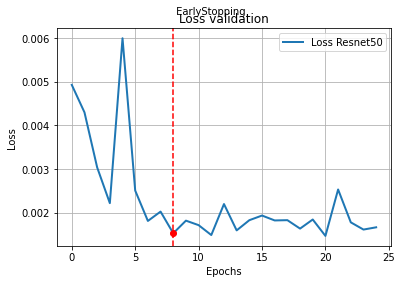

In [ ]:
## Crear Curve de perdida en entrenamiento y validación

import numpy as np
import matplotlib.pyplot as plt

xval=xx_val5_3
yval=yy_val5_3
emin=epoch_min5_3
stopv=stop_val5_3

#VGG16
plt.plot(xval,yval,linewidth=2.0, label = "Loss Resnet50")
#plt.plot(xx_val4_10,yy_val4_10,linewidth=3.0 ,color="CadetBlue", label = "Loss Vgg16 k=4")
plt.axvline(emin, ymin=0, ymax=1, linestyle="--",color="red")
#plt.axvline(epoch_min4_10, ymin=0, ymax=1, linestyle="--",color="red")
plt.plot(emin,stopv,marker="o",color="red")
#plt.plot(epoch_min4_10,stop_val4_10,marker="o",color="red")
plt.annotate(" EarlyStopping ",(emin,stopv),(emin,stopv+0.005))

plt.legend(loc="upper right")
#plt.plot(xx1,yy1,marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss validation")
#plt.axis([0,25,0,0.5])
plt.grid()
plt.savefig('loss.png',bbox_inches='tight')
plt.show()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = torch.load('/content/modelo_torch_full.pth')
    num_ftrs = model.fc.in_features  #numero de neuronas en la capa de entrada 
    model.fc = nn.Linear(num_ftrs, 2) 
    model.load_state_dict(checkpoint['state_dict'])
    return model, checkpoint['class_to_idx']
  
# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('/content/modelo_torch_1_3.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

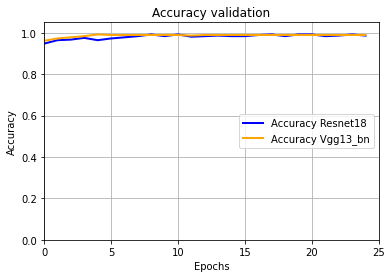

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(xx_val1_1,acc_val1_1,linewidth=2.0, color='blue', label = "Accuracy Resnet18")
plt.plot(xx_val1_4,acc_val1_4,linewidth=2.0, color='orange', label = "Accuracy Vgg13_bn")
#plt.plot(xx_val1_13,acc_val1_13,linewidth=3.0, color='yellow', label = "Accuracy Vgg19_bn k=1")
#plt.plot(xx_val4_13,acc_val4_13,linewidth=3.0, color='orange', label = "Accuracy Vgg19_bn k=4")
#plt.axvline(epoch_min, ymin=0, ymax=1, linestyle="--",color="red")
#plt.plot(epoch_min,stop_val,marker="o",color="red")
plt.legend(loc="right")
#plt.plot(xx1,yy1,marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy validation")
plt.axis([0,25,0,1.05])
plt.grid()
plt.savefig('Accuracy.png',bbox_inches='tight')
plt.show()

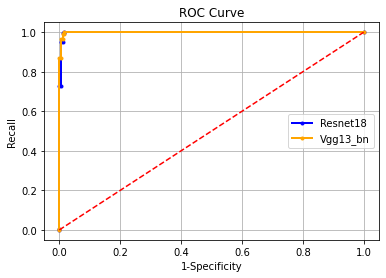

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
import numpy as np


#best_labels=best_labels.cpu()
#best_predict=best_predict.cpu()
#best_prob=best_prob.cpu()
xx=np.linspace(0,1,100)
yy=xx


lr_fpr1_1, lr_tpr1_1, _ = roc_curve(best_labels1_1, best_prob1_1)
#lr_fpr1_2, lr_tpr1_2, _ = roc_curve(best_labels1_2, best_prob1_2)
#lr_fpr1_3, lr_tpr1_3, _ = roc_curve(best_labels1_3, best_prob1_3)
lr_fpr1_4, lr_tpr1_4, _ = roc_curve(best_labels1_4, best_prob1_4)
plt.plot(lr_fpr1_1, lr_tpr1_1, marker='.', linewidth=2.0, color='blue', label='Resnet18')
#plt.plot(lr_fpr1_2, lr_tpr1_2, marker='.',  color='blue', label='Resnet101 k=4')
#plt.plot(lr_fpr1_3, lr_tpr1_3, marker='.', color='yellow', label='Vgg19_bn k=1')
plt.plot(lr_fpr1_4, lr_tpr1_4, marker='.', linewidth=2.0, color='orange', label='Vgg13_bn')
plt.plot(xx,yy, color="red",linestyle="--")
plt.xlabel("1-Specificity")
plt.ylabel("Recall")
plt.title("ROC Curve")
plt.axis([-0.05,1.05,-0.05,1.05])
plt.grid()
plt.legend(loc="right")
VP=0
FP=0
VN=0
FN=0

plt.savefig('ROC Curve.png',bbox_inches='tight')

In [ ]:
print("DATOS MODELOS RESNET")
print("\nRESNET18-1\n") 

#print("Base1")

xx_train1_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_1 = [0.350993720513803, 0.18527811382655746, 0.1445966183476978, 0.1278673944649873, 0.10570676035075276, 0.10749565220817371, 0.08560766339026116, 0.09281149349554821, 0.0861375868320465, 0.0891354222982018, 0.08448311935972284, 0.08125392080457122, 0.08932392349949589, 0.0672145418215681, 0.0834238056562565, 0.07239600865929215, 0.08487524787308993, 0.08658093591531117, 0.08937945867026294, 0.08443577296204037, 0.08321654346254137, 0.0849720882486414, 0.08532420259934885, 0.08544302781422933, 0.08286014046933916]
xx_val1_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_1 = [0.06655732810497283, 0.0321061926914586, 0.03446806525811553, 0.03663334783580568, 0.011815299663899673, 0.01767463420621223, 0.016580187307877674, 0.015034556670321358, 0.017225340047540765, 0.017727775367416647, 0.02156585607263777, 0.01863653296294312, 0.01573181344403161, 0.014837896943402788, 0.015829751551047794, 0.01574672150787794, 0.015436162023494642, 0.014323682643266188, 0.015275190237573245, 0.017996220199598206, 0.013728327001186294, 0.019704495867093403, 0.014358064039713807, 0.021404535805599558, 0.014507753969584074]
epoch_min1_1 = 4
stop_val1_1 = 0.011815299663899673

acc_train1_1 = [0.8481481481481481, 0.9266666666666666, 0.9422222222222222, 0.9533333333333333, 0.9637037037037036, 0.9592592592592593, 0.9718518518518519, 0.96, 0.9674074074074074, 0.9688888888888888, 0.9725925925925926, 0.9725925925925926, 0.971111111111111, 0.9777777777777777, 0.974074074074074, 0.9703703703703703, 0.9688888888888888, 0.9703703703703703, 0.9674074074074074, 0.9659259259259259, 0.9696296296296296, 0.9659259259259259, 0.9681481481481481, 0.9688888888888888, 0.9718518518518519]
acc_val1_1 = [0.9844444444444445, 0.9955555555555555, 0.9933333333333333, 0.9911111111111112, 0.9977777777777778, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555]

best_labels1_1 = [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
best_prob1_1 = [0.9946714043617249, 0.0017230386147275567, 0.015848686918616295, 0.9996867179870605, 0.9997767806053162, 0.9969977140426636, 0.0013710414059460163, 2.9727580113103613e-05, 0.02391156554222107, 0.999862551689148, 0.00531815504655242, 0.997250497341156, 0.9998942613601685, 0.00399447837844491, 0.0017157266847789288, 0.0025710612535476685, 0.9998762607574463, 0.005496409256011248, 0.9998688697814941, 0.9959926009178162, 0.0037846143823117018, 6.542464689118788e-06, 0.9985697269439697, 0.01176708098500967, 7.452190038748085e-05, 0.978865921497345, 0.00021971149544697255, 0.00354859814979136, 0.9974315762519836, 0.9874021410942078, 6.113448762334883e-06, 0.00014208121865522116, 0.00022509697009809315, 0.003175395308062434, 2.2864445782033727e-05, 0.9979105591773987, 0.9984654188156128, 0.9987885355949402, 0.9969146251678467, 0.9992444515228271, 0.9993725419044495, 0.9071784019470215, 0.9921689629554749, 0.9996360540390015, 0.9469825029373169, 0.006275050342082977, 0.9989767074584961, 0.9978306889533997, 0.9997720122337341, 0.9791023135185242, 0.0018595496658235788, 0.0009478917345404625, 0.0018870716448873281, 0.0019469823455438018, 0.9990857839584351, 0.9997988343238831, 0.999643087387085, 0.9996951818466187, 0.005048112943768501, 0.9791511297225952, 0.9991030693054199, 0.00037840320146642625, 0.0001951743761310354, 0.0029750436078757048, 0.9087239503860474, 0.9991621971130371, 1.8160100808017887e-05, 0.9999097585678101, 0.0018227093387395144, 0.9785635471343994, 0.07450650632381439, 0.997975766658783, 0.9955140948295593, 0.00024649500846862793, 5.8369805628899485e-05, 0.00020630302606150508, 1.1281877050350886e-05, 1.0873546671064105e-05, 0.9999433755874634, 0.3105897307395935, 0.9960468411445618, 0.9981864094734192, 0.9993026256561279, 0.9982557892799377, 0.007750628516077995, 5.3872092394158244e-05, 0.9966257810592651, 1.7210995792993344e-05, 0.9995158910751343, 7.759838626952842e-05, 0.001273325295187533, 3.249336441513151e-05, 0.003787849796935916, 4.2804334952961653e-05, 0.9994388222694397, 0.9995400905609131, 0.0003442743618506938, 5.290150147629902e-05, 0.0037721702829003334, 0.9972226619720459, 0.99552983045578, 0.9998712539672852, 0.9987207055091858, 0.9999183416366577, 0.9983605742454529, 0.0013743815943598747, 0.9715537428855896, 0.0011169438948854804, 0.0009287652792409062, 0.9983419179916382, 0.010600193403661251, 0.0002255902800243348, 0.0011896390933543444, 0.9983925223350525, 0.9992997646331787, 0.02651219442486763, 0.999392032623291, 0.0004941817023791373, 0.9996790885925293, 0.9866296052932739, 0.9771566987037659, 0.0006768357707187533, 0.0003850091597996652, 4.875687955063768e-05, 0.9976748824119568, 0.0012897655833512545, 0.9990423321723938, 0.9724370837211609, 5.713271207241633e-07, 0.999792754650116, 0.00015943885955493897, 0.2982982099056244, 0.006333583500236273, 0.027038153260946274, 0.0011189518263563514, 0.018376043066382408, 0.9963704347610474, 0.01121043786406517, 0.9999309778213501, 0.0030307872220873833, 0.9889042973518372, 5.012192559661344e-05, 0.9985646605491638, 0.0007586331921629608, 0.0005660199676640332, 0.998925507068634, 0.9973090887069702, 0.9999462366104126, 0.999234676361084, 0.9956170320510864, 0.9780991673469543, 2.861115717678331e-05, 0.00043810505303554237, 0.9993168115615845, 0.9905924201011658, 8.58847561175935e-05, 0.00017032035975717008, 0.0008614282123744488, 0.997772753238678, 0.0006807388854213059, 0.9996274709701538, 0.00038624697481282055, 5.558118209592067e-05, 0.9760252237319946, 0.9950454235076904, 0.2203681915998459, 0.0005105023737996817, 0.9992324113845825, 0.9992907047271729, 0.9999204874038696, 0.9956660270690918, 0.014417450875043869, 0.9990068078041077, 0.0005429164157249033, 0.9994487166404724, 0.002745207166299224, 0.004666860681027174, 0.0013414889108389616, 0.9980456829071045, 0.9998452663421631, 0.0004056573088746518, 0.00010469892004039139, 0.9992444515228271, 0.9906533360481262, 0.9998359680175781, 0.9915534853935242, 0.0007366014760918915, 0.04499651864171028, 0.9987598657608032, 0.9968217611312866, 0.9989035129547119, 0.02193676307797432, 0.00018085091141983867, 0.00020814946037717164, 0.9983165264129639, 0.9998785257339478, 0.9907909631729126, 0.0006671217852272093, 0.5355042219161987, 0.9982978701591492, 0.9996452331542969, 0.00019586623238865286, 0.991361677646637, 0.0001597127557033673, 0.992164134979248, 0.9980247020721436, 0.0007145481067709625, 0.000842821435071528, 0.9990377426147461, 0.9112449288368225, 0.9988262057304382, 0.965954065322876, 0.9998674392700195, 0.0001929922291310504, 1.021573189063929e-05, 0.9995267391204834, 0.8755606412887573, 0.9934784173965454, 0.997760534286499, 0.00024346509599126875, 9.47283479035832e-05, 0.005126204341650009, 0.9994576573371887, 0.9991206526756287, 0.0002851887547876686, 0.9997708201408386, 0.9990038275718689, 0.0003411001816857606, 0.000350706628523767, 0.9999088048934937, 0.999958872795105, 0.9999949932098389, 0.995707094669342, 0.015595047734677792, 0.9998613595962524, 0.003861410077661276, 4.918576451018453e-06, 1.1726706361514516e-05, 0.9501199126243591, 0.00011501472909003496, 0.020867811515927315, 0.9974695444107056, 0.9962414503097534, 0.9997542500495911, 0.0012691909214481711, 0.9993927478790283, 0.9999028444290161, 0.9973170161247253, 0.000474204687634483, 0.9974833130836487, 0.9994114637374878, 1.559372503834311e-05, 0.9983137845993042, 0.0008231104002334177, 0.008073893375694752, 0.9996504783630371, 0.0009185051312670112, 0.9995681643486023, 0.9995272159576416, 0.9986566305160522, 0.0015259250067174435, 0.9988007545471191, 0.0034950552508234978, 0.00024598598247393966, 0.0006007138290442526, 0.0008071869960986078, 0.0024367664009332657, 0.014983846805989742, 3.08830822177697e-05, 0.9997856020927429, 0.9994335770606995, 0.9939675331115723, 0.9996341466903687, 0.0007426631054840982, 0.002388715511187911, 0.9666623473167419, 0.9932501316070557, 0.005902968347072601, 0.997543215751648, 0.9988778233528137, 0.023278649896383286, 0.004145326558500528, 0.9939857125282288, 0.9949382543563843, 0.012613613158464432, 0.007796757854521275, 0.9783341884613037, 0.9996511936187744, 0.9999790191650391, 0.219320148229599, 0.9833936095237732, 0.9998294115066528, 0.9998955726623535, 6.0668236983474344e-05, 0.9992813467979431, 0.9979972243309021, 0.9941285848617554, 0.9845477938652039, 0.9901913404464722, 0.00015719518705736846, 0.9998767375946045, 0.00017552266945131123, 0.9996979236602783, 0.9994421601295471, 0.9848417043685913, 0.0007553891045972705, 0.9877986311912537, 0.14344476163387299, 0.998359739780426, 4.325865575083299e-06, 0.9800129532814026, 2.3202640022645937e-06, 0.0011744267540052533, 0.004379820078611374, 5.762987257185159e-06, 0.000405206490540877, 3.8881058571860194e-05, 0.003595850197598338, 0.9996175765991211, 0.9998428821563721, 4.6128050598781556e-05, 0.000823873037006706, 0.999884843826294, 0.06644917279481888, 8.325823000632226e-05, 0.0018750660819932818, 0.9981812238693237, 0.9960684776306152, 0.9959235191345215, 2.5868170268950053e-05, 0.00013066735118627548, 0.9998157620429993, 0.00014017986541148275, 0.9980689883232117, 0.004794522654265165, 0.9998030066490173, 0.9999754428863525, 0.0006553589482791722, 0.0022900172043591738, 0.00016616420180071145, 0.9996432065963745, 0.0004205710138194263, 0.9999290704727173, 0.0005556200630962849, 0.9998370409011841, 0.9833365082740784, 3.1845767807681113e-05, 0.0011143145384266973, 1.907987279992085e-05, 0.9996751546859741, 0.018094569444656372, 0.0004656642850022763, 0.0006608683615922928, 0.9991733431816101, 0.9998462200164795, 0.00018147275841329247, 0.9872433543205261, 0.013263373635709286, 6.705852865707129e-05, 0.001019546645693481, 0.012047471478581429, 0.000397804455133155, 1.0265383025398478e-05, 0.9999457597732544, 0.0020930126775056124, 0.0002254208520753309, 0.003246799809858203, 0.9975284934043884, 0.9995154142379761, 0.0026636687107384205, 0.9976829290390015, 0.0019786900375038385, 0.9993019104003906, 0.9770834445953369, 0.997734785079956, 0.9974371194839478, 0.9986374974250793, 0.9992827773094177, 0.9986032843589783, 0.00038305780617520213, 0.00029090928728692234, 0.006929326336830854, 0.9990884065628052, 4.4898864871356636e-05, 0.9967259168624878, 2.2195874407771043e-05, 0.9868502616882324, 0.9999336004257202, 0.003278320888057351, 0.99972003698349, 0.00041122862603515387, 0.9997889399528503, 0.9994230270385742, 5.380175934988074e-05, 0.0004687306936830282, 0.00928445439785719, 0.0001938993518706411, 3.385311720194295e-05, 0.00012661732034757733, 0.0012179294135421515, 0.9940811991691589, 0.0002905860892497003, 0.00018753598851617426, 0.002687746426090598, 0.0021279361099004745, 0.990567147731781, 0.00018722315144259483, 0.9998514652252197, 0.9994269609451294, 0.0010046608513221145, 0.9918728470802307, 0.9997805953025818, 0.9512040019035339, 0.001419374137185514, 0.0017825679387897253, 0.0047151995822787285, 2.9311648177099414e-05, 0.9960783123970032, 0.00017632803064770997, 6.329392635961995e-05, 0.9928665161132812, 8.245830395026132e-05, 0.0011790817370638251, 0.9975704550743103, 0.00155551522038877, 0.0006195587338879704, 0.9951122403144836, 0.0023204961325973272, 0.005977580789476633, 0.05839112401008606, 0.9209044575691223, 3.681915404740721e-05, 0.00023073452757671475, 0.9997987151145935, 0.001580997253768146, 0.015984129160642624, 1.63823915499961e-05, 0.8390220403671265, 0.003923414275050163, 0.9994970560073853, 0.0015039278659969568, 0.9912570714950562, 0.9999233484268188, 0.0009426379692740738, 0.9990407824516296, 0.9998761415481567, 2.9637109037139453e-05, 0.0006351019255816936, 0.9997196793556213, 0.0003293272166047245]

Best_acc1_1 = 0.9977777777777778
Recall1_1 = 1.0
Especificidad1_1 = 0.995575221238938


prom1=(Best_acc1_1+Best_acc2_1+Best_acc3_1+Best_acc4_1)/4
promrec1=(Recall1_1+Best_acc2_1+Best_acc3_1+Best_acc4_1)/4
promesp1=(Especificidad1_1+Especificidad2_1+Especificidad3_1+Especificidad4_1)/4
promearlyStop1=(epoch_min1_1+epoch_min2_1+epoch_min3_1+epoch_min4_1)/4
print("Stop "+str(promearlyStop1))


In [ ]:

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    


prom1=(Best_acc1_1+Best_acc2_1+Best_acc3_1+Best_acc4_1+Best_acc5_1)/5
prom2=(Best_acc1_2+Best_acc2_2+Best_acc3_2+Best_acc4_2+Best_acc5_2)/5
prom3=(Best_acc1_3+Best_acc2_3+Best_acc3_3+Best_acc4_3+Best_acc5_3)/5
prom4=(Best_acc1_4+Best_acc2_4+Best_acc3_4+Best_acc4_4+Best_acc5_4)/5
prom5=(Best_acc1_5+Best_acc2_5+Best_acc3_5+Best_acc4_5+Best_acc5_5)/5

print("\nAccuracy\n")
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom1, Best_acc1_1, Best_acc2_1, Best_acc3_1, Best_acc4_1, Best_acc5_1))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom2, Best_acc1_2, Best_acc2_2, Best_acc3_2, Best_acc4_2, Best_acc5_2))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom3, Best_acc1_3, Best_acc2_3, Best_acc3_3, Best_acc4_3, Best_acc5_3))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom4, Best_acc1_4, Best_acc2_4, Best_acc3_4, Best_acc4_4, Best_acc5_4))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom5, Best_acc1_5, Best_acc2_5, Best_acc3_5, Best_acc4_5, Best_acc5_5))


promrec1=(Recall1_1+Recall2_1+Recall3_1+Recall4_1+Recall5_1)/5
promrec2=(Recall1_2+Recall2_2+Recall3_2+Recall4_2+Recall5_2)/5
promrec3=(Recall1_3+Recall2_3+Recall3_3+Recall4_3+Recall5_3)/5
promrec4=(Recall1_4+Recall2_4+Recall3_4+Recall4_4+Recall5_4)/5
promrec5=(Recall1_5+Recall2_5+Recall3_5+Recall4_5+Recall5_5)/5

promesp1=(Especificidad1_1+Especificidad2_1+Especificidad3_1+Especificidad4_1+Especificidad5_1)/5
promesp2=(Especificidad1_2+Especificidad2_2+Especificidad3_2+Especificidad4_2+Especificidad5_2)/5
promesp3=(Especificidad1_3+Especificidad2_3+Especificidad3_3+Especificidad4_3+Especificidad5_3)/5
promesp4=(Especificidad1_4+Especificidad2_4+Especificidad3_4+Especificidad4_4+Especificidad5_4)/5
promesp5=(Especificidad1_5+Especificidad2_5+Especificidad3_5+Especificidad4_5+Especificidad5_5)/5
#print("\n")
print("\nMetricas\n")
print("{:.4f} {:.4f} {:.4f}" .format(prom1, promrec1, promesp1))
print("{:.4f} {:.4f} {:.4f}" .format(prom2, promrec2, promesp2))
print("{:.4f} {:.4f} {:.4f}" .format(prom3, promrec3, promesp3))
print("{:.4f} {:.4f} {:.4f}" .format(prom4, promrec4, promesp4))
print("{:.4f} {:.4f} {:.4f}" .format(prom5, promrec5, promesp5))


promearlyStop1=(epoch_min1_1+epoch_min2_1+epoch_min3_1+epoch_min4_1+epoch_min5_1)/5
promearlyStop2=(epoch_min1_2+epoch_min2_2+epoch_min3_2+epoch_min4_2+epoch_min5_2)/5
promearlyStop3=(epoch_min1_3+epoch_min2_3+epoch_min3_3+epoch_min4_3+epoch_min5_3)/5
promearlyStop4=(epoch_min1_4+epoch_min2_4+epoch_min3_4+epoch_min4_4+epoch_min5_4)/5
promearlyStop5=(epoch_min1_5+epoch_min2_5+epoch_min3_5+epoch_min4_5+epoch_min5_5)/5

print("\nEpocas {:.0f} {:.0f} {:.0f} {:.0f} {:.0f}" .format(promearlyStop1, promearlyStop2, promearlyStop3, promearlyStop4, promearlyStop5))

tiempo1=(Tiempo1_1+Tiempo2_1+Tiempo3_1+Tiempo4_1+Tiempo5_1)/5
tiempo2=(Tiempo1_2+Tiempo2_2+Tiempo3_2+Tiempo4_2+Tiempo5_2)/5
tiempo3=(Tiempo1_3+Tiempo2_3+Tiempo3_3+Tiempo4_3+Tiempo5_3)/5
tiempo4=(Tiempo1_4+Tiempo2_4+Tiempo3_4+Tiempo4_4+Tiempo5_4)/5
tiempo5=(Tiempo1_5+Tiempo2_5+Tiempo3_5+Tiempo4_5+Tiempo5_5)/5

print("\nTiempo {:.0f} {:.0f} {:.0f} {:.0f} {:.0f}" .format(tiempo1, tiempo2, tiempo3, tiempo4, tiempo5))
print("\nTiempo {:.0f} {:.0f} {:.0f} {:.0f} {:.0f}" .format(tiempo1/25*promearlyStop1, tiempo2/25*promearlyStop2, tiempo3/25*promearlyStop3, tiempo4/25*promearlyStop4, tiempo5/25*promearlyStop5))



Accuracy

0.9950 0.9917 0.9833 1.0000 1.0000 1.0000
0.9939 0.9750 0.9944 1.0000 1.0000 1.0000
0.9950 0.9861 0.9889 1.0000 1.0000 1.0000
0.9950 0.9861 0.9917 0.9972 1.0000 1.0000
0.9956 0.9861 0.9917 1.0000 1.0000 1.0000

Metricas

0.9950 0.9923 0.9978
0.9939 0.9902 0.9977
0.9950 0.9955 0.9945
0.9950 0.9923 0.9978
0.9956 0.9934 0.9978

Epocas 5 5 4 5 6

Tiempo 316 341 506 766 1054

Tiempo 63 68 85 153 236


In [ ]:
######## Base1 ########
#MODELO = VGG13
#Datos perdidas
xx_train1_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_3 = [0.28229752282301585, 0.11739744962089592, 0.1145356179939376, 0.08167482833895419, 0.09516583453449938, 0.05567536618974474, 0.050679383758041596, 0.04908870698677169, 0.048901026364829805, 0.04837841397772233, 0.057619009125563836, 0.0530603934907251, 0.05841220170259476, 0.058170703715748256, 0.048420947500401074, 0.04870942085981369, 0.048865419998764995, 0.057036789444585644, 0.05201462681094805, 0.05733283311128616, 0.05255933474335406, 0.05139481719169352, 0.055183394336038166, 0.044817791485952004, 0.055731714558270244]
xx_val1_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_3 = [0.10684885813130272, 0.10633846786287096, 0.060769879155688815, 0.07231123993794124, 0.0607873057325681, 0.053661428060796525, 0.05060238093137741, 0.049616475900014244, 0.049445067014959126, 0.04861333535777198, 0.04860843171676, 0.0485315395726098, 0.04846020142237346, 0.04832098450925615, 0.048230770064724815, 0.04822931223445469, 0.048225097358226776, 0.048220514092180464, 0.048218392332394916, 0.04821544239918391, 0.04821537898646461, 0.048215162422921926, 0.04821506573094262, 0.04821510894431008, 0.04821515348222521]
epoch_min1_3 = 5
stop_val1_3 = 0.053661428060796525

#Datos accuracy
acc_train1_3 = [0.8972222222222223, 0.9576388888888889, 0.9569444444444445, 0.9694444444444444, 0.9652777777777778, 0.9791666666666667, 0.9791666666666667, 0.9833333333333334, 0.9847222222222223, 0.9812500000000001, 0.976388888888889, 0.9784722222222223, 0.976388888888889, 0.976388888888889, 0.9861111111111112, 0.982638888888889, 0.9798611111111112, 0.9750000000000001, 0.9798611111111112, 0.976388888888889, 0.9812500000000001, 0.9791666666666667, 0.9798611111111112, 0.9847222222222223, 0.9777777777777779]
acc_val1_3 = [0.9416666666666667, 0.9583333333333334, 0.9777777777777779, 0.9694444444444444, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779]

#Datos curva ROC
best_labels1_3 = [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]
best_prob1_3 = [0.9990088939666748, 0.9998936653137207, 0.9993298053741455, 1.4929722055967432e-05, 0.9989687204360962, 0.0238625630736351, 0.9999148845672607, 0.11120227724313736, 0.9968428611755371, 0.9996615648269653, 0.003364547388628125, 0.0005742364446632564, 9.81925186351873e-05, 1.0382303372580282e-07, 0.9944460391998291, 0.9942367076873779, 0.9977922439575195, 3.3689242801698827e-12, 6.332249540719204e-06, 0.9979681372642517, 8.586356443629484e-07, 0.9908409118652344, 0.9908512234687805, 3.8587364770137356e-07, 0.0005679823225364089, 0.994059681892395, 1.4462318631558446e-07, 1.5998483604562352e-06, 1.1224592526559718e-05, 8.083554234872281e-07, 4.2448686343732334e-08, 8.672522966435281e-08, 2.4235171167674707e-06, 0.9894556403160095, 0.9973233342170715, 0.9959120750427246, 0.999187171459198, 2.493946112736012e-06, 0.9918718338012695, 0.06764575839042664, 4.262303576751947e-08, 0.0009781793924048543, 1.9338986021466553e-06, 7.967810233822092e-05, 0.009919465519487858, 0.9946869611740112, 0.9663318395614624, 0.9966428279876709, 0.9992307424545288, 8.772573346504942e-05, 0.00031939049949869514, 0.06581512093544006, 1.0244664491732003e-11, 0.9828429818153381, 3.378936298759072e-06, 0.9989558458328247, 3.9731498873152304e-06, 0.9817129969596863, 1.968724627765539e-10, 0.9992260932922363, 7.443623495362317e-09, 7.223006637246954e-09, 0.5936455726623535, 0.003305261256173253, 0.9993846416473389, 0.9823822379112244, 0.011003494262695312, 0.006732045207172632, 0.0014613847015425563, 0.9963675737380981, 0.0018679731292650104, 0.9994221925735474, 1.6357592613758243e-08, 0.997821569442749, 0.9817450642585754, 3.2739338583914757e-13, 3.107798818291485e-08, 0.00036029008333571255, 7.097701745806262e-05, 1.167018672276754e-05, 0.9917353391647339, 0.9877639412879944, 0.9897456169128418, 0.020786592736840248, 0.9878548979759216, 0.9731680154800415, 0.593816339969635, 0.9919605851173401, 1.3423301936654752e-07, 0.9957887530326843, 0.005390436388552189, 0.9789831638336182, 0.9969469904899597, 3.8412914515895125e-10, 0.9992378950119019, 0.9877744317054749, 0.9868369102478027, 2.050720553370411e-07, 1.5748944861115888e-05, 0.9991554021835327, 0.9766531586647034, 0.8461681604385376, 0.9870874881744385, 0.044308099895715714, 2.4542497811808062e-08, 0.9915447235107422, 0.005774759687483311, 0.3741527795791626, 2.0812422008020803e-05, 0.9996193647384644, 1.9348144633113407e-05, 1.2123085070925299e-05, 0.9988164901733398, 2.6486955903237686e-05, 0.9956989288330078, 1.639995517166426e-08, 7.206877761234409e-09, 1.4207332199589473e-08, 0.9917620420455933, 0.9998106360435486, 0.0012774743372574449, 0.009962582029402256, 3.3691943457370144e-08, 1.0916584614051317e-07, 0.017254143953323364, 3.315195135655813e-05, 0.9994342923164368, 0.9909088015556335, 0.9999892711639404, 0.9694212675094604, 0.963080108165741, 6.092467641494181e-10, 0.9979175925254822, 0.9948369264602661, 0.999596893787384, 0.030565176159143448, 0.9958658218383789, 0.02763664536178112, 0.9877153038978577, 0.9976800084114075, 0.99847811460495, 2.897520445799273e-09, 4.562710653743807e-09, 0.7732540369033813, 0.0006552939303219318, 1.8552469283061868e-10, 0.9977050423622131, 0.994785726070404, 1.037325091601815e-05, 0.9974057078361511, 2.0023469549101947e-09, 2.2853503196529346e-06, 0.9984446167945862, 5.086618770633322e-08, 9.468132056156264e-09, 7.405377982649952e-05, 0.9991003274917603, 0.9896947145462036, 0.9539058804512024, 4.367223880308302e-07, 8.893201908222181e-08, 0.9972816705703735, 0.9996453523635864, 8.828640574165547e-08, 8.270463877124712e-05, 0.9965806603431702, 0.994265615940094, 0.9969807267189026, 0.00037511694245040417, 0.9980435371398926, 0.9993436932563782, 1.2235998880782972e-08, 1.1089190010693528e-08, 0.985943078994751, 5.736308594350703e-05, 0.38825854659080505, 1.0320646651962306e-05, 0.9949047565460205, 3.6539634606924665e-07, 4.6226821837080934e-07, 0.9998950958251953, 0.44130009412765503, 2.9225833486634656e-07, 1.2022974615888415e-08, 0.9982934594154358, 1.5639241155440686e-06, 0.9993516802787781, 0.9981135129928589, 0.9977489113807678, 0.9996377229690552, 0.002927327761426568, 0.0005508426111191511, 0.5435584783554077, 0.9968681931495667, 0.6638436913490295, 0.9877533316612244, 0.9664538502693176, 0.9746074080467224, 1.7587864498125327e-09, 0.9611651301383972, 0.7639371752738953, 0.9932565689086914, 6.952735609466743e-10, 0.9257831573486328, 0.9964937567710876, 0.9989014863967896, 1.1891835960398112e-08, 3.439256761339493e-05, 8.759504926958428e-11, 1.8366889662502217e-06, 1.0410722097731195e-05, 4.445089984983497e-07, 1.3845124158251565e-07, 0.9968609809875488, 0.0002287480019731447, 1.3377188246010974e-08, 2.394640041814e-09, 0.9849613904953003, 0.9995133876800537, 0.9959208965301514, 1.3819647392665502e-05, 0.9914788603782654, 1.2265451154735985e-10, 2.563999714766396e-06, 4.684252871811623e-06, 7.464776019538988e-10, 0.9925780892372131, 1.759584145055726e-10, 3.5667924169757725e-09, 0.0035951838362962008, 9.421012691746e-06, 0.9980775117874146, 0.00037424894981086254, 5.0696224995760986e-11, 0.999103307723999, 0.991967499256134, 0.9888935685157776, 1.9800560039584525e-05, 0.9984344840049744, 0.9911490678787231, 0.9976140260696411, 0.995396077632904, 0.998699426651001, 2.032390966633102e-08, 0.4334912598133087, 0.8096804618835449, 0.9974863529205322, 0.995090126991272, 3.166937858622987e-07, 0.9976146221160889, 0.0025004916824400425, 0.9995003938674927, 0.16353093087673187, 1.4530158978232066e-06, 0.9864476919174194, 0.006177996285259724, 4.1804570916070816e-10, 0.9987533092498779, 9.512103133602068e-05, 0.9999328851699829, 0.9986332058906555, 0.9973862767219543, 1.6088317352114245e-05, 0.99933260679245, 1.6974130989666492e-09, 0.993645429611206, 8.959867292546164e-10, 2.3701033569523133e-05, 0.9884364604949951, 0.001123820897191763, 0.9945317506790161, 0.9915947318077087, 0.006101710721850395, 0.9970575571060181, 0.9998114705085754, 0.9996933937072754, 2.089216133427385e-09, 0.9991955161094666, 0.9990788698196411, 0.3634635806083679, 0.9948068261146545, 0.9933597445487976, 3.2790342174848774e-06, 5.4307591199176386e-05, 0.999852180480957, 0.031670019030570984, 0.9952927827835083, 3.369020973309489e-08, 0.9983373880386353, 0.9924235343933105, 0.0036936532706022263, 0.9984082579612732, 8.062612550929771e-07, 0.991479218006134, 0.9827526807785034, 9.954604918149812e-10, 0.9967988729476929, 0.9734492897987366, 1.1824744433397427e-05, 0.9970431923866272, 0.0002525259624235332, 1.1396458830859046e-05, 0.9555372595787048, 0.006589003838598728, 1.7740244402375538e-06, 1.6277458314561954e-07, 0.9955281615257263, 2.8817051175855646e-11, 0.004277510102838278, 0.9968342185020447, 0.9971972703933716, 0.9740235209465027, 7.17061757193882e-11, 0.9626054763793945, 1.1616966730798595e-05, 0.8346788287162781, 2.6330968694310286e-07, 0.9943047165870667, 1.6947215852880504e-09, 0.0001683173031779006, 0.14886054396629333, 0.9993355870246887, 0.7857944965362549, 8.694849640278335e-08, 2.23741225546803e-09, 0.9876002073287964, 0.028552865609526634, 0.9920748472213745, 5.5608579714316875e-06, 0.9973650574684143, 1.4588082194677554e-05, 2.54518198516962e-07, 0.9947356581687927, 0.9997081160545349, 0.9997791647911072, 0.9937283992767334, 0.9587555527687073, 0.00048675626749172807, 6.419230658138986e-08, 0.0010758854914456606, 0.9974825978279114, 0.9993354678153992, 0.9822641015052795, 7.746335484171141e-08, 0.14752531051635742, 0.00013087371189612895, 0.007807030342519283, 0.9980521202087402, 0.9931983351707458, 0.9769294857978821, 0.999751627445221, 0.0005121446447446942, 0.9993255138397217, 0.9811210036277771, 0.9992315769195557, 2.9725949701742138e-08, 0.9988322854042053, 1.783113923181645e-08, 5.625612402582192e-07, 0.9998008608818054]

#Metricas de validación
Best_acc1_3 = 0.9750000000000001
acc_aux1_3 = 0.9861111111111112
Recall1_3 = 0.9723756906077348
Especificidad1_3 = 0.9776536312849162
Tiempo1_3 = 379.8018043041229

######## Base2 ########
#MODELO = VGG13
#Datos perdidas
xx_train2_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_3 = [0.1127930135362678, 0.11870153608421484, 0.07046978763408131, 0.05462801475077868, 0.05712192849152618, 0.04010101370513439, 0.03434049884478251, 0.03653871553639571, 0.03054635323998001, 0.02933220271435049, 0.030074641770786708, 0.03374776403523154, 0.0305844373587105, 0.02494399632430739, 0.04104222369690736, 0.034735035772124924, 0.028838260906438033, 0.03849632742090358, 0.03359314697898096, 0.03363168837709559, 0.033852338646021156, 0.03506219728539387, 0.025583198997709486, 0.03396937598784765, 0.04050995771669679]
xx_val2_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_3 = [0.03090102987156974, 0.1440817630953259, 0.03334259672297372, 0.062416461441251965, 0.04528425484895706, 0.03740739242898093, 0.03323024213314056, 0.03193469610479143, 0.03282997343275282, 0.031935880250400964, 0.03187098387214873, 0.03187067343129052, 0.03182813177506129, 0.03179456144571304, 0.03173203683561749, 0.03172568894094891, 0.031722858051458996, 0.03171956737836202, 0.03172004421552022, 0.03171729313002692, 0.03171725057893329, 0.0317172603474723, 0.03171726382440991, 0.031717282864782544, 0.031717201239532894]
epoch_min2_3 = 0
stop_val2_3 = 0.03090102987156974

#Datos accuracy
acc_train2_3 = [0.9506944444444445, 0.9576388888888889, 0.9756944444444445, 0.9791666666666667, 0.9777777777777779, 0.9881944444444445, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9881944444444445, 0.9895833333333334, 0.9868055555555556, 0.9868055555555556, 0.9930555555555556, 0.9875, 0.9875, 0.9888888888888889, 0.9881944444444445, 0.9909722222222223, 0.9881944444444445, 0.9868055555555556, 0.9888888888888889, 0.9909722222222223, 0.9888888888888889, 0.9847222222222223]
acc_val2_3 = [0.9916666666666667, 0.9555555555555556, 0.9888888888888889, 0.9833333333333334, 0.9777777777777779, 0.9805555555555556, 0.9833333333333334, 0.9861111111111112, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334]

#Datos curva ROC
best_labels2_3 = [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
best_prob2_3 = [0.999665379524231, 0.9900798797607422, 7.258537033146689e-14, 1.2769538759727084e-09, 1.7407010091119446e-05, 0.9990308284759521, 7.170549570778562e-11, 0.9973573088645935, 0.00024044266319833696, 0.9826851487159729, 0.9972746968269348, 2.8484989922361592e-09, 0.9587032198905945, 0.996861457824707, 0.9978984594345093, 0.995412290096283, 0.9983953833580017, 0.9931521415710449, 4.679903042870137e-08, 2.738457396844751e-06, 0.9994667172431946, 4.6901368205842786e-11, 0.003353539388626814, 1.455887493895247e-12, 0.941161036491394, 0.9972782731056213, 3.3622427508817054e-07, 0.966510534286499, 0.9972347617149353, 0.9551196694374084, 2.233712059762638e-08, 0.005958049092441797, 5.091551044845858e-15, 0.999356210231781, 6.1136707675546464e-12, 0.9971032738685608, 1.3402736840362195e-06, 3.410938415396303e-12, 1.2837892970907205e-09, 0.9995694756507874, 1.9902523490600288e-05, 0.9968852400779724, 0.9995564818382263, 1.911869986770398e-07, 0.9997826218605042, 3.333666143134906e-08, 0.99722820520401, 0.9999936819076538, 0.9897226095199585, 3.6886322618556733e-07, 0.0007749895448796451, 0.9500974416732788, 0.0001500145299360156, 2.6985681245150772e-08, 0.9949259757995605, 0.992609441280365, 0.9992992877960205, 0.012860164046287537, 0.7942480444908142, 0.44839155673980713, 2.1759021819889313e-06, 0.999665379524231, 0.011162267066538334, 0.9980601668357849, 0.9832725524902344, 0.9371711015701294, 0.010031833313405514, 0.0011231278767809272, 5.077415154985943e-10, 0.9999622106552124, 0.22163841128349304, 0.988404393196106, 0.998809814453125, 1.5368465028586797e-05, 1.5232964187816833e-06, 0.04351866990327835, 0.9617024064064026, 0.9991424083709717, 0.9946886301040649, 1.2769538759727084e-09, 1.57856908100662e-10, 0.9943660497665405, 0.9969432950019836, 9.989497584683704e-08, 0.5227068662643433, 3.6909313383404196e-09, 0.9755644202232361, 0.0025948972906917334, 0.9991706609725952, 0.9471163153648376, 0.991397500038147, 2.822952427372627e-10, 0.000126732571516186, 7.982818572838113e-11, 0.9696871042251587, 1.7543666217534337e-06, 8.396960765821859e-05, 0.9877025485038757, 4.12032052921063e-09, 0.00018136239668820053, 0.9970046877861023, 7.519104110542685e-05, 0.9733326435089111, 6.661830553866821e-08, 4.060113356629813e-11, 1.62165804340475e-07, 0.006385331507772207, 0.9884923696517944, 0.00011458057997515425, 0.9934129118919373, 1.3575827573220067e-08, 0.0003008660569321364, 0.9035072922706604, 0.9995200634002686, 1.0281637514708564e-05, 0.9951613545417786, 0.9992908239364624, 0.8437309861183167, 6.718545164652312e-10, 0.9779912829399109, 0.9989455342292786, 1.9725760580513452e-07, 1.8317389827160468e-09, 0.999354898929596, 0.9921979308128357, 0.980582058429718, 3.56902546872181e-16, 2.411081914033275e-05, 0.2796967327594757, 8.558333502151072e-05, 0.9710685610771179, 0.9979953765869141, 0.0013886443339288235, 4.281434148184493e-12, 0.8867592811584473, 3.889423396685743e-07, 0.9971953630447388, 1.686221440255764e-10, 0.0020121848210692406, 0.9861354827880859, 2.214460614879954e-09, 0.9592111110687256, 0.0017995343077927828, 1.2246397091075778e-05, 0.9883135557174683, 1.0820332185801362e-08, 0.9925974607467651, 0.9868693947792053, 7.230701015714658e-08, 0.9997981190681458, 0.9727276563644409, 0.9994640946388245, 0.9909147024154663, 1.694925977346884e-08, 1.1528958054896066e-07, 1.6863276053324938e-10, 0.0002745234814938158, 2.819911804063935e-10, 0.0006367407040670514, 0.9977976083755493, 1.3492121979652438e-06, 0.9947858452796936, 0.0012136069126427174, 5.951259485215132e-09, 0.9973982572555542, 2.19045812599461e-08, 0.9988330006599426, 0.9999520778656006, 0.9997116923332214, 0.9743806719779968, 0.9988954067230225, 0.9972391128540039, 1.1095827590068552e-09, 1.130832982809693e-09, 0.9950578212738037, 9.658871249484946e-07, 0.9939641356468201, 0.9787613153457642, 0.9994686245918274, 2.182004577022667e-09, 0.9773762226104736, 0.9644124507904053, 0.9992313385009766, 0.0007000495679676533, 0.9972541928291321, 0.9914440512657166, 1.8574368709778355e-08, 0.999967098236084, 0.9669708013534546, 0.09892119467258453, 0.9810940027236938, 2.2359590730047785e-05, 0.9994315505027771, 0.0015636768657714128, 0.9990668892860413, 2.72239066845259e-08, 5.51528000869439e-06, 0.991807758808136, 0.015397780574858189, 4.561641862854682e-12, 0.9336047768592834, 0.9138669967651367, 1.7399734431045033e-10, 0.9430266618728638, 0.010139482095837593, 4.702990281657549e-06, 8.613408681412693e-06, 1.0929247764579486e-06, 0.8891013264656067, 0.9280382394790649, 0.029155420139431953, 0.0006673586321994662, 0.9954553842544556, 0.9722315073013306, 5.735709507348474e-08, 0.9864858388900757, 0.9924071431159973, 5.39364906904094e-12, 3.3500632823368903e-10, 3.0965061070808986e-10, 0.9891884922981262, 0.9955363273620605, 0.975335955619812, 0.9946011304855347, 1.425161855195256e-07, 0.9923458099365234, 0.00011525218724273145, 4.702076694229618e-05, 5.234290156863608e-08, 0.00010219114483334124, 0.9955275654792786, 7.717227551440331e-11, 4.155947408435168e-07, 0.007511540781706572, 0.00044444581726565957, 0.9960455298423767, 0.8240140676498413, 1.6397648039401247e-07, 5.024424353905488e-06, 0.9985955357551575, 5.858482836629264e-07, 8.169477041519713e-06, 0.9971904158592224, 1.5799011521266948e-07, 0.9834668040275574, 6.557526743833364e-11, 0.9985432624816895, 0.00016110370052047074, 0.9138472676277161, 0.9886012673377991, 0.9121108651161194, 4.271663200938747e-08, 5.870271735375354e-08, 0.995087206363678, 0.9972163438796997, 0.9849354028701782, 2.4431026304228e-06, 7.452493264281657e-06, 3.7968846816616164e-11, 0.6198207139968872, 1.0398926164612021e-08, 0.9955487251281738, 0.0002665238862391561, 0.12007663398981094, 0.9996582269668579, 6.759938386835529e-09, 0.9990538954734802, 0.9896916747093201, 0.992668628692627, 9.916348631122673e-09, 0.9906314611434937, 0.0007889771950431168, 0.0047431462444365025, 0.9932013154029846, 0.9994356036186218, 1.0154668772521802e-11, 3.3374376471329015e-06, 0.9948166012763977, 0.15619245171546936, 0.9995959401130676, 0.9994339346885681, 0.9996322393417358, 0.923273503780365, 0.9685782194137573, 0.9997298121452332, 0.9933265447616577, 1.2664125303984974e-09, 5.774424341464801e-12, 5.284234421559786e-12, 0.8977821469306946, 0.9848992824554443, 1.8896687834057957e-05, 0.9407145977020264, 5.028534554897546e-13, 1.1036774161254925e-08, 0.04901154339313507, 5.002821507754662e-12, 0.9999812841415405, 1.6303254579685955e-10, 0.9260036945343018, 1.1577994812883574e-10, 0.6753298044204712, 3.321470598560694e-10, 0.9983575940132141, 0.981191098690033, 1.4395450109727648e-10, 0.9982831478118896, 0.9968456625938416, 0.8307381868362427, 0.9999831914901733, 0.9998714923858643, 0.004484023433178663, 0.9994915723800659, 6.71285804720867e-10, 0.9980300068855286, 2.6122810511952643e-12, 0.9977916479110718, 0.9769733548164368, 0.2123376429080963, 6.265382770974728e-14, 0.9865317940711975, 2.5767569240997545e-05, 2.669302602953394e-06, 0.9949746131896973, 7.023717785159533e-07, 0.0007326816557906568, 0.9939072728157043, 1.4249234681074086e-08, 0.9851534366607666, 4.812645215679368e-07, 0.9870644807815552, 9.876304635225708e-11, 4.6284271554286605e-11, 0.9952865839004517, 0.9805136322975159, 0.9999462366104126, 0.9898608922958374, 8.850401965118659e-13, 0.3137475252151489, 4.5343091414906667e-07, 2.4588345248766075e-10, 0.9979933500289917, 7.224752334877849e-05, 3.4346954533998053e-12, 9.954363804354216e-07, 0.00035691619268618524, 0.9821816086769104, 0.00012334398343227804, 0.1362934410572052, 0.99599289894104, 0.9747154712677002, 0.9997091889381409, 2.0074459455843296e-11, 0.9988442659378052, 0.12352269887924194, 6.185298051519794e-09, 0.00015648888074792922, 0.9990931749343872, 4.602711214829469e-06, 0.00020191851945128292]

#Metricas de validación
Best_acc2_3 = 0.9916666666666667
acc_aux2_3 = 0.9930555555555556
Recall2_3 = 0.994413407821229
Especificidad2_3 = 0.988950276243094
Tiempo2_3 = 379.14956879615784

######## Base3 ########
#MODELO = VGG13
#Datos perdidas
xx_train3_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_3 = [0.19413599061469236, 0.09646297577354643, 0.062128164081109896, 0.060074180633657506, 0.06315028766791025, 0.05237175050295061, 0.050645875123639904, 0.04194340312646495, 0.040304350977142654, 0.03996644525064363, 0.03671497570143806, 0.0384827551121513, 0.0377959209597773, 0.03207565918564796, 0.04410220411502653, 0.03872076591683759, 0.036100364103913304, 0.03362860075301594, 0.042700803838670254, 0.02948416293495231, 0.0412169067396058, 0.03331704574326674, 0.034789758982757726, 0.04036431805127197, 0.03874929236869017]
xx_val3_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_3 = [0.03450891309314304, 0.03540582358837128, 0.03156238545974096, 0.09084995339314143, 0.04711132033003701, 0.03781992809640037, 0.03433163058426645, 0.030682108302911123, 0.02861361304918925, 0.026188704868157706, 0.026256050335036384, 0.026155172950691648, 0.02611894326077567, 0.02609879987107383, 0.026092784769005246, 0.026092624829875097, 0.026090912686453926, 0.026087173322836558, 0.026084889140394, 0.02608103652795156, 0.026081023944748774, 0.026080979241265193, 0.0260809525847435, 0.026080921954578822, 0.02608093089527554]
epoch_min3_3 = 0
stop_val3_3 = 0.03450891309314304

#Datos accuracy
acc_train3_3 = [0.9270833333333334, 0.9604166666666667, 0.9791666666666667, 0.9791666666666667, 0.9770833333333334, 0.9798611111111112, 0.9819444444444445, 0.9881944444444445, 0.9868055555555556, 0.9868055555555556, 0.9854166666666667, 0.9861111111111112, 0.9888888888888889, 0.9881944444444445, 0.9854166666666667, 0.9868055555555556, 0.9881944444444445, 0.9902777777777778, 0.9840277777777778, 0.9930555555555556, 0.9819444444444445, 0.9888888888888889, 0.9902777777777778, 0.9868055555555556, 0.9868055555555556]
acc_val3_3 = [0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9694444444444444, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels3_3 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
best_prob3_3 = [0.9896237254142761, 0.985257089138031, 0.9904120564460754, 0.9999840259552002, 0.9877853393554688, 6.982673949096352e-05, 0.9954026937484741, 6.570812547579408e-05, 0.9990076422691345, 0.0006341789267025888, 0.9989499449729919, 0.9990467429161072, 2.2221977360459277e-06, 4.2245519580319524e-05, 0.9795185923576355, 0.002407999709248543, 0.09077919274568558, 6.407148248399608e-06, 0.9505293965339661, 0.9998596906661987, 0.9995438456535339, 0.9897869825363159, 0.0003336046065669507, 0.999171257019043, 0.9985553622245789, 0.9842525124549866, 2.889655479521025e-05, 0.00017044757260009646, 0.0005586940096691251, 0.9997585415840149, 0.9929661750793457, 1.8833183276001364e-05, 0.9990021586418152, 0.9996304512023926, 0.8611143231391907, 0.9997504353523254, 0.9531170129776001, 0.9225835800170898, 0.9735055565834045, 0.9714194536209106, 0.9885130524635315, 0.9991125464439392, 0.9913193583488464, 0.9330354332923889, 0.4545828402042389, 0.20260991156101227, 0.9968172311782837, 0.00018822820857167244, 3.3358212476741755e-06, 1.8070266378344968e-05, 9.559315685692127e-07, 0.00048287527170032263, 1.4019062291481532e-05, 0.3864767849445343, 0.0002868311130441725, 0.9999550580978394, 0.0029870651196688414, 0.9996700286865234, 0.9975746273994446, 3.076682332903147e-05, 0.9864112734794617, 0.9996291399002075, 0.0004221684648655355, 0.9960481524467468, 0.9796608686447144, 1.8702260149439098e-06, 0.9937080144882202, 3.113583807135001e-05, 0.9997109770774841, 8.480283213430084e-06, 0.00038276141276583076, 3.3770420486689545e-06, 0.8861135840415955, 1.6205261772483937e-06, 5.7607067560638825e-08, 4.014208752778359e-05, 0.9872047901153564, 1.0077274964714888e-05, 3.509095768094994e-05, 3.309720705146901e-05, 0.9972658157348633, 0.9982799291610718, 0.01587321050465107, 0.9996541738510132, 1.4400909094547387e-05, 0.00018101514433510602, 0.02034422941505909, 3.777931851800531e-06, 0.9995088577270508, 0.0005759427440352738, 0.9991613626480103, 0.010381272993981838, 0.9999210834503174, 0.0012374140787869692, 0.9999473094940186, 0.9863082766532898, 0.000465397781226784, 0.999749481678009, 0.013184729963541031, 6.527239293063758e-06, 0.9689674377441406, 0.9558882713317871, 0.002385032130405307, 0.997775137424469, 0.001498579978942871, 2.737976728894864e-06, 0.32544538378715515, 2.0524728583382057e-08, 0.998645007610321, 0.9983100891113281, 1.585317477292847e-05, 0.9999957084655762, 0.9991315007209778, 0.8877425789833069, 0.9842685461044312, 6.958532594580902e-06, 0.9984752535820007, 0.9821548461914062, 9.05728114730664e-08, 0.002757665468379855, 0.018290147185325623, 0.9991814494132996, 4.874999285675585e-05, 0.9959993362426758, 0.969956636428833, 0.999980092048645, 0.0002850150631275028, 0.9822408556938171, 5.381345908972435e-05, 0.36092936992645264, 6.572011898242636e-06, 0.0003018953138962388, 0.9965364933013916, 0.9996532201766968, 5.819830221298616e-06, 0.023022186011075974, 0.2779442369937897, 0.9895658493041992, 0.2992275059223175, 5.63013327337103e-06, 0.9976851940155029, 2.3017571493255673e-06, 0.58685702085495, 0.9985105395317078, 4.3211136357967916e-07, 0.028778230771422386, 0.9881765246391296, 2.001104257942643e-05, 0.9856711030006409, 0.9960184693336487, 0.9987465143203735, 0.9888201355934143, 0.9986196756362915, 0.999796450138092, 0.9992708563804626, 4.501641797105549e-06, 9.853279303584372e-10, 2.830190169333946e-05, 0.0009058472933247685, 0.0014740475453436375, 0.9998278617858887, 0.9656467437744141, 0.10324782133102417, 0.00016424478963017464, 0.9999972581863403, 0.0010112449526786804, 0.9084873795509338, 1.494950424785202e-06, 0.9918973445892334, 0.9989400506019592, 4.470728890737519e-05, 0.00029192809597589076, 0.002620187122374773, 0.00031670971657149494, 9.790129115572199e-05, 5.6366512581007555e-05, 0.394740492105484, 5.918987426412059e-06, 0.06801611930131912, 6.44488463876769e-05, 0.9964085221290588, 1.0476388752067578e-06, 0.9993675351142883, 9.560426406096667e-05, 0.9981353282928467, 0.9983727931976318, 0.9887652397155762, 7.674898370169103e-05, 8.52615776238963e-05, 0.9581406712532043, 0.9743790030479431, 0.9974531531333923, 0.0021970022935420275, 0.9980508089065552, 0.9994723200798035, 2.669526395493449e-07, 0.0026869503781199455, 0.9884045124053955, 0.0072004180401563644, 0.9975907802581787, 0.9594373106956482, 0.9346835017204285, 0.0024393475614488125, 0.010939911007881165, 0.00023021019296720624, 8.85020483565313e-08, 0.7195644974708557, 6.675683835055679e-06, 0.9296599626541138, 0.9993119239807129, 0.9222049713134766, 0.9828372001647949, 0.9986675977706909, 0.0009396519744768739, 0.9684886336326599, 0.9992764592170715, 3.128903699689545e-05, 0.9964197874069214, 0.9994471669197083, 0.9668777585029602, 2.59927954715522e-08, 7.504936547775287e-06, 0.021264344453811646, 0.00107238395139575, 0.990679919719696, 1.806369368750893e-06, 0.03754037618637085, 0.9964859485626221, 0.989938497543335, 0.9968881011009216, 0.015389399603009224, 0.00013121783558744937, 0.001078215311281383, 0.9367856383323669, 0.001091823331080377, 0.00433617876842618, 0.9801549315452576, 0.7175633311271667, 0.00022236694348976016, 0.9919596314430237, 0.007890475913882256, 0.9826127290725708, 0.9925165772438049, 0.998450517654419, 0.999881386756897, 5.825077664667333e-07, 0.9892998933792114, 0.9995065927505493, 9.802572458283976e-05, 6.146820669528097e-05, 0.9174014925956726, 0.022731773555278778, 0.9979902505874634, 0.8982466459274292, 0.38499170541763306, 0.0012840782292187214, 1.5823055946384557e-05, 0.9935563206672668, 0.00013663955905940384, 0.00044155181967653334, 0.9020571112632751, 0.9926071166992188, 0.9981843829154968, 0.9985811710357666, 5.393001174525125e-07, 0.999502420425415, 0.9970876574516296, 0.0005576602416113019, 1.3693197331576812e-07, 0.9994825124740601, 0.9948998093605042, 0.8838078379631042, 0.0004326446505729109, 0.9997559189796448, 0.005494733341038227, 1.7580312032805523e-06, 9.797787242860068e-06, 0.0003636990732047707, 0.9942606687545776, 0.003849888453260064, 0.024768425151705742, 0.9452660083770752, 1.4656332041340647e-06, 0.998421311378479, 9.200822432831046e-07, 0.9985986351966858, 1.990146301977802e-06, 0.973411500453949, 0.9902687072753906, 0.9990180730819702, 0.13206680119037628, 0.00047342313337139785, 0.9958186745643616, 0.9948837161064148, 0.002129459287971258, 0.9995230436325073, 1.3720697097596712e-05, 0.011494439095258713, 0.9978050589561462, 0.04570513218641281, 0.00031350820790976286, 4.1509640141157433e-05, 0.9992527365684509, 0.9808613657951355, 0.9999352693557739, 2.003966415031755e-07, 0.05488995090126991, 0.001873317756690085, 5.2704974223161116e-05, 0.010659970343112946, 0.9902830123901367, 0.9891089200973511, 2.9927429068266065e-07, 0.9995763897895813, 0.999200165271759, 1.1246600024605868e-06, 0.995202898979187, 0.0001285995967919007, 1.06292730173152e-09, 0.9996858835220337, 0.006217676214873791, 0.0004212270141579211, 0.961676299571991, 8.613917088950984e-06, 0.9976859092712402, 0.013836321420967579, 0.9593726992607117, 0.00026018472271971405, 0.931454062461853, 0.9650502800941467, 0.9999457597732544, 0.9895552396774292, 2.66523761638382e-06, 0.8697268962860107, 0.9954485297203064, 0.9118638038635254, 0.00013847638911101967, 0.03754037618637085, 0.9996187686920166, 8.346061804331839e-05, 0.9999208450317383, 0.9987930059432983, 0.993503749370575, 4.3190991050323646e-07, 0.9943628311157227, 5.941572453593835e-05, 0.9999711513519287, 2.3569176846649498e-05, 0.9915018081665039, 0.9996500015258789, 5.374317879613955e-07, 2.303074779774761e-06, 8.227641046687495e-06, 1.59147493832279e-05, 0.01933070831000805, 0.783974289894104, 0.0007375322165898979, 5.537732249649707e-06, 8.823937241686508e-05, 0.000697157927788794]

#Metricas de validación
Best_acc3_3 = 0.9888888888888889
acc_aux3_3 = 0.9930555555555556
Recall3_3 = 0.9888888888888889
Especificidad3_3 = 0.9888888888888889
Tiempo3_3 = 375.0383086204529

######## Base4 ########
#MODELO = VGG13
#Datos perdidas
xx_train4_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_3 = [0.12008225046512154, 0.07321081935531563, 0.06631338381105, 0.07149398794604672, 0.05345685159166654, 0.038287175529532966, 0.03331994540575478, 0.04107771070881022, 0.035533438250422475, 0.03629443175676796, 0.03899400405999687, 0.03684755263643132, 0.04212140592022075, 0.03153735984944635, 0.03554956838488579, 0.030588966256214514, 0.03989438180708223, 0.04352753307256434, 0.03563394399566783, 0.029917611988882223, 0.03709666766226292, 0.033025623692406546, 0.0451133599711789, 0.0425321146638857, 0.041342485427028605]
xx_val4_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_3 = [0.048469096422195435, 0.01264961709578832, 0.029406033953030906, 0.028419210844569737, 0.010951388047801124, 0.011222615175777011, 0.010368931541840236, 0.010547390911314222, 0.009460125366846721, 0.012905249661869473, 0.012567780084080167, 0.012474928630722894, 0.01236227618323432, 0.012042813334200117, 0.011873481257094278, 0.011876822180218167, 0.01186674071682824, 0.011876208914650811, 0.011870921817090777, 0.011868783583243689, 0.011868753367000155, 0.011868874728679656, 0.011868731015258364, 0.011868650714556376, 0.011868470907211303]
epoch_min4_3 = 8
stop_val4_3 = 0.009460125366846721

#Datos accuracy
acc_train4_3 = [0.9534722222222223, 0.9729166666666667, 0.9736111111111111, 0.9770833333333334, 0.9819444444444445, 0.9888888888888889, 0.9888888888888889, 0.9833333333333334, 0.9875, 0.9861111111111112, 0.9847222222222223, 0.9875, 0.9847222222222223, 0.9881944444444445, 0.9847222222222223, 0.9881944444444445, 0.9854166666666667, 0.9833333333333334, 0.982638888888889, 0.9923611111111111, 0.9868055555555556, 0.9909722222222223, 0.982638888888889, 0.9854166666666667, 0.9881944444444445]
acc_val4_3 = [0.9833333333333334, 0.9944444444444445, 0.9888888888888889, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445]

#Datos curva ROC
best_labels4_3 = [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
best_prob4_3 = [1.98454497279954e-09, 0.9915868043899536, 1.4449910018532464e-11, 7.763863152376871e-08, 0.9993785619735718, 0.0004804121272172779, 0.9983291029930115, 0.9997844099998474, 1.8262181811223854e-07, 1.7914085145842584e-11, 2.07213052272337e-10, 0.9985255599021912, 0.9866681098937988, 0.8612083196640015, 5.4487334782971075e-11, 0.9945333003997803, 2.232332363405476e-08, 6.219323154255108e-07, 0.9999978542327881, 3.150809474439242e-11, 0.9970675110816956, 4.125987288716715e-06, 0.9918435215950012, 0.9986487030982971, 0.998582124710083, 6.945955192350084e-06, 6.23737105259585e-15, 0.9962410926818848, 7.336100679822266e-06, 0.9998862743377686, 8.364338735522558e-12, 0.9295133352279663, 0.9982572197914124, 0.9989950060844421, 0.00042938929982483387, 0.9977028965950012, 7.640019727972458e-10, 0.9999860525131226, 0.1806195229291916, 0.9995844960212708, 1.4068480140849715e-06, 0.00013233315257821232, 0.9999796152114868, 5.2105180657235906e-05, 0.9999991655349731, 2.487021144581547e-10, 1.863178056282777e-08, 3.8185492962083956e-11, 1.0, 5.872068942203157e-10, 1.7187838652343856e-10, 0.9999971389770508, 0.9987388253211975, 3.0239277748478344e-06, 3.0742144940809624e-10, 6.543154995597433e-07, 0.999992847442627, 0.9999955892562866, 7.78938654029393e-13, 1.5749189730129842e-09, 0.99996018409729, 2.2093047391535947e-07, 0.99973064661026, 0.9868393540382385, 2.1955068874035533e-08, 1.2028996934532188e-05, 0.9999947547912598, 0.9999997615814209, 0.003587137209251523, 4.802060971087485e-09, 6.936396857781801e-06, 0.9998921155929565, 0.9984636306762695, 0.9999710321426392, 0.9999995231628418, 8.072291848293389e-07, 0.9999793767929077, 0.9999992847442627, 0.999016284942627, 4.573736077873036e-06, 0.9999994039535522, 4.900165162524672e-09, 0.9995984435081482, 1.5236987849220895e-07, 0.9999816417694092, 0.9999306201934814, 0.9957208037376404, 0.999990701675415, 1.0, 5.729811164201237e-06, 0.9988184571266174, 6.489809578624772e-08, 2.1797946780921507e-10, 4.2739814465342363e-10, 3.0463157600024715e-05, 0.9999202489852905, 1.7410149710794798e-11, 1.0, 0.9998939037322998, 5.526613888751086e-12, 0.08380240201950073, 3.1136103643802926e-05, 1.1530563824635465e-05, 5.528374344976328e-07, 0.9354104995727539, 0.9989752769470215, 2.9484813028612944e-13, 0.9970653653144836, 9.35061716944574e-09, 1.0434813603465987e-11, 0.9999406337738037, 2.4702427253942005e-05, 3.307989118184196e-07, 0.9999991655349731, 4.291485311114229e-06, 1.0, 3.7815218547621043e-06, 7.105445547495037e-06, 0.00018024269957095385, 6.958815745861102e-09, 0.0028519860934466124, 0.9985710382461548, 0.9997969269752502, 0.9998416900634766, 4.2392071009089705e-06, 1.562059336046584e-11, 0.0006981173064559698, 0.9768590331077576, 2.13477555632835e-08, 0.999982476234436, 3.900252565358642e-09, 0.9984569549560547, 0.626022458076477, 9.608922118786722e-05, 0.9998152852058411, 4.065332515068576e-09, 4.630425610230304e-05, 0.0005492634372785687, 0.999238133430481, 1.4969663197916816e-06, 1.575854113866626e-08, 4.7200350294929194e-09, 1.1668479373838636e-06, 1.4108283430402935e-08, 1.3067655402210221e-08, 0.9999730587005615, 0.9997530579566956, 0.9998718500137329, 0.9945131540298462, 2.8938991363247624e-06, 1.9766883241345568e-08, 4.528808858594857e-06, 4.759859173475434e-09, 1.9686929420004162e-08, 1.3817087751721857e-10, 0.99998939037323, 0.9999884366989136, 0.9999947547912598, 0.9998829364776611, 6.52450593552345e-10, 0.9993926286697388, 0.9990656971931458, 0.8993700742721558, 7.274417293956503e-05, 0.9998257756233215, 0.002562897279858589, 1.672299987376391e-08, 3.9430050891020585e-10, 1.3057962711116033e-08, 0.9999808073043823, 0.9990082383155823, 6.458586443436332e-10, 1.0, 1.152041309571139e-10, 3.1016163859476364e-08, 1.3219229231253848e-06, 0.943730890750885, 5.353166798727216e-08, 2.6579927592251806e-08, 0.9999994039535522, 4.646500019589439e-05, 0.9999849796295166, 0.9999833106994629, 0.998528003692627, 5.020530102761711e-10, 0.9998408555984497, 1.0, 8.850748606237246e-11, 0.999026894569397, 5.981690254230898e-09, 0.9997459053993225, 1.395241561175098e-10, 0.9998626708984375, 0.9993798732757568, 2.395919462827578e-09, 0.9388020038604736, 2.9861936923225585e-08, 0.44769927859306335, 0.008610256016254425, 0.999996542930603, 7.0636451710015535e-06, 3.5334100090267384e-09, 0.9985248446464539, 3.839413409423287e-07, 0.9991779923439026, 2.2660192678432972e-13, 0.995868980884552, 0.0003114835126325488, 1.0172833062038755e-11, 0.9995245933532715, 0.9999997615814209, 0.9999997615814209, 3.9937493312436345e-09, 0.9999626874923706, 2.7510873223945964e-06, 0.9978436231613159, 0.012847748585045338, 5.540184311314533e-09, 0.9980469942092896, 0.9997101426124573, 0.977753758430481, 0.4570087790489197, 0.999350368976593, 0.9834299087524414, 0.998802661895752, 0.9998935461044312, 1.6203184627361367e-10, 0.9996587038040161, 1.958646436150957e-07, 2.9045550036244094e-05, 0.9998776912689209, 7.995306638974853e-09, 8.809229257167317e-06, 8.469095980068175e-10, 4.586067081646661e-09, 1.0, 0.9974920749664307, 2.227152151590417e-08, 0.9987062215805054, 0.9998055100440979, 0.9991408586502075, 0.9996970891952515, 0.9999943971633911, 0.9999829530715942, 0.9946710467338562, 0.9971081614494324, 0.9999771118164062, 0.9932229518890381, 1.8024100256752718e-07, 1.4347030230510427e-08, 5.072493536317779e-07, 1.6100452171485813e-07, 0.0028030001558363438, 4.944028660247568e-06, 8.835395703954418e-08, 2.188520475954192e-08, 0.9998695850372314, 0.9932369589805603, 1.0101935954409669e-10, 1.7766627058435347e-09, 0.9993368983268738, 8.539061673218384e-05, 0.9999618530273438, 8.777350374300497e-11, 0.9999845027923584, 2.740517812682697e-10, 0.9986079335212708, 0.9981589913368225, 0.9997931122779846, 5.900039468542673e-05, 6.04509053925284e-10, 0.9995896220207214, 0.9999990463256836, 0.9995476603507996, 0.9999783039093018, 4.568614819788763e-09, 4.896717253899396e-09, 0.9975420236587524, 0.9844738245010376, 1.7871569070848636e-05, 0.9934682846069336, 8.998166777018923e-06, 5.520535495406875e-08, 0.9930583238601685, 0.9998136162757874, 0.9999997615814209, 4.4564969492455475e-09, 0.9998420476913452, 1.0, 0.9996474981307983, 1.0700519226247707e-07, 0.00024457022664137185, 1.0119143301068334e-09, 0.9998145699501038, 1.4581158893633983e-06, 0.9982732534408569, 1.8852304606298276e-08, 0.9806231260299683, 0.9999823570251465, 4.487595106184017e-06, 0.9999991655349731, 0.9996578693389893, 0.9999998807907104, 0.031240491196513176, 0.9962949156761169, 0.9999949932098389, 2.8950478281331016e-07, 1.7372832417095196e-07, 0.9999998807907104, 5.8958389672625344e-06, 3.2175609399054395e-10, 0.9996390342712402, 0.9994298815727234, 7.653765976556315e-08, 1.1290490320448043e-08, 0.9999464750289917, 0.9989542961120605, 0.9999631643295288, 2.2088943296694197e-05, 1.363023216072179e-06, 0.9998125433921814, 6.985244544921443e-05, 0.9994401335716248, 3.635908285559708e-08, 0.9961452484130859, 1.9550065732953925e-10, 6.530495738843456e-05, 0.9999752044677734, 0.9999724626541138, 0.9998412132263184, 4.499108117311801e-12, 0.9996954202651978, 6.611261369471322e-07, 0.0007206347654573619, 0.9702184796333313, 0.9999994039535522, 9.550672984914854e-06, 0.9999885559082031, 6.933344870452274e-11, 1.0997596291417722e-05, 0.9999070167541504, 0.8483123779296875, 0.9999281167984009, 0.00021675412426702678, 0.9964078068733215, 1.2746819265885279e-05, 6.013623626843767e-11, 2.209590093116276e-06, 0.9990493655204773, 0.9999785423278809, 0.9999834299087524, 1.3310856957104988e-05, 1.6596611585040222e-10, 9.42556810379358e-10, 0.9950036406517029, 3.124437353108078e-05, 1.1570501889934803e-08, 0.9998568296432495, 4.982431800470977e-09, 1.5326755706604467e-12]

#Metricas de validación
Best_acc4_3 = 0.9944444444444445
acc_aux4_3 = 0.9972222222222222
Recall4_3 = 1.0
Especificidad4_3 = 0.989010989010989
Tiempo4_3 = 369.6555862426758

######## Base5 ########
#MODELO = VGG13
#Datos perdidas
xx_train5_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_3 = [0.07600198934475581, 0.05947812795639038, 0.05532105387085014, 0.045552284725838235, 0.04994988900919755, 0.03716593484083811, 0.03576696854498651, 0.020537372078332637, 0.032027159527772006, 0.023487538927131228, 0.030150414092673196, 0.028970174946718746, 0.027440110614730253, 0.027627122754024135, 0.028811448543435998, 0.02668394088331196, 0.026548118910027875, 0.025264833805461726, 0.04318600197633107, 0.03290615154223309, 0.033564788330760265, 0.029975238194068273, 0.03017589607172542, 0.03583576344988412, 0.030824764559252395]
xx_val5_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_3 = [0.09201096842686335, 0.008595829208691915, 0.05791468446453412, 0.019960764547189078, 0.03890255524052514, 0.019572590539852778, 0.012981080346637301, 0.011512864215506447, 0.01084186848666933, 0.008969956222507689, 0.008943954524066712, 0.00896929469373491, 0.008953611511323187, 0.008968711644411088, 0.008944288806782828, 0.008943619744645224, 0.008944786339998245, 0.008944708936744266, 0.008942523847023646, 0.008940367980135812, 0.008940400928258896, 0.008940406888723374, 0.00894037973549631, 0.008940357383754519, 0.00894035299619039]
epoch_min5_3 = 1
stop_val5_3 = 0.008595829208691915

#Datos accuracy
acc_train5_3 = [0.9729166666666667, 0.9750000000000001, 0.9770833333333334, 0.9854166666666667, 0.9868055555555556, 0.9868055555555556, 0.9861111111111112, 0.99375, 0.9861111111111112, 0.9923611111111111, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9923611111111111, 0.9888888888888889, 0.9909722222222223, 0.9881944444444445, 0.9840277777777778, 0.9888888888888889, 0.9902777777777778, 0.9902777777777778, 0.9888888888888889, 0.9861111111111112, 0.9895833333333334]
acc_val5_3 = [0.9583333333333334, 1.0, 0.9750000000000001, 0.9944444444444445, 0.9888888888888889, 0.9944444444444445, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels5_3 = [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
best_prob5_3 = [0.23772229254245758, 0.9995524287223816, 1.624042914039059e-11, 0.9998290538787842, 7.46782973237714e-07, 7.284530875040218e-05, 0.9959690570831299, 0.00010781529999803752, 0.9983545541763306, 0.9999998807907104, 0.0006060407613404095, 0.9994290471076965, 0.8928369879722595, 1.0460075827722903e-06, 0.00010228580504190177, 2.434498158621068e-10, 0.9996964931488037, 0.9983341097831726, 0.9681890606880188, 0.9999701976776123, 0.042079560458660126, 0.9981043338775635, 1.2535676887637237e-06, 0.9991253018379211, 0.0008265048381872475, 0.999270498752594, 0.9999829530715942, 0.9999921321868896, 0.9995753169059753, 0.9672717452049255, 0.9988569021224976, 9.255341524294636e-07, 0.9923067688941956, 0.9999974966049194, 0.0005207080976106226, 3.644879242870047e-08, 0.9999886751174927, 0.9993494153022766, 0.9999997615814209, 0.99970942735672, 6.7191376906805544e-09, 0.9979754090309143, 5.073648026154842e-06, 0.014794385060667992, 0.985887348651886, 0.9999948740005493, 1.5331407254848273e-08, 6.168223709579479e-10, 9.625729033291286e-13, 8.876556378822897e-09, 0.9852746725082397, 0.92147296667099, 0.9999953508377075, 5.4506871238757526e-11, 0.933986485004425, 0.001347983255982399, 0.9997314810752869, 0.9996904134750366, 0.9383276700973511, 0.9999430179595947, 0.9995278120040894, 0.9999953508377075, 0.31215009093284607, 0.00017414121248293668, 0.9999330043792725, 0.9995868802070618, 7.519871877970097e-12, 0.0011181983863934875, 0.9999985694885254, 0.9994910955429077, 0.9993981122970581, 0.9988880753517151, 0.01690700091421604, 0.9999985694885254, 0.9943972826004028, 8.406308552366681e-06, 6.573389402242391e-12, 0.999958872795105, 0.028701838105916977, 0.9999366998672485, 0.9981397390365601, 2.027133483295529e-08, 0.9986298084259033, 0.9876378774642944, 0.0002518457476980984, 0.9997804760932922, 0.9993426203727722, 2.3763766510143114e-09, 6.995253443164984e-06, 0.000167818259797059, 0.9999874830245972, 0.04039604589343071, 0.9999865293502808, 9.518300318929473e-14, 0.9999165534973145, 0.004959769081324339, 0.9998736381530762, 0.0007923473604023457, 0.9999151229858398, 3.9665998263771485e-10, 0.05302318558096886, 0.00016446420340798795, 1.8794750644701708e-08, 0.9957002401351929, 0.9987509250640869, 0.9999374151229858, 0.9998763799667358, 2.1279327189205333e-09, 8.525994780939072e-05, 0.9984948635101318, 6.109986827596003e-08, 8.20648965449422e-11, 0.9918174147605896, 0.999779999256134, 2.6475681647042393e-09, 0.9780815243721008, 0.9999607801437378, 0.9999924898147583, 0.00037865739432163537, 1.2428664319941163e-08, 0.3392595052719116, 0.9999815225601196, 0.9731946587562561, 0.9995771050453186, 0.0007316441624425352, 0.9942396879196167, 0.9994791150093079, 0.999919056892395, 0.9998819828033447, 3.1610908335366616e-11, 0.9995798468589783, 0.999971866607666, 0.00029150646878406405, 0.8729403018951416, 0.9999263286590576, 0.9834356904029846, 0.00016093021258711815, 1.1908508895430714e-05, 3.485266688585398e-07, 1.30434059997242e-07, 9.95686150417896e-06, 2.173966340279776e-09, 0.0033706738613545895, 1.3430556666804705e-10, 0.0007809451199136674, 0.9999938011169434, 0.9997848868370056, 0.00012801014236174524, 0.0007380647584795952, 5.8983872008866456e-08, 2.4940732146205846e-08, 0.9999996423721313, 2.5772894787223777e-06, 0.999998927116394, 2.8340620961131435e-09, 0.9996060729026794, 0.9999058246612549, 0.9999997615814209, 0.014801600947976112, 0.9999088048934937, 0.9999972581863403, 0.9538364410400391, 3.9678710317403443e-10, 0.9998852014541626, 3.14797347300555e-07, 0.9998146891593933, 0.9966251850128174, 0.999987006187439, 9.222414519172162e-06, 7.972329512995202e-06, 0.07305384427309036, 0.03292050585150719, 5.316788242309967e-12, 0.9999872446060181, 0.0022605410777032375, 0.9995914101600647, 5.571203928411705e-06, 0.042057104408741, 0.00011390428699087352, 2.1931038645561785e-05, 0.00015145729412324727, 2.5312587581538537e-07, 9.33835497818336e-09, 0.9999011754989624, 1.1347951051066119e-10, 1.1669764887756173e-07, 0.001348181045614183, 1.424532598548467e-07, 0.001348367310129106, 0.001057312241755426, 0.997393012046814, 0.9983541965484619, 0.9998292922973633, 7.220093273252459e-11, 8.538606198271737e-05, 1.7808832808441366e-07, 5.3234594815876335e-05, 0.9999743700027466, 6.598506185895303e-10, 0.9995924830436707, 0.999995231628418, 0.9999899864196777, 1.0916735113000557e-14, 0.9996047616004944, 1.3503415274840336e-08, 0.999710738658905, 0.9815717339515686, 2.0416653256916106e-08, 4.246925891493447e-05, 0.9994100332260132, 0.9993670582771301, 0.0054573300294578075, 0.057818710803985596, 1.4228380962322262e-07, 0.9998321533203125, 0.9647383093833923, 0.00017989742627833039, 0.9999959468841553, 0.9999982118606567, 0.9996510744094849, 6.098387853731291e-13, 4.041487144945677e-10, 0.9999969005584717, 0.006324833258986473, 4.711124347522855e-06, 0.9978843331336975, 1.5800925723397086e-07, 5.884059532945685e-07, 1.477119667470106e-06, 1.872615575848613e-05, 0.9772254824638367, 0.01322583295404911, 5.622760909318458e-06, 0.9314000606536865, 0.9967159032821655, 2.517408226321294e-10, 0.9997197985649109, 0.9996856451034546, 0.9991784691810608, 0.999467670917511, 0.9996486902236938, 0.00674490025267005, 0.2749632000923157, 4.6874620238668285e-06, 0.013044973835349083, 0.9999951124191284, 0.997434675693512, 0.9999691247940063, 0.0006629322888329625, 0.9999860525131226, 1.5245309181732836e-10, 0.9986807703971863, 1.3893162531530834e-07, 4.95924308563378e-12, 0.9999909400939941, 0.9971651434898376, 2.4918644925264744e-10, 0.9998341798782349, 0.008117864839732647, 0.9999841451644897, 3.1665053912277585e-10, 0.9996339082717896, 0.0031533092260360718, 2.251376196582555e-09, 4.1332300497742835e-06, 4.688567312172154e-09, 2.3354504996575542e-09, 0.9995455145835876, 3.5932200148636184e-07, 3.52743040821224e-06, 0.9995765089988708, 8.619327473979865e-11, 0.030648745596408844, 0.9990271329879761, 9.523259905108716e-06, 0.9996806383132935, 0.9998080134391785, 6.816268105502843e-10, 0.9989216327667236, 1.9036321408094636e-09, 0.964508593082428, 1.4700874544359976e-06, 0.9076626300811768, 0.001102918409742415, 1.174698718386935e-05, 1.8524824554333463e-05, 0.9991297125816345, 1.7314990552463883e-09, 0.9995410442352295, 0.9964262843132019, 1.347367963727697e-11, 0.0011592607479542494, 8.620787411928177e-06, 5.064309527291755e-10, 0.9990125894546509, 0.9999970197677612, 0.9999997615814209, 0.9999752044677734, 5.756153886871118e-10, 3.62841001333436e-06, 0.0001282619487028569, 5.816993143525906e-05, 0.998482882976532, 0.9942665696144104, 0.9991077780723572, 2.9732669104554077e-10, 0.99905925989151, 0.002222776412963867, 7.423790293614729e-08, 3.861951647365913e-09, 0.9996494054794312, 1.7251959860686839e-09, 0.9998868703842163, 3.534728239174001e-05, 0.996122419834137, 0.9988130331039429, 0.9995172023773193, 0.9998763799667358, 0.9999374151229858, 4.900252679362893e-05, 0.9706152081489563, 0.9998384714126587, 0.999569833278656, 6.496804427769121e-09, 4.5807385662399724e-11, 5.882250686539692e-09, 0.999138355255127, 0.007371862884610891, 6.6333125658957215e-09, 6.739310776104901e-10, 0.999657392501831, 0.9999984502792358, 0.0255611389875412, 4.199524028081214e-06, 0.9984455704689026, 0.999914288520813, 0.007193154189735651, 0.999853253364563, 0.9999940395355225, 0.9996886253356934, 0.999625563621521, 7.8615869369969e-08, 0.9949125051498413, 0.0008065907168202102, 2.9698576327064075e-06, 8.495069891978346e-08, 0.9989789724349976, 8.0166699945039e-09, 0.9923485517501831, 0.9996901750564575, 2.734066084641995e-09, 4.317107435425349e-11, 0.9999969005584717, 0.9998853206634521, 6.430395274037437e-07, 0.9999947547912598, 8.304366201628e-05, 2.6026738056406096e-11, 0.00012864290329162031, 0.9999998807907104]

#Metricas de validación
Best_acc5_3 = 1.0
acc_aux5_3 = 1.0
Recall5_3 = 1.0
Especificidad5_3 = 1.0
Tiempo5_3 = 383.99083065986633
###################################################################

######## Base1 ########
#MODELO = VGG13_BN
#Datos perdidas
xx_train1_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_4 = [0.2831759383281072, 0.13598752096295358, 0.11461376630597644, 0.09376911479565832, 0.08281003000835578, 0.07448159907427099, 0.07007011659443378, 0.058471040282812387, 0.0689377302924792, 0.059069952824049525, 0.05350756413406796, 0.05040437541902065, 0.07042379784915183, 0.048933866537279554, 0.06130152266058657, 0.057522766333487296, 0.06515560477144189, 0.05529734769629108, 0.06324992978738414, 0.05731860428220696, 0.06789267394277784, 0.054941823623246615, 0.07071526195440027, 0.05501140058040619, 0.06840382493618462]
xx_val1_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_4 = [0.11980690095159742, 0.08442362447579702, 0.0679470847050349, 0.04568456096781625, 0.038141056564119126, 0.03707250439458423, 0.03628714515103234, 0.03745477116770214, 0.03610762010018031, 0.035860610173808205, 0.03705725487735537, 0.036938638985157014, 0.03691934429936939, 0.037243248853418565, 0.03832627534866333, 0.03542219450076421, 0.03820627199278937, 0.03746237837606006, 0.03886607521110111, 0.03992354373137156, 0.03437652356094784, 0.036495173970858254, 0.039111214048332635, 0.03817681554290983, 0.03827114303906758]
epoch_min1_4 = 4
stop_val1_4 = 0.038141056564119126

#Datos accuracy
acc_train1_4 = [0.8763888888888889, 0.9534722222222223, 0.9548611111111112, 0.9666666666666667, 0.9722222222222222, 0.9715277777777778, 0.9750000000000001, 0.9784722222222223, 0.9770833333333334, 0.9798611111111112, 0.9791666666666667, 0.982638888888889, 0.9694444444444444, 0.9840277777777778, 0.976388888888889, 0.9784722222222223, 0.9736111111111111, 0.982638888888889, 0.9791666666666667, 0.9777777777777779, 0.9770833333333334, 0.9805555555555556, 0.9701388888888889, 0.982638888888889, 0.9743055555555556]
acc_val1_4 = [0.9611111111111111, 0.9722222222222222, 0.9777777777777779, 0.9833333333333334, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels1_4 = [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]
best_prob1_4 = [0.515047550201416, 0.9940690994262695, 0.10681618005037308, 3.5350451071280986e-05, 0.9991239905357361, 0.9994242191314697, 0.9970558881759644, 0.9991241097450256, 0.98821622133255, 0.1905837059020996, 0.9922690987586975, 4.6094225325532534e-08, 0.9972354769706726, 0.9998148083686829, 0.0003547437663655728, 0.9976162910461426, 0.0013070597779005766, 0.9999634027481079, 0.9992332458496094, 0.000832080957479775, 0.9997801184654236, 0.9945052266120911, 0.021053126081824303, 8.973733929451555e-05, 0.2733946740627289, 5.775609224656364e-06, 5.1311497372807935e-05, 0.9982956051826477, 0.9999333620071411, 1.2935342965647578e-05, 0.9660679697990417, 0.003168752184137702, 0.9995251893997192, 0.9936277866363525, 0.032776813954114914, 0.021786723285913467, 0.03617657721042633, 0.0013010621769353747, 0.999122679233551, 0.9995546936988831, 0.9844483137130737, 0.9877931475639343, 0.9909934401512146, 0.0046109482645988464, 0.00014227521023713052, 0.9995664954185486, 0.0019524057861417532, 0.0006926842033863068, 0.00017749040853232145, 0.009755781851708889, 0.9995701909065247, 0.002988813677802682, 0.00015657245239708573, 0.9759342670440674, 0.13950414955615997, 2.3761140255373903e-06, 0.9982941746711731, 0.00013117931666783988, 0.9986825585365295, 0.9971691966056824, 4.1634204535512254e-05, 0.9102874398231506, 0.00021297625789884478, 6.9925888965372e-05, 0.9985538125038147, 0.06543506681919098, 0.00016912764112930745, 0.8032432794570923, 0.0007067722035571933, 4.669761040076992e-07, 0.11631328612565994, 0.9989256262779236, 3.3133492252090946e-05, 2.2629968952969648e-05, 0.9947383999824524, 0.007939470000565052, 0.9998291730880737, 2.558590131229721e-05, 0.962017834186554, 0.9987754225730896, 0.0009566351654939353, 0.9768327474594116, 0.9968208074569702, 0.005067022517323494, 1.3822942491970025e-05, 0.9046671986579895, 0.00029585330048576, 0.9998087286949158, 0.9996507167816162, 0.00036464270669966936, 7.422968906212191e-07, 3.4067106753354892e-06, 0.0025685555301606655, 0.9771013855934143, 0.001046527293510735, 0.9978395700454712, 0.9986131191253662, 0.00045867328299209476, 6.26099863438867e-05, 0.9986144304275513, 0.9990805387496948, 0.9993767142295837, 4.908109190182586e-07, 0.2974074184894562, 0.9974586367607117, 3.262930840719491e-05, 0.9995414018630981, 0.9457821249961853, 1.4183205166773405e-05, 0.9930791258811951, 0.00033246574457734823, 0.9999517202377319, 0.9994239807128906, 0.02807789482176304, 0.9953546524047852, 8.67342168930918e-05, 0.14881311357021332, 0.0001576649083290249, 0.0001525821426184848, 0.00013292375660967082, 0.9980306029319763, 0.9999241828918457, 0.9967382550239563, 0.9963036775588989, 0.00023422246158588678, 0.9994872808456421, 0.9872739315032959, 0.9980162382125854, 0.998397171497345, 0.9999130964279175, 0.9991372227668762, 0.876089870929718, 0.0014938811073079705, 0.05100950226187706, 0.00036763877142220736, 0.9986334443092346, 8.164410974131897e-05, 0.15574200451374054, 0.006066765170544386, 0.999515175819397, 0.0010522687807679176, 1.9688898191816406e-06, 0.0007995428750291467, 0.050945691764354706, 0.001273054862394929, 0.9991119503974915, 0.9996218681335449, 0.9962161183357239, 0.99327152967453, 1.3970137842989061e-05, 0.999864935874939, 4.365657514426857e-05, 3.529485752551409e-07, 0.9946038126945496, 0.9979789853096008, 0.9746285080909729, 0.9990460276603699, 0.0010514019522815943, 0.999903678894043, 0.0010036769090220332, 0.9986228942871094, 3.153786019538529e-05, 0.9999783039093018, 0.05131237581372261, 0.987090528011322, 0.9998756647109985, 0.0009803001303225756, 0.00015377896488644183, 2.164205398003105e-05, 0.0012356420047581196, 0.00031483572092838585, 0.9918896555900574, 0.9990118741989136, 0.9999938011169434, 0.9915470480918884, 1.7837515770224854e-05, 0.005127038341015577, 0.9995861649513245, 0.9515672922134399, 0.9916708469390869, 6.310890603344887e-05, 0.9969898462295532, 0.998305082321167, 0.9968442916870117, 0.0008500592084601521, 0.6614256501197815, 0.9777841567993164, 0.9932113885879517, 0.0002969126799143851, 0.004660636652261019, 0.9990993738174438, 7.569166882603895e-06, 0.999174177646637, 0.9983466863632202, 2.748661700024968e-06, 0.008607597090303898, 0.00028556911274790764, 4.816112095795688e-07, 0.023070991039276123, 6.296978972386569e-05, 0.0457318015396595, 0.9972183704376221, 5.10731183567259e-07, 0.00031953974394127727, 0.9996190071105957, 0.9861370325088501, 0.9891818165779114, 0.0015277786878868937, 3.164285772072617e-06, 0.9967183470726013, 0.009863357059657574, 8.084780347417109e-06, 9.73507326307299e-07, 0.9923120141029358, 0.9998544454574585, 0.9999384880065918, 0.00360106467269361, 0.0029526222497224808, 0.0003569925611373037, 0.991152822971344, 8.579332643421367e-05, 6.576896339538507e-06, 0.011481166817247868, 0.06503114104270935, 0.9778604507446289, 1.5259283827617764e-05, 0.99983811378479, 3.052778265555389e-05, 0.980091392993927, 3.4869931369030382e-06, 0.00010168615699512884, 3.1144834792939946e-05, 5.347786282072775e-05, 0.8649950623512268, 6.784810102544725e-05, 0.9980225563049316, 0.9970390796661377, 5.067896927357651e-05, 0.9998502731323242, 0.9999295473098755, 0.9992462396621704, 0.00020823183876927942, 0.9996689558029175, 1.2640316526812967e-05, 1.4474640920525417e-05, 0.00010864870273508132, 0.9999936819076538, 0.9981518387794495, 0.9832087159156799, 0.999832034111023, 0.9998962879180908, 0.998863935470581, 0.999264657497406, 0.05026855692267418, 0.9964755177497864, 8.975822129286826e-05, 0.9847317934036255, 0.9998288154602051, 0.9965692758560181, 0.9942956566810608, 0.9975650310516357, 0.9989752769470215, 0.0018190658884122968, 0.9991432428359985, 0.9970445036888123, 0.9978895783424377, 0.015311156399548054, 0.9956265687942505, 0.9972026348114014, 0.9973341226577759, 0.00048714849981479347, 7.915170135674998e-05, 0.0009873725939542055, 0.0008421430829912424, 1.506719218014041e-05, 0.9969606995582581, 0.9984221458435059, 0.9964022636413574, 1.7080123143387027e-05, 0.031039943918585777, 0.998776376247406, 0.0003146464005112648, 0.9957142472267151, 0.31159114837646484, 0.00014532211935147643, 0.9997567534446716, 0.9999850988388062, 0.8746276497840881, 4.3262476538075134e-05, 0.9966675639152527, 0.05568348988890648, 3.363400901434943e-05, 0.26215583086013794, 0.9849790930747986, 0.9758766293525696, 0.9997745156288147, 0.00013307732297107577, 0.029586996883153915, 0.000367094500688836, 0.998017430305481, 0.9995498061180115, 0.7665145397186279, 0.9842193722724915, 0.9953598380088806, 0.14354786276817322, 0.0035762100014835596, 0.001980119151994586, 0.9982572197914124, 0.00036995671689510345, 0.9135383367538452, 0.9488829374313354, 0.6007101535797119, 0.9973316192626953, 0.007577588781714439, 0.9986768364906311, 0.9984056353569031, 0.0008886076393537223, 4.220183109282516e-05, 0.0002084117877529934, 0.0019876097794622183, 0.9997044205665588, 0.00012425937165971845, 0.9970006346702576, 0.9998133778572083, 0.9975022673606873, 0.9971904158592224, 0.023945188149809837, 0.0012355007929727435, 0.9986995458602905, 0.999257504940033, 0.9997795224189758, 0.9994563460350037, 0.00018000997079070657, 0.9967632293701172, 0.03942929953336716, 0.998497724533081, 1.3759261491941288e-05, 0.0003691895690280944, 0.9928048253059387, 9.032326488522813e-05, 0.0007828145171515644, 5.8699031797004864e-05, 0.9930629134178162, 9.63106649578549e-05, 0.00012306580902077258, 1.1789881682489067e-05, 0.00013094409951008856, 0.00017951804329641163, 0.9707086682319641, 0.9914056062698364, 0.995786726474762, 0.011416664347052574, 1.0331547855457757e-05, 1.0865768445000867e-06, 5.835388583363965e-05, 0.9988378882408142, 0.9925516843795776, 0.9999364614486694, 0.00013334320101421326, 0.9976606369018555]

#Metricas de validación
Best_acc1_4 = 0.9916666666666667
acc_aux1_4 = 0.9916666666666667
Recall1_4 = 0.9836065573770492
Especificidad1_4 = 1.0
Tiempo1_4 = 407.95331835746765

######## Base2 ########
#MODELO = VGG13_BN
#Datos perdidas
xx_train2_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_4 = [0.14431337474120987, 0.07393366909689374, 0.06913513951003551, 0.060571785105599296, 0.04862672500312328, 0.03166078242162863, 0.05008161846134398, 0.03995696674618456, 0.03522364836600092, 0.03123776482211219, 0.04041753258142206, 0.041372464307480386, 0.03329842560407188, 0.03860080384959777, 0.04521089968168073, 0.03441676716837618, 0.03983394826451937, 0.0334580111834738, 0.05107758928918176, 0.05744248129841354, 0.04408744321101242, 0.04247393394923872, 0.036384734035366115, 0.03863434857792324, 0.045450768578383656]
xx_val2_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_4 = [0.0425095452202691, 0.031709042522642346, 0.03717157344023387, 0.026267631351947783, 0.02680678384171592, 0.025654114617241753, 0.023716102871629927, 0.023786511520544687, 0.022724129425154792, 0.02423835736182001, 0.023068202369742923, 0.024283259444766576, 0.023248898486296337, 0.023578433444102605, 0.022571333911683825, 0.02454850607448154, 0.023929091460174984, 0.024659808973471323, 0.024520114726490443, 0.024539614551597172, 0.024313077992863124, 0.0232527204685741, 0.024310982558462355, 0.025291669037606983, 0.02497319488061799]
epoch_min2_4 = 8
stop_val2_4 = 0.022724129425154792

#Datos accuracy
acc_train2_4 = [0.9576388888888889, 0.9736111111111111, 0.976388888888889, 0.9750000000000001, 0.9833333333333334, 0.9888888888888889, 0.9805555555555556, 0.9840277777777778, 0.9861111111111112, 0.9902777777777778, 0.9875, 0.9819444444444445, 0.9888888888888889, 0.9888888888888889, 0.9819444444444445, 0.9875, 0.9861111111111112, 0.9854166666666667, 0.9791666666666667, 0.9770833333333334, 0.9805555555555556, 0.9812500000000001, 0.9888888888888889, 0.982638888888889, 0.9861111111111112]
acc_val2_4 = [0.9833333333333334, 0.9861111111111112, 0.9805555555555556, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9944444444444445, 0.9861111111111112, 0.9944444444444445, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889]

#Datos curva ROC
best_labels2_4 = [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
best_prob2_4 = [0.014618506655097008, 0.9979833364486694, 0.9984079003334045, 4.2299296183045954e-05, 0.9989210367202759, 0.0004943569074384868, 0.9617542624473572, 7.080249702084984e-07, 0.9992682337760925, 1.1042144478778937e-06, 9.786496775632259e-06, 0.9999899864196777, 0.9996899366378784, 0.999974250793457, 5.908744424232282e-05, 0.9999932050704956, 0.9998557567596436, 2.6230139837934985e-07, 0.0004457789473235607, 1.1823059367088717e-06, 2.647492181040434e-07, 1.1159653695358429e-05, 0.21248216927051544, 0.9993913173675537, 1.5692547776779975e-06, 0.9998887777328491, 0.020118512213230133, 7.739516877336428e-05, 0.9969786405563354, 7.413909770548344e-06, 0.9966525435447693, 7.185211143223569e-05, 0.99687659740448, 0.9998632669448853, 8.188032552425284e-06, 0.9972654581069946, 0.971445620059967, 0.9994097948074341, 0.0007658748072572052, 1.607856211194303e-05, 1.938831246661721e-06, 1.7514179489808157e-05, 0.983128547668457, 0.00038866177783347666, 0.9994978904724121, 1.6967565898085013e-05, 0.99928218126297, 8.913203259908187e-07, 5.193680408410728e-05, 8.508856990374625e-05, 0.9995309114456177, 0.9997989535331726, 0.9999184608459473, 0.007179052568972111, 0.999931812286377, 0.9995802044868469, 0.0002939369878731668, 0.99980229139328, 9.718321962282062e-05, 0.9999333620071411, 0.9986181259155273, 3.2889208717579166e-11, 0.999987006187439, 0.010370075702667236, 0.9999785423278809, 0.9999920129776001, 0.9995136260986328, 0.9997941851615906, 2.1836601717950543e-06, 0.0019118329510092735, 0.9987531900405884, 2.104064515151549e-05, 3.126231604255736e-05, 0.9998689889907837, 1.362966031592805e-06, 0.9963312745094299, 6.522956397247981e-08, 0.9947346448898315, 1.0621582077874336e-05, 1.790937858459074e-05, 4.279755103198113e-06, 0.9999886751174927, 0.9999350309371948, 5.282781785354018e-06, 0.9953058362007141, 0.0001707999617792666, 0.941412627696991, 1.3479245353664737e-05, 0.9978834986686707, 0.999992847442627, 3.9059850678313524e-05, 1.066408898964255e-07, 9.428944736100675e-07, 0.9988044500350952, 1.3406045582087245e-05, 0.9994344115257263, 0.9992621541023254, 0.9999269247055054, 3.2974592613754794e-05, 0.9953737854957581, 0.9994356036186218, 0.9967722296714783, 0.9998998641967773, 0.14314277470111847, 1.0397208825452253e-05, 0.9999570846557617, 0.9992951154708862, 2.9100779102009255e-06, 0.9994427561759949, 7.062298550408741e-07, 0.08585619181394577, 6.230266444617882e-05, 0.9977479577064514, 0.9998311996459961, 0.9834654331207275, 0.9835949540138245, 2.4570681489421986e-06, 0.9991798996925354, 2.6210505893686786e-05, 0.9997050166130066, 0.9999747276306152, 0.9999713897705078, 0.019413873553276062, 0.0009861462749540806, 0.0005343046505004168, 0.9995591044425964, 0.999798595905304, 0.9998353719711304, 0.00042238461901433766, 5.3184619901003316e-05, 0.002062736777588725, 1.4317019747522863e-07, 0.9998505115509033, 0.542285144329071, 0.00013329030480235815, 0.0003272371832281351, 0.999566376209259, 0.9935890436172485, 0.9995286464691162, 0.9999839067459106, 7.006444207036111e-07, 0.9950202703475952, 0.9990559220314026, 0.9999831914901733, 0.999249279499054, 0.0031487755477428436, 0.0001796721771825105, 2.0909825252601877e-05, 0.0002350443828618154, 0.9989475607872009, 2.5069584808079526e-07, 3.204048937277548e-07, 2.2027650175004965e-06, 0.9966478943824768, 0.00042137279524467885, 2.762652911769692e-06, 5.3050887800054625e-05, 0.9976677298545837, 6.724231297994265e-06, 0.9995902180671692, 1.0676340025383979e-05, 0.9908870458602905, 0.999315619468689, 0.9997915625572205, 0.006487347185611725, 0.9999063014984131, 0.9998294115066528, 0.999883770942688, 1.4982822904130444e-05, 0.0019845359493047, 0.9964379072189331, 0.003955709747970104, 0.9998825788497925, 0.9870180487632751, 9.131154001806863e-07, 0.9999003410339355, 0.9992570281028748, 3.4798231354216114e-05, 4.195381279714638e-06, 2.3732829959044466e-06, 0.9999390840530396, 0.9999750852584839, 0.9999902248382568, 0.9982624650001526, 0.9997329115867615, 8.33704907563515e-05, 0.9751428961753845, 8.997633926810522e-07, 6.189678458667913e-08, 1.2724508451356087e-05, 0.9928723573684692, 0.953048825263977, 0.9960898160934448, 2.3278880689758807e-06, 2.3604288799106143e-05, 0.9993315935134888, 1.2198979675304145e-05, 0.9978557229042053, 0.9311619400978088, 0.0005740459891967475, 0.00030498698470182717, 0.01718887686729431, 0.002488189609721303, 0.9992075562477112, 1.7900259990710765e-05, 6.04190262265547e-08, 0.9990395903587341, 0.011538956314325333, 0.9745600819587708, 0.9936810731887817, 0.9807717204093933, 0.9998468160629272, 0.0028445252683013678, 0.9983774423599243, 0.9966030120849609, 0.9998037219047546, 1.2171044545539189e-05, 0.9994184970855713, 2.23601887228142e-07, 0.00022689448087476194, 0.08088930696249008, 0.9944193959236145, 0.9993041753768921, 0.9999090433120728, 0.9944732785224915, 0.5305780172348022, 0.9992724061012268, 0.00032306142384186387, 1.4264008314057719e-05, 0.0009683762327767909, 0.0011257940204814076, 1.4037133269084734e-06, 2.0490504539338872e-05, 9.632783530832967e-07, 0.9905351996421814, 9.906776540447026e-05, 0.9999580383300781, 0.9978067278862, 0.9101231694221497, 0.0003866300394292921, 0.9996191263198853, 0.9963372945785522, 0.9943912625312805, 9.48928136494942e-05, 0.9803739786148071, 0.9993703961372375, 0.9999454021453857, 0.9999361038208008, 0.9719663262367249, 0.00036252595600672066, 0.9979829788208008, 0.9992087483406067, 0.9996284246444702, 7.577758651677868e-07, 0.00012804201105609536, 0.11429853737354279, 2.499390916455013e-07, 6.579023192898603e-06, 9.387453246745281e-06, 2.8446773285395466e-05, 1.024472311428326e-07, 2.663281065906631e-06, 0.9993768334388733, 0.9990806579589844, 0.00043010475928895175, 0.9999960660934448, 6.861079327791231e-06, 0.001490721944719553, 0.0001171493495348841, 0.0002810036821756512, 1.1873896710312692e-06, 0.9990703463554382, 2.448957502565463e-06, 0.00033789841108955443, 0.9978825449943542, 0.0028591810259968042, 0.4929264485836029, 0.9975115060806274, 0.0030493929516524076, 0.0011727465316653252, 0.9998161196708679, 0.9999880790710449, 5.884727215743624e-06, 0.9957404136657715, 0.9996798038482666, 0.9991348385810852, 0.994549572467804, 9.072640523299924e-07, 0.9998571872711182, 7.521904080931563e-06, 3.927623765775934e-05, 0.9877929091453552, 0.0006587516400031745, 6.76884810673073e-05, 0.4668537974357605, 0.9713248610496521, 9.387453246745281e-06, 8.424904808634892e-05, 0.9981143474578857, 9.904822917405909e-08, 0.9998886585235596, 6.345561359921703e-06, 8.685484317538794e-06, 9.071422027773224e-06, 0.0003417909611016512, 0.9937561750411987, 1.9940673155360855e-05, 0.0010964152170345187, 0.999664306640625, 0.023641323670744896, 0.9997531771659851, 0.9996190071105957, 0.9994420409202576, 0.9919610619544983, 0.9995840191841125, 0.999221920967102, 0.00014561186253558844, 0.9895182251930237, 0.9984728693962097, 6.0893009504070505e-05, 1.5857332982704975e-05, 0.989407479763031, 0.0009096278809010983, 2.786100139928749e-06, 0.9979820251464844, 0.9994184970855713, 1.4924326933396515e-05, 0.9999508857727051, 0.9995867609977722, 0.0004579717933665961, 0.005480344872921705, 4.391552010929445e-08, 0.02195107936859131, 0.9976831674575806, 0.9988899827003479, 0.9999345541000366, 0.9997194409370422, 1.8104534547092044e-06, 0.001244760351255536, 1.2037408851028886e-05, 0.9910814762115479, 0.00019162779790349305, 0.0001530840527266264, 0.001531883841380477, 0.9998225569725037, 0.9930285811424255, 0.9966142773628235, 2.5654608180047944e-05, 0.9767928123474121, 2.3246504497365095e-05, 7.637025589701807e-08, 0.9917386174201965, 0.9707134962081909, 0.9993293285369873, 0.005700504407286644, 3.320164978504181e-05, 3.385912350495346e-05, 0.00013711804058402777, 0.00016931432764977217, 0.9945145845413208]

#Metricas de validación
Best_acc2_4 = 0.9944444444444445
acc_aux2_4 = 0.9944444444444445
Recall2_4 = 0.9944444444444445
Especificidad2_4 = 0.9944444444444445
Tiempo2_4 = 404.25993943214417

######## Base3 ########
#MODELO = VGG13_BN
#Datos perdidas
xx_train3_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_4 = [0.10325250195132361, 0.05578109088043372, 0.047562482932375534, 0.05096777273962895, 0.03916219644662407, 0.03415382301641835, 0.049413197032279435, 0.026899704875217544, 0.03711390972344412, 0.03878300049238735, 0.03183527547452185, 0.039893702438308136, 0.034544689911935066, 0.029629081218606895, 0.024246787880029944, 0.031020961577693622, 0.03130706703911225, 0.033845611185663274, 0.03957370538264513, 0.028748033237126137, 0.03647752631869581, 0.021942378621962334, 0.02558041595750385, 0.02845449284132984, 0.029629907239642407]
xx_val3_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_4 = [0.01623496785759926, 0.010212769110997518, 0.012946400708622402, 0.006976457602447934, 0.0075580352710353, 0.008364965932236778, 0.007648665540748173, 0.007494793666733636, 0.006972743405236138, 0.00763183120224211, 0.0074775068296326535, 0.007696148587597741, 0.007581614371803071, 0.007088098923365275, 0.007431166619062424, 0.007497238119443258, 0.007268206195698844, 0.007492268913322025, 0.007800852921273973, 0.007680871254867978, 0.007364273485210206, 0.00718560227089458, 0.007105842481056849, 0.007876470271084044, 0.0075708363619115615]
epoch_min3_4 = 3
stop_val3_4 = 0.006976457602447934

#Datos accuracy
acc_train3_4 = [0.9583333333333334, 0.9819444444444445, 0.9791666666666667, 0.9805555555555556, 0.9875, 0.9909722222222223, 0.9805555555555556, 0.9930555555555556, 0.9861111111111112, 0.9854166666666667, 0.9888888888888889, 0.9888888888888889, 0.9840277777777778, 0.9868055555555556, 0.9909722222222223, 0.9881944444444445, 0.9888888888888889, 0.9881944444444445, 0.9861111111111112, 0.9888888888888889, 0.9854166666666667, 0.99375, 0.9923611111111111, 0.9888888888888889, 0.9902777777777778]
acc_val3_4 = [1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels3_4 = [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
best_prob3_4 = [0.999925971031189, 8.412141205837997e-09, 0.9998249411582947, 0.9998137354850769, 0.99981290102005, 2.3322991182794794e-06, 0.0001346917706541717, 0.9911382794380188, 1.2711130693787709e-05, 0.9998270869255066, 0.0014130022609606385, 1.1946372069360223e-06, 0.9697420597076416, 0.9997722506523132, 8.091815834632143e-05, 0.9989859461784363, 1.9594008335843682e-06, 8.613614772912115e-05, 0.9999096393585205, 8.650778795527003e-07, 0.06480695307254791, 2.1942869921076635e-07, 7.854219802538864e-06, 0.0035333635751158, 0.9985888600349426, 0.998060405254364, 0.9995445609092712, 0.9999551773071289, 0.9999548196792603, 0.001686456031166017, 0.9529126286506653, 0.9995846152305603, 0.9989079236984253, 0.0003388592158444226, 0.9996631145477295, 1.094488311537134e-06, 0.9946427345275879, 8.444279586683479e-08, 0.9999908208847046, 0.9998084902763367, 0.00047218712279573083, 0.019564861431717873, 0.9997802376747131, 0.5412473678588867, 9.945072088157758e-05, 1.6715098638542258e-07, 0.9991956353187561, 8.360107131011318e-06, 1.7445943356619864e-08, 0.9999032020568848, 4.714944680017652e-06, 2.1869813338071253e-07, 0.9992287158966064, 0.9968407154083252, 0.9984638690948486, 0.06325969099998474, 6.696341614542689e-08, 0.8788962960243225, 9.454901373828761e-06, 1.3566048551183485e-07, 0.9896180033683777, 4.72977944809827e-06, 0.07991494983434677, 0.9889991879463196, 0.9836370348930359, 1.8235661627841182e-05, 0.017870519310235977, 1.61522768848954e-06, 0.9999779462814331, 0.9997815489768982, 0.9996762275695801, 1.2835770576202776e-05, 4.439392068888992e-05, 0.9999481439590454, 0.999910831451416, 0.0001658440160099417, 0.999988317489624, 0.9983928799629211, 0.0068629165180027485, 1.6210857438636594e-06, 0.0367949903011322, 3.0652588520752033e-06, 0.9998588562011719, 0.0003135500883217901, 8.498330862494186e-05, 0.9999210834503174, 0.9983032941818237, 0.9984442591667175, 1.5681171134929173e-05, 0.00012333597987890244, 0.9996703863143921, 2.4067375647973677e-07, 0.0003744031419046223, 0.9999407529830933, 1.3793646758131217e-07, 0.9989702701568604, 0.9959461092948914, 1.5702211385359988e-05, 0.9993884563446045, 0.00044587330194190145, 0.997757613658905, 0.008732946589589119, 5.410287030827021e-06, 2.1428751828533876e-10, 0.00013164420670364052, 0.0007157567306421697, 1.764969283613027e-06, 0.9998156428337097, 0.9997666478157043, 0.9999796152114868, 0.999488115310669, 0.9986081719398499, 0.0003278154763393104, 0.9854553937911987, 0.9999141693115234, 0.946667492389679, 0.9984595775604248, 0.9998065829277039, 0.985107958316803, 0.998916506767273, 2.2244992578634992e-05, 0.9998925924301147, 0.9879778623580933, 0.9999879598617554, 0.9927247762680054, 0.004589308984577656, 2.1272060621413402e-05, 0.999954104423523, 1.7126032503256283e-07, 0.9996610879898071, 1.0068351912195794e-05, 0.001993803307414055, 9.068582585314289e-05, 0.999665379524231, 1.1300656296953093e-05, 0.9999116659164429, 0.00013415151624940336, 3.489679511403665e-05, 0.9999597072601318, 0.9999229907989502, 2.6327102204959374e-06, 0.9998857975006104, 5.406635409599403e-06, 0.9979451298713684, 0.9997276663780212, 0.9996433258056641, 0.00045209797099232674, 0.9996960163116455, 0.012103736400604248, 0.9999608993530273, 3.08783128275536e-05, 1.1178704539815953e-07, 0.9419922828674316, 0.9957262277603149, 0.9954551458358765, 0.0011417334899306297, 0.9995860457420349, 1.1402708111063475e-07, 0.9999070167541504, 0.9999305009841919, 0.999983549118042, 5.961578040114546e-07, 0.9998587369918823, 0.9986227750778198, 0.9975377321243286, 0.999763548374176, 0.9994915723800659, 0.9999312162399292, 2.8851632194459853e-08, 0.00012901979789603502, 0.9996390342712402, 0.9936842322349548, 0.00019810977391898632, 7.303588063223287e-05, 0.9994922876358032, 0.9996950626373291, 0.9992110729217529, 3.624696910264902e-05, 0.9999879598617554, 3.545916570146801e-06, 0.9995059967041016, 4.6182054802557104e-07, 3.0334475013660267e-05, 0.6901585459709167, 2.747047460616159e-07, 0.987871527671814, 7.843642379157245e-06, 0.0013681183336302638, 0.001079708687029779, 0.99957674741745, 6.518350710393861e-05, 4.144391496652133e-09, 0.9964235424995422, 4.181002168479608e-06, 2.584193339316698e-07, 0.9999343156814575, 9.99251460598316e-06, 1.1350622116879094e-05, 3.5546213439374696e-06, 1.82616277015768e-05, 1.087765303964261e-05, 0.003007285064086318, 0.9996579885482788, 0.00012435135431587696, 0.9998615980148315, 0.0013866348890587687, 0.0068629165180027485, 0.9903779029846191, 0.9995766282081604, 0.9999639987945557, 1.5799344055267284e-06, 0.992466151714325, 0.9999282360076904, 0.9950556755065918, 9.209402924170718e-05, 0.9995827078819275, 0.00010524092795094475, 6.533766736538382e-06, 0.9997661709785461, 0.029013436287641525, 2.0019746443722397e-05, 4.021182394353673e-05, 0.00016147865972016007, 1.1666186310321791e-06, 0.999994158744812, 0.9980003237724304, 0.9933547973632812, 0.99909508228302, 0.9994038343429565, 0.0644509568810463, 2.441517565898721e-08, 6.539669266203418e-05, 1.6720578059903346e-05, 4.691389040090144e-05, 9.620940772947506e-07, 0.9999654293060303, 8.905850700102746e-05, 0.0061243572272360325, 0.9999125003814697, 0.9997047781944275, 0.00010280505375703797, 0.9999523162841797, 0.9995908141136169, 0.9998936653137207, 0.9986616373062134, 6.549897761942702e-07, 6.759051757398993e-06, 0.9925278425216675, 0.9999827146530151, 1.876046411553034e-07, 5.220799792482467e-08, 0.9986691474914551, 0.0025195947382599115, 8.568216003368434e-08, 0.9051253795623779, 0.9995595812797546, 0.9995162487030029, 8.631695891381241e-06, 0.9999405145645142, 0.9982707500457764, 0.9993926286697388, 0.9984448552131653, 8.26524046715349e-06, 0.9990658164024353, 2.977054869290896e-08, 0.9012729525566101, 2.3435913476532733e-07, 0.0042945584282279015, 0.9998605251312256, 0.9925044775009155, 3.6820104298840306e-08, 0.999930739402771, 3.797669478444732e-06, 0.9983214735984802, 7.673207437619567e-05, 2.636352469664871e-08, 0.00011139604612253606, 0.9995607733726501, 3.5512056228981237e-07, 0.9978783130645752, 0.9998985528945923, 3.382218505265655e-09, 3.1863328331382945e-05, 0.9992107152938843, 0.022151952609419823, 6.356518422734325e-09, 0.9992117881774902, 1.77640795300249e-05, 1.9275523300166242e-05, 8.427772627328523e-06, 3.493455733405426e-05, 0.0015794662758708, 5.237763616605662e-06, 3.580611155484803e-05, 0.005622677970677614, 0.9795515537261963, 9.277823664888274e-07, 6.675390977761708e-06, 4.102821185369976e-05, 5.202541615290102e-06, 0.9811719655990601, 0.9998469352722168, 3.8524412957485765e-06, 0.9984875917434692, 0.9998970031738281, 0.9986501336097717, 3.221813676645979e-05, 0.9957597851753235, 0.9998737573623657, 9.350285836262628e-06, 0.9999700784683228, 0.9994465708732605, 0.9981111288070679, 0.9995463490486145, 4.874560772805125e-07, 0.9999444484710693, 0.9972993731498718, 2.144474274246022e-05, 0.9985978007316589, 0.0063034240156412125, 0.0007615245995111763, 0.9921165108680725, 2.423091132186528e-07, 0.997907280921936, 2.546202995290514e-05, 3.7149579839024227e-06, 1.3409909342954052e-06, 0.9999912977218628, 0.9988586902618408, 1.1417375844757771e-07, 0.9999728202819824, 0.9998142123222351, 0.999718964099884, 0.014855412766337395, 3.867906343657523e-06, 6.120117177488282e-07, 0.000768004625570029, 2.394446164544206e-05, 0.9999186992645264, 8.824244446259399e-07, 2.176604709802632e-07, 3.9546386688016355e-05, 8.77945296906546e-07, 1.2850475741288392e-06, 0.9996801614761353, 0.9999250173568726, 0.0010288008488714695, 0.9998600482940674, 0.9998030066490173, 0.9997642636299133, 0.9983071088790894, 0.9971314668655396, 5.388034765019256e-07, 0.999873161315918, 2.8869112611573655e-06, 0.9999663829803467, 0.00174523179885, 0.9999054670333862, 0.9997827410697937, 0.9984021782875061]

#Metricas de validación
Best_acc3_4 = 0.9972222222222222
acc_aux3_4 = 1.0
Recall3_4 = 0.994475138121547
Especificidad3_4 = 1.0
Tiempo3_4 = 407.3235914707184

######## Base4 ########
#MODELO = VGG13_BN
#Datos perdidas
xx_train4_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_4 = [0.09529850706458091, 0.046129609644413, 0.041267907039986715, 0.045443463946382205, 0.027209769975807933, 0.047650152237878905, 0.04561778280056185, 0.04590941795872317, 0.04902715351846483, 0.025821085853709114, 0.025321475457814005, 0.030165728595521715, 0.02694311584863398, 0.021388472306231657, 0.03596199072069592, 0.03043610726793607, 0.04012493739525477, 0.03200080009798209, 0.029898923159473473, 0.027892828070455126, 0.02982888360404306, 0.02295699009878768, 0.03370179674691624, 0.034796512954764894, 0.02913015950471163]
xx_val4_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_4 = [0.005197016066975064, 0.002898825705051422, 0.004467033677630954, 0.0017547796169916788, 0.006049977408515083, 0.0027513669596778024, 0.002314753002590603, 0.0020547810528013443, 0.0019182450241512722, 0.0023427387078603108, 0.002817905611462063, 0.002132018076048957, 0.001986131899886661, 0.0019055604934692383, 0.001961543493800693, 0.001849020520846049, 0.002267759210533566, 0.002076714403099484, 0.002236751715342204, 0.002150071991814507, 0.00207564996348487, 0.0018292723430527581, 0.002694088055027856, 0.0019359060459666782, 0.0021803489989704558]
epoch_min4_4 = 3
stop_val4_4 = 0.0017547796169916788

#Datos accuracy
acc_train4_4 = [0.9604166666666667, 0.9840277777777778, 0.9847222222222223, 0.9847222222222223, 0.9902777777777778, 0.9868055555555556, 0.982638888888889, 0.9812500000000001, 0.9805555555555556, 0.9916666666666667, 0.9909722222222223, 0.9888888888888889, 0.9916666666666667, 0.9909722222222223, 0.9868055555555556, 0.9895833333333334, 0.9861111111111112, 0.9888888888888889, 0.9881944444444445, 0.9916666666666667, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9854166666666667, 0.9861111111111112]
acc_val4_4 = [1.0, 1.0, 1.0, 1.0, 0.9944444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels4_4 = [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
best_prob4_4 = [1.91533331417304e-06, 0.9994003772735596, 3.991412449977361e-05, 0.9999970197677612, 0.9999842643737793, 0.9999935626983643, 0.00012783569400198758, 2.93918469651544e-06, 2.2764340883441037e-06, 2.005351973366487e-08, 7.946798723423854e-05, 1.3285834938869812e-06, 0.9999958276748657, 0.9998286962509155, 0.9999953508377075, 1.0895376362896059e-05, 0.0025109974667429924, 0.9993124008178711, 0.9999672174453735, 0.9955006241798401, 1.807538683351595e-05, 6.794700198042847e-07, 0.9990443587303162, 0.9999613761901855, 1.2157331184425857e-05, 2.9397006073850207e-06, 0.9999067783355713, 5.371231509343488e-06, 5.206378773436882e-06, 5.547917680814862e-06, 0.9997722506523132, 1.5137027730816044e-05, 4.7004796215333045e-06, 8.091066661108925e-07, 0.9998940229415894, 2.8049276806996204e-05, 0.00012695197074208409, 5.612552195088938e-05, 0.9998210072517395, 0.9995928406715393, 4.2337589434282563e-07, 0.0004930510767735541, 0.9996860027313232, 0.9983345866203308, 0.9953226447105408, 3.2069891631181235e-08, 3.5864866276824614e-06, 0.0023711516987532377, 0.9998332262039185, 9.740192581375595e-06, 4.3022540921811014e-05, 0.9998342990875244, 0.9999092817306519, 2.2189653464010917e-05, 1.5809998785698554e-06, 0.9994586110115051, 0.9955605268478394, 8.965360393631272e-06, 0.9998255372047424, 0.9965464472770691, 4.0406058587905136e-07, 0.9999958276748657, 0.9991521835327148, 1.6935557141550817e-05, 0.9999669790267944, 0.9998834133148193, 0.9995552897453308, 0.00012648652773350477, 6.43307066638954e-05, 4.7205421651597135e-06, 4.061110666953027e-05, 9.304080350602817e-08, 0.9971001744270325, 0.9999924898147583, 0.9986358284950256, 0.9999650716781616, 0.00010211554763372988, 1.0984462051055743e-06, 0.9998553991317749, 0.999254047870636, 3.150428528897464e-05, 0.9999722242355347, 0.9997686743736267, 9.160320928458532e-07, 0.9999879598617554, 1.0222398486803286e-05, 7.848379027564079e-06, 4.8245790821965784e-05, 4.578902235152782e-07, 5.785664143331815e-07, 0.9999879598617554, 0.9991368651390076, 3.4053432500513736e-06, 0.9999980926513672, 0.13133272528648376, 4.470709427550901e-06, 0.9997465014457703, 2.2631502361036837e-05, 0.9998805522918701, 0.99755859375, 0.9999542236328125, 0.9999634027481079, 0.9995799660682678, 0.0008852711180225015, 0.9998879432678223, 2.0339932234492153e-05, 0.9907050728797913, 0.993976354598999, 0.0010463249636813998, 3.2576383546256693e-07, 0.9992488026618958, 0.9999997615814209, 0.001140483538620174, 0.9996315240859985, 0.9999862909317017, 0.9974396228790283, 6.687063887511613e-06, 1.7557778846821748e-05, 0.9995985627174377, 0.9995244741439819, 0.9966555833816528, 1.8741826579571352e-06, 0.00015821927809156477, 9.775775424714084e-07, 0.9994180202484131, 0.9999825954437256, 0.9996248483657837, 1.419341856490064e-06, 0.00024812904302962124, 0.9953505992889404, 0.9625855684280396, 7.779383849992882e-06, 0.9967592358589172, 0.9977644681930542, 0.999992847442627, 8.835705216370116e-07, 0.9999343156814575, 9.765910363057628e-06, 0.9992401599884033, 0.9999734163284302, 2.2243784769671038e-05, 1.103832164517371e-05, 1.9971386791439727e-05, 5.152469748281874e-05, 0.9999711513519287, 2.5367144829147037e-08, 9.952780601452105e-06, 1.4709034985571634e-06, 0.9999827146530151, 2.343465712328907e-05, 0.9999116659164429, 2.495297394489171e-06, 9.310006134910509e-07, 0.9991859793663025, 6.805355951655656e-06, 1.79743028638768e-06, 0.011408696882426739, 0.9984678626060486, 1.3597860970548936e-07, 4.388472461869242e-06, 2.9266161050145456e-07, 2.0596475224010646e-05, 0.9994532465934753, 0.9994726777076721, 0.9992867112159729, 1.3728328667639289e-05, 0.0005466770380735397, 5.520047125173733e-06, 0.9999727010726929, 0.9947026371955872, 0.9527579545974731, 0.9992794394493103, 0.9969447255134583, 0.9999396800994873, 0.9999366998672485, 0.9861711859703064, 8.280111615022179e-06, 1.0115193163073855e-06, 1.0712281437008642e-05, 0.9999916553497314, 0.9999170303344727, 5.7370198192074895e-05, 3.578955443117593e-07, 0.0002992780355270952, 3.4116422398255963e-07, 0.9999746084213257, 1.993242221942637e-05, 0.9996285438537598, 4.77145079003094e-07, 0.9999823570251465, 0.99702388048172, 5.189646253711544e-05, 0.9995555281639099, 0.9999619722366333, 1.3568808299169177e-06, 0.9999988079071045, 0.00032950277091003954, 0.999998927116394, 0.001901674666441977, 2.3061469619278796e-05, 1.4499467226869456e-07, 0.9999798536300659, 0.9986306428909302, 0.0008380524814128876, 0.9999634027481079, 1.2627064279513434e-05, 0.9829984307289124, 0.9984948635101318, 1.743638676998671e-05, 0.0013513865415006876, 0.9999197721481323, 2.6887249759965925e-07, 0.9999802112579346, 0.9999892711639404, 0.9995865225791931, 0.00013842781481798738, 0.9999003410339355, 1.08954491224722e-05, 0.9944117665290833, 0.9999433755874634, 1.7286953379880288e-06, 0.999346911907196, 2.287706877268647e-07, 0.9998836517333984, 0.0014948358293622732, 0.9979115128517151, 5.561721536651021e-07, 1.8080678273690864e-05, 0.9999853372573853, 0.9972694516181946, 7.421811005769996e-06, 0.9986017346382141, 6.407481691894645e-07, 0.0003622248477768153, 0.9993576407432556, 1.1124546972496319e-06, 3.179163468303159e-05, 0.9999741315841675, 0.9999979734420776, 0.9998635053634644, 2.0342215520940954e-06, 0.9997579455375671, 0.9999347925186157, 3.3897360935952747e-06, 0.9998660087585449, 2.4361252144444734e-06, 1.677632099017501e-05, 0.9992259740829468, 0.9999951124191284, 0.9999994039535522, 5.365829201764427e-05, 0.9997169375419617, 0.0003719113883562386, 0.9989930987358093, 0.9999388456344604, 0.999980092048645, 0.9986937642097473, 0.9999916553497314, 0.9999797344207764, 0.0002458062081132084, 6.056630354578374e-06, 3.7984285881975666e-05, 0.9998494386672974, 0.999744713306427, 0.9999990463256836, 0.9999158382415771, 2.7078647235612152e-06, 0.9998987913131714, 1.890121893666219e-06, 3.910074610757874e-06, 4.312943019613158e-06, 0.9999909400939941, 9.113728083320893e-06, 1.9549757723780203e-07, 3.3176295346493134e-06, 0.9989584684371948, 1.3410291103355121e-05, 5.552545189857483e-05, 0.9998546838760376, 1.5869618437136523e-05, 0.9992613196372986, 0.00013006009976379573, 0.0001149270246969536, 2.7696646611730102e-06, 0.9999927282333374, 3.698781029015663e-06, 0.0016420244937762618, 1.6678470274200663e-05, 0.9183202981948853, 0.9999589920043945, 0.9998495578765869, 5.470849373523379e-07, 1.2897245142085012e-05, 2.3733582565910183e-05, 0.9997038245201111, 3.2569876111665508e-06, 0.9998231530189514, 0.9999812841415405, 3.724212547240313e-06, 4.916663601761684e-05, 0.013289222493767738, 5.982719386565805e-08, 1.4440253437442152e-07, 0.00011900428944500163, 0.9999096393585205, 2.0600245989044197e-06, 5.984082963550463e-05, 0.9999152421951294, 2.89766006744685e-08, 0.0004987682914361358, 0.0005079035181552172, 0.9999809265136719, 0.9927003979682922, 0.9986099004745483, 0.9999912977218628, 0.9999715089797974, 0.9999909400939941, 1.2935885933984537e-05, 1.0183759513893165e-05, 1.0259940609103069e-05, 0.9995976090431213, 0.0012431686045601964, 0.9999545812606812, 0.9998161196708679, 0.9997557997703552, 0.99896240234375, 0.9953354001045227, 0.00013598836085293442, 0.9999858140945435, 2.920479573731427e-07, 0.9996393918991089, 0.0002825411211233586, 0.999871015548706, 0.9999924898147583, 4.2203268435514474e-07, 0.9996435642242432, 0.9995375871658325, 6.094843683968065e-06, 0.9999730587005615, 0.9999830722808838, 3.69369912434081e-09, 9.217346814693883e-05, 0.00047948872088454664, 0.0008181666489690542, 0.9978905320167542, 2.74553349299822e-06, 0.9998492002487183, 0.9997444748878479, 0.9999998807907104, 3.8781148759881034e-05, 0.0009785207221284509, 0.9999624490737915, 0.9001365900039673, 0.9999966621398926, 7.368547016994853e-07, 3.1894427365841693e-07, 0.0003946614160668105, 0.9999858140945435, 0.9997153878211975, 3.7331628846004605e-06]

#Metricas de validación
Best_acc4_4 = 1.0
acc_aux4_4 = 1.0
Recall4_4 = 1.0
Especificidad4_4 = 1.0
Tiempo4_4 = 405.66901111602783

######## Base5 ########
#MODELO = VGG13_BN
#Datos perdidas
xx_train5_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_4 = [0.06879319726592964, 0.03391617693834835, 0.03384638639787833, 0.042566530696219865, 0.029037583681444327, 0.024718590080738068, 0.023958955829342207, 0.027294900019963583, 0.02896239689240853, 0.026111985122164092, 0.03480415257314841, 0.028267192592223486, 0.031960498582985664, 0.02185777833478318, 0.03036806161204974, 0.02196742155485683, 0.0220576673746109, 0.02995427056319184, 0.023242484716077646, 0.025177661288115712, 0.023084572723342314, 0.025149521914621196, 0.026062774285674096, 0.030056537356641558, 0.02635640444027053]
xx_val5_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_4 = [0.009583707153797149, 0.006087913281387753, 0.00857904338174396, 0.008533642358250089, 0.011336504916350047, 0.00791591571436988, 0.00774422072701984, 0.007387358115779029, 0.007287563880284628, 0.007693834437264337, 0.010681464274724325, 0.0076518661446041535, 0.005320405877298779, 0.0066758637626965845, 0.008425445192390017, 0.006603139638900757, 0.008117782076199849, 0.006696607338057624, 0.0071499326162868075, 0.005597037904792362, 0.007932916780312856, 0.006201596061388651, 0.005941655983527501, 0.007900744345453051, 0.00694943732685513]
epoch_min5_4 = 1
stop_val5_4 = 0.006087913281387753

#Datos accuracy
acc_train5_4 = [0.976388888888889, 0.9881944444444445, 0.9847222222222223, 0.9819444444444445, 0.9916666666666667, 0.9930555555555556, 0.9902777777777778, 0.9916666666666667, 0.9909722222222223, 0.9916666666666667, 0.9868055555555556, 0.9902777777777778, 0.9854166666666667, 0.9909722222222223, 0.9861111111111112, 0.9944444444444445, 0.99375, 0.9902777777777778, 0.9902777777777778, 0.99375, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9902777777777778, 0.9881944444444445]
acc_val5_4 = [1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 1.0]

#Datos curva ROC
best_labels5_4 = [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
best_prob5_4 = [0.999963641166687, 1.5920897567411885e-05, 5.634684566757642e-05, 4.883379369857721e-05, 0.00017310387920588255, 0.9998854398727417, 0.9999856948852539, 0.0035969128366559744, 0.9991605281829834, 0.0049513461999595165, 0.0003108335949946195, 0.998117208480835, 0.0015331752365455031, 5.964926913293311e-06, 0.999981164932251, 3.73905237438521e-07, 0.9966360330581665, 0.9932760000228882, 0.0003753734636120498, 0.9999151229858398, 0.00029114377684891224, 0.9995463490486145, 0.9997391104698181, 0.9975638389587402, 7.899064075900242e-05, 0.0013811226235702634, 0.9994246959686279, 0.002519510453566909, 0.004031780641525984, 0.9968249797821045, 1.4809500498813577e-05, 0.9998539686203003, 0.9997527003288269, 8.788298146100715e-05, 0.09206165373325348, 0.9999973773956299, 0.00014258269220590591, 0.8472232222557068, 7.532969175372273e-05, 2.77563067356823e-05, 7.921527867438272e-05, 4.420655750436708e-05, 0.0008136254618875682, 0.001582497265189886, 0.9999926090240479, 0.999366819858551, 2.4397952074650675e-05, 7.28776867617853e-05, 0.9982953667640686, 0.007635273039340973, 0.9678851366043091, 9.592030437488575e-06, 0.0012523004552349448, 0.0006563446950167418, 0.0021285992115736008, 9.283334657084197e-05, 5.6333250540774316e-05, 0.9989259839057922, 0.052055735141038895, 0.9999982118606567, 0.9998284578323364, 0.07269740849733353, 0.00011459501547506079, 0.9979186654090881, 0.002234369982033968, 0.9993410706520081, 0.9984490871429443, 0.9993938207626343, 0.025059986859560013, 0.9995525479316711, 1.9532257056198432e-07, 2.4152033802238293e-05, 0.0002637274155858904, 0.9999881982803345, 0.9978613257408142, 0.04615627974271774, 0.0030365444254130125, 0.9999696016311646, 0.00858244951814413, 4.4339762098388746e-05, 2.7040532586397603e-05, 5.119302659295499e-05, 0.9813768267631531, 1.8025002646027133e-05, 0.9995239973068237, 0.9992395639419556, 0.9913164377212524, 0.9986786246299744, 1.0199426014878554e-06, 3.599917909014039e-05, 0.999984622001648, 7.670757440791931e-06, 0.999799907207489, 0.999951958656311, 0.99997878074646, 8.201107448257972e-06, 0.9994150400161743, 0.9995562434196472, 6.139282049844041e-05, 0.9998255372047424, 0.9999969005584717, 0.0005128094926476479, 0.9994988441467285, 0.9997766613960266, 0.9999983310699463, 0.9970402121543884, 1.224626976181753e-05, 0.007786848582327366, 0.0054216026328504086, 0.000992746907286346, 0.9999912977218628, 0.09993471205234528, 0.9999405145645142, 0.0003327019221615046, 3.2773295970400795e-05, 9.90418811852578e-06, 0.9976257681846619, 0.9999432563781738, 0.9690398573875427, 0.0002783150121103972, 0.9999948740005493, 0.9998601675033569, 2.863584768419969e-06, 8.332923607667908e-05, 0.03044678270816803, 0.08678951114416122, 0.0013448403915390372, 0.002744960365816951, 8.222032192861661e-06, 0.9997543692588806, 0.989997923374176, 0.9997469782829285, 4.321428605180699e-06, 2.7652373319142498e-05, 0.9994695782661438, 0.0003053838445339352, 0.9999312162399292, 0.002567059826105833, 4.162339337199228e-06, 0.004376980476081371, 0.0026011853478848934, 0.9991685152053833, 0.014070941135287285, 0.9999836683273315, 0.9972919821739197, 0.9998229146003723, 0.9985561966896057, 1.2649964446609374e-05, 0.9997307658195496, 0.9998701810836792, 0.005160254891961813, 1.0947806913463864e-05, 0.999992847442627, 0.0038497857749462128, 0.0014688875526189804, 0.9982849955558777, 0.9832563400268555, 0.9975839853286743, 0.9987403750419617, 0.019446948543190956, 0.9996004700660706, 5.0750983064062893e-05, 0.9762164950370789, 5.186237467569299e-05, 6.902537279529497e-06, 0.9999325275421143, 0.9998563528060913, 0.9999868869781494, 0.033574849367141724, 2.464904810040025e-06, 0.018305327743291855, 0.998843789100647, 0.000371870759408921, 0.999687671661377, 0.9999971389770508, 0.00013257046521175653, 0.0001315305125899613, 0.0073912786319851875, 0.9999709129333496, 0.29622191190719604, 0.9934874773025513, 0.9995632767677307, 0.9998306035995483, 0.9997538924217224, 3.589835614548065e-05, 0.000279393105302006, 0.9999939203262329, 9.844241503742523e-06, 0.00022196448117028922, 0.0009356291848234832, 0.9970012307167053, 0.0011674811830744147, 3.763831045944244e-05, 0.005443685222417116, 0.9996869564056396, 3.2743128031142987e-06, 0.9999964237213135, 7.244268635986373e-05, 0.9897651672363281, 0.9999394416809082, 0.9989224672317505, 0.9999761581420898, 0.9999926090240479, 0.9982503056526184, 0.918266236782074, 0.0003432008088566363, 3.273822585470043e-06, 0.0010687117464840412, 0.9973357319831848, 0.0009773090714588761, 0.0009737274958752096, 2.39740293181967e-05, 0.9999666213989258, 7.501006621168926e-05, 0.9999984502792358, 0.11837136000394821, 0.999984860420227, 2.4288473809974676e-07, 0.999422550201416, 0.9999641180038452, 2.0150320779066533e-05, 0.9960474371910095, 1.4313050087366719e-05, 1.2038660315738525e-05, 0.00018203217769041657, 0.9884700775146484, 6.955837307032198e-05, 0.001738731050863862, 0.9999171495437622, 0.9995309114456177, 0.014607973396778107, 0.9934461712837219, 0.9985407590866089, 0.00024138235312420875, 7.735546387266368e-05, 0.9997480511665344, 0.9986093044281006, 0.9999254941940308, 0.9997979998588562, 4.3746745177486446e-06, 0.9989473223686218, 0.004519646521657705, 0.9998230338096619, 2.692178441066062e-06, 0.0012080478481948376, 2.187380778195802e-05, 3.253634758948465e-06, 5.545173917198554e-05, 0.9999058246612549, 0.9999406337738037, 0.003667104057967663, 0.999777615070343, 4.473363878787495e-05, 0.08496566861867905, 0.9997773766517639, 0.00018821204139385372, 6.953364209039137e-05, 7.132815517252311e-05, 0.9919865131378174, 2.450222602590202e-08, 6.420176214305684e-05, 0.00027649119147099555, 0.01431031059473753, 1.2790706932719331e-05, 0.00019055207667406648, 0.00011478956730570644, 0.9999257326126099, 0.9982818365097046, 0.999976396560669, 0.9890194535255432, 4.121707388549112e-05, 0.9999469518661499, 0.9957276582717896, 0.00020029077131766826, 0.9998337030410767, 0.9998927116394043, 0.999915599822998, 0.0007957383641041815, 0.9998779296875, 5.017113289795816e-05, 0.9644696712493896, 0.9875141978263855, 1.716406245577673e-06, 0.9995835423469543, 0.9983301758766174, 0.007222119718790054, 7.83660652814433e-06, 0.9999297857284546, 0.9992389678955078, 0.9999922513961792, 3.201265644747764e-05, 2.5006356736412272e-05, 0.999932050704956, 0.9999300241470337, 0.9999903440475464, 0.9999788999557495, 3.7952027923893183e-05, 0.999592125415802, 0.9992996454238892, 0.999993085861206, 0.9990247488021851, 0.00017194525571539998, 0.9995189905166626, 4.944065221934579e-05, 0.007043909747153521, 0.9999697208404541, 0.999786913394928, 0.9957765936851501, 0.002176473615691066, 0.9991555213928223, 0.9995654225349426, 0.014611947350203991, 0.0019296014215797186, 7.31477257431834e-06, 0.05574281886219978, 0.0019979900680482388, 0.0022938093170523643, 0.9987119436264038, 0.9986922144889832, 0.9969792366027832, 0.004363010171800852, 0.9997877478599548, 6.260073860175908e-05, 0.9997343420982361, 0.9997419714927673, 0.9962928891181946, 0.9997270703315735, 0.0009173799189738929, 0.0009702102979645133, 0.9999892711639404, 0.9999711513519287, 0.0067185512743890285, 0.978131890296936, 0.00532121304422617, 0.00012857311230618507, 0.9999829530715942, 0.9998968839645386, 0.9996874332427979, 0.9990695118904114, 0.9998623132705688, 0.9999910593032837, 0.0008930974872782826, 0.9987126588821411, 0.0006841625436209142, 0.999992847442627, 0.0009672181913629174, 0.008053542114794254, 0.9997166991233826, 0.9995423555374146, 0.005571343004703522, 0.9081271290779114, 0.9998971223831177, 0.002857052953913808, 0.999853253364563, 0.0002825494739226997, 0.9992283582687378, 0.004702796693891287, 0.9998443126678467, 0.9999788999557495, 0.9999903440475464]

#Metricas de validación
Best_acc5_4 = 1.0
acc_aux5_4 = 1.0
Recall5_4 = 1.0
Especificidad5_4 = 1.0
Tiempo5_4 = 417.81453490257263